In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import minimize
import time
from datetime import datetime

from importlib import reload

import agent_class
import functions

reload(agent_class)
reload(functions)

<module 'functions' from '/home/ubuntu/learning-in-EE-exp/functions.py'>

# train helper function

In [2]:
def online_algorithm(num_res=2, num_agents=3, e_vec=None, sigma=1, 
                     agent_type='CES', w_vecs=None, 
                     rho_vec=None, f_vec=None,
                     num_iter=10, T=26, alpha_scale=0.1, num_samples=20, 
                     approx_std=0.1, num_runs = 2): #num_runs

    '''

    Implementation of Algorithm 1 in the paper
    
    
    num_iter: num_iter for computing CE using PRD
    e_vec: vector of entitlements, length=num_agents, all entries sum to 1
     
    w_vecs: 2D numpy array of shape (num_agents * num_res), 
            i-th row contains the weights over resources for agent i
            
    
    num_samples: number of MC samples for approximate CE loss
            

    '''
    delta_1t = float(1/T)
    
    L_CE_all_list= []
    
    if e_vec == None:

        e_vec = np.full((num_agents, ), float(1/num_agents))

    print('e_vec: ', e_vec)

    
    for run in range(num_runs):
        
        print('Begin run: ', run)
        
        w_vecs = []

        for agent in range(num_agents):
            w_vecs.append(functions.sample_simplex(n=num_res))
        w_vecs = np.array(w_vecs)

        print('w_vecs: ')
        print(w_vecs)
        
        agent_list = []

        for i in range(num_agents):

            agent = agent_class.Agent(e_i=e_vec[i], sigma_i=sigma, w_i=w_vecs[i], rho_i=rho_vec[i], 
                                      f_i =f_vec[i], agent_type=agent_type)
            agent_list.append(agent)  


        print('Finish initialize agents')

        t = 0

        L_CE_list = []

        for i in range(num_res): #num_res**2

            for resource in range(num_res):

                for agent in range(num_agents):

                    allocations = np.zeros((num_agents, num_res))
                    allocations[agent][resource] = 0.5

                    for agent_idx, agent in enumerate(agent_list):
                        agent.generate_feedback(allocations[agent_idx], true_util=False, use_theta_sample=False,
                              record_x = True, record_y=True)

                    t += 1

                    #compute loss  l_CE for this round. 
                    L_CE_list.append(num_agents)

        print('Finish t_0 rounds: t=', t, 'in run: ', run)
        while t < T:

            start_time = time.time()

            for agent_idx, agent in enumerate(agent_list):


                kappa = 3 + 2*np.log(1 + 2*num_agents)

                alpha_t_square = 4*(kappa**2) * (sigma**2) * num_agents * np.log(t) * np.log(num_agents * T) 
                alpha_t = np.sqrt(alpha_t_square)

                alpha_t = alpha_scale*alpha_t

                print('alpha_t: ', alpha_t, 'for agent ', agent_idx)

                Q_it = agent.compute_Qit()

                theta_bar_it_MLE = agent.compute_theta_bar_it_MLE()

                print('theta_bar_it: ', 'for agent ', agent_idx, theta_bar_it_MLE)

                agent_theta_it = agent.sample_theta_it(alpha_t)

                print('theta_it: ', 'for agent ', agent_idx, agent_theta_it)

            CE_prices, CE_allocations = functions.compute_CE_PRD(num_res=num_res, num_agents=num_agents, 
                                                                 agent_list=agent_list, num_iter=num_iter)


            print("Computed CE prices: ", CE_prices)
            print('Computed CE allocations: \n', CE_allocations)
            
            for agent_idx, agent in enumerate(agent_list):
                agent.generate_feedback(CE_allocations[agent_idx], true_util=False, use_theta_sample=False,
                      record_x = True, record_y=True)

            t += 1

                #compute loss  Estimate losses using MC sampling.

            ell_CE_t = functions.approx_CE_loss(agents_list=agent_list, CE_allocations=CE_allocations, 
                                 CE_prices=CE_prices, num_agents=num_agents, 
                                      num_res=num_res, num_samples=num_samples,approx_std=approx_std)

            print('ell_CE_t: ', ell_CE_t, 'for t = ', t)
            L_CE_list.append(L_CE_list[-1]+ell_CE_t)

            if t % 100 == 0:
                print('Finish runs t = ', t, ' , took time from beginning: ', time.time()-start_time, 'in run: ', run)
            
            L_CE_all_list.append(L_CE_list)
            
    L_CE_all_list = np.array(L_CE_all_list)
    
    return np.mean(L_CE_all_list, axis=0), np.std(L_CE_all_list, axis=0)
            

# Example of 8 sublinear agents, 2 resources

In [4]:
NUM_AGENTS = 8
L_CE_list_mean, L_CE_list_std = online_algorithm(num_res=2, num_agents=NUM_AGENTS, e_vec=None, 
                                                 sigma=1, agent_type='CES', w_vecs=None, 
                     rho_vec=np.full((NUM_AGENTS, ), 0.5), f_vec=np.full((NUM_AGENTS, ), 0.8),
                     num_iter=10, T=2000, alpha_scale=0.01, num_samples=30, approx_std=0.2,
                            num_runs=2)
print(L_CE_list_mean)
print(L_CE_list_std)


e_vec:  [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Begin run:  0
w_vecs: 
[[0.45012549 0.54987451]
 [0.96083682 0.03916318]
 [0.95520104 0.04479896]
 [0.923107   0.076893  ]
 [0.76031619 0.23968381]
 [0.31221544 0.68778456]
 [0.51114473 0.48885527]
 [0.41609129 0.58390871]]
Finish initialize agents
Finish t_0 rounds: t= 32 in run:  0
alpha_t:  2.839606651141532 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.21470926 0.81622699]
theta_it:  for agent  0 [1.72111162 1.25464247]
alpha_t:  2.839606651141532 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.4133232 0.01     ]
theta_it:  for agent  1 [0.17106834 1.75063355]
alpha_t:  2.839606651141532 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.76558927 0.01      ]
theta_it:  for agent  2 [3.02074753 0.77118462]
alpha_t:  2.839606651141532 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.01       0.50006931]
theta_it:  for agen

ell_CE_t:  1.1132214181060816 for t =  37
alpha_t:  2.898473004843902 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.39393535 1.31283398]
theta_it:  for agent  0 [0.82848689 1.0174723 ]
alpha_t:  2.898473004843902 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.4594804 0.01     ]
theta_it:  for agent  1 [1.20933341 3.08448855]
alpha_t:  2.898473004843902 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.76980442 0.01      ]
theta_it:  for agent  2 [2.32478497 3.63146254]
alpha_t:  2.898473004843902 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.01       0.62169378]
theta_it:  for agent  3 [1.53731421 1.20658115]
alpha_t:  2.898473004843902 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.04472008 1.13751941]
theta_it:  for agent  4 [1.97482951 2.47290658]
alpha_t:  2.898473004843902 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 

ell_CE_t:  0.8852514983474362 for t =  42
alpha_t:  2.948905851595606 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.18092846 0.90135396]
theta_it:  for agent  0 [2.06759762 1.53581305]
alpha_t:  2.948905851595606 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87336199 0.08381378]
theta_it:  for agent  1 [2.10910025 0.01629092]
alpha_t:  2.948905851595606 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.53703796 0.01      ]
theta_it:  for agent  2 [4.04356486 0.83978225]
alpha_t:  2.948905851595606 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.25090228 1.10034961]
theta_it:  for agent  3 [3.66300593 0.97709144]
alpha_t:  2.948905851595606 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.36936157 0.58380069]
theta_it:  for agent  4 [1.57491335 1.08392239]
alpha_t:  2.948905851595606 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.9505916634915081 for t =  47
alpha_t:  2.992947795053903 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.94746408 1.06457208]
theta_it:  for agent  0 [1.80365724 1.60842218]
alpha_t:  2.992947795053903 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.10512319 0.32101691]
theta_it:  for agent  1 [0.09687451 0.33393051]
alpha_t:  2.992947795053903 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.61905119 0.01      ]
theta_it:  for agent  2 [2.03017038 0.98442604]
alpha_t:  2.992947795053903 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.27355327 1.20850207]
theta_it:  for agent  3 [0.4034003  2.06748249]
alpha_t:  2.992947795053903 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.63941471 0.57743934]
theta_it:  for agent  4 [0.34686843 0.97405932]
alpha_t:  2.992947795053903 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.4806155977432414 for t =  52
alpha_t:  3.031987184259204 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.10920775 0.81765509]
theta_it:  for agent  0 [4.99539951 0.82117616]
alpha_t:  3.031987184259204 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.32619804 0.21591955]
theta_it:  for agent  1 [0.90434771 0.51943127]
alpha_t:  3.031987184259204 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.9353944 0.01     ]
theta_it:  for agent  2 [2.44053196 2.43493932]
alpha_t:  3.031987184259204 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.44562987 0.77830343]
theta_it:  for agent  3 [2.91232915 0.97727458]
alpha_t:  3.031987184259204 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7108313  0.59744145]
theta_it:  for agent  4 [1.05777935 1.45257328]
alpha_t:  3.031987184259204 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 

ell_CE_t:  0.8077949695836372 for t =  57
alpha_t:  3.0670091826520696 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.83063972 0.75554913]
theta_it:  for agent  0 [1.2982264  0.40550174]
alpha_t:  3.0670091826520696 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.29427389 0.29996385]
theta_it:  for agent  1 [1.96115571 2.03396392]
alpha_t:  3.0670091826520696 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [2.17826505 0.01      ]
theta_it:  for agent  2 [0.51793439 2.40126032]
alpha_t:  3.0670091826520696 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.23091607 0.45946112]
theta_it:  for agent  3 [1.4966395  0.03681987]
alpha_t:  3.0670091826520696 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80263126 0.62330462]
theta_it:  for agent  4 [0.34925651 0.76507306]
alpha_t:  3.0670091826520696 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.5643452043909544 for t =  62
alpha_t:  3.098737281177663 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.89736935 0.75192153]
theta_it:  for agent  0 [4.70154856 0.53309187]
alpha_t:  3.098737281177663 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.72858831 0.38140723]
theta_it:  for agent  1 [2.45865749 1.0399076 ]
alpha_t:  3.098737281177663 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [2.21769129 0.01      ]
theta_it:  for agent  2 [4.13245614 0.87838084]
alpha_t:  3.098737281177663 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.01       0.86729927]
theta_it:  for agent  3 [0.25303217 1.42450454]
alpha_t:  3.098737281177663 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.58921476 0.62562926]
theta_it:  for agent  4 [0.28372225 0.62457757]
alpha_t:  3.098737281177663 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.6772348072193186 for t =  67
alpha_t:  3.1277179197022797 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.05415211 0.72296828]
theta_it:  for agent  0 [0.3931995  1.22005938]
alpha_t:  3.1277179197022797 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89959557 0.44099181]
theta_it:  for agent  1 [0.49234118 0.78793341]
alpha_t:  3.1277179197022797 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [2.13885357 0.01      ]
theta_it:  for agent  2 [2.50653698 1.79280116]
alpha_t:  3.1277179197022797 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.01       0.79595004]
theta_it:  for agent  3 [2.27206798 0.55667979]
alpha_t:  3.1277179197022797 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.58210537 0.59623364]
theta_it:  for agent  4 [0.47513081 0.57675849]
alpha_t:  3.1277179197022797 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.8460287176954675 for t =  72
alpha_t:  3.1543735690965162 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.92170971 0.82439239]
theta_it:  for agent  0 [0.31899345 0.49669795]
alpha_t:  3.1543735690965162 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.24957969 0.38348635]
theta_it:  for agent  1 [2.18026701 0.96624517]
alpha_t:  3.1543735690965162 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [2.19545549 0.01      ]
theta_it:  for agent  2 [1.36408262 0.98999523]
alpha_t:  3.1543735690965162 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.01       0.85404875]
theta_it:  for agent  3 [0.19752733 0.48275747]
alpha_t:  3.1543735690965162 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.44621323 0.69622179]
theta_it:  for agent  4 [0.01641865 1.88377236]
alpha_t:  3.1543735690965162 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.4469303374839305 for t =  77
alpha_t:  3.1790373732600505 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.92554278 0.9017846 ]
theta_it:  for agent  0 [1.67544792 1.04085658]
alpha_t:  3.1790373732600505 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1843016 0.4871481]
theta_it:  for agent  1 [1.7392073  2.11107394]
alpha_t:  3.1790373732600505 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.93554513 0.01      ]
theta_it:  for agent  2 [1.80536791 0.66848285]
alpha_t:  3.1790373732600505 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.0513633  1.01590086]
theta_it:  for agent  3 [0.25812636 1.38084785]
alpha_t:  3.1790373732600505 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.58645437 0.43107297]
theta_it:  for agent  4 [0.03223234 1.28120151]
alpha_t:  3.1790373732600505 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for age

ell_CE_t:  0.6777898754171383 for t =  82
alpha_t:  3.2019765224820356 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.01733357 0.86033249]
theta_it:  for agent  0 [0.0645797  1.85051205]
alpha_t:  3.2019765224820356 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.21764854 0.30221946]
theta_it:  for agent  1 [1.59445582 0.67944385]
alpha_t:  3.2019765224820356 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.79093094 0.01      ]
theta_it:  for agent  2 [2.1801138  0.74476704]
alpha_t:  3.2019765224820356 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.17672841 0.89825324]
theta_it:  for agent  3 [1.38391377 1.16564156]
alpha_t:  3.2019765224820356 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.64640709 0.51921867]
theta_it:  for agent  4 [0.07584791 1.66203618]
alpha_t:  3.2019765224820356 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.23763995230126878 for t =  87
alpha_t:  3.2234084784279418 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.97365361 0.82233992]
theta_it:  for agent  0 [0.5311792  2.59013899]
alpha_t:  3.2234084784279418 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13741353 0.60696591]
theta_it:  for agent  1 [1.8685832  0.77974629]
alpha_t:  3.2234084784279418 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.62717625 0.01      ]
theta_it:  for agent  2 [0.89366988 0.01497054]
alpha_t:  3.2234084784279418 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.49472509 0.60960112]
theta_it:  for agent  3 [2.77762559 0.77874311]
alpha_t:  3.2234084784279418 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78599199 0.41975689]
theta_it:  for agent  4 [1.83850484 0.5715126 ]
alpha_t:  3.2234084784279418 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.9849341250936798 for t =  92
alpha_t:  3.243512516998718 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.94477994 0.71171176]
theta_it:  for agent  0 [0.40853821 0.181724  ]
alpha_t:  3.243512516998718 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02288796 0.52400316]
theta_it:  for agent  1 [2.1911144 1.2803878]
alpha_t:  3.243512516998718 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.508466 0.01    ]
theta_it:  for agent  2 [0.41522468 0.59628423]
alpha_t:  3.243512516998718 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.37447405 0.68084324]
theta_it:  for agent  3 [3.4840291  2.68412609]
alpha_t:  3.243512516998718 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.02334586 0.40964216]
theta_it:  for agent  4 [1.80960826 1.69420268]
alpha_t:  3.243512516998718 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [1.6

ell_CE_t:  0.8783780821682833 for t =  97
alpha_t:  3.2624381181511644 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77698459 0.85413648]
theta_it:  for agent  0 [2.13997671 0.90707027]
alpha_t:  3.2624381181511644 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.25427973 0.48639355]
theta_it:  for agent  1 [1.76095104 1.1479086 ]
alpha_t:  3.2624381181511644 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.53181232 0.01      ]
theta_it:  for agent  2 [0.32772997 1.6829556 ]
alpha_t:  3.2624381181511644 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.55854835 0.63248802]
theta_it:  for agent  3 [0.54147814 0.93091535]
alpha_t:  3.2624381181511644 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.99317054 0.48436926]
theta_it:  for agent  4 [1.39384157 1.29193756]
alpha_t:  3.2624381181511644 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.8348054959840063 for t =  102
alpha_t:  3.2803111801876823 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.76551561 0.97109618]
theta_it:  for agent  0 [2.43367772 0.44389168]
alpha_t:  3.2803111801876823 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.31287242 0.30825515]
theta_it:  for agent  1 [1.58444834 1.31400419]
alpha_t:  3.2803111801876823 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.52196267 0.01      ]
theta_it:  for agent  2 [1.28257375 0.86470317]
alpha_t:  3.2803111801876823 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.26390642 0.64437117]
theta_it:  for agent  3 [1.0611706  0.84554525]
alpha_t:  3.2803111801876823 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9009017  0.54278562]
theta_it:  for agent  4 [1.13314748 0.69969543]
alpha_t:  3.2803111801876823 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7103847804831447 for t =  107
alpha_t:  3.2972387004276222 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.88138356 0.7071593 ]
theta_it:  for agent  0 [0.37144869 0.19794125]
alpha_t:  3.2972387004276222 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.33553106 0.23613791]
theta_it:  for agent  1 [0.608138   1.51533254]
alpha_t:  3.2972387004276222 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.38227961 0.01      ]
theta_it:  for agent  2 [1.25848826 1.65615136]
alpha_t:  3.2972387004276222 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.25995047 0.61698551]
theta_it:  for agent  3 [0.82078206 0.37853928]
alpha_t:  3.2972387004276222 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.64412916 0.61283671]
theta_it:  for agent  4 [0.74486931 0.63397317]
alpha_t:  3.2972387004276222 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5113550974027414 for t =  112
alpha_t:  3.3133123539373646 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.90523955 0.68374261]
theta_it:  for agent  0 [0.09198079 0.77432683]
alpha_t:  3.3133123539373646 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.60187368 0.13817176]
theta_it:  for agent  1 [2.44503355 0.92015361]
alpha_t:  3.3133123539373646 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.26641446 0.01      ]
theta_it:  for agent  2 [1.12415112 0.25360732]
alpha_t:  3.3133123539373646 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.18010894 0.71652684]
theta_it:  for agent  3 [1.02835148 0.63251505]
alpha_t:  3.3133123539373646 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.70239558 0.57861618]
theta_it:  for agent  4 [2.20747372 1.39626773]
alpha_t:  3.3133123539373646 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7095564911294939 for t =  117
alpha_t:  3.328611266837797 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.80783939 0.67501242]
theta_it:  for agent  0 [0.08781674 1.30254084]
alpha_t:  3.328611266837797 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.59461201 0.31551193]
theta_it:  for agent  1 [1.03688312 1.97296582]
alpha_t:  3.328611266837797 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.1690015 0.01     ]
theta_it:  for agent  2 [1.91727188 0.84401211]
alpha_t:  3.328611266837797 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.2315345  0.71038884]
theta_it:  for agent  3 [0.14016173 0.68458732]
alpha_t:  3.328611266837797 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.65255333 0.57375222]
theta_it:  for agent  4 [1.6419774  0.01106957]
alpha_t:  3.328611266837797 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.37760251491142727 for t =  122
alpha_t:  3.34320419178105 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78526155 0.59494058]
theta_it:  for agent  0 [0.65331608 2.16471846]
alpha_t:  3.34320419178105 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.55378001 0.21278216]
theta_it:  for agent  1 [3.22895171 0.08037831]
alpha_t:  3.34320419178105 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.10275989 0.01      ]
theta_it:  for agent  2 [1.21766158 0.05842586]
alpha_t:  3.34320419178105 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.31004533 0.63861627]
theta_it:  for agent  3 [0.1429333  1.21174001]
alpha_t:  3.34320419178105 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76779352 0.55124439]
theta_it:  for agent  4 [0.65533092 1.46519631]
alpha_t:  3.34320419178105 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [1

ell_CE_t:  0.4817141586103901 for t =  127
alpha_t:  3.357151233449148 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.84466295 0.61988867]
theta_it:  for agent  0 [0.5319461 1.306782 ]
alpha_t:  3.357151233449148 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.34985674 0.32339064]
theta_it:  for agent  1 [0.48115816 1.87096384]
alpha_t:  3.357151233449148 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.16022992 0.01      ]
theta_it:  for agent  2 [0.41062941 1.413199  ]
alpha_t:  3.357151233449148 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.43823981 0.53653522]
theta_it:  for agent  3 [0.09960457 2.89517541]
alpha_t:  3.357151233449148 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85082689 0.4046648 ]
theta_it:  for agent  4 [1.22207214 1.03877824]
alpha_t:  3.357151233449148 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.5346487250748992 for t =  132
alpha_t:  3.3705052310334795 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78012244 0.59860298]
theta_it:  for agent  0 [0.04270174 1.09243019]
alpha_t:  3.3705052310334795 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.38820339 0.34640943]
theta_it:  for agent  1 [0.61426312 1.74472388]
alpha_t:  3.3705052310334795 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.2733298 0.01     ]
theta_it:  for agent  2 [0.91766222 1.76380334]
alpha_t:  3.3705052310334795 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.44819418 0.56390427]
theta_it:  for agent  3 [0.29345401 1.66681449]
alpha_t:  3.3705052310334795 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.95635333 0.29960926]
theta_it:  for agent  4 [0.35082135 1.10106677]
alpha_t:  3.3705052310334795 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.9438858355147526 for t =  137
alpha_t:  3.3833128761778983 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61349968 0.69348421]
theta_it:  for agent  0 [0.46282778 0.51118738]
alpha_t:  3.3833128761778983 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.41140671 0.31150491]
theta_it:  for agent  1 [1.6762835  0.57687816]
alpha_t:  3.3833128761778983 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.22127005 0.01      ]
theta_it:  for agent  2 [0.72616382 0.62613334]
alpha_t:  3.3833128761778983 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.46049843 0.59884572]
theta_it:  for agent  3 [0.83581845 1.72032037]
alpha_t:  3.3833128761778983 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88706911 0.31728614]
theta_it:  for agent  4 [0.67755643 1.4956784 ]
alpha_t:  3.3833128761778983 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4219975272233619 for t =  142
alpha_t:  3.39561562472729 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47117403 0.80430378]
theta_it:  for agent  0 [0.10473754 0.91414149]
alpha_t:  3.39561562472729 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.36520174 0.34565425]
theta_it:  for agent  1 [0.58992895 0.45289157]
alpha_t:  3.39561562472729 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.20218662 0.01      ]
theta_it:  for agent  2 [1.17723859 2.53158836]
alpha_t:  3.39561562472729 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.45673822 0.64838947]
theta_it:  for agent  3 [1.57755394 0.29006917]
alpha_t:  3.39561562472729 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81848829 0.29972375]
theta_it:  for agent  4 [1.17312943 1.20864502]
alpha_t:  3.39561562472729 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [1.

ell_CE_t:  0.2648401421003765 for t =  147
alpha_t:  3.4074504461725548 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56908531 0.77760155]
theta_it:  for agent  0 [0.44508503 0.77839587]
alpha_t:  3.4074504461725548 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.25032239 0.43565317]
theta_it:  for agent  1 [1.08847606 0.8962575 ]
alpha_t:  3.4074504461725548 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.15801488 0.01      ]
theta_it:  for agent  2 [0.76056758 0.50235443]
alpha_t:  3.4074504461725548 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.55542153 0.61625101]
theta_it:  for agent  3 [0.83491622 1.3981112 ]
alpha_t:  3.4074504461725548 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80044239 0.34061364]
theta_it:  for agent  4 [1.36924917 0.03799312]
alpha_t:  3.4074504461725548 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7031054445259859 for t =  152
alpha_t:  3.4188504441772927 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68448287 0.77090339]
theta_it:  for agent  0 [0.77180567 1.37921443]
alpha_t:  3.4188504441772927 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.26576714 0.42499979]
theta_it:  for agent  1 [1.46863692 0.70629824]
alpha_t:  3.4188504441772927 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11416622 0.01      ]
theta_it:  for agent  2 [1.79243726 0.34319605]
alpha_t:  3.4188504441772927 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.52427237 0.57977253]
theta_it:  for agent  3 [0.22131802 1.39053153]
alpha_t:  3.4188504441772927 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.68248092 0.42457116]
theta_it:  for agent  4 [0.54828359 0.67974762]
alpha_t:  3.4188504441772927 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.9209756759697854 for t =  157
alpha_t:  3.4298453738406143 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70595753 0.7462567 ]
theta_it:  for agent  0 [1.49905912 0.80459147]
alpha_t:  3.4298453738406143 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.35313408 0.4757604 ]
theta_it:  for agent  1 [0.31971319 1.69016144]
alpha_t:  3.4298453738406143 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.10677538 0.01      ]
theta_it:  for agent  2 [1.53415965 1.51257412]
alpha_t:  3.4298453738406143 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.53725414 0.54281729]
theta_it:  for agent  3 [0.55534145 1.24713517]
alpha_t:  3.4298453738406143 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7290817  0.43951591]
theta_it:  for agent  4 [0.03177825 1.46412688]
alpha_t:  3.4298453738406143 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4848508448803783 for t =  162
alpha_t:  3.4404620755971376 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71037686 0.76503619]
theta_it:  for agent  0 [0.9676327  0.42052684]
alpha_t:  3.4404620755971376 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.40153903 0.4400981 ]
theta_it:  for agent  1 [1.27470176 0.71790741]
alpha_t:  3.4404620755971376 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.24762002 0.01      ]
theta_it:  for agent  2 [2.12308484 0.26328625]
alpha_t:  3.4404620755971376 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.53133588 0.5132467 ]
theta_it:  for agent  3 [0.52472137 0.40408266]
alpha_t:  3.4404620755971376 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73011178 0.45852628]
theta_it:  for agent  4 [0.43639356 0.78762701]
alpha_t:  3.4404620755971376 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.37429942845306247 for t =  167
alpha_t:  3.450724841328593 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65020318 0.81247509]
theta_it:  for agent  0 [0.54311636 0.54677746]
alpha_t:  3.450724841328593 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.41654258 0.44768501]
theta_it:  for agent  1 [0.72560634 2.09367266]
alpha_t:  3.450724841328593 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.3348229 0.01     ]
theta_it:  for agent  2 [1.183979   1.92787559]
alpha_t:  3.450724841328593 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.55783742 0.494226  ]
theta_it:  for agent  3 [0.23261385 1.32443807]
alpha_t:  3.450724841328593 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.68569915 0.59502531]
theta_it:  for agent  4 [0.73257809 0.64738693]
alpha_t:  3.450724841328593 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.7159212408176404 for t =  172
alpha_t:  3.460655724975901 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70452082 0.75832359]
theta_it:  for agent  0 [0.79226197 1.10896013]
alpha_t:  3.460655724975901 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.33637988 0.48772122]
theta_it:  for agent  1 [0.21070261 1.87771956]
alpha_t:  3.460655724975901 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.26217359 0.01      ]
theta_it:  for agent  2 [0.91483908 1.43845165]
alpha_t:  3.460655724975901 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.60595333 0.49742576]
theta_it:  for agent  3 [0.4485649  2.11363697]
alpha_t:  3.460655724975901 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.64497114 0.64803891]
theta_it:  for agent  4 [0.19397872 0.80556251]
alpha_t:  3.460655724975901 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3943425028283283 for t =  177
alpha_t:  3.470274807422848 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64348546 0.76821511]
theta_it:  for agent  0 [1.41808815 1.81912388]
alpha_t:  3.470274807422848 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.28624085 0.48466451]
theta_it:  for agent  1 [1.77634661 1.69625752]
alpha_t:  3.470274807422848 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.24698535 0.01      ]
theta_it:  for agent  2 [1.30896186 0.27452724]
alpha_t:  3.470274807422848 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.63929049 0.5138265 ]
theta_it:  for agent  3 [0.38291634 0.37777335]
alpha_t:  3.470274807422848 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.66002647 0.71293583]
theta_it:  for agent  4 [0.02856725 0.66914201]
alpha_t:  3.470274807422848 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3400638134766009 for t =  182
alpha_t:  3.4796004234766365 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62491508 0.83392573]
theta_it:  for agent  0 [1.58766476 0.13574122]
alpha_t:  3.4796004234766365 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.37798945 0.43624684]
theta_it:  for agent  1 [1.1943796  0.53025309]
alpha_t:  3.4796004234766365 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.26327517 0.01      ]
theta_it:  for agent  2 [0.48731934 1.17515273]
alpha_t:  3.4796004234766365 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.65379752 0.50767547]
theta_it:  for agent  3 [1.34923941 1.47133344]
alpha_t:  3.4796004234766365 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74936419 0.64893074]
theta_it:  for agent  4 [1.55069703 0.16934253]
alpha_t:  3.4796004234766365 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6613915269819328 for t =  187
alpha_t:  3.488649357254704 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67741335 0.72841709]
theta_it:  for agent  0 [0.54988711 1.43431714]
alpha_t:  3.488649357254704 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.28418127 0.43424545]
theta_it:  for agent  1 [2.09648595 1.26556338]
alpha_t:  3.488649357254704 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.24227478 0.01      ]
theta_it:  for agent  2 [0.70596997 0.41855032]
alpha_t:  3.488649357254704 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.6626228  0.49155453]
theta_it:  for agent  3 [0.89510415 2.36627394]
alpha_t:  3.488649357254704 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75930659 0.62309948]
theta_it:  for agent  4 [1.8151146  0.09994004]
alpha_t:  3.488649357254704 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.4946151883730868 for t =  192
alpha_t:  3.4974370110973907 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6028662  0.81796939]
theta_it:  for agent  0 [1.30337521 0.93139057]
alpha_t:  3.4974370110973907 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.29321808 0.44743712]
theta_it:  for agent  1 [1.09141421 0.744235  ]
alpha_t:  3.4974370110973907 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.25019949 0.01      ]
theta_it:  for agent  2 [0.36028268 1.44313887]
alpha_t:  3.4974370110973907 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.66548581 0.46703229]
theta_it:  for agent  3 [0.43798478 0.94940622]
alpha_t:  3.4974370110973907 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7756248  0.61224571]
theta_it:  for agent  4 [0.23328503 2.0109059 ]
alpha_t:  3.4974370110973907 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.8813955016497108 for t =  197
alpha_t:  3.505977552185543 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56494392 0.86591743]
theta_it:  for agent  0 [1.89932819 2.08726994]
alpha_t:  3.505977552185543 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.30858003 0.44487596]
theta_it:  for agent  1 [2.78711924 0.19382477]
alpha_t:  3.505977552185543 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.28694039 0.01      ]
theta_it:  for agent  2 [0.84610943 0.14257929]
alpha_t:  3.505977552185543 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.58872245 0.46665521]
theta_it:  for agent  3 [0.86582728 0.64221934]
alpha_t:  3.505977552185543 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81737844 0.56656466]
theta_it:  for agent  4 [1.32311318 0.45420659]
alpha_t:  3.505977552185543 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.8074454224129692 for t =  202
alpha_t:  3.514284040293761 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4764641  0.88926162]
theta_it:  for agent  0 [0.35968499 1.70405027]
alpha_t:  3.514284040293761 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.31169422 0.43201881]
theta_it:  for agent  1 [1.06213642 0.70966035]
alpha_t:  3.514284040293761 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.2127234 0.01     ]
theta_it:  for agent  2 [0.44927151 1.02338168]
alpha_t:  3.514284040293761 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.54082468 0.5222419 ]
theta_it:  for agent  3 [1.28251444 1.017164  ]
alpha_t:  3.514284040293761 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79620573 0.59650172]
theta_it:  for agent  4 [1.14958214 0.22258802]
alpha_t:  3.514284040293761 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.9190024332075375 for t =  207
alpha_t:  3.5223685395107123 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58516367 0.73869634]
theta_it:  for agent  0 [1.39511239 0.12258038]
alpha_t:  3.5223685395107123 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.29420121 0.39495308]
theta_it:  for agent  1 [2.33388467 0.2630404 ]
alpha_t:  3.5223685395107123 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.25534388 0.01      ]
theta_it:  for agent  2 [0.11549793 0.12435693]
alpha_t:  3.5223685395107123 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.51747687 0.48525291]
theta_it:  for agent  3 [0.35059899 1.17801198]
alpha_t:  3.5223685395107123 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8410526  0.56046989]
theta_it:  for agent  4 [0.64661783 0.34020468]
alpha_t:  3.5223685395107123 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6420335725390384 for t =  212
alpha_t:  3.5302422162752567 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.53380775 0.75946541]
theta_it:  for agent  0 [0.96071785 0.25974798]
alpha_t:  3.5302422162752567 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.25142807 0.37870942]
theta_it:  for agent  1 [1.94414852 0.69276239]
alpha_t:  3.5302422162752567 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.18283746 0.01      ]
theta_it:  for agent  2 [0.94223045 1.46044233]
alpha_t:  3.5302422162752567 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.50792594 0.4892482 ]
theta_it:  for agent  3 [0.96490575 0.09203699]
alpha_t:  3.5302422162752567 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79518541 0.61509126]
theta_it:  for agent  4 [0.0513297  1.44210138]
alpha_t:  3.5302422162752567 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5351821711936955 for t =  217
alpha_t:  3.537915425686017 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.51872665 0.7699042 ]
theta_it:  for agent  0 [1.14295708 0.6788779 ]
alpha_t:  3.537915425686017 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.20678119 0.41747319]
theta_it:  for agent  1 [0.2515147  0.82807003]
alpha_t:  3.537915425686017 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.2195332 0.01     ]
theta_it:  for agent  2 [0.11868904 0.1877187 ]
alpha_t:  3.537915425686017 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.49331816 0.49562791]
theta_it:  for agent  3 [0.9012127 0.4300397]
alpha_t:  3.537915425686017 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.90970914 0.4985742 ]
theta_it:  for agent  4 [0.33605529 0.64249426]
alpha_t:  3.537915425686017 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [

ell_CE_t:  0.4602156861776751 for t =  222
alpha_t:  3.545397787723609 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.51910509 0.75541655]
theta_it:  for agent  0 [0.41208692 0.2757972 ]
alpha_t:  3.545397787723609 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.24596823 0.34393342]
theta_it:  for agent  1 [1.02302016 0.33930547]
alpha_t:  3.545397787723609 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.27979969 0.01      ]
theta_it:  for agent  2 [0.78618908 0.27847257]
alpha_t:  3.545397787723609 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.45591268 0.49891557]
theta_it:  for agent  3 [1.04257575 0.85448185]
alpha_t:  3.545397787723609 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87402118 0.47938922]
theta_it:  for agent  4 [1.20529534 1.07154886]
alpha_t:  3.545397787723609 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6228330384993602 for t =  227
alpha_t:  3.5526982547640067 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.50790329 0.74163556]
theta_it:  for agent  0 [1.69406405 0.41689301]
alpha_t:  3.5526982547640067 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.26576334 0.26690961]
theta_it:  for agent  1 [0.8930438  0.99152527]
alpha_t:  3.5526982547640067 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.21333174 0.01      ]
theta_it:  for agent  2 [0.90616749 0.41425624]
alpha_t:  3.5526982547640067 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.44402391 0.54134346]
theta_it:  for agent  3 [2.22619633 0.40272794]
alpha_t:  3.5526982547640067 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89587458 0.43673688]
theta_it:  for agent  4 [0.52568269 1.46432916]
alpha_t:  3.5526982547640067 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5528517731721867 for t =  232
alpha_t:  3.5598251715470934 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45415767 0.82407333]
theta_it:  for agent  0 [0.27583095 0.46415998]
alpha_t:  3.5598251715470934 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.21796778 0.33274677]
theta_it:  for agent  1 [2.12398825 0.02149346]
alpha_t:  3.5598251715470934 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.19823491 0.01      ]
theta_it:  for agent  2 [0.63955006 0.95357332]
alpha_t:  3.5598251715470934 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.46170907 0.50520705]
theta_it:  for agent  3 [1.07698058 1.43316152]
alpha_t:  3.5598251715470934 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.91039281 0.3942492 ]
theta_it:  for agent  4 [0.65768936 0.28798352]
alpha_t:  3.5598251715470934 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.33660779799664836 for t =  237
alpha_t:  3.566786328587254 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46455644 0.80467363]
theta_it:  for agent  0 [1.15279953 0.05029538]
alpha_t:  3.566786328587254 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.21657006 0.33448166]
theta_it:  for agent  1 [1.22005931 0.89044584]
alpha_t:  3.566786328587254 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.19275138 0.01      ]
theta_it:  for agent  2 [0.46015933 0.58117348]
alpha_t:  3.566786328587254 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.47538822 0.46323863]
theta_it:  for agent  3 [0.43931423 0.86475674]
alpha_t:  3.566786328587254 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89830129 0.42177379]
theta_it:  for agent  4 [0.23306095 0.53567042]
alpha_t:  3.566786328587254 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7506095074967492 for t =  242
alpha_t:  3.5735890098657688 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40159857 0.82836294]
theta_it:  for agent  0 [0.30035607 1.84539627]
alpha_t:  3.5735890098657688 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.20922026 0.31042219]
theta_it:  for agent  1 [1.75003996 0.45673993]
alpha_t:  3.5735890098657688 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.16159878 0.01      ]
theta_it:  for agent  2 [0.39867892 0.92375979]
alpha_t:  3.5735890098657688 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.57417214 0.43758009]
theta_it:  for agent  3 [0.03623751 1.27697384]
alpha_t:  3.5735890098657688 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.90730437 0.37476521]
theta_it:  for agent  4 [0.04264882 0.71970343]
alpha_t:  3.5735890098657688 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.55987910488082 for t =  247
alpha_t:  3.5802400355222135 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40251914 0.89271139]
theta_it:  for agent  0 [0.53333334 1.15702527]
alpha_t:  3.5802400355222135 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.19855557 0.32772142]
theta_it:  for agent  1 [0.1493991  0.69909755]
alpha_t:  3.5802400355222135 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.13300196 0.01      ]
theta_it:  for agent  2 [0.03560882 1.09509568]
alpha_t:  3.5802400355222135 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.5749659  0.41730043]
theta_it:  for agent  3 [1.09571341 0.29225518]
alpha_t:  3.5802400355222135 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.92398024 0.3756627 ]
theta_it:  for agent  4 [0.7500217  0.44169162]
alpha_t:  3.5802400355222135 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.3623409892464357 for t =  252
alpha_t:  3.5867458001594468 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.36721715 0.92675139]
theta_it:  for agent  0 [0.70346835 0.19101644]
alpha_t:  3.5867458001594468 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.20765753 0.31923268]
theta_it:  for agent  1 [0.75583576 0.60228911]
alpha_t:  3.5867458001594468 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.12302403 0.01      ]
theta_it:  for agent  2 [0.15908159 0.18466869]
alpha_t:  3.5867458001594468 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.62628841 0.39613902]
theta_it:  for agent  3 [0.5551723  0.34437861]
alpha_t:  3.5867458001594468 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86478143 0.42750982]
theta_it:  for agent  4 [1.08794205 0.78905066]
alpha_t:  3.5867458001594468 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5373012878552306 for t =  257
alpha_t:  3.5931123072906406 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.3898481  0.95959347]
theta_it:  for agent  0 [2.3738044  0.13309318]
alpha_t:  3.5931123072906406 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.21007859 0.27534331]
theta_it:  for agent  1 [1.67161439 0.709783  ]
alpha_t:  3.5931123072906406 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.14897471 0.01      ]
theta_it:  for agent  2 [0.65266713 0.79103454]
alpha_t:  3.5931123072906406 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.67326578 0.36388307]
theta_it:  for agent  3 [0.13684844 0.47194607]
alpha_t:  3.5931123072906406 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87948568 0.44425963]
theta_it:  for agent  4 [0.01331324 2.56015146]
alpha_t:  3.5931123072906406 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4068810190842245 for t =  262
alpha_t:  3.599345200384103 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44066068 0.89057313]
theta_it:  for agent  0 [1.03045058 0.80987894]
alpha_t:  3.599345200384103 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.30203638 0.2166159 ]
theta_it:  for agent  1 [2.51546634 0.32599008]
alpha_t:  3.599345200384103 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.21323123 0.01      ]
theta_it:  for agent  2 [0.4400931  0.33183369]
alpha_t:  3.599345200384103 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.67544087 0.38006223]
theta_it:  for agent  3 [1.24161203 0.03862417]
alpha_t:  3.599345200384103 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81962934 0.52280417]
theta_it:  for agent  4 [0.46966054 1.68783967]
alpha_t:  3.599345200384103 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.2933233044630444 for t =  267
alpha_t:  3.6054497909002006 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.480889   0.90838309]
theta_it:  for agent  0 [0.80448132 0.29810238]
alpha_t:  3.6054497909002006 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.26715553 0.24687407]
theta_it:  for agent  1 [0.87073493 1.59640167]
alpha_t:  3.6054497909002006 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.1607017 0.01     ]
theta_it:  for agent  2 [0.3353848  1.05516439]
alpha_t:  3.6054497909002006 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.71461301 0.36413683]
theta_it:  for agent  3 [0.44568285 0.37004429]
alpha_t:  3.6054497909002006 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82890465 0.50780014]
theta_it:  for agent  4 [1.03571124 0.66389999]
alpha_t:  3.6054497909002006 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.5783867920511266 for t =  272
alpha_t:  3.611431083662467 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41869855 0.93352059]
theta_it:  for agent  0 [0.48774102 0.9434375 ]
alpha_t:  3.611431083662467 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.24907624 0.25676214]
theta_it:  for agent  1 [0.71669098 0.23986684]
alpha_t:  3.611431083662467 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.1865376 0.01     ]
theta_it:  for agent  2 [1.40962046 0.21953799]
alpha_t:  3.611431083662467 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.6324492  0.40715583]
theta_it:  for agent  3 [0.26212291 0.43214518]
alpha_t:  3.611431083662467 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84218411 0.50958401]
theta_it:  for agent  4 [0.74676097 0.60092497]
alpha_t:  3.611431083662467 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  1.3404601257678155 for t =  277
alpha_t:  3.6172937998605534 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38443925 0.98849956]
theta_it:  for agent  0 [0.67406146 1.16729604]
alpha_t:  3.6172937998605534 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.25837222 0.29581316]
theta_it:  for agent  1 [1.12567605 0.21223153]
alpha_t:  3.6172937998605534 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.20850483 0.01      ]
theta_it:  for agent  2 [1.68623311 0.50319108]
alpha_t:  3.6172937998605534 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68133576 0.33488335]
theta_it:  for agent  3 [0.73677826 0.82837905]
alpha_t:  3.6172937998605534 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84446402 0.52225907]
theta_it:  for agent  4 [0.06378397 2.15655914]
alpha_t:  3.6172937998605534 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5251766977208672 for t =  282
alpha_t:  3.6230423979446678 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39130179 0.94715084]
theta_it:  for agent  0 [0.44081871 0.72975115]
alpha_t:  3.6230423979446678 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.26246603 0.25867825]
theta_it:  for agent  1 [1.38091526 0.07600744]
alpha_t:  3.6230423979446678 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.24945527 0.01      ]
theta_it:  for agent  2 [0.79931258 0.61651151]
alpha_t:  3.6230423979446678 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.66449744 0.35581204]
theta_it:  for agent  3 [0.12185669 0.57058991]
alpha_t:  3.6230423979446678 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84879493 0.4663336 ]
theta_it:  for agent  4 [0.26401547 0.20071511]
alpha_t:  3.6230423979446678 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5702873932421478 for t =  287
alpha_t:  3.6286810926386033 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39554624 0.96185794]
theta_it:  for agent  0 [0.93466949 1.42494693]
alpha_t:  3.6286810926386033 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.3569143  0.17559882]
theta_it:  for agent  1 [2.23608787 1.08801063]
alpha_t:  3.6286810926386033 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.2508431 0.01     ]
theta_it:  for agent  2 [1.64292319 0.41094782]
alpha_t:  3.6286810926386033 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.69496735 0.35548613]
theta_it:  for agent  3 [0.73972722 1.26201024]
alpha_t:  3.6286810926386033 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85099061 0.44886306]
theta_it:  for agent  4 [0.82093595 0.00566476]
alpha_t:  3.6286810926386033 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.46460252318885376 for t =  292
alpha_t:  3.6342138722705077 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40483274 0.9325144 ]
theta_it:  for agent  0 [0.3347796  0.58430971]
alpha_t:  3.6342138722705077 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.35907215 0.18595152]
theta_it:  for agent  1 [1.16443126 1.35401351]
alpha_t:  3.6342138722705077 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.26279363 0.01      ]
theta_it:  for agent  2 [0.18296439 1.16666886]
alpha_t:  3.6342138722705077 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.70769191 0.29475281]
theta_it:  for agent  3 [0.31407066 0.6938139 ]
alpha_t:  3.6342138722705077 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87679892 0.41608071]
theta_it:  for agent  4 [0.41609369 0.22697077]
alpha_t:  3.6342138722705077 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5377404642901876 for t =  297
alpha_t:  3.6396445145963803 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38863854 0.89315817]
theta_it:  for agent  0 [1.53052414 0.9496029 ]
alpha_t:  3.6396445145963803 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.33526678 0.19859591]
theta_it:  for agent  1 [1.9917928  0.26367139]
alpha_t:  3.6396445145963803 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.17587937 0.01      ]
theta_it:  for agent  2 [0.36490541 1.00897562]
alpha_t:  3.6396445145963803 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.71570578 0.30806146]
theta_it:  for agent  3 [0.69381739 0.02510961]
alpha_t:  3.6396445145963803 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88479679 0.42815385]
theta_it:  for agent  4 [0.93967519 0.75915295]
alpha_t:  3.6396445145963803 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.38876591171372293 for t =  302
alpha_t:  3.644976601270488 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38034052 0.89518821]
theta_it:  for agent  0 [2.73637590e-04 6.60367175e-01]
alpha_t:  3.644976601270488 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.35882366 0.19179521]
theta_it:  for agent  1 [2.17820307 0.20188766]
alpha_t:  3.644976601270488 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.17688133 0.01      ]
theta_it:  for agent  2 [0.49452788 0.50444375]
alpha_t:  3.644976601270488 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7214709  0.32671053]
theta_it:  for agent  3 [0.03254642 0.77793355]
alpha_t:  3.644976601270488 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9116695  0.43615813]
theta_it:  for agent  4 [0.32407318 0.69057771]
alpha_t:  3.644976601270488 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  f

ell_CE_t:  0.4883425875127036 for t =  307
alpha_t:  3.6502135310988293 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.3288868  0.88951642]
theta_it:  for agent  0 [1.26511427 0.6323925 ]
alpha_t:  3.6502135310988293 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.34094047 0.19614101]
theta_it:  for agent  1 [0.44662665 0.78951587]
alpha_t:  3.6502135310988293 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.18778378 0.01      ]
theta_it:  for agent  2 [0.3018849  0.23125222]
alpha_t:  3.6502135310988293 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68758832 0.33094497]
theta_it:  for agent  3 [0.8091201  0.82796961]
alpha_t:  3.6502135310988293 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.92072373 0.42588124]
theta_it:  for agent  4 [0.28585716 0.54569845]
alpha_t:  3.6502135310988293 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5657840350799087 for t =  312
alpha_t:  3.6553585321960798 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.33423895 0.90192236]
theta_it:  for agent  0 [0.27996938 1.25664031]
alpha_t:  3.6553585321960798 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.34719543 0.18478086]
theta_it:  for agent  1 [1.63933854 0.21057541]
alpha_t:  3.6553585321960798 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.18837394 0.01      ]
theta_it:  for agent  2 [0.88063214 0.0962305 ]
alpha_t:  3.6553585321960798 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.69441666 0.3113609 ]
theta_it:  for agent  3 [0.77762255 0.98116841]
alpha_t:  3.6553585321960798 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.91664284 0.45261479]
theta_it:  for agent  4 [0.7295024 0.4313076]
alpha_t:  3.6553585321960798 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.718816875145533 for t =  317
alpha_t:  3.660414673152812 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.34033307 0.89603251]
theta_it:  for agent  0 [0.29285326 0.56072185]
alpha_t:  3.660414673152812 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.3014063  0.19973671]
theta_it:  for agent  1 [1.41049681 0.08950196]
alpha_t:  3.660414673152812 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.12563652 0.01      ]
theta_it:  for agent  2 [0.67833241 0.15015203]
alpha_t:  3.660414673152812 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.70503209 0.34311032]
theta_it:  for agent  3 [0.58241647 0.67294135]
alpha_t:  3.660414673152812 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.91219047 0.44537075]
theta_it:  for agent  4 [1.67203564 0.15476039]
alpha_t:  3.660414673152812 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.4460915260452911 for t =  322
alpha_t:  3.665384873307863 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.33470439 0.86854447]
theta_it:  for agent  0 [0.1463071 1.5168335]
alpha_t:  3.665384873307863 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.2628824  0.24809176]
theta_it:  for agent  1 [0.98153763 0.1410739 ]
alpha_t:  3.665384873307863 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.19664414 0.01      ]
theta_it:  for agent  2 [0.16025399 1.00454437]
alpha_t:  3.665384873307863 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.70335097 0.37042016]
theta_it:  for agent  3 [0.06801647 0.90568275]
alpha_t:  3.665384873307863 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87333507 0.46967867]
theta_it:  for agent  4 [0.29591654 0.66981511]
alpha_t:  3.665384873307863 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.7313600357449815 for t =  327
alpha_t:  3.6702719122103016 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.29388135 0.9268228 ]
theta_it:  for agent  0 [0.47158047 0.27111963]
alpha_t:  3.6702719122103016 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.18990885 0.31560509]
theta_it:  for agent  1 [0.64284642 0.38941122]
alpha_t:  3.6702719122103016 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.16482781 0.01      ]
theta_it:  for agent  2 [0.96975805 0.00779523]
alpha_t:  3.6702719122103016 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.70414853 0.39229706]
theta_it:  for agent  3 [0.18043309 2.16333409]
alpha_t:  3.6702719122103016 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88516905 0.43412625]
theta_it:  for agent  4 [1.576094   0.62724545]
alpha_t:  3.6702719122103016 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

theta_it:  for agent  7 [0.77535295 0.79968659]
Computed CE prices:  [0.59572973 0.56482543]
Computed CE allocations: 
 [[0.20449658 0.04956474]
 [0.01095563 0.22100545]
 [0.19194524 0.08939768]
 [0.00685047 0.22118934]
 [0.20875544 0.02233423]
 [0.20951915 0.01197783]
 [0.02783335 0.21935163]
 [0.13964413 0.1651791 ]]
ell_CE_t:  0.7769494261819394 for t =  332
alpha_t:  3.675078438346316 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.28745186 0.95321125]
theta_it:  for agent  0 [1.0310795  0.33671458]
alpha_t:  3.675078438346316 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17378224 0.33811256]
theta_it:  for agent  1 [0.56180337 1.54760889]
alpha_t:  3.675078438346316 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11951276 0.01      ]
theta_it:  for agent  2 [0.24130713 0.02214259]
alpha_t:  3.675078438346316 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.70689978 0.389615

ell_CE_t:  0.27221467175682784 for t =  337
alpha_t:  3.6798069771983064 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.34990045 0.88759373]
theta_it:  for agent  0 [0.35132017 1.77750323]
alpha_t:  3.6798069771983064 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.18723242 0.33354666]
theta_it:  for agent  1 [0.34889942 0.77763917]
alpha_t:  3.6798069771983064 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.12917804 0.01      ]
theta_it:  for agent  2 [0.74472464 0.79103809]
alpha_t:  3.6798069771983064 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.72621937 0.37990095]
theta_it:  for agent  3 [0.86251243 0.58349523]
alpha_t:  3.6798069771983064 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8930341  0.42819656]
theta_it:  for agent  4 [0.37136713 0.46532677]
alpha_t:  3.6798069771983064 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.6560604133778 for t =  342
alpha_t:  3.684459938696408 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39438905 0.86847901]
theta_it:  for agent  0 [1.12793594 0.37900092]
alpha_t:  3.684459938696408 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.18588937 0.32435572]
theta_it:  for agent  1 [0.51276519 1.02333761]
alpha_t:  3.684459938696408 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.16604696 0.01      ]
theta_it:  for agent  2 [0.69820245 0.58404586]
alpha_t:  3.684459938696408 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68967204 0.39240505]
theta_it:  for agent  3 [0.50352739 0.4004282 ]
alpha_t:  3.684459938696408 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9141852  0.42817547]
theta_it:  for agent  4 [0.94082639 0.75638078]
alpha_t:  3.684459938696408 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 

ell_CE_t:  0.7784777763421612 for t =  347
alpha_t:  3.6890396241164507 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41193876 0.85243124]
theta_it:  for agent  0 [0.61141997 0.66962337]
alpha_t:  3.6890396241164507 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14774056 0.38021348]
theta_it:  for agent  1 [0.51317413 1.73075107]
alpha_t:  3.6890396241164507 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.19068644 0.01      ]
theta_it:  for agent  2 [0.70004415 0.34297986]
alpha_t:  3.6890396241164507 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.72496623 0.3676488 ]
theta_it:  for agent  3 [1.10868005 0.29464088]
alpha_t:  3.6890396241164507 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.99832902 0.37204564]
theta_it:  for agent  4 [1.65045139 0.71780433]
alpha_t:  3.6890396241164507 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3458517724868123 for t =  352
alpha_t:  3.693548232472835 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43877982 0.85192438]
theta_it:  for agent  0 [0.28648189 1.43959327]
alpha_t:  3.693548232472835 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16730865 0.35738106]
theta_it:  for agent  1 [1.18803784 0.64826488]
alpha_t:  3.693548232472835 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.18808792 0.01      ]
theta_it:  for agent  2 [0.24302215 0.61519051]
alpha_t:  3.693548232472835 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75438055 0.3526068 ]
theta_it:  for agent  3 [0.7141247  0.28365705]
alpha_t:  3.693548232472835 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.00879871 0.37881549]
theta_it:  for agent  4 [2.48961524 0.18797405]
alpha_t:  3.693548232472835 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

theta_it:  for agent  7 [0.22597052 2.3785673 ]
Computed CE prices:  [0.60007618 0.54359251]
Computed CE allocations: 
 [[1.98192791e-01 7.07826059e-02]
 [1.99562730e-02 2.28893969e-01]
 [1.86811924e-01 1.01733766e-01]
 [6.83467071e-03 2.29827850e-01]
 [1.69944382e-01 1.32977019e-01]
 [2.08241312e-01 5.76943695e-03]
 [2.08306877e-01 7.14594835e-05]
 [1.71177088e-03 2.29943894e-01]]
ell_CE_t:  0.9544309412558056 for t =  357
alpha_t:  3.6979878664499477 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44990858 0.85316383]
theta_it:  for agent  0 [0.74733668 0.5795222 ]
alpha_t:  3.6979878664499477 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13570685 0.40507658]
theta_it:  for agent  1 [0.02930691 0.7705273 ]
alpha_t:  3.6979878664499477 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.15815385 0.01      ]
theta_it:  for agent  2 [0.92876028 0.31985601]
alpha_t:  3.6979878664499477 for agent  3
Begin compu

ell_CE_t:  0.48796382681753137 for t =  362
alpha_t:  3.7023605379114084 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45917161 0.85574989]
theta_it:  for agent  0 [0.56935311 0.25733569]
alpha_t:  3.7023605379114084 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11191235 0.41208402]
theta_it:  for agent  1 [1.41600797 0.03937484]
alpha_t:  3.7023605379114084 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.14697696 0.01      ]
theta_it:  for agent  2 [0.42992103 0.74105151]
alpha_t:  3.7023605379114084 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.71403848 0.38342509]
theta_it:  for agent  3 [0.6176431  0.38115367]
alpha_t:  3.7023605379114084 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.00865953 0.34283413]
theta_it:  for agent  4 [0.17751222 0.43176024]
alpha_t:  3.7023605379114084 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.6845713286063153 for t =  367
alpha_t:  3.7066681730225923 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47329898 0.84906235]
theta_it:  for agent  0 [0.17245697 0.81122598]
alpha_t:  3.7066681730225923 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1083955  0.39120304]
theta_it:  for agent  1 [0.75054619 0.30856586]
alpha_t:  3.7066681730225923 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.10726115 0.01      ]
theta_it:  for agent  2 [0.99695114 0.22672339]
alpha_t:  3.7066681730225923 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68488057 0.40226693]
theta_it:  for agent  3 [0.35272482 0.77184009]
alpha_t:  3.7066681730225923 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.02046847 0.32509225]
theta_it:  for agent  4 [0.79733755 0.36437327]
alpha_t:  3.7066681730225923 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6685458804883806 for t =  373
alpha_t:  3.711754079832105 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4737722  0.79935669]
theta_it:  for agent  0 [0.6241261  0.96016974]
alpha_t:  3.711754079832105 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.07792766 0.42741007]
theta_it:  for agent  1 [0.76091689 0.50855667]
alpha_t:  3.711754079832105 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.10388974 0.03575627]
theta_it:  for agent  2 [0.30793447 1.37673836]
alpha_t:  3.711754079832105 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68636306 0.41130737]
theta_it:  for agent  3 [0.56607164 0.21732022]
alpha_t:  3.711754079832105 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.98426882 0.3501513 ]
theta_it:  for agent  4 [1.19895952 0.23928696]
alpha_t:  3.711754079832105 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5197142543945932 for t =  378
alpha_t:  3.715925022799191 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45769195 0.79812226]
theta_it:  for agent  0 [0.5859924  0.52434106]
alpha_t:  3.715925022799191 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.08066609 0.44232055]
theta_it:  for agent  1 [0.69720914 0.96807838]
alpha_t:  3.715925022799191 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11602342 0.07015612]
theta_it:  for agent  2 [1.66045368 0.34528641]
alpha_t:  3.715925022799191 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.69810942 0.40178592]
theta_it:  for agent  3 [0.77250181 0.37255112]
alpha_t:  3.715925022799191 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97412226 0.36264547]
theta_it:  for agent  4 [1.66393669 0.48638138]
alpha_t:  3.715925022799191 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.42015335100788737 for t =  383
alpha_t:  3.720036570742597 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39128513 0.81684104]
theta_it:  for agent  0 [0.02948885 1.79791144]
alpha_t:  3.720036570742597 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.07818564 0.45386788]
theta_it:  for agent  1 [0.52206861 0.55443934]
alpha_t:  3.720036570742597 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.13540972 0.05265257]
theta_it:  for agent  2 [0.52574932 1.09625425]
alpha_t:  3.720036570742597 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.71245874 0.38898361]
theta_it:  for agent  3 [0.61114763 0.02336013]
alpha_t:  3.720036570742597 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.98128553 0.32337604]
theta_it:  for agent  4 [0.38682068 0.60780526]
alpha_t:  3.720036570742597 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3508954176468706 for t =  388
alpha_t:  3.7240903383307713 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38082591 0.81677406]
theta_it:  for agent  0 [0.35717513 1.09400287]
alpha_t:  3.7240903383307713 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06508948 0.46825059]
theta_it:  for agent  1 [0.1999754  1.32296868]
alpha_t:  3.7240903383307713 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11610974 0.08759452]
theta_it:  for agent  2 [1.33888035 0.54129866]
alpha_t:  3.7240903383307713 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68955411 0.40020819]
theta_it:  for agent  3 [1.27859114 0.19341743]
alpha_t:  3.7240903383307713 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.98866425 0.31655717]
theta_it:  for agent  4 [0.76224227 0.08257973]
alpha_t:  3.7240903383307713 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.8446922239931494 for t =  393
alpha_t:  3.7280878760608385 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40084181 0.80327467]
theta_it:  for agent  0 [0.48184631 1.14102941]
alpha_t:  3.7280878760608385 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03912553 0.52551716]
theta_it:  for agent  1 [0.8750813  1.14700769]
alpha_t:  3.7280878760608385 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.13902034 0.05944913]
theta_it:  for agent  2 [1.05985554 0.07934872]
alpha_t:  3.7280878760608385 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.68935815 0.4152393 ]
theta_it:  for agent  3 [0.63177768 0.42902152]
alpha_t:  3.7280878760608385 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.0041766  0.29424724]
theta_it:  for agent  4 [1.94663886 0.03845563]
alpha_t:  3.7280878760608385 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

theta_bar_it:  for agent  7 [0.71151451 0.80665989]
theta_it:  for agent  7 [0.60300188 1.12531813]
Computed CE prices:  [0.5258533  0.66637992]
Computed CE allocations: 
 [[0.00048086 0.1875803 ]
 [0.23765374 0.00404024]
 [0.23713214 0.01305894]
 [0.00880413 0.18745198]
 [0.09168274 0.17306701]
 [0.18284919 0.11986224]
 [0.16006544 0.13867988]
 [0.08133175 0.17625941]]
ell_CE_t:  0.5662113238630797 for t =  398
alpha_t:  3.7320306735928743 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.3989224  0.82270395]
theta_it:  for agent  0 [1.0719717 0.3457686]
alpha_t:  3.7320306735928743 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01290852 0.53007549]
theta_it:  for agent  1 [1.1682289  0.60474271]
alpha_t:  3.7320306735928743 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.12041951 0.0872267 ]
theta_it:  for agent  2 [1.35521298 0.26030665]
alpha_t:  3.7320306735928743 for agent  3
Begin compute_theta_bar_i

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.71023347 0.80958985]
theta_it:  for agent  7 [0.42064769 1.97164081]
Computed CE prices:  [0.65556419 0.56137609]
Computed CE allocations: 
 [[0.13374112 0.15870841]
 [0.18761717 0.03972043]
 [0.01799922 0.22167283]
 [0.14341318 0.14674032]
 [0.19047389 0.01023559]
 [0.18767861 0.03932267]
 [0.13162517 0.16110273]
 [0.00745163 0.22249703]]
ell_CE_t:  0.5213581082647691 for t =  403
alpha_t:  3.735920162871264 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40657065 0.82818758]
theta_it:  for agent  0 [1.30051978 0.56100374]
alpha_t:  3.735920162871264 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98513918 0.55535112]
theta_it:  for agent  1 [0.82975438 0.22741108]
alpha_t:  3.735920162871264 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11329696 0.09167581]
theta_it:  for agent  2 [1.56422612 0.17267678]
alpha_t:  3.735920162871264 for agent

theta_bar_it:  for agent  7 [0.68546114 0.87664237]
theta_it:  for agent  7 [1.20213361 1.51202471]
Computed CE prices:  [0.65619321 0.49945357]
Computed CE allocations: 
 [[0.18503051 0.05950278]
 [0.00261046 0.25025001]
 [0.09496757 0.21695427]
 [0.1904925  0.00034102]
 [0.19032223 0.01058491]
 [0.06346688 0.23597438]
 [0.19049149 0.00088291]
 [0.08261836 0.22550972]]
ell_CE_t:  0.6528042355177717 for t =  408
alpha_t:  3.7397577210492114 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.3844475  0.84096129]
theta_it:  for agent  0 [0.34294399 1.09855529]
alpha_t:  3.7397577210492114 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97057832 0.57654111]
theta_it:  for agent  1 [1.75006427 0.24170055]
alpha_t:  3.7397577210492114 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.09816155 0.10010196]
theta_it:  for agent  2 [1.01498683 1.93503996]
alpha_t:  3.7397577210492114 for agent  3
Begin compute_theta_bar

ell_CE_t:  0.5936337579508388 for t =  413
alpha_t:  3.743544673231066 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39076122 0.82655405]
theta_it:  for agent  0 [0.51857718 0.89497163]
alpha_t:  3.743544673231066 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9747186  0.55859564]
theta_it:  for agent  1 [0.08008417 1.33094645]
alpha_t:  3.743544673231066 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.08262155 0.12039897]
theta_it:  for agent  2 [0.68635921 0.45867454]
alpha_t:  3.743544673231066 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.73058395 0.39694429]
theta_it:  for agent  3 [1.0081627  0.41942715]
alpha_t:  3.743544673231066 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.95424115 0.29480187]
theta_it:  for agent  4 [0.00083536 0.43992647]
alpha_t:  3.743544673231066 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

theta_it:  for agent  6 [1.09290645 0.05575561]
alpha_t:  3.746538657481978 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6935628  0.89840577]
theta_it:  for agent  7 [0.59754704 1.02675532]
Computed CE prices:  [0.65076121 0.48328543]
Computed CE allocations: 
 [[0.19093516 0.02823056]
 [0.19104677 0.02682656]
 [0.18915264 0.0450045 ]
 [0.16498291 0.13245711]
 [0.02036906 0.25718796]
 [0.00449905 0.25857537]
 [0.19208155 0.00091107]
 [0.04693285 0.25080688]]
ell_CE_t:  0.42322977427761743 for t =  418
alpha_t:  3.7472822950458857 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38591987 0.80663746]
theta_it:  for agent  0 [1.31769916 0.48992184]
alpha_t:  3.7472822950458857 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96991336 0.57649335]
theta_it:  for agent  1 [0.03937037 1.65670662]
alpha_t:  3.7472822950458857 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.09780979 0.13

theta_bar_it:  for agent  6 [0.49526479 0.59728225]
theta_it:  for agent  6 [0.599647   0.78321069]
alpha_t:  3.7502377017555215 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.70927982 0.87174872]
theta_it:  for agent  7 [2.07727277 0.63336623]
Computed CE prices:  [0.62346649 0.56965904]
Computed CE allocations: 
 [[2.00313133e-01 9.26499869e-03]
 [1.68770126e-01 1.18452548e-01]
 [1.18315397e-03 2.19425683e-01]
 [1.44052244e-01 1.52620502e-01]
 [1.91448245e-01 6.51599507e-02]
 [4.74339161e-05 2.19429498e-01]
 [9.47274753e-02 1.93392863e-01]
 [1.99458188e-01 2.22539565e-02]]
ell_CE_t:  0.7006024979820145 for t =  423
alpha_t:  3.750971815064515 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39224473 0.79885963]
theta_it:  for agent  0 [0.79443259 1.3778639 ]
alpha_t:  3.750971815064515 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99446127 0.55550731]
theta_it:  for agent  1 [1.53097488 0.71162722]
alp

theta_it:  for agent  7 [1.28944674 0.83503862]
Computed CE prices:  [0.4920511  0.73955899]
Computed CE allocations: 
 [[0.00083316 0.16901874]
 [0.09753964 0.15606453]
 [0.16186984 0.13026516]
 [0.00736005 0.1689487 ]
 [0.24942481 0.0320666 ]
 [0.10887628 0.15270978]
 [0.1294311  0.14543708]
 [0.24466512 0.04548942]]
ell_CE_t:  0.7717278993849612 for t =  428
alpha_t:  3.754614417071415 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39171455 0.80367382]
theta_it:  for agent  0 [0.50305465 1.80837206]
alpha_t:  3.754614417071415 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98022748 0.53027536]
theta_it:  for agent  1 [1.1829335  0.16612395]
alpha_t:  3.754614417071415 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.10948817 0.05821235]
theta_it:  for agent  2 [1.80283017 0.09246933]
alpha_t:  3.754614417071415 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76718579 0.326847

theta_it:  for agent  6 [0.0228276  1.27890347]
alpha_t:  3.757495485932261 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.67763403 0.90897444]
theta_it:  for agent  7 [1.25881558 0.78425752]
Computed CE prices:  [0.61400681 0.58235268]
Computed CE allocations: 
 [[9.24191580e-02 1.91253955e-01]
 [8.99526245e-02 1.92556827e-01]
 [3.34353050e-02 2.11731892e-01]
 [2.01063991e-01 3.36472514e-02]
 [2.03579400e-01 7.97246078e-04]
 [1.91096099e-01 7.40111455e-02]
 [6.20089435e-05 2.14646553e-01]
 [1.88391413e-01 8.13551302e-02]]
ell_CE_t:  0.5877292391248086 for t =  433
alpha_t:  3.758211242201591 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40136283 0.7991124 ]
theta_it:  for agent  0 [0.53891902 0.5196534 ]
alpha_t:  3.758211242201591 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99460768 0.53614527]
theta_it:  for agent  1 [0.98436554 0.68028282]
alpha_t:  3.758211242201591 for agent  2
Begin compute_t

theta_bar_it:  for agent  6 [0.47963039 0.59058877]
theta_it:  for agent  6 [0.70206156 0.17037603]
alpha_t:  3.76105648380497 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.65828577 0.91113339]
theta_it:  for agent  7 [0.3750954  1.52286746]
Computed CE prices:  [0.58999987 0.58240526]
Computed CE allocations: 
 [[0.02309881 0.21334776]
 [0.21123125 0.01658127]
 [0.10062878 0.18887261]
 [0.14736662 0.15420062]
 [0.21185632 0.00188042]
 [0.08163679 0.19805382]
 [0.21148605 0.01282198]
 [0.01269538 0.21424151]]
ell_CE_t:  0.4081476566298671 for t =  438
alpha_t:  3.7617633909520602 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40918723 0.80419331]
theta_it:  for agent  0 [0.10626564 0.65796853]
alpha_t:  3.7617633909520602 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01023472 0.51953166]
theta_it:  for agent  1 [0.85273276 0.77513621]
alpha_t:  3.7617633909520602 for agent  2
Begin compute_theta_bar_i

ell_CE_t:  0.32765152230780975 for t =  443
alpha_t:  3.765271925076598 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4087465  0.81666253]
theta_it:  for agent  0 [0.15127309 0.70841205]
alpha_t:  3.765271925076598 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00157191 0.52392726]
theta_it:  for agent  1 [0.66126253 1.06362528]
alpha_t:  3.765271925076598 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11424634 0.14830321]
theta_it:  for agent  2 [0.63428779 0.65658223]
alpha_t:  3.765271925076598 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75780052 0.33960255]
theta_it:  for agent  3 [0.4892287  0.40624121]
alpha_t:  3.765271925076598 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89842424 0.32216596]
theta_it:  for agent  4 [1.24378291 0.71764112]
alpha_t:  3.765271925076598 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5549779911012644 for t =  448
alpha_t:  3.7687378693717677 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41900551 0.75709661]
theta_it:  for agent  0 [0.63465995 0.31098318]
alpha_t:  3.7687378693717677 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00590729 0.51379608]
theta_it:  for agent  1 [0.76251367 1.28291364]
alpha_t:  3.7687378693717677 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.1286003  0.12368842]
theta_it:  for agent  2 [1.36650469 0.47384229]
alpha_t:  3.7687378693717677 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76193953 0.30507231]
theta_it:  for agent  3 [0.18111995 0.7118916 ]
alpha_t:  3.7687378693717677 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88755846 0.32553804]
theta_it:  for agent  4 [1.3405368 0.3858127]
alpha_t:  3.7687378693717677 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.6242470064565119 for t =  453
alpha_t:  3.7721622133616006 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.3919882  0.77257025]
theta_it:  for agent  0 [0.49066604 1.22503553]
alpha_t:  3.7721622133616006 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01314973 0.54380708]
theta_it:  for agent  1 [0.93221346 0.83481253]
alpha_t:  3.7721622133616006 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.1042584  0.15179939]
theta_it:  for agent  2 [0.02322059 1.04253265]
alpha_t:  3.7721622133616006 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77655017 0.31900412]
theta_it:  for agent  3 [0.02041009 0.88680646]
alpha_t:  3.7721622133616006 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87637872 0.33979076]
theta_it:  for agent  4 [0.69290803 0.18456563]
alpha_t:  3.7721622133616006 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

theta_bar_it:  for agent  7 [0.68876706 0.85306816]
theta_it:  for agent  7 [0.67861903 0.30513438]
Computed CE prices:  [0.89979585 0.3170276 ]
Computed CE allocations: 
 [[1.04601203e-01 2.59468252e-01]
 [1.38920399e-01 6.51139252e-05]
 [1.38914913e-01 3.50451684e-03]
 [1.38920400e-01 6.48522396e-07]
 [1.30251435e-01 1.37102493e-01]
 [9.51705644e-02 2.87228453e-01]
 [1.32730526e-01 1.16384039e-01]
 [1.20490559e-01 1.96246483e-01]]
ell_CE_t:  0.2539470978229488 for t =  458
alpha_t:  3.7755459128877544 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37098059 0.79527773]
theta_it:  for agent  0 [0.21746018 0.320185  ]
alpha_t:  3.7755459128877544 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.07449576 0.51382982]
theta_it:  for agent  1 [1.93254526 1.24236542]
alpha_t:  3.7755459128877544 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.09570256 0.1449942 ]
theta_it:  for agent  2 [0.45132714 0.95171495]
a

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.40125493 0.69780174]
theta_it:  for agent  6 [0.46389378 0.367274  ]
alpha_t:  3.778224230239755 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.69586012 0.82491919]
theta_it:  for agent  7 [0.99505129 0.66144108]
Computed CE prices:  [0.62890395 0.64121167]
Computed CE allocations: 
 [[0.19873816 0.00278851]
 [0.11602099 0.1582841 ]
 [0.12902674 0.14828352]
 [0.04516988 0.18984255]
 [0.15139236 0.12631195]
 [0.00800934 0.19478508]
 [0.16929745 0.10213247]
 [0.18234508 0.0775718 ]]
ell_CE_t:  0.5233559259771563 for t =  463
alpha_t:  3.7788898916114055 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.36475095 0.7900454 ]
theta_it:  for agent  0 [0.65282417 0.79842202]
alpha_t:  3.7788898916114055 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03723405 0.51453095]
theta_it:  for agent  1 [0.95636248 0.03619009]
alpha_t:  3.7788898916114055 for ag

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.39974243 0.71508181]
theta_it:  for agent  6 [0.54446767 1.06874284]
alpha_t:  3.781537076640333 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.71125512 0.82437695]
theta_it:  for agent  7 [0.70599723 0.71449253]
Computed CE prices:  [0.50655167 0.67661207]
Computed CE allocations: 
 [[0.09928728 0.16913025]
 [0.24675747 0.00158302]
 [0.00330705 0.18472738]
 [0.24674068 0.00267387]
 [0.08872693 0.17238878]
 [0.0385639  0.18247407]
 [0.08085651 0.17454505]
 [0.19576017 0.11247757]]
ell_CE_t:  0.5510995478944976 for t =  468
alpha_t:  3.7821950424326896 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.36531937 0.79444302]
theta_it:  for agent  0 [0.4174675  1.07975852]
alpha_t:  3.7821950424326896 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03429025 0.50301553]
theta_it:  for agent  1 [0.62171963 0.49241945]
alpha_t:  3.7821950424326896 for ag

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.71262856 0.85173078]
theta_it:  for agent  7 [0.74687871 1.10867446]
Computed CE prices:  [0.61103298 0.6182792 ]
Computed CE allocations: 
 [[0.05632571 0.19435968]
 [0.20438164 0.00871083]
 [0.17696603 0.1014255 ]
 [0.16813319 0.11517077]
 [0.20408967 0.01386933]
 [0.09108444 0.18102843]
 [0.01360684 0.20172632]
 [0.08541248 0.18370914]]
ell_CE_t:  0.22370867947961454 for t =  473
alpha_t:  3.7854622288330346 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37576693 0.78069905]
theta_it:  for agent  0 [0.66727921 0.13393742]
alpha_t:  3.7854622288330346 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04230116 0.49096045]
theta_it:  for agent  1 [1.27760519 1.37781228]
alpha_t:  3.7854622288330346 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11639456 0.12183355]
theta_it:  for agent  2 [1.09649672 0.01942575]
alpha_t:  3.7854622288330346 for 

ell_CE_t:  0.5811310731499475 for t =  478
alpha_t:  3.788692286145363 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.35861053 0.78462324]
theta_it:  for agent  0 [0.77945876 0.15181166]
alpha_t:  3.788692286145363 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03775976 0.50985027]
theta_it:  for agent  1 [0.61287873 0.0546995 ]
alpha_t:  3.788692286145363 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.11125867 0.12091692]
theta_it:  for agent  2 [0.47820116 0.4422879 ]
alpha_t:  3.788692286145363 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74037362 0.31145811]
theta_it:  for agent  3 [0.94748512 0.41752685]
alpha_t:  3.788692286145363 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84100149 0.44023952]
theta_it:  for agent  4 [0.26613131 0.4832168 ]
alpha_t:  3.788692286145363 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.9544788945580089 for t =  483
alpha_t:  3.7918860227567275 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39560181 0.7724732 ]
theta_it:  for agent  0 [0.27644779 1.42891359]
alpha_t:  3.7918860227567275 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06430694 0.50081415]
theta_it:  for agent  1 [0.84386517 1.91112694]
alpha_t:  3.7918860227567275 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.12222322 0.1185526 ]
theta_it:  for agent  2 [0.65782339 1.08953823]
alpha_t:  3.7918860227567275 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78973947 0.28607657]
theta_it:  for agent  3 [0.4608456  0.35611583]
alpha_t:  3.7918860227567275 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85204631 0.42942208]
theta_it:  for agent  4 [1.5110777  0.10983085]
alpha_t:  3.7918860227567275 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2654045417013269 for t =  488
alpha_t:  3.795044221247662 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39441857 0.78253884]
theta_it:  for agent  0 [0.81590874 0.87375119]
alpha_t:  3.795044221247662 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06743249 0.48008868]
theta_it:  for agent  1 [1.04132512 0.79674125]
alpha_t:  3.795044221247662 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.09376297 0.13224359]
theta_it:  for agent  2 [0.21630651 1.19462156]
alpha_t:  3.795044221247662 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79380586 0.27533569]
theta_it:  for agent  3 [0.19546002 0.44178297]
alpha_t:  3.795044221247662 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85165258 0.43630652]
theta_it:  for agent  4 [1.26357598 0.22037362]
alpha_t:  3.795044221247662 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5516103074509375 for t =  493
alpha_t:  3.798167639472176 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.36949578 0.79328129]
theta_it:  for agent  0 [0.34940561 0.69672047]
alpha_t:  3.798167639472176 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.08766094 0.46399582]
theta_it:  for agent  1 [0.84127948 2.09794696]
alpha_t:  3.798167639472176 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07223994 0.14982903]
theta_it:  for agent  2 [1.00806958 0.30666446]
alpha_t:  3.798167639472176 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82172009 0.26937113]
theta_it:  for agent  3 [0.05801887 0.65989355]
alpha_t:  3.798167639472176 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85334474 0.42852039]
theta_it:  for agent  4 [2.07809444 0.33466107]
alpha_t:  3.798167639472176 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6777543805237567 for t =  498
alpha_t:  3.8012570115820545 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.36962202 0.77990036]
theta_it:  for agent  0 [0.60264249 0.53562693]
alpha_t:  3.8012570115820545 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1150699  0.42845799]
theta_it:  for agent  1 [0.47269788 1.38829188]
alpha_t:  3.8012570115820545 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06615247 0.15973983]
theta_it:  for agent  2 [1.47241203 1.00202724]
alpha_t:  3.8012570115820545 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83521692 0.27884224]
theta_it:  for agent  3 [0.04903007 1.04912916]
alpha_t:  3.8012570115820545 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8510537 0.4320256]
theta_it:  for agent  4 [1.38361195 0.29534429]
alpha_t:  3.8012570115820545 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.9747214581166244 for t =  503
alpha_t:  3.80431304899888 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.35391796 0.78787261]
theta_it:  for agent  0 [0.27039355 0.74376663]
alpha_t:  3.80431304899888 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12402366 0.4113371 ]
theta_it:  for agent  1 [0.7574122 0.8735945]
alpha_t:  3.80431304899888 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06048432 0.18279353]
theta_it:  for agent  2 [0.74164419 0.65157485]
alpha_t:  3.80431304899888 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82658642 0.27880265]
theta_it:  for agent  3 [1.26091855 0.55622712]
alpha_t:  3.80431304899888 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81628938 0.45971881]
theta_it:  for agent  4 [0.58954329 0.94241615]
alpha_t:  3.80431304899888 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.73

ell_CE_t:  0.803182045266853 for t =  508
alpha_t:  3.8073364413369126 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37023838 0.77560347]
theta_it:  for agent  0 [1.17518599 0.46664751]
alpha_t:  3.8073364413369126 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1631037  0.37543474]
theta_it:  for agent  1 [1.81820787 0.28489654]
alpha_t:  3.8073364413369126 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07106645 0.18588394]
theta_it:  for agent  2 [0.20120024 1.73846502]
alpha_t:  3.8073364413369126 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80085644 0.28707183]
theta_it:  for agent  3 [0.42379441 0.86027625]
alpha_t:  3.8073364413369126 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80872571 0.45045536]
theta_it:  for agent  4 [1.02937675 0.06892172]
alpha_t:  3.8073364413369126 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.5352730973218277 for t =  513
alpha_t:  3.810327857279801 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.3519711  0.78155502]
theta_it:  for agent  0 [0.48758915 0.74125062]
alpha_t:  3.810327857279801 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12550097 0.42252989]
theta_it:  for agent  1 [0.4856091  0.61144263]
alpha_t:  3.810327857279801 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07857155 0.19689898]
theta_it:  for agent  2 [1.06754983 0.08956244]
alpha_t:  3.810327857279801 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78641467 0.3152533 ]
theta_it:  for agent  3 [0.92148898 0.52362494]
alpha_t:  3.810327857279801 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7883603  0.48525968]
theta_it:  for agent  4 [1.54196592 0.07430458]
alpha_t:  3.810327857279801 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.28449810095705846 for t =  518
alpha_t:  3.8132879454138346 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.35318849 0.77863482]
theta_it:  for agent  0 [0.91277387 0.55594473]
alpha_t:  3.8132879454138346 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13054944 0.43194879]
theta_it:  for agent  1 [1.90364966 0.21799112]
alpha_t:  3.8132879454138346 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07331664 0.20519225]
theta_it:  for agent  2 [1.28990712 1.24881726]
alpha_t:  3.8132879454138346 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79209606 0.28888431]
theta_it:  for agent  3 [1.27355494 0.94729899]
alpha_t:  3.8132879454138346 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81416849 0.46332022]
theta_it:  for agent  4 [0.62928636 0.55988689]
alpha_t:  3.8132879454138346 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.31859476583126184 for t =  523
alpha_t:  3.816217335020311 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38717446 0.73414283]
theta_it:  for agent  0 [0.07328604 1.20885745]
alpha_t:  3.816217335020311 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13443059 0.41761759]
theta_it:  for agent  1 [2.43391338 0.08493517]
alpha_t:  3.816217335020311 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0681741  0.21855508]
theta_it:  for agent  2 [1.58637775 0.08358159]
alpha_t:  3.816217335020311 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78642313 0.30216467]
theta_it:  for agent  3 [0.06644637 1.33767468]
alpha_t:  3.816217335020311 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79187401 0.49163006]
theta_it:  for agent  4 [0.98724887 0.86898915]
alpha_t:  3.816217335020311 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4543360495470834 for t =  528
alpha_t:  3.819116636829378 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37909781 0.73478033]
theta_it:  for agent  0 [0.72197702 1.08432443]
alpha_t:  3.819116636829378 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1370207  0.41939236]
theta_it:  for agent  1 [0.4536748 1.3965445]
alpha_t:  3.819116636829378 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.08989337 0.19258875]
theta_it:  for agent  2 [1.33089449 0.62212321]
alpha_t:  3.819116636829378 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79155067 0.30693182]
theta_it:  for agent  3 [0.71647171 0.20003473]
alpha_t:  3.819116636829378 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79217801 0.48532725]
theta_it:  for agent  4 [0.50882027 0.31182371]
alpha_t:  3.819116636829378 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.41124433271220073 for t =  533
alpha_t:  3.8219864437375843 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38001704 0.74181885]
theta_it:  for agent  0 [0.46455102 0.71990589]
alpha_t:  3.8219864437375843 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14547681 0.41404508]
theta_it:  for agent  1 [0.70343827 1.01779189]
alpha_t:  3.8219864437375843 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.080907   0.19615377]
theta_it:  for agent  2 [0.76896899 0.30370631]
alpha_t:  3.8219864437375843 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74774807 0.32112012]
theta_it:  for agent  3 [0.3713053  0.46711072]
alpha_t:  3.8219864437375843 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7634117 0.5098287]
theta_it:  for agent  4 [0.4343436  0.78682116]
alpha_t:  3.8219864437375843 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.3558763234190781 for t =  538
alpha_t:  3.8248273314912034 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38770466 0.73983143]
theta_it:  for agent  0 [0.61977325 1.12625155]
alpha_t:  3.8248273314912034 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14678478 0.40731005]
theta_it:  for agent  1 [1.16602666 0.50893672]
alpha_t:  3.8248273314912034 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06440148 0.19900421]
theta_it:  for agent  2 [0.64757354 0.3405593 ]
alpha_t:  3.8248273314912034 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74782332 0.30256578]
theta_it:  for agent  3 [0.73555165 0.54801925]
alpha_t:  3.8248273314912034 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77770171 0.51206974]
theta_it:  for agent  4 [0.94734624 0.22416848]
alpha_t:  3.8248273314912034 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7103478545740537 for t =  543
alpha_t:  3.827639859337263 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38353118 0.75261407]
theta_it:  for agent  0 [0.36032257 0.85937901]
alpha_t:  3.827639859337263 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12978225 0.4084802 ]
theta_it:  for agent  1 [0.35166414 0.70824779]
alpha_t:  3.827639859337263 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04773382 0.20500964]
theta_it:  for agent  2 [1.13075569 0.53765266]
alpha_t:  3.827639859337263 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75749068 0.29000309]
theta_it:  for agent  3 [0.06844585 0.27132647]
alpha_t:  3.827639859337263 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77774129 0.49063634]
theta_it:  for agent  4 [0.71239983 1.00566809]
alpha_t:  3.827639859337263 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.2980576709269596 for t =  548
alpha_t:  3.830424570644102 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37564831 0.75690872]
theta_it:  for agent  0 [0.1594816  1.20616538]
alpha_t:  3.830424570644102 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12586036 0.40796067]
theta_it:  for agent  1 [0.92749889 0.24372603]
alpha_t:  3.830424570644102 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03183642 0.20254966]
theta_it:  for agent  2 [0.50324979 0.26821617]
alpha_t:  3.830424570644102 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74454671 0.3108747 ]
theta_it:  for agent  3 [0.10429521 0.4758684 ]
alpha_t:  3.830424570644102 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76476379 0.50344881]
theta_it:  for agent  4 [0.49175702 0.62520433]
alpha_t:  3.830424570644102 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.7403081905305671 for t =  553
alpha_t:  3.833181993493127 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38446665 0.742007  ]
theta_it:  for agent  0 [0.12803282 0.50159848]
alpha_t:  3.833181993493127 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11359453 0.39562812]
theta_it:  for agent  1 [0.42604831 0.97711494]
alpha_t:  3.833181993493127 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00933606 0.22234376]
theta_it:  for agent  2 [1.48792622 0.13240995]
alpha_t:  3.833181993493127 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75594392 0.29623836]
theta_it:  for agent  3 [1.29810008 0.12159193]
alpha_t:  3.833181993493127 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78323873 0.48856541]
theta_it:  for agent  4 [0.82040046 0.26537795]
alpha_t:  3.833181993493127 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.7118268812171904 for t =  558
alpha_t:  3.8359126412433713 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39362486 0.74224775]
theta_it:  for agent  0 [0.12266782 1.01512374]
alpha_t:  3.8359126412433713 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.09078599 0.43108214]
theta_it:  for agent  1 [1.02732573 0.114915  ]
alpha_t:  3.8359126412433713 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00511639 0.21756251]
theta_it:  for agent  2 [0.80430835 0.10907873]
alpha_t:  3.8359126412433713 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75514874 0.29355635]
theta_it:  for agent  3 [0.70174221 0.85778661]
alpha_t:  3.8359126412433713 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77490023 0.49933578]
theta_it:  for agent  4 [0.8138343  0.91841706]
alpha_t:  3.8359126412433713 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6871397214675609 for t =  563
alpha_t:  3.83861701307033 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37608299 0.74863724]
theta_it:  for agent  0 [0.53265166 0.59735307]
alpha_t:  3.83861701307033 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.10200691 0.41435662]
theta_it:  for agent  1 [0.28289304 0.78286516]
alpha_t:  3.83861701307033 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00001532 0.21664959]
theta_it:  for agent  2 [0.2526711 0.2308043]
alpha_t:  3.83861701307033 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76867404 0.29034437]
theta_it:  for agent  3 [0.87467306 0.29126684]
alpha_t:  3.83861701307033 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78230575 0.49461798]
theta_it:  for agent  4 [0.41083322 1.23018605]
alpha_t:  3.83861701307033 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.66

ell_CE_t:  0.40360906630308097 for t =  568
alpha_t:  3.8412955944804605 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38569731 0.74361281]
theta_it:  for agent  0 [0.19952024 1.35095281]
alpha_t:  3.8412955944804605 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.10994617 0.40310722]
theta_it:  for agent  1 [1.39190386 0.40816948]
alpha_t:  3.8412955944804605 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00625264 0.21209857]
theta_it:  for agent  2 [0.32583582 1.48931251]
alpha_t:  3.8412955944804605 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78263936 0.28716545]
theta_it:  for agent  3 [0.982198   0.62441255]
alpha_t:  3.8412955944804605 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76584967 0.49768803]
theta_it:  for agent  4 [1.62121934 0.29397339]
alpha_t:  3.8412955944804605 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.9131948761194261 for t =  573
alpha_t:  3.8439488578026557 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38755785 0.73934674]
theta_it:  for agent  0 [0.34327379 0.749998  ]
alpha_t:  3.8439488578026557 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.09841736 0.4053354 ]
theta_it:  for agent  1 [0.71234803 0.05539756]
alpha_t:  3.8439488578026557 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99893431 0.2415276 ]
theta_it:  for agent  2 [1.4003903  0.82426695]
alpha_t:  3.8439488578026557 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78684997 0.28690258]
theta_it:  for agent  3 [0.59967573 0.65367888]
alpha_t:  3.8439488578026557 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75996315 0.48857277]
theta_it:  for agent  4 [0.45068006 0.76844873]
alpha_t:  3.8439488578026557 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7125326345142426 for t =  578
alpha_t:  3.846577262657908 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39883873 0.73119159]
theta_it:  for agent  0 [1.138285   0.72768933]
alpha_t:  3.846577262657908 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.07714792 0.41171357]
theta_it:  for agent  1 [1.93426685 0.8115173 ]
alpha_t:  3.846577262657908 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9967869  0.26011363]
theta_it:  for agent  2 [1.39434023 0.13705744]
alpha_t:  3.846577262657908 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7883437  0.28080239]
theta_it:  for agent  3 [1.1324464  0.76058228]
alpha_t:  3.846577262657908 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.71353072 0.54270879]
theta_it:  for agent  4 [0.82009858 0.36791852]
alpha_t:  3.846577262657908 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.24328354728349327 for t =  583
alpha_t:  3.849181256408319 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.39786717 0.74377094]
theta_it:  for agent  0 [0.50635551 0.89862145]
alpha_t:  3.849181256408319 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06594985 0.41299607]
theta_it:  for agent  1 [1.14342559 0.82883001]
alpha_t:  3.849181256408319 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03734105 0.22710107]
theta_it:  for agent  2 [0.88583417 0.42323231]
alpha_t:  3.849181256408319 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78890947 0.28292503]
theta_it:  for agent  3 [1.09093342 0.03206393]
alpha_t:  3.849181256408319 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74001294 0.53025654]
theta_it:  for agent  4 [0.40164647 0.99157927]
alpha_t:  3.849181256408319 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7370393256874772 for t =  588
alpha_t:  3.8517612745865275 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38646249 0.74328444]
theta_it:  for agent  0 [0.54015396 0.55186639]
alpha_t:  3.8517612745865275 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06457218 0.42476219]
theta_it:  for agent  1 [0.09458023 2.1342257 ]
alpha_t:  3.8517612745865275 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04442783 0.2356119 ]
theta_it:  for agent  2 [1.18579386 0.05513037]
alpha_t:  3.8517612745865275 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80063573 0.28065014]
theta_it:  for agent  3 [0.2404424  0.44883727]
alpha_t:  3.8517612745865275 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7483927  0.51665573]
theta_it:  for agent  4 [0.84193717 0.29226538]
alpha_t:  3.8517612745865275 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.33091125213072553 for t =  593
alpha_t:  3.8543177413065632 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.35604238 0.76963712]
theta_it:  for agent  0 [0.61308773 0.56483458]
alpha_t:  3.8543177413065632 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02272498 0.46128405]
theta_it:  for agent  1 [0.5845258  0.46028021]
alpha_t:  3.8543177413065632 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0253469  0.26828638]
theta_it:  for agent  2 [1.0019701  0.40869161]
alpha_t:  3.8543177413065632 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82890975 0.27377974]
theta_it:  for agent  3 [0.20736349 0.89915548]
alpha_t:  3.8543177413065632 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74502764 0.52331482]
theta_it:  for agent  4 [0.11718149 1.65880578]
alpha_t:  3.8543177413065632 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.19383682215801457 for t =  598
alpha_t:  3.856851069657095 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.36197635 0.77075885]
theta_it:  for agent  0 [0.1101368  0.11172262]
alpha_t:  3.856851069657095 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01704065 0.46060533]
theta_it:  for agent  1 [0.34939756 1.40082522]
alpha_t:  3.856851069657095 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03895951 0.26258278]
theta_it:  for agent  2 [1.15690483 0.77160476]
alpha_t:  3.856851069657095 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84775186 0.27735536]
theta_it:  for agent  3 [0.21259671 0.57591145]
alpha_t:  3.856851069657095 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75011608 0.51652254]
theta_it:  for agent  4 [0.82543538 0.33529583]
alpha_t:  3.856851069657095 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.393305680260033 for t =  603
alpha_t:  3.859361662077956 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37047878 0.77104223]
theta_it:  for agent  0 [0.5490484 1.2655305]
alpha_t:  3.859361662077956 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0060619  0.46093474]
theta_it:  for agent  1 [0.36238358 0.77004996]
alpha_t:  3.859361662077956 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04477043 0.2507608 ]
theta_it:  for agent  2 [0.7360101  0.47233583]
alpha_t:  3.859361662077956 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83110514 0.2826065 ]
theta_it:  for agent  3 [0.91241999 0.67476517]
alpha_t:  3.859361662077956 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76654835 0.50446851]
theta_it:  for agent  4 [1.04463255 0.95676562]
alpha_t:  3.859361662077956 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 

ell_CE_t:  0.5441827466502911 for t =  608
alpha_t:  3.8618499107207884 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38428949 0.78155002]
theta_it:  for agent  0 [0.32733669 1.16140789]
alpha_t:  3.8618499107207884 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02498233 0.44195375]
theta_it:  for agent  1 [2.2335986  0.05251824]
alpha_t:  3.8618499107207884 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04790884 0.2488316 ]
theta_it:  for agent  2 [0.72715248 0.78516374]
alpha_t:  3.8618499107207884 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82589251 0.28851037]
theta_it:  for agent  3 [1.43976351 0.2313554 ]
alpha_t:  3.8618499107207884 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7718843  0.50258916]
theta_it:  for agent  4 [0.9339218  0.19699392]
alpha_t:  3.8618499107207884 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4943355489917068 for t =  613
alpha_t:  3.86431619779462 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.38473559 0.76400137]
theta_it:  for agent  0 [0.62221076 0.86414755]
alpha_t:  3.86431619779462 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01179147 0.42121942]
theta_it:  for agent  1 [1.16982227 0.17019853]
alpha_t:  3.86431619779462 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04579658 0.26486473]
theta_it:  for agent  2 [1.18457437 0.17377707]
alpha_t:  3.86431619779462 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8057032  0.29350023]
theta_it:  for agent  3 [0.7580282  0.01231248]
alpha_t:  3.86431619779462 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77683557 0.50896459]
theta_it:  for agent  4 [1.27390744 0.08919544]
alpha_t:  3.86431619779462 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.5038150480543255 for t =  618
alpha_t:  3.8667608958970927 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.37923354 0.78247982]
theta_it:  for agent  0 [0.22849528 0.34560548]
alpha_t:  3.8667608958970927 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00055502 0.42104922]
theta_it:  for agent  1 [0.2923333 1.7159877]
alpha_t:  3.8667608958970927 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0530541  0.26057968]
theta_it:  for agent  2 [0.24040907 0.87776113]
alpha_t:  3.8667608958970927 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77664029 0.31182606]
theta_it:  for agent  3 [0.98311098 0.35675775]
alpha_t:  3.8667608958970927 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78120274 0.49814847]
theta_it:  for agent  4 [1.17060101 1.14486157]
alpha_t:  3.8667608958970927 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.6666029356867107 for t =  623
alpha_t:  3.8691843683320775 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40731702 0.76888382]
theta_it:  for agent  0 [0.70120305 0.52611944]
alpha_t:  3.8691843683320775 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00017175 0.41811025]
theta_it:  for agent  1 [0.96874395 0.29152668]
alpha_t:  3.8691843683320775 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04917724 0.25480032]
theta_it:  for agent  2 [0.67061235 1.5608274 ]
alpha_t:  3.8691843683320775 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78726976 0.31608544]
theta_it:  for agent  3 [0.75464189 0.697971  ]
alpha_t:  3.8691843683320775 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75772    0.52494461]
theta_it:  for agent  4 [0.47938037 0.3312196 ]
alpha_t:  3.8691843683320775 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3427771654782224 for t =  628
alpha_t:  3.8715869694143192 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4225717  0.76229974]
theta_it:  for agent  0 [0.7456507  0.16323182]
alpha_t:  3.8715869694143192 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99492649 0.41998505]
theta_it:  for agent  1 [0.22780378 1.61178799]
alpha_t:  3.8715869694143192 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03539715 0.26958691]
theta_it:  for agent  2 [1.03305138 0.33855521]
alpha_t:  3.8715869694143192 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78926578 0.32213637]
theta_it:  for agent  3 [0.18395394 1.44850235]
alpha_t:  3.8715869694143192 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77154823 0.53055613]
theta_it:  for agent  4 [1.26729579 0.57763822]
alpha_t:  3.8715869694143192 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6973320235561259 for t =  633
alpha_t:  3.8739690447617505 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4437607  0.74464024]
theta_it:  for agent  0 [0.87200682 0.89586399]
alpha_t:  3.8739690447617505 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98509577 0.43127537]
theta_it:  for agent  1 [1.08939792 0.17495645]
alpha_t:  3.8739690447617505 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04107167 0.27936773]
theta_it:  for agent  2 [0.24076305 1.4431584 ]
alpha_t:  3.8739690447617505 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7719627  0.34470268]
theta_it:  for agent  3 [0.16217445 0.26493617]
alpha_t:  3.8739690447617505 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76602715 0.53373083]
theta_it:  for agent  4 [1.38558627 0.48835909]
alpha_t:  3.8739690447617505 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.31202094466617625 for t =  638
alpha_t:  3.8763309315760677 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43607247 0.76172376]
theta_it:  for agent  0 [0.99164387 0.34474842]
alpha_t:  3.8763309315760677 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97672067 0.43999028]
theta_it:  for agent  1 [0.47582861 1.40899813]
alpha_t:  3.8763309315760677 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03514164 0.28207414]
theta_it:  for agent  2 [1.03024119 0.30077709]
alpha_t:  3.8763309315760677 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77887057 0.33157829]
theta_it:  for agent  3 [0.01864145 0.1002583 ]
alpha_t:  3.8763309315760677 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76781624 0.53201387]
theta_it:  for agent  4 [1.21947178 0.17398154]
alpha_t:  3.8763309315760677 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3712583686219792 for t =  643
alpha_t:  3.878672958912121 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.42494278 0.77138901]
theta_it:  for agent  0 [0.13809806 0.07554006]
alpha_t:  3.878672958912121 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98544078 0.42478285]
theta_it:  for agent  1 [0.83074701 0.4477844 ]
alpha_t:  3.878672958912121 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03535248 0.27935658]
theta_it:  for agent  2 [1.60920428 0.21620584]
alpha_t:  3.878672958912121 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78609074 0.32506732]
theta_it:  for agent  3 [1.09802529 0.21036818]
alpha_t:  3.878672958912121 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76516466 0.53541522]
theta_it:  for agent  4 [1.35763151 0.68340877]
alpha_t:  3.878672958912121 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.36729544104984496 for t =  648
alpha_t:  3.880995447936657 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.42343108 0.77348782]
theta_it:  for agent  0 [1.01317664 0.14595518]
alpha_t:  3.880995447936657 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02335046 0.38587963]
theta_it:  for agent  1 [0.80605596 1.38913535]
alpha_t:  3.880995447936657 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04888697 0.27813697]
theta_it:  for agent  2 [0.18295844 1.06530272]
alpha_t:  3.880995447936657 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7991179  0.30900495]
theta_it:  for agent  3 [0.80025492 0.04320333]
alpha_t:  3.880995447936657 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74622598 0.54906708]
theta_it:  for agent  4 [1.02315303 0.86540205]
alpha_t:  3.880995447936657 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5358554583193612 for t =  653
alpha_t:  3.883298712176907 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43547125 0.75810883]
theta_it:  for agent  0 [0.16464829 0.78855508]
alpha_t:  3.883298712176907 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03106873 0.37046808]
theta_it:  for agent  1 [1.4495627  0.56580208]
alpha_t:  3.883298712176907 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0583243  0.28452306]
theta_it:  for agent  2 [0.70437237 1.60226496]
alpha_t:  3.883298712176907 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81243531 0.3064624 ]
theta_it:  for agent  3 [0.63583043 0.36856411]
alpha_t:  3.883298712176907 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73740139 0.5563778 ]
theta_it:  for agent  4 [0.35901939 0.25495036]
alpha_t:  3.883298712176907 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.491587813500438 for t =  658
alpha_t:  3.8855830577594976 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47346363 0.73357894]
theta_it:  for agent  0 [0.83879446 1.29879381]
alpha_t:  3.8855830577594976 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03580766 0.37615856]
theta_it:  for agent  1 [1.04454486 1.25485215]
alpha_t:  3.8855830577594976 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06169725 0.29262179]
theta_it:  for agent  2 [1.89746184 0.24074576]
alpha_t:  3.8855830577594976 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81169074 0.30148764]
theta_it:  for agent  3 [1.09833307 0.30895849]
alpha_t:  3.8855830577594976 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73226614 0.57345932]
theta_it:  for agent  4 [1.06741836 0.1650671 ]
alpha_t:  3.8855830577594976 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.5264148956684158 for t =  663
alpha_t:  3.887848783640128 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47946973 0.74203298]
theta_it:  for agent  0 [0.02808606 1.04206493]
alpha_t:  3.887848783640128 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.039755   0.36822701]
theta_it:  for agent  1 [0.12760717 0.28445689]
alpha_t:  3.887848783640128 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04254311 0.30522351]
theta_it:  for agent  2 [0.19512743 0.88220024]
alpha_t:  3.887848783640128 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81434369 0.3010916 ]
theta_it:  for agent  3 [0.11741468 1.08845585]
alpha_t:  3.887848783640128 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76654186 0.54745956]
theta_it:  for agent  4 [0.81558614 0.0658627 ]
alpha_t:  3.887848783640128 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6316569050898049 for t =  668
alpha_t:  3.890096181824446 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.48328908 0.73545098]
theta_it:  for agent  0 [1.02379963 0.64825912]
alpha_t:  3.890096181824446 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04334303 0.34586214]
theta_it:  for agent  1 [1.10213408 0.43332407]
alpha_t:  3.890096181824446 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06469479 0.27716035]
theta_it:  for agent  2 [1.61227886 0.32052   ]
alpha_t:  3.890096181824446 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82281797 0.28652994]
theta_it:  for agent  3 [1.39768982 0.19009645]
alpha_t:  3.890096181824446 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7580429  0.55349177]
theta_it:  for agent  4 [1.66104829 0.07675936]
alpha_t:  3.890096181824446 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.1820411465253164 for t =  673
alpha_t:  3.8923255375805086 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47443831 0.73690682]
theta_it:  for agent  0 [0.93649617 0.05941979]
alpha_t:  3.8923255375805086 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0285869  0.36167136]
theta_it:  for agent  1 [0.69867215 0.36010649]
alpha_t:  3.8923255375805086 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05849344 0.28576024]
theta_it:  for agent  2 [1.22445839 0.37406521]
alpha_t:  3.8923255375805086 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83638847 0.28637506]
theta_it:  for agent  3 [0.38551154 0.8945178 ]
alpha_t:  3.8923255375805086 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75831765 0.5519544 ]
theta_it:  for agent  4 [0.87071178 1.68785369]
alpha_t:  3.8923255375805086 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2978434406116617 for t =  678
alpha_t:  3.8945371296432225 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.50211224 0.71666943]
theta_it:  for agent  0 [0.48377384 0.75276218]
alpha_t:  3.8945371296432225 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01655292 0.36194127]
theta_it:  for agent  1 [1.13946198 0.80030359]
alpha_t:  3.8945371296432225 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05558005 0.29480293]
theta_it:  for agent  2 [0.9155958 0.2251344]
alpha_t:  3.8945371296432225 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84302187 0.28064267]
theta_it:  for agent  3 [0.30234452 0.30235618]
alpha_t:  3.8945371296432225 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76152777 0.54887503]
theta_it:  for agent  4 [1.37439011 0.19438016]
alpha_t:  3.8945371296432225 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.4301525958928367 for t =  683
alpha_t:  3.8967312304111164 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.49771088 0.71997892]
theta_it:  for agent  0 [0.56371192 1.3723753 ]
alpha_t:  3.8967312304111164 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01631452 0.35223362]
theta_it:  for agent  1 [0.41057947 0.98725771]
alpha_t:  3.8967312304111164 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06676471 0.2797211 ]
theta_it:  for agent  2 [1.10395508 1.24604332]
alpha_t:  3.8967312304111164 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8425864  0.28088769]
theta_it:  for agent  3 [0.89436375 0.33376435]
alpha_t:  3.8967312304111164 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76743891 0.53673021]
theta_it:  for agent  4 [0.63790413 0.52584551]
alpha_t:  3.8967312304111164 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.394369619054708 for t =  688
alpha_t:  3.8989081061357895 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.49335718 0.73215232]
theta_it:  for agent  0 [0.16263773 1.56932735]
alpha_t:  3.8989081061357895 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00400873 0.34423173]
theta_it:  for agent  1 [1.5674396 0.1603853]
alpha_t:  3.8989081061357895 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07155343 0.2802341 ]
theta_it:  for agent  2 [0.88465999 0.76273187]
alpha_t:  3.8989081061357895 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84560809 0.29231227]
theta_it:  for agent  3 [0.02560624 0.80016295]
alpha_t:  3.8989081061357895 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75731608 0.54856588]
theta_it:  for agent  4 [0.23359874 0.72781517]
alpha_t:  3.8989081061357895 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for age

ell_CE_t:  0.403168085970018 for t =  693
alpha_t:  3.9010680171043575 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.48643804 0.73852338]
theta_it:  for agent  0 [0.77609286 0.54470064]
alpha_t:  3.9010680171043575 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00458942 0.34961837]
theta_it:  for agent  1 [0.72317232 0.89749068]
alpha_t:  3.9010680171043575 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05115532 0.29576842]
theta_it:  for agent  2 [0.50035597 0.27553589]
alpha_t:  3.9010680171043575 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84776575 0.28471213]
theta_it:  for agent  3 [0.34658229 0.88189045]
alpha_t:  3.9010680171043575 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7797719  0.52590017]
theta_it:  for agent  4 [0.98697817 0.3406709 ]
alpha_t:  3.9010680171043575 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.3712095098633138 for t =  698
alpha_t:  3.9032112178152056 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.50104435 0.74144711]
theta_it:  for agent  0 [0.59715229 0.57885633]
alpha_t:  3.9032112178152056 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01078899 0.3419344 ]
theta_it:  for agent  1 [0.87311618 0.11012459]
alpha_t:  3.9032112178152056 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04452939 0.28526097]
theta_it:  for agent  2 [0.42863963 0.73693048]
alpha_t:  3.9032112178152056 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84904936 0.28679611]
theta_it:  for agent  3 [0.22793368 0.83700449]
alpha_t:  3.9032112178152056 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79246463 0.51430718]
theta_it:  for agent  4 [0.76511787 0.8281741 ]
alpha_t:  3.9032112178152056 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.8504182942430454 for t =  703
alpha_t:  3.905337957147342 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47744318 0.75533663]
theta_it:  for agent  0 [0.41588493 0.7017951 ]
alpha_t:  3.905337957147342 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02139513 0.33568742]
theta_it:  for agent  1 [0.26046799 0.71556532]
alpha_t:  3.905337957147342 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03980106 0.2840646 ]
theta_it:  for agent  2 [0.3172526  0.63013954]
alpha_t:  3.905337957147342 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85087792 0.28613644]
theta_it:  for agent  3 [0.3680018  0.87169506]
alpha_t:  3.905337957147342 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76774047 0.52173224]
theta_it:  for agent  4 [0.1731115  0.78670706]
alpha_t:  3.905337957147342 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.992279502013832 for t =  708
alpha_t:  3.9074484785236234 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4696184  0.76281537]
theta_it:  for agent  0 [0.47885455 0.39841195]
alpha_t:  3.9074484785236234 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0226867  0.33434307]
theta_it:  for agent  1 [1.16634658 0.33673933]
alpha_t:  3.9074484785236234 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04032199 0.26965593]
theta_it:  for agent  2 [0.54885082 1.12708853]
alpha_t:  3.9074484785236234 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84550865 0.2786011 ]
theta_it:  for agent  3 [1.23413724 0.43185268]
alpha_t:  3.9074484785236234 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77436879 0.52008386]
theta_it:  for agent  4 [0.52278331 2.01595922]
alpha_t:  3.9074484785236234 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.7608327934383222 for t =  713
alpha_t:  3.9095430200681207 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.48312819 0.76892662]
theta_it:  for agent  0 [1.02710378 0.20766986]
alpha_t:  3.9095430200681207 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01724006 0.33243524]
theta_it:  for agent  1 [1.21471093 0.27480872]
alpha_t:  3.9095430200681207 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04269524 0.27038357]
theta_it:  for agent  2 [1.60122911 0.21172418]
alpha_t:  3.9095430200681207 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86091021 0.26244496]
theta_it:  for agent  3 [1.48237416 0.07243264]
alpha_t:  3.9095430200681207 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78056093 0.51307948]
theta_it:  for agent  4 [0.36092427 1.49241288]
alpha_t:  3.9095430200681207 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.32241494780367946 for t =  718
alpha_t:  3.911621814757875 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46989323 0.7754661 ]
theta_it:  for agent  0 [0.29986655 1.11380991]
alpha_t:  3.911621814757875 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01177718 0.31531873]
theta_it:  for agent  1 [0.50754697 0.55189331]
alpha_t:  3.911621814757875 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05123496 0.2702073 ]
theta_it:  for agent  2 [1.23560455 0.26326252]
alpha_t:  3.911621814757875 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86026533 0.26230528]
theta_it:  for agent  3 [0.80514548 0.03628661]
alpha_t:  3.911621814757875 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77769901 0.52036856]
theta_it:  for agent  4 [0.09650776 1.58678009]
alpha_t:  3.911621814757875 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.6198685182285575 for t =  723
alpha_t:  3.913685090569278 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44890444 0.78631331]
theta_it:  for agent  0 [0.45007791 1.08096572]
alpha_t:  3.913685090569278 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01376178 0.32369738]
theta_it:  for agent  1 [0.58787991 0.19586418]
alpha_t:  3.913685090569278 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04844722 0.2811478 ]
theta_it:  for agent  2 [0.0917171  0.90776865]
alpha_t:  3.913685090569278 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85094299 0.26694636]
theta_it:  for agent  3 [1.20117624 0.56101458]
alpha_t:  3.913685090569278 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76898434 0.52898578]
theta_it:  for agent  4 [0.42477042 0.97709952]
alpha_t:  3.913685090569278 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5745614259015082 for t =  728
alpha_t:  3.915733070619304 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4646971 0.7781546]
theta_it:  for agent  0 [0.47187059 1.15507928]
alpha_t:  3.915733070619304 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0202463  0.33294728]
theta_it:  for agent  1 [1.02383423 0.25571544]
alpha_t:  3.915733070619304 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06060434 0.29491675]
theta_it:  for agent  2 [0.58226734 0.94711583]
alpha_t:  3.915733070619304 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8602322  0.26060735]
theta_it:  for agent  3 [0.71290127 0.01325803]
alpha_t:  3.915733070619304 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78231587 0.52853424]
theta_it:  for agent  4 [0.83012041 0.56999454]
alpha_t:  3.915733070619304 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.5521864389706155 for t =  733
alpha_t:  3.917765973301811 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45633001 0.79017206]
theta_it:  for agent  0 [0.0836908  1.10207518]
alpha_t:  3.917765973301811 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02562056 0.33434608]
theta_it:  for agent  1 [1.29376646 0.36996064]
alpha_t:  3.917765973301811 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04540068 0.3065527 ]
theta_it:  for agent  2 [0.51940622 0.38500092]
alpha_t:  3.917765973301811 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85877615 0.25228136]
theta_it:  for agent  3 [0.53437377 0.19000854]
alpha_t:  3.917765973301811 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78939515 0.51582681]
theta_it:  for agent  4 [1.11119749 0.24876079]
alpha_t:  3.917765973301811 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.36027080010519763 for t =  738
alpha_t:  3.919784012419117 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45528917 0.77966601]
theta_it:  for agent  0 [0.10196099 1.50387451]
alpha_t:  3.919784012419117 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03818863 0.31687441]
theta_it:  for agent  1 [1.01793964 0.58549549]
alpha_t:  3.919784012419117 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03030469 0.3243668 ]
theta_it:  for agent  2 [0.64903245 1.09408051]
alpha_t:  3.919784012419117 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.870309   0.25060529]
theta_it:  for agent  3 [1.12268487 0.0684323 ]
alpha_t:  3.919784012419117 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7784465  0.52196252]
theta_it:  for agent  4 [0.08107845 1.46277327]
alpha_t:  3.919784012419117 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.39504478695543477 for t =  743
alpha_t:  3.9217873973090382 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46182095 0.77161657]
theta_it:  for agent  0 [0.36727694 0.7863164 ]
alpha_t:  3.9217873973090382 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04010357 0.31254003]
theta_it:  for agent  1 [0.74782561 1.10333833]
alpha_t:  3.9217873973090382 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0374047  0.30930166]
theta_it:  for agent  2 [0.37757811 0.59863325]
alpha_t:  3.9217873973090382 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86371631 0.25853056]
theta_it:  for agent  3 [0.45067013 0.22213388]
alpha_t:  3.9217873973090382 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77195064 0.52603811]
theta_it:  for agent  4 [0.54570177 0.83350279]
alpha_t:  3.9217873973090382 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3570675858101908 for t =  748
alpha_t:  3.923776332967585 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44631194 0.77090792]
theta_it:  for agent  0 [0.34145583 1.17621198]
alpha_t:  3.923776332967585 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04534608 0.31583997]
theta_it:  for agent  1 [1.3334468  0.29227397]
alpha_t:  3.923776332967585 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02890358 0.33631759]
theta_it:  for agent  2 [1.07339614 0.71830067]
alpha_t:  3.923776332967585 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87195837 0.2375614 ]
theta_it:  for agent  3 [0.83597071 0.35481847]
alpha_t:  3.923776332967585 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75875005 0.52058579]
theta_it:  for agent  4 [0.91221405 0.19758769]
alpha_t:  3.923776332967585 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.15298645990330645 for t =  753
alpha_t:  3.9257510201674837 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46826481 0.76384315]
theta_it:  for agent  0 [0.49593732 0.74314106]
alpha_t:  3.9257510201674837 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03315389 0.32580478]
theta_it:  for agent  1 [0.81226244 0.2202987 ]
alpha_t:  3.9257510201674837 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01720152 0.33543729]
theta_it:  for agent  2 [0.77834669 0.27698684]
alpha_t:  3.9257510201674837 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8473438  0.24787278]
theta_it:  for agent  3 [0.07484644 1.06987495]
alpha_t:  3.9257510201674837 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74147397 0.53813872]
theta_it:  for agent  4 [0.47038618 0.29504859]
alpha_t:  3.9257510201674837 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.2737998620878342 for t =  758
alpha_t:  3.9277116555726996 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47473693 0.77341457]
theta_it:  for agent  0 [0.64233946 0.7746508 ]
alpha_t:  3.9277116555726996 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00956445 0.34061516]
theta_it:  for agent  1 [1.13588121 0.89222789]
alpha_t:  3.9277116555726996 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01831274 0.33476054]
theta_it:  for agent  2 [0.641053   0.07623309]
alpha_t:  3.9277116555726996 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85596956 0.2376396 ]
theta_it:  for agent  3 [0.29840176 1.0864513 ]
alpha_t:  3.9277116555726996 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74606723 0.51541035]
theta_it:  for agent  4 [0.92242574 0.73905682]
alpha_t:  3.9277116555726996 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6435026949651739 for t =  763
alpha_t:  3.9296584318491172 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47947277 0.77510796]
theta_it:  for agent  0 [0.25280719 1.32720249]
alpha_t:  3.9296584318491172 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00731909 0.33217853]
theta_it:  for agent  1 [0.626081   1.26359493]
alpha_t:  3.9296584318491172 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01997511 0.31404452]
theta_it:  for agent  2 [0.04350044 1.25574861]
alpha_t:  3.9296584318491172 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84579534 0.24555407]
theta_it:  for agent  3 [1.17915893 0.06635043]
alpha_t:  3.9296584318491172 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77751106 0.50082292]
theta_it:  for agent  4 [0.46298111 1.24143559]
alpha_t:  3.9296584318491172 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5729412256859975 for t =  768
alpha_t:  3.931591537771534 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47089116 0.76910657]
theta_it:  for agent  0 [0.37732504 0.80518705]
alpha_t:  3.931591537771534 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0013264  0.34446062]
theta_it:  for agent  1 [0.77489573 0.52900553]
alpha_t:  3.931591537771534 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01975871 0.31547685]
theta_it:  for agent  2 [0.68539044 0.88863019]
alpha_t:  3.931591537771534 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84913697 0.25494661]
theta_it:  for agent  3 [1.42381679 0.26491519]
alpha_t:  3.931591537771534 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77239561 0.50532758]
theta_it:  for agent  4 [0.18276422 0.49170208]
alpha_t:  3.931591537771534 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.9886019504531445 for t =  773
alpha_t:  3.9335111583271125 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47181675 0.75933112]
theta_it:  for agent  0 [0.35148413 1.03111253]
alpha_t:  3.9335111583271125 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99118058 0.33198807]
theta_it:  for agent  1 [0.0421868  1.62495734]
alpha_t:  3.9335111583271125 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02131859 0.31417395]
theta_it:  for agent  2 [0.53860368 1.87141746]
alpha_t:  3.9335111583271125 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85817607 0.24220767]
theta_it:  for agent  3 [0.41023537 0.21669495]
alpha_t:  3.9335111583271125 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77606203 0.50886665]
theta_it:  for agent  4 [0.17023067 0.29060096]
alpha_t:  3.9335111583271125 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7176506471356765 for t =  778
alpha_t:  3.935417474815425 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46752642 0.75732789]
theta_it:  for agent  0 [1.28290079 0.66017171]
alpha_t:  3.935417474815425 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98511294 0.33575264]
theta_it:  for agent  1 [0.75615248 0.66941014]
alpha_t:  3.935417474815425 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02960088 0.30093128]
theta_it:  for agent  2 [1.27017056 0.01415005]
alpha_t:  3.935417474815425 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84987946 0.2312542 ]
theta_it:  for agent  3 [0.35230184 0.68761209]
alpha_t:  3.935417474815425 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78246904 0.50068839]
theta_it:  for agent  4 [0.53577558 1.46961385]
alpha_t:  3.935417474815425 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.43946074308832755 for t =  783
alpha_t:  3.9373106649452367 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44049679 0.76995452]
theta_it:  for agent  0 [0.71481049 0.3318025 ]
alpha_t:  3.9373106649452367 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99034012 0.32966447]
theta_it:  for agent  1 [0.3801881  0.88614886]
alpha_t:  3.9373106649452367 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04721371 0.27983939]
theta_it:  for agent  2 [1.86011889 0.0572489 ]
alpha_t:  3.9373106649452367 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85583619 0.22629308]
theta_it:  for agent  3 [0.92627355 0.16370396]
alpha_t:  3.9373106649452367 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77553379 0.49739459]
theta_it:  for agent  4 [0.00923503 1.30836631]
alpha_t:  3.9373106649452367 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3159797883713126 for t =  788
alpha_t:  3.9391909029281416 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46965446 0.75980817]
theta_it:  for agent  0 [0.1379205 0.5484433]
alpha_t:  3.9391909029281416 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99336453 0.3206982 ]
theta_it:  for agent  1 [0.37502443 0.13011818]
alpha_t:  3.9391909029281416 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06529548 0.27534388]
theta_it:  for agent  2 [0.41992545 1.04787254]
alpha_t:  3.9391909029281416 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85881666 0.22814153]
theta_it:  for agent  3 [0.33057168 0.20534298]
alpha_t:  3.9391909029281416 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75719386 0.49222934]
theta_it:  for agent  4 [1.02037799 1.37578829]
alpha_t:  3.9391909029281416 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.8797369699197384 for t =  793
alpha_t:  3.9410583595691784 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45535922 0.76885998]
theta_it:  for agent  0 [0.81578866 1.43616576]
alpha_t:  3.9410583595691784 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97669243 0.31945136]
theta_it:  for agent  1 [1.13729677 0.49655776]
alpha_t:  3.9410583595691784 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06377794 0.27396896]
theta_it:  for agent  2 [0.66463105 0.16212912]
alpha_t:  3.9410583595691784 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85712003 0.2229942 ]
theta_it:  for agent  3 [0.73965567 0.2960503 ]
alpha_t:  3.9410583595691784 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75804886 0.49088441]
theta_it:  for agent  4 [0.32938081 1.40204571]
alpha_t:  3.9410583595691784 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2862316399749495 for t =  798
alpha_t:  3.9429132023545415 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.46431094 0.77798495]
theta_it:  for agent  0 [0.79609141 0.2058109 ]
alpha_t:  3.9429132023545415 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98982485 0.31818853]
theta_it:  for agent  1 [0.60013606 1.04145581]
alpha_t:  3.9429132023545415 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06328939 0.25771656]
theta_it:  for agent  2 [0.2590881  1.63476986]
alpha_t:  3.9429132023545415 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86776963 0.21435151]
theta_it:  for agent  3 [1.05950195 0.14131114]
alpha_t:  3.9429132023545415 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76893488 0.48296521]
theta_it:  for agent  4 [0.43104264 0.46850327]
alpha_t:  3.9429132023545415 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.44474362011912283 for t =  803
alpha_t:  3.944755595536496 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44263236 0.78061147]
theta_it:  for agent  0 [0.25760713 0.80471353]
alpha_t:  3.944755595536496 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96536216 0.35376426]
theta_it:  for agent  1 [0.93723669 1.25424071]
alpha_t:  3.944755595536496 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05610516 0.25027275]
theta_it:  for agent  2 [1.44556451 0.89754649]
alpha_t:  3.944755595536496 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86192942 0.22279334]
theta_it:  for agent  3 [0.25887717 0.40379332]
alpha_t:  3.944755595536496 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76159215 0.47746966]
theta_it:  for agent  4 [9.40618312e-01 4.53695751e-04]
alpha_t:  3.944755595536496 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  f

ell_CE_t:  0.6948308044512651 for t =  808
alpha_t:  3.946585700215609 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44003828 0.78334764]
theta_it:  for agent  0 [0.1247558 0.6879877]
alpha_t:  3.946585700215609 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95302029 0.35692152]
theta_it:  for agent  1 [0.30802772 0.71720368]
alpha_t:  3.946585700215609 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05328528 0.25587851]
theta_it:  for agent  2 [0.41694205 0.54600419]
alpha_t:  3.946585700215609 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85069448 0.22368054]
theta_it:  for agent  3 [0.48816355 0.74225526]
alpha_t:  3.946585700215609 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76362741 0.47274252]
theta_it:  for agent  4 [0.94354306 0.79162853]
alpha_t:  3.946585700215609 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.58293662605115 for t =  813
alpha_t:  3.9484036744203883 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44212589 0.78393442]
theta_it:  for agent  0 [0.90051778 0.16331386]
alpha_t:  3.9484036744203883 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96647048 0.34594471]
theta_it:  for agent  1 [1.72373289 0.19587696]
alpha_t:  3.9484036744203883 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04555979 0.25340088]
theta_it:  for agent  2 [0.71304532 0.02339677]
alpha_t:  3.9484036744203883 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85524688 0.21805938]
theta_it:  for agent  3 [0.94018974 0.53824344]
alpha_t:  3.9484036744203883 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76776984 0.47119053]
theta_it:  for agent  4 [0.57939233 0.66968387]
alpha_t:  3.9484036744203883 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.5148858213116987 for t =  818
alpha_t:  3.950209673184433 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44481302 0.79002837]
theta_it:  for agent  0 [1.38830255 0.42163011]
alpha_t:  3.950209673184433 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98267725 0.33811206]
theta_it:  for agent  1 [0.85894921 0.53846647]
alpha_t:  3.950209673184433 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0517122  0.24847652]
theta_it:  for agent  2 [0.45766262 0.88377262]
alpha_t:  3.950209673184433 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85917812 0.21325101]
theta_it:  for agent  3 [1.17013781 0.33581167]
alpha_t:  3.950209673184433 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77501047 0.47419952]
theta_it:  for agent  4 [1.31844762 0.39335855]
alpha_t:  3.950209673184433 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.29633792518593666 for t =  823
alpha_t:  3.952003848621188 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43113149 0.80191583]
theta_it:  for agent  0 [0.97675131 0.37124134]
alpha_t:  3.952003848621188 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96903711 0.35515323]
theta_it:  for agent  1 [0.70534975 0.65428391]
alpha_t:  3.952003848621188 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04359037 0.25035786]
theta_it:  for agent  2 [1.10237901 0.91392578]
alpha_t:  3.952003848621188 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88002365 0.21288087]
theta_it:  for agent  3 [0.42119834 0.38923284]
alpha_t:  3.952003848621188 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79854202 0.4674348 ]
theta_it:  for agent  4 [0.72224756 0.46990885]
alpha_t:  3.952003848621188 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2878608776437243 for t =  828
alpha_t:  3.953786349996383 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43102549 0.80174019]
theta_it:  for agent  0 [0.5360571  1.11026803]
alpha_t:  3.953786349996383 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97928437 0.34767018]
theta_it:  for agent  1 [0.36711167 0.72852503]
alpha_t:  3.953786349996383 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04670446 0.25804304]
theta_it:  for agent  2 [1.18629061 0.0959054 ]
alpha_t:  3.953786349996383 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86953791 0.21718338]
theta_it:  for agent  3 [0.78090653 1.15895494]
alpha_t:  3.953786349996383 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80340551 0.45422505]
theta_it:  for agent  4 [0.49663119 1.4599341 ]
alpha_t:  3.953786349996383 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.4605578439085017 for t =  833
alpha_t:  3.955557323798258 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43281687 0.80363546]
theta_it:  for agent  0 [0.77240338 0.57490413]
alpha_t:  3.955557323798258 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96972106 0.3605909 ]
theta_it:  for agent  1 [0.99336479 0.48467255]
alpha_t:  3.955557323798258 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05978699 0.2402192 ]
theta_it:  for agent  2 [1.32660845 0.136678  ]
alpha_t:  3.955557323798258 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86023528 0.22275118]
theta_it:  for agent  3 [0.14861218 0.41421553]
alpha_t:  3.955557323798258 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79507765 0.46652355]
theta_it:  for agent  4 [0.23227783 1.02482602]
alpha_t:  3.955557323798258 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5349871409679589 for t =  838
alpha_t:  3.9573169138056383 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43409209 0.7964508 ]
theta_it:  for agent  0 [0.64606552 0.79003871]
alpha_t:  3.9573169138056383 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97181873 0.3697899 ]
theta_it:  for agent  1 [0.47537459 0.53612165]
alpha_t:  3.9573169138056383 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05481637 0.23677053]
theta_it:  for agent  2 [0.60075264 0.47692356]
alpha_t:  3.9573169138056383 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87234444 0.2069186 ]
theta_it:  for agent  3 [1.03582734 0.63840238]
alpha_t:  3.9573169138056383 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80755704 0.45515139]
theta_it:  for agent  4 [0.9194286  0.33043453]
alpha_t:  3.9573169138056383 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6357581957126073 for t =  843
alpha_t:  3.9590652611539383 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43403102 0.79349572]
theta_it:  for agent  0 [0.23485318 1.3223711 ]
alpha_t:  3.9590652611539383 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96517437 0.37674625]
theta_it:  for agent  1 [0.50316846 0.99728523]
alpha_t:  3.9590652611539383 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04937433 0.22337627]
theta_it:  for agent  2 [0.55070951 0.31517737]
alpha_t:  3.9590652611539383 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86888663 0.20994323]
theta_it:  for agent  3 [0.12517219 0.54649044]
alpha_t:  3.9590652611539383 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8002756  0.46761071]
theta_it:  for agent  4 [0.67142076 0.86000809]
alpha_t:  3.9590652611539383 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.42137251839765927 for t =  848
alpha_t:  3.960802504399194 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43303473 0.79972683]
theta_it:  for agent  0 [0.10295535 1.35552891]
alpha_t:  3.960802504399194 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95817986 0.37495176]
theta_it:  for agent  1 [1.18508166 0.55612993]
alpha_t:  3.960802504399194 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06698277 0.20143536]
theta_it:  for agent  2 [0.38977001 0.28838885]
alpha_t:  3.960802504399194 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.85520361 0.21487892]
theta_it:  for agent  3 [0.93702537 0.10574516]
alpha_t:  3.960802504399194 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80438639 0.4743758 ]
theta_it:  for agent  4 [1.48583499 0.58830347]
alpha_t:  3.960802504399194 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.46255871386042163 for t =  853
alpha_t:  3.9625287795801536 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.40713535 0.81731081]
theta_it:  for agent  0 [0.78255225 0.72181934]
alpha_t:  3.9625287795801536 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.94293729 0.38456873]
theta_it:  for agent  1 [0.59658259 0.34604069]
alpha_t:  3.9625287795801536 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06586806 0.20072656]
theta_it:  for agent  2 [0.15427923 1.18549324]
alpha_t:  3.9625287795801536 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87553631 0.19572444]
theta_it:  for agent  3 [0.7532593  0.08816133]
alpha_t:  3.9625287795801536 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80107105 0.46228694]
theta_it:  for agent  4 [0.72388417 0.05610087]
alpha_t:  3.9625287795801536 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.45799657756320883 for t =  858
alpha_t:  3.9642442202785357 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41573388 0.80534923]
theta_it:  for agent  0 [0.21257916 0.51168289]
alpha_t:  3.9642442202785357 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.94539501 0.37438434]
theta_it:  for agent  1 [0.55399282 0.45050624]
alpha_t:  3.9642442202785357 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07166212 0.19344917]
theta_it:  for agent  2 [0.13956076 0.5481875 ]
alpha_t:  3.9642442202785357 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88455261 0.18601409]
theta_it:  for agent  3 [0.58058031 0.28958177]
alpha_t:  3.9642442202785357 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8262478  0.45545706]
theta_it:  for agent  4 [0.21486867 1.02069381]
alpha_t:  3.9642442202785357 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.12487267187750523 for t =  863
alpha_t:  3.9659489576774862 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41416337 0.81031278]
theta_it:  for agent  0 [0.91778045 1.244148  ]
alpha_t:  3.9659489576774862 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.950758   0.36853407]
theta_it:  for agent  1 [0.62712574 0.78597667]
alpha_t:  3.9659489576774862 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.08038489 0.17581568]
theta_it:  for agent  2 [0.89136649 0.25594666]
alpha_t:  3.9659489576774862 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86579075 0.19107436]
theta_it:  for agent  3 [1.38282769 0.59435779]
alpha_t:  3.9659489576774862 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82429294 0.46133976]
theta_it:  for agent  4 [0.19901389 0.68448458]
alpha_t:  3.9659489576774862 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.30320043792589396 for t =  868
alpha_t:  3.96764312061833 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41369213 0.80460193]
theta_it:  for agent  0 [0.42091529 0.73900368]
alpha_t:  3.96764312061833 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96506822 0.35894323]
theta_it:  for agent  1 [1.46672276 0.49683161]
alpha_t:  3.96764312061833 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.08968994 0.17025171]
theta_it:  for agent  2 [0.59796082 1.37082256]
alpha_t:  3.96764312061833 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87331902 0.18941508]
theta_it:  for agent  3 [0.65396942 0.13405504]
alpha_t:  3.96764312061833 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80891682 0.47815834]
theta_it:  for agent  4 [1.29761885 0.25658587]
alpha_t:  3.96764312061833 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.5544221355818391 for t =  873
alpha_t:  3.969326835655647 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41393288 0.79618317]
theta_it:  for agent  0 [0.35303116 0.83304443]
alpha_t:  3.969326835655647 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95370863 0.37274001]
theta_it:  for agent  1 [0.11660709 0.86749145]
alpha_t:  3.969326835655647 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07531645 0.16921436]
theta_it:  for agent  2 [0.57270066 0.55161451]
alpha_t:  3.969326835655647 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8887591  0.18823866]
theta_it:  for agent  3 [0.94347053 1.03968101]
alpha_t:  3.969326835655647 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79707506 0.47731642]
theta_it:  for agent  4 [0.43336192 1.08457173]
alpha_t:  3.969326835655647 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.30142612753544945 for t =  878
alpha_t:  3.971000227110749 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41240333 0.79663055]
theta_it:  for agent  0 [0.47346789 0.48513947]
alpha_t:  3.971000227110749 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95175644 0.36179699]
theta_it:  for agent  1 [1.16235321 0.24998796]
alpha_t:  3.971000227110749 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0688034 0.1727285]
theta_it:  for agent  2 [1.38706631 0.20709719]
alpha_t:  3.971000227110749 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88418931 0.18930003]
theta_it:  for agent  3 [0.54524105 0.51377752]
alpha_t:  3.971000227110749 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79224508 0.49495504]
theta_it:  for agent  4 [1.14952851 0.25924838]
alpha_t:  3.971000227110749 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.5588952466636201 for t =  883
alpha_t:  3.9726634171236097 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.41351931 0.7867397 ]
theta_it:  for agent  0 [0.53313813 0.76393276]
alpha_t:  3.9726634171236097 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95660175 0.36319603]
theta_it:  for agent  1 [1.48813289 0.38482941]
alpha_t:  3.9726634171236097 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06681878 0.17428251]
theta_it:  for agent  2 [0.82726725 0.51122988]
alpha_t:  3.9726634171236097 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89533878 0.18911778]
theta_it:  for agent  3 [0.75613036 0.55744516]
alpha_t:  3.9726634171236097 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78867425 0.4964376 ]
theta_it:  for agent  4 [0.72983678 0.46098687]
alpha_t:  3.9726634171236097 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.36078555030950915 for t =  888
alpha_t:  3.9743165257033004 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.42845106 0.77933129]
theta_it:  for agent  0 [0.10840768 1.13065499]
alpha_t:  3.9743165257033004 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95324574 0.36446827]
theta_it:  for agent  1 [1.0383674  0.29154739]
alpha_t:  3.9743165257033004 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06096052 0.18862852]
theta_it:  for agent  2 [1.16359921 0.2011994 ]
alpha_t:  3.9743165257033004 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90097014 0.18830397]
theta_it:  for agent  3 [0.62488719 1.00308595]
alpha_t:  3.9743165257033004 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79716871 0.49080007]
theta_it:  for agent  4 [0.47267635 0.85960192]
alpha_t:  3.9743165257033004 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.42504068952053925 for t =  893
alpha_t:  3.9759596707769753 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.42905667 0.78069223]
theta_it:  for agent  0 [1.31933019 0.6690987 ]
alpha_t:  3.9759596707769753 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.94352662 0.37913439]
theta_it:  for agent  1 [1.22817666 0.56935271]
alpha_t:  3.9759596707769753 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05490871 0.19361123]
theta_it:  for agent  2 [0.54052183 0.67254276]
alpha_t:  3.9759596707769753 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90739852 0.1980837 ]
theta_it:  for agent  3 [0.90403215 0.28703288]
alpha_t:  3.9759596707769753 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78534478 0.50636064]
theta_it:  for agent  4 [0.83076316 1.1690901 ]
alpha_t:  3.9759596707769753 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5474957776613856 for t =  898
alpha_t:  3.977592968237471 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44125118 0.78020706]
theta_it:  for agent  0 [0.50230835 0.91756415]
alpha_t:  3.977592968237471 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9383839  0.38587971]
theta_it:  for agent  1 [1.35089948 0.92593121]
alpha_t:  3.977592968237471 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05940256 0.19128821]
theta_it:  for agent  2 [1.58044625 0.00838593]
alpha_t:  3.977592968237471 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93233187 0.1820548 ]
theta_it:  for agent  3 [0.93985959 0.2251044 ]
alpha_t:  3.977592968237471 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78486594 0.50239968]
theta_it:  for agent  4 [1.2020319 0.1911564]
alpha_t:  3.977592968237471 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.6278763016374981 for t =  903
alpha_t:  3.9792165319895507 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44617468 0.76472152]
theta_it:  for agent  0 [0.14653824 1.6562772 ]
alpha_t:  3.9792165319895507 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93142375 0.38894204]
theta_it:  for agent  1 [1.37963661 0.46762027]
alpha_t:  3.9792165319895507 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06917117 0.18232162]
theta_it:  for agent  2 [0.83056726 0.5173594 ]
alpha_t:  3.9792165319895507 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91331742 0.18715326]
theta_it:  for agent  3 [0.22412348 1.13390391]
alpha_t:  3.9792165319895507 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78678956 0.5072646 ]
theta_it:  for agent  4 [0.1426023  0.15977973]
alpha_t:  3.9792165319895507 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4433612986219329 for t =  908
alpha_t:  3.980830473994856 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.4489623  0.76896035]
theta_it:  for agent  0 [0.12281614 1.15103585]
alpha_t:  3.980830473994856 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.92338729 0.38880289]
theta_it:  for agent  1 [0.92980596 0.61218745]
alpha_t:  3.980830473994856 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.07011307 0.17243155]
theta_it:  for agent  2 [1.03065676 0.08340466]
alpha_t:  3.980830473994856 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90728592 0.18691545]
theta_it:  for agent  3 [0.56536898 0.20706473]
alpha_t:  3.980830473994856 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78030607 0.50299715]
theta_it:  for agent  4 [0.42747565 0.61731237]
alpha_t:  3.980830473994856 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

theta_it:  for agent  7 [0.9353772  0.17585522]
Computed CE prices:  [0.64853112 0.54815595]
Computed CE allocations: 
 [[0.00189189 0.22802631]
 [0.17639743 0.09190225]
 [0.19265826 0.00677146]
 [0.09408433 0.19902395]
 [0.03233549 0.22480534]
 [0.18417628 0.06723027]
 [0.12588237 0.1726844 ]
 [0.19257395 0.00955603]]
ell_CE_t:  0.5061730084621224 for t =  913
alpha_t:  3.982434904315586 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45492177 0.76238426]
theta_it:  for agent  0 [0.5889885  0.66349041]
alpha_t:  3.982434904315586 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91924854 0.39297098]
theta_it:  for agent  1 [0.53458077 1.08956093]
alpha_t:  3.982434904315586 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06629951 0.17728904]
theta_it:  for agent  2 [2.33865665 0.04185667]
alpha_t:  3.982434904315586 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89932382 0.200410

theta_bar_it:  for agent  7 [0.63343712 0.85269449]
theta_it:  for agent  7 [0.96886489 0.26102834]
Computed CE prices:  [0.55320905 0.57293681]
Computed CE allocations: 
 [[0.00779738 0.2180442 ]
 [0.22582035 0.00751314]
 [0.00168484 0.21816808]
 [0.22581489 0.00766472]
 [0.13274854 0.17655155]
 [0.17443642 0.13867682]
 [0.00629894 0.21808936]
 [0.22539865 0.01529214]]
ell_CE_t:  0.674173796420509 for t =  918
alpha_t:  3.9840299311569765 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45415722 0.76294529]
theta_it:  for agent  0 [0.76745304 0.8023166 ]
alpha_t:  3.9840299311569765 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.94578705 0.37163897]
theta_it:  for agent  1 [0.6953634  0.98397511]
alpha_t:  3.9840299311569765 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04255548 0.20396626]
theta_it:  for agent  2 [0.31998047 0.1079962 ]
alpha_t:  3.9840299311569765 for agent  3
Begin compute_theta_bar_

ell_CE_t:  0.18941022138185437 for t =  923
alpha_t:  3.9856156609085907 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45827925 0.76368674]
theta_it:  for agent  0 [0.68812665 0.19896673]
alpha_t:  3.9856156609085907 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96063853 0.35700022]
theta_it:  for agent  1 [0.84337434 0.98803031]
alpha_t:  3.9856156609085907 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03483273 0.21870575]
theta_it:  for agent  2 [0.78428992 0.01841848]
alpha_t:  3.9856156609085907 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89892493 0.19745431]
theta_it:  for agent  3 [0.48396184 0.87572766]
alpha_t:  3.9856156609085907 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76816605 0.52511647]
theta_it:  for agent  4 [0.30075674 1.07989929]
alpha_t:  3.9856156609085907 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.44586438890494984 for t =  928
alpha_t:  3.98719219818448 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45294294 0.75810514]
theta_it:  for agent  0 [0.9804636  0.42866855]
alpha_t:  3.98719219818448 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95817495 0.36393303]
theta_it:  for agent  1 [1.37373366 0.50648194]
alpha_t:  3.98719219818448 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04673806 0.21564153]
theta_it:  for agent  2 [1.04373694 0.40893712]
alpha_t:  3.98719219818448 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90625173 0.20318519]
theta_it:  for agent  3 [0.92026292 0.80444812]
alpha_t:  3.98719219818448 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77406804 0.50805888]
theta_it:  for agent  4 [0.74859641 0.24492567]
alpha_t:  3.98719219818448 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.2513212823460539 for t =  933
alpha_t:  3.9887596458622356 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.45980466 0.76849265]
theta_it:  for agent  0 [0.93887743 0.45789415]
alpha_t:  3.9887596458622356 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95962252 0.36031022]
theta_it:  for agent  1 [1.32303553 0.22852256]
alpha_t:  3.9887596458622356 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0552998 0.2085174]
theta_it:  for agent  2 [1.74070991 0.15802005]
alpha_t:  3.9887596458622356 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89119206 0.22463338]
theta_it:  for agent  3 [1.54712965 0.05343754]
alpha_t:  3.9887596458622356 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78073266 0.501017  ]
theta_it:  for agent  4 [1.19243957 0.22863821]
alpha_t:  3.9887596458622356 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.42736461499981876 for t =  938
alpha_t:  3.9903181051209917 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43976466 0.78797915]
theta_it:  for agent  0 [0.73840738 0.90067568]
alpha_t:  3.9903181051209917 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9649765 0.3617652]
theta_it:  for agent  1 [0.63973835 1.05303531]
alpha_t:  3.9903181051209917 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05533976 0.21165006]
theta_it:  for agent  2 [1.57530977 0.19312132]
alpha_t:  3.9903181051209917 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89325285 0.22362369]
theta_it:  for agent  3 [0.83427691 0.63400472]
alpha_t:  3.9903181051209917 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77758204 0.50254241]
theta_it:  for agent  4 [1.50479033 0.04416521]
alpha_t:  3.9903181051209917 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

Computed CE prices:  [0.94716656 0.22310612]
Computed CE allocations: 
 [[1.30426594e-01 8.55060333e-02]
 [1.12193914e-01 2.95023240e-01]
 [1.31948227e-01 1.07595446e-02]
 [1.31972565e-01 4.10564147e-05]
 [1.31952332e-01 9.81034815e-03]
 [1.25238140e-01 1.76689062e-01]
 [1.05935159e-01 3.34131951e-01]
 [1.30333069e-01 8.80387642e-02]]
ell_CE_t:  0.7621907528201117 for t =  943
alpha_t:  3.9918676754783817 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44024522 0.79221517]
theta_it:  for agent  0 [0.94234776 0.13386791]
alpha_t:  3.9918676754783817 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96473935 0.34349204]
theta_it:  for agent  1 [0.94823303 0.84535397]
alpha_t:  3.9918676754783817 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06088279 0.20875497]
theta_it:  for agent  2 [1.18534799 0.14388568]
alpha_t:  3.9918676754783817 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 

theta_it:  for agent  7 [1.66024769 0.06555867]
Computed CE prices:  [0.72935331 0.38986846]
Computed CE allocations: 
 [[1.70646817e-01 2.97198918e-02]
 [1.70862918e-01 2.49997217e-02]
 [1.46771253e-01 1.65548832e-01]
 [1.63770617e-01 9.45043427e-02]
 [6.71994811e-03 3.20374401e-01]
 [2.93187335e-05 3.20620953e-01]
 [1.69815162e-01 4.32922778e-02]
 [1.71383966e-01 9.39579663e-04]]
ell_CE_t:  0.6362092832010593 for t =  948
alpha_t:  3.993408454826507 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44061171 0.79815593]
theta_it:  for agent  0 [0.27199698 1.04127691]
alpha_t:  3.993408454826507 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96250823 0.34415358]
theta_it:  for agent  1 [1.28947703 0.72812781]
alpha_t:  3.993408454826507 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04986581 0.2114415 ]
theta_it:  for agent  2 [0.82992848 0.93818477]
alpha_t:  3.993408454826507 for agent  3
Begin compute_t

ell_CE_t:  0.1673249578499808 for t =  953
alpha_t:  3.9949405394669437 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.43629428 0.79855631]
theta_it:  for agent  0 [0.31821157 0.81960907]
alpha_t:  3.9949405394669437 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.94881215 0.34740942]
theta_it:  for agent  1 [1.28627701 0.36943086]
alpha_t:  3.9949405394669437 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04872698 0.21286265]
theta_it:  for agent  2 [0.85035177 0.7256611 ]
alpha_t:  3.9949405394669437 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90714966 0.2266216 ]
theta_it:  for agent  3 [1.02394199 0.55722757]
alpha_t:  3.9949405394669437 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7939844 0.4892203]
theta_it:  for agent  4 [0.89450841 0.62852069]
alpha_t:  3.9949405394669437 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

theta_bar_it:  for agent  7 [0.64407439 0.85789259]
theta_it:  for agent  7 [0.98413013 0.81905447]
Computed CE prices:  [0.49145352 0.69244578]
Computed CE allocations: 
 [[6.97511345e-03 1.80451657e-01]
 [2.49042677e-01 3.66763980e-02]
 [2.78571695e-02 1.79433571e-01]
 [7.03809873e-02 1.73470791e-01]
 [1.67731604e-01 1.35703974e-01]
 [6.58667388e-06 1.80519550e-01]
 [2.49779364e-01 3.40595281e-02]
 [2.28226498e-01 7.96845304e-02]]
ell_CE_t:  0.7214464593243066 for t =  958
alpha_t:  3.996464024144809 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44281488 0.78860001]
theta_it:  for agent  0 [0.35669022 0.919108  ]
alpha_t:  3.996464024144809 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95854555 0.34210405]
theta_it:  for agent  1 [0.89456648 0.33429002]
alpha_t:  3.996464024144809 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03017213 0.2285973 ]
theta_it:  for agent  2 [0.69503626 0.89629939]
alph

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.72656396 0.84523856]
theta_it:  for agent  5 [0.80357114 0.54311363]
alpha_t:  3.9976766826094683 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.62817755 0.68171629]
theta_it:  for agent  6 [1.57540422 0.41102587]
alpha_t:  3.9976766826094683 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.65244604 0.85106714]
theta_it:  for agent  7 [0.53628425 0.75832469]
Computed CE prices:  [0.59512568 0.60390643]
Computed CE allocations: 
 [[0.05515264 0.19972251]
 [0.02883591 0.2050258 ]
 [0.19830478 0.06821686]
 [0.01489311 0.20646472]
 [0.20663597 0.03711192]
 [0.19150361 0.08501859]
 [0.20956624 0.01388952]
 [0.09510774 0.18455007]]
ell_CE_t:  0.6050976304899509 for t =  963
alpha_t:  3.9979790020819266 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.44973682 0.7812503 ]
theta_it:  for agent  0 [1.62229195 0.16655027]
alpha_t:  3.9979790020819266 for a

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.63725396 0.67572853]
theta_it:  for agent  6 [1.15471593 0.00664123]
alpha_t:  3.9991849212706843 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.64454691 0.85208154]
theta_it:  for agent  7 [1.29265217 0.45641178]
Computed CE prices:  [0.74035285 0.42355324]
Computed CE allocations: 
 [[5.36233133e-02 2.79842127e-01]
 [2.28114193e-02 2.92416272e-01]
 [1.68832155e-01 2.54067808e-03]
 [1.55011406e-01 1.16967890e-01]
 [1.68823921e-01 3.86654519e-03]
 [9.71026991e-02 2.41429977e-01]
 [1.68838412e-01 1.72256056e-05]
 [1.64956675e-01 6.29192846e-02]]
ell_CE_t:  0.5815925170758864 for t =  968
alpha_t:  3.9994855650091172 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47497427 0.76229836]
theta_it:  for agent  0 [0.35283581 1.11606405]
alpha_t:  3.9994855650091172 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96355742 0.32794302]
theta_it:  for age

ell_CE_t:  0.46083556903566525 for t =  973
alpha_t:  4.0009838031976415 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47084797 0.76208203]
theta_it:  for agent  0 [0.45067847 0.46213176]
alpha_t:  4.0009838031976415 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98460757 0.31285507]
theta_it:  for agent  1 [0.89136426 0.72302082]
alpha_t:  4.0009838031976415 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00892301 0.24460017]
theta_it:  for agent  2 [0.36933987 0.97254324]
alpha_t:  4.0009838031976415 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9229554  0.22873281]
theta_it:  for agent  3 [1.13034921 0.44916202]
alpha_t:  4.0009838031976415 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81096008 0.46280947]
theta_it:  for agent  4 [1.24313361 0.47138495]
alpha_t:  4.0009838031976415 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.6753548116268528 for t =  978
alpha_t:  4.002473805489819 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47111554 0.75574809]
theta_it:  for agent  0 [0.44318206 0.97899549]
alpha_t:  4.002473805489819 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98201852 0.31543936]
theta_it:  for agent  1 [1.13926415 0.03871731]
alpha_t:  4.002473805489819 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01939795 0.23558454]
theta_it:  for agent  2 [0.96875024 0.1868711 ]
alpha_t:  4.002473805489819 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92282482 0.22844133]
theta_it:  for agent  3 [1.14746445 0.12460226]
alpha_t:  4.002473805489819 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80035011 0.46195816]
theta_it:  for agent  4 [0.28253484 0.64660442]
alpha_t:  4.002473805489819 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.4019927236454268 for t =  983
alpha_t:  4.003955659328855 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.48465285 0.75610003]
theta_it:  for agent  0 [0.88318287 1.46146253]
alpha_t:  4.003955659328855 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97816971 0.3177014 ]
theta_it:  for agent  1 [1.21881064 0.01276856]
alpha_t:  4.003955659328855 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03483586 0.22119346]
theta_it:  for agent  2 [1.12373723 0.26051393]
alpha_t:  4.003955659328855 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90029448 0.24843585]
theta_it:  for agent  3 [0.47398344 0.24086629]
alpha_t:  4.003955659328855 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80174819 0.45589342]
theta_it:  for agent  4 [0.6663465  0.42023273]
alpha_t:  4.003955659328855 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.24126439241313563 for t =  988
alpha_t:  4.005429450787892 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47728496 0.76030495]
theta_it:  for agent  0 [0.33720174 0.81758896]
alpha_t:  4.005429450787892 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97944831 0.3157837 ]
theta_it:  for agent  1 [1.36249308 0.77856015]
alpha_t:  4.005429450787892 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03245388 0.22256009]
theta_it:  for agent  2 [0.27258784 1.25578813]
alpha_t:  4.005429450787892 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91199681 0.24200446]
theta_it:  for agent  3 [1.62712471 0.16547062]
alpha_t:  4.005429450787892 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80579849 0.44692736]
theta_it:  for agent  4 [0.66257694 0.66702484]
alpha_t:  4.005429450787892 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5100348639947881 for t =  993
alpha_t:  4.006895264598314 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.47691207 0.7524888 ]
theta_it:  for agent  0 [1.4149764  0.43760781]
alpha_t:  4.006895264598314 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99170138 0.30928123]
theta_it:  for agent  1 [0.89290733 0.80423074]
alpha_t:  4.006895264598314 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03369762 0.21898208]
theta_it:  for agent  2 [0.86649917 0.41046786]
alpha_t:  4.006895264598314 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90733539 0.24966681]
theta_it:  for agent  3 [1.37759648 0.10188769]
alpha_t:  4.006895264598314 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80161366 0.43204952]
theta_it:  for agent  4 [0.97566123 0.35174895]
alpha_t:  4.006895264598314 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5022602677799971 for t =  998
alpha_t:  4.0083531841773326 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.48784234 0.75423184]
theta_it:  for agent  0 [0.85648057 1.05965959]
alpha_t:  4.0083531841773326 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99762933 0.32325456]
theta_it:  for agent  1 [0.46391784 1.22651051]
alpha_t:  4.0083531841773326 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03633661 0.20744614]
theta_it:  for agent  2 [0.8648086  0.83530045]
alpha_t:  4.0083531841773326 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91749767 0.23880919]
theta_it:  for agent  3 [1.06878286 0.15970185]
alpha_t:  4.0083531841773326 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81908758 0.42695015]
theta_it:  for agent  4 [0.89951765 0.25829517]
alpha_t:  4.0083531841773326 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2930690728596554 for t =  1003
alpha_t:  4.0098032916548645 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.48416668 0.75938685]
theta_it:  for agent  0 [0.20158543 1.17921532]
alpha_t:  4.0098032916548645 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00451386 0.32589094]
theta_it:  for agent  1 [0.91328322 0.47748572]
alpha_t:  4.0098032916548645 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04031971 0.21319844]
theta_it:  for agent  2 [0.74004568 0.07323802]
alpha_t:  4.0098032916548645 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91311493 0.25128025]
theta_it:  for agent  3 [1.02263113 0.79185103]
alpha_t:  4.0098032916548645 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81438589 0.4402801 ]
theta_it:  for agent  4 [0.80804056 0.64474508]
alpha_t:  4.0098032916548645 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.40010332104225954 for t =  1008
alpha_t:  4.011245667899726 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.50244833 0.74926425]
theta_it:  for agent  0 [1.03723684 0.24022451]
alpha_t:  4.011245667899726 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0109295  0.33045311]
theta_it:  for agent  1 [1.42535194 0.34221375]
alpha_t:  4.011245667899726 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03548596 0.21644247]
theta_it:  for agent  2 [0.69081304 1.57050011]
alpha_t:  4.011245667899726 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91699778 0.23966994]
theta_it:  for agent  3 [0.84152235 0.18765656]
alpha_t:  4.011245667899726 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80591192 0.44342964]
theta_it:  for agent  4 [1.55537802 0.41181875]
alpha_t:  4.011245667899726 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.6934537566699297 for t =  1013
alpha_t:  4.012680392545175 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.49090664 0.75596979]
theta_it:  for agent  0 [0.07745241 1.54872146]
alpha_t:  4.012680392545175 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01074066 0.32967385]
theta_it:  for agent  1 [0.95049881 0.80092365]
alpha_t:  4.012680392545175 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03413658 0.20100456]
theta_it:  for agent  2 [0.11522423 1.51994046]
alpha_t:  4.012680392545175 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92074145 0.22239406]
theta_it:  for agent  3 [0.07451271 0.57257032]
alpha_t:  4.012680392545175 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81336507 0.43756478]
theta_it:  for agent  4 [0.89807692 0.78156986]
alpha_t:  4.012680392545175 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.46861757767022116 for t =  1018
alpha_t:  4.0141075440138 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.49611999 0.74971781]
theta_it:  for agent  0 [1.38981937 0.03117598]
alpha_t:  4.0141075440138 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00064319 0.34475573]
theta_it:  for agent  1 [0.1009566  0.61408598]
alpha_t:  4.0141075440138 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03708173 0.19266971]
theta_it:  for agent  2 [1.16762975 0.40564344]
alpha_t:  4.0141075440138 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91986029 0.22804702]
theta_it:  for agent  3 [0.05354463 1.27061454]
alpha_t:  4.0141075440138 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82146989 0.43463651]
theta_it:  for agent  4 [1.01662125 0.26520924]
alpha_t:  4.0141075440138 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.7241

ell_CE_t:  0.5085289501453082 for t =  1023
alpha_t:  4.015527199541805 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.50084146 0.74889007]
theta_it:  for agent  0 [0.2104185  1.04147538]
alpha_t:  4.015527199541805 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00156383 0.33705814]
theta_it:  for agent  1 [1.3291411  0.64481045]
alpha_t:  4.015527199541805 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03918307 0.19166571]
theta_it:  for agent  2 [0.31186656 1.45060338]
alpha_t:  4.015527199541805 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92457534 0.227089  ]
theta_it:  for agent  3 [1.52354387 0.15839746]
alpha_t:  4.015527199541805 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81918769 0.43407942]
theta_it:  for agent  4 [0.94214431 0.11747899]
alpha_t:  4.015527199541805 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.30914483829329353 for t =  1028
alpha_t:  4.016939435202672 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.49572631 0.74436111]
theta_it:  for agent  0 [0.01653734 0.9244592 ]
alpha_t:  4.016939435202672 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00373604 0.33769791]
theta_it:  for agent  1 [0.68461909 0.32265142]
alpha_t:  4.016939435202672 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04250181 0.18840527]
theta_it:  for agent  2 [0.56716472 1.15695641]
alpha_t:  4.016939435202672 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92539546 0.23035725]
theta_it:  for agent  3 [0.61516826 0.57333688]
alpha_t:  4.016939435202672 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82408991 0.428004  ]
theta_it:  for agent  4 [1.77181504 0.30230943]
alpha_t:  4.016939435202672 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.45921479498516043 for t =  1033
alpha_t:  4.018344325930251 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.50629756 0.7390999 ]
theta_it:  for agent  0 [0.36896052 0.75610741]
alpha_t:  4.018344325930251 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01553053 0.33586938]
theta_it:  for agent  1 [0.48445542 1.68280177]
alpha_t:  4.018344325930251 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05063754 0.18045646]
theta_it:  for agent  2 [0.65084316 0.87718821]
alpha_t:  4.018344325930251 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91366847 0.23551909]
theta_it:  for agent  3 [0.80400562 0.39824245]
alpha_t:  4.018344325930251 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8142298  0.44132788]
theta_it:  for agent  4 [0.77832038 0.78846165]
alpha_t:  4.018344325930251 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5886262470276905 for t =  1038
alpha_t:  4.019741945541277 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.51259928 0.72787424]
theta_it:  for agent  0 [0.14375079 0.85883309]
alpha_t:  4.019741945541277 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.01571675 0.34200203]
theta_it:  for agent  1 [0.48626132 0.70101338]
alpha_t:  4.019741945541277 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06060618 0.16645839]
theta_it:  for agent  2 [1.22509055 0.19573202]
alpha_t:  4.019741945541277 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91676897 0.23108131]
theta_it:  for agent  3 [0.66441593 0.28397839]
alpha_t:  4.019741945541277 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8222251 0.4478726]
theta_it:  for agent  4 [0.72211683 0.69264145]
alpha_t:  4.019741945541277 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.7219260641216121 for t =  1043
alpha_t:  4.0211323667573415 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.51092376 0.72867989]
theta_it:  for agent  0 [0.81000842 0.37938896]
alpha_t:  4.0211323667573415 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02426768 0.32261486]
theta_it:  for agent  1 [0.78077746 0.42132192]
alpha_t:  4.0211323667573415 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0465911  0.16898555]
theta_it:  for agent  2 [1.28194723 0.28415271]
alpha_t:  4.0211323667573415 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92953396 0.22400032]
theta_it:  for agent  3 [0.20330946 0.46133101]
alpha_t:  4.0211323667573415 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82896796 0.45763361]
theta_it:  for agent  4 [1.57815198 0.25411749]
alpha_t:  4.0211323667573415 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.925590515855524 for t =  1048
alpha_t:  4.022515661226314 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.52248035 0.72754954]
theta_it:  for agent  0 [0.51349864 1.17627286]
alpha_t:  4.022515661226314 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02761222 0.33101075]
theta_it:  for agent  1 [0.51169012 0.96624598]
alpha_t:  4.022515661226314 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04791562 0.16853357]
theta_it:  for agent  2 [0.61906236 0.21059876]
alpha_t:  4.022515661226314 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93598173 0.22333213]
theta_it:  for agent  3 [0.74815214 0.55869824]
alpha_t:  4.022515661226314 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83349952 0.45146614]
theta_it:  for agent  4 [1.02175288 0.50533775]
alpha_t:  4.022515661226314 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.29705477657377455 for t =  1053
alpha_t:  4.023891899543263 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.52554786 0.73592099]
theta_it:  for agent  0 [0.0508714  1.24255196]
alpha_t:  4.023891899543263 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02721516 0.33871834]
theta_it:  for agent  1 [0.24153396 1.65442865]
alpha_t:  4.023891899543263 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03780781 0.1740394 ]
theta_it:  for agent  2 [0.65987122 0.53341819]
alpha_t:  4.023891899543263 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94723211 0.21766185]
theta_it:  for agent  3 [0.10450752 1.21905202]
alpha_t:  4.023891899543263 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83236871 0.4478896 ]
theta_it:  for agent  4 [0.72977658 0.04471636]
alpha_t:  4.023891899543263 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.7415897909305482 for t =  1058
alpha_t:  4.025261151270857 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.52690295 0.73139083]
theta_it:  for agent  0 [0.18667259 1.44086932]
alpha_t:  4.025261151270857 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04361859 0.31568958]
theta_it:  for agent  1 [1.19289412 0.15537827]
alpha_t:  4.025261151270857 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03039371 0.17696586]
theta_it:  for agent  2 [0.63225154 0.73048436]
alpha_t:  4.025261151270857 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94252979 0.22982009]
theta_it:  for agent  3 [0.68852328 0.44330458]
alpha_t:  4.025261151270857 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82465722 0.45238966]
theta_it:  for agent  4 [0.06528248 0.7571477 ]
alpha_t:  4.025261151270857 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.41279684239755265 for t =  1063
alpha_t:  4.026623484959286 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.53179345 0.73759619]
theta_it:  for agent  0 [0.35646635 0.38654903]
alpha_t:  4.026623484959286 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04076126 0.31909803]
theta_it:  for agent  1 [0.90707362 0.42712037]
alpha_t:  4.026623484959286 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02290454 0.18499687]
theta_it:  for agent  2 [0.50613742 0.9644241 ]
alpha_t:  4.026623484959286 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9357155  0.24274033]
theta_it:  for agent  3 [0.37017181 0.4886426 ]
alpha_t:  4.026623484959286 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82497365 0.45337598]
theta_it:  for agent  4 [0.36053599 0.74783438]
alpha_t:  4.026623484959286 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5012656921682879 for t =  1068
alpha_t:  4.027978968165696 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55426144 0.73214778]
theta_it:  for agent  0 [1.28967463 0.0093824 ]
alpha_t:  4.027978968165696 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.05309396 0.31196592]
theta_it:  for agent  1 [1.2717408  0.33534208]
alpha_t:  4.027978968165696 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03101095 0.18594319]
theta_it:  for agent  2 [1.29130814 0.13726368]
alpha_t:  4.027978968165696 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94729546 0.22242559]
theta_it:  for agent  3 [1.52768518 0.09159191]
alpha_t:  4.027978968165696 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82244187 0.45852265]
theta_it:  for agent  4 [0.65254455 0.7442948 ]
alpha_t:  4.027978968165696 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.75794783 0.81013094]
theta_it:  for agent  5 [0.90188117 1.0153706 ]
alpha_t:  4.029327667473173 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59834145 0.7527919 ]
theta_it:  for agent  6 [1.12854324 0.2213621 ]
alpha_t:  4.029327667473173 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.57406112 0.86673369]
theta_it:  for agent  7 [1.2223161  0.16082815]
Computed CE prices:  [0.7125322  0.49867099]
Computed CE allocations: 
 [[0.0932679  0.21230519]
 [0.07655178 0.22554195]
 [0.04904    0.24067318]
 [0.17417756 0.02990717]
 [0.17159408 0.05213664]
 [0.08482745 0.21941401]
 [0.17516462 0.01379991]
 [0.17537662 0.00622196]]
ell_CE_t:  0.553107739588351 for t =  1074
alpha_t:  4.029596599058632 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55663618 0.7239154 ]
theta_it:  for agent  0 [0.34853013 0.81148004]
alpha_t:  4.029596599058632 for agent

theta_bar_it:  for agent  3 [0.93062326 0.24386787]
theta_it:  for agent  3 [1.29821342 0.45866968]
alpha_t:  4.030669648509263 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82170671 0.44203384]
theta_it:  for agent  4 [1.17991464 0.4083058 ]
alpha_t:  4.030669648509263 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.75336538 0.81478421]
theta_it:  for agent  5 [0.06548475 1.4391872 ]
alpha_t:  4.030669648509263 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58987806 0.75918101]
theta_it:  for agent  6 [1.58756972 0.27961025]
alpha_t:  4.030669648509263 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.57291343 0.86405471]
theta_it:  for agent  7 [1.47456703 0.75388615]
Computed CE prices:  [0.55628313 0.5529359 ]
Computed CE allocations: 
 [[0.01040959 0.22582328]
 [0.10061894 0.20213538]
 [0.00056928 0.22606526]
 [0.22294891 0.02821334]
 [0.22308731 0.02708343]
 [0.00046542 0.

theta_bar_it:  for agent  3 [0.92423847 0.24986953]
theta_it:  for agent  3 [1.35387913 0.15241742]
alpha_t:  4.032004975964074 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81770705 0.44390747]
theta_it:  for agent  4 [0.47786424 1.1995375 ]
alpha_t:  4.032004975964074 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.7558959  0.80685894]
theta_it:  for agent  5 [1.38161798 0.42821342]
alpha_t:  4.032004975964074 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59922515 0.7583491 ]
theta_it:  for agent  6 [0.61751876 1.0727813 ]
alpha_t:  4.032004975964074 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.56982811 0.86275577]
theta_it:  for agent  7 [0.59213249 1.04347706]
Computed CE prices:  [0.54414    0.61263901]
Computed CE allocations: 
 [[0.04726569 0.19966977]
 [0.22971636 0.00119366]
 [0.0653978  0.19559261]
 [0.22970558 0.00230889]
 [0.04043551 0.20084962]
 [0.22888316 0.

theta_bar_it:  for agent  4 [0.82785686 0.44100727]
theta_it:  for agent  4 [0.93984399 0.59135103]
alpha_t:  4.033333713607932 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.76230593 0.7997337 ]
theta_it:  for agent  5 [1.5608174  0.16366173]
alpha_t:  4.033333713607932 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59999318 0.75784353]
theta_it:  for agent  6 [0.7198554  0.68909408]
alpha_t:  4.033333713607932 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.5656224  0.86947075]
theta_it:  for agent  7 [1.3777179  0.65328365]
Computed CE prices:  [0.76554947 0.49905112]
Computed CE allocations: 
 [[0.15954577 0.05327161]
 [0.15700669 0.06876952]
 [0.05893619 0.23358973]
 [0.07267116 0.22429999]
 [0.13955164 0.13003992]
 [0.16325802 0.00423982]
 [0.0946859  0.20406026]
 [0.15434463 0.08172915]]
ell_CE_t:  0.5587634060714027 for t =  1089
alpha_t:  4.033598675907449 for agent  0
Begin compute_theta_bar_it

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91639332 0.26212025]
theta_it:  for agent  3 [1.47944372 0.30013373]
alpha_t:  4.03465592430864 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83483261 0.44250606]
theta_it:  for agent  4 [0.54525029 0.5095187 ]
alpha_t:  4.03465592430864 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.76588578 0.80453437]
theta_it:  for agent  5 [0.70246713 0.66037607]
alpha_t:  4.03465592430864 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.60999302 0.74749498]
theta_it:  for agent  6 [0.41049388 1.09577541]
alpha_t:  4.03465592430864 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.57404725 0.85345712]
theta_it:  for agent  7 [0.6543467  0.39124008]
Computed CE prices:  [0.65186307 0.63845444]
Computed CE allocations: 
 [[0.08893488 0.17345537]
 [0.07197264 0.18147166]
 [0.15575021 0.11421092]
 [0.19158793 0.00824544]
 [0.14312175 

theta_bar_it:  for agent  2 [1.01588269 0.1976367 ]
theta_it:  for agent  2 [1.41110464 0.44699077]
alpha_t:  4.035971670048335 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93042063 0.26461724]
theta_it:  for agent  3 [0.31804027 1.58111025]
alpha_t:  4.035971670048335 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83342568 0.44630599]
theta_it:  for agent  4 [0.92115113 0.49336083]
alpha_t:  4.035971670048335 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.77360078 0.79891504]
theta_it:  for agent  5 [0.88332326 0.87329715]
alpha_t:  4.035971670048335 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59964066 0.76235644]
theta_it:  for agent  6 [0.74157833 0.50380295]
alpha_t:  4.035971670048335 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.57324657 0.85462248]
theta_it:  for agent  7 [1.19255892 0.80832047]
Computed CE prices:  [0.74442282 0.51850

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.60111679 0.75989207]
theta_it:  for agent  6 [0.13611483 1.06993652]
alpha_t:  4.03728101193994 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.5685966  0.86679659]
theta_it:  for agent  7 [0.24765664 1.5995271 ]
Computed CE prices:  [0.51080065 0.71703046]
Computed CE allocations: 
 [[0.09938304 0.15930635]
 [0.2422081  0.02488363]
 [0.20735494 0.09257918]
 [0.13671657 0.14458656]
 [0.22781    0.06366763]
 [0.07269325 0.16646097]
 [0.00557782 0.17428482]
 [0.00825629 0.17423087]]
ell_CE_t:  0.40825083488667196 for t =  1104
alpha_t:  4.037542117174189 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58546544 0.68772333]
theta_it:  for agent  0 [0.14253815 0.86753469]
alpha_t:  4.037542117174189 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.10472209 0.24834322]
theta_it:  for agent  1 [1.21802646 0.03974985]
alpha_t:  4.037542117174189 for agen

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59979763 0.77228892]
theta_it:  for agent  6 [0.12252773 1.08746089]
alpha_t:  4.038584010243254 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.56472012 0.8723298 ]
theta_it:  for agent  7 [0.53287316 1.32665914]
Computed CE prices:  [0.51871618 0.64941852]
Computed CE allocations: 
 [[1.82707510e-01 1.25504098e-01]
 [1.93523127e-01 1.14696176e-01]
 [2.40979561e-01 4.68620227e-05]
 [7.41438748e-02 1.83142847e-01]
 [2.40940993e-01 3.44386128e-03]
 [1.60943276e-02 1.92050121e-01]
 [3.84384008e-03 1.92455393e-01]
 [4.77667661e-02 1.88660642e-01]]
ell_CE_t:  0.48368635620999983 for t =  1109
alpha_t:  4.038843853917059 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58859096 0.67689795]
theta_it:  for agent  0 [1.25320206 0.30847773]
alpha_t:  4.038843853917059 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11287585 0.24598945]
theta_it:  for agen

 [[0.07939878 0.19901123]
 [0.02302655 0.21212634]
 [0.22017109 0.01493603]
 [0.09106038 0.19429126]
 [0.22069632 0.002616  ]
 [0.22069906 0.00239028]
 [0.14436252 0.16133934]
 [0.00058531 0.21328953]]
ell_CE_t:  0.7338734711463932 for t =  1114
alpha_t:  4.040139318279376 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58696084 0.67412293]
theta_it:  for agent  0 [0.65713829 0.49491438]
alpha_t:  4.040139318279376 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11450552 0.23422837]
theta_it:  for agent  1 [0.5316131  0.85553984]
alpha_t:  4.040139318279376 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03989835 0.16378817]
theta_it:  for agent  2 [0.79453575 0.65732637]
alpha_t:  4.040139318279376 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95955838 0.25844052]
theta_it:  for agent  3 [0.65667218 0.3413269 ]
alpha_t:  4.040139318279376 for agent  4
Begin compute_theta_bar_i

ell_CE_t:  0.8528638445284493 for t =  1119
alpha_t:  4.041428568698877 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59047296 0.68158018]
theta_it:  for agent  0 [0.65707965 0.73306224]
alpha_t:  4.041428568698877 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12415016 0.22461741]
theta_it:  for agent  1 [1.37446038 0.51866011]
alpha_t:  4.041428568698877 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02841341 0.18502198]
theta_it:  for agent  2 [1.03755578 0.44748966]
alpha_t:  4.041428568698877 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95487289 0.26173538]
theta_it:  for agent  3 [1.18928181 0.10460825]
alpha_t:  4.041428568698877 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85689297 0.43667789]
theta_it:  for agent  4 [0.13965801 0.71017087]
alpha_t:  4.041428568698877 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3293928207414688 for t =  1124
alpha_t:  4.042711662809211 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59081351 0.68381973]
theta_it:  for agent  0 [0.85622946 0.35916133]
alpha_t:  4.042711662809211 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13013754 0.2217894 ]
theta_it:  for agent  1 [1.14624453 0.18895297]
alpha_t:  4.042711662809211 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01622198 0.19572402]
theta_it:  for agent  2 [1.04233143 0.42767051]
alpha_t:  4.042711662809211 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95435205 0.26419535]
theta_it:  for agent  3 [0.72042254 0.26189197]
alpha_t:  4.042711662809211 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8557419  0.43603041]
theta_it:  for agent  4 [0.69285884 0.73411335]
alpha_t:  4.042711662809211 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2852517166723026 for t =  1129
alpha_t:  4.043988657454534 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58693994 0.68501419]
theta_it:  for agent  0 [0.807508   0.95975238]
alpha_t:  4.043988657454534 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12528275 0.22777162]
theta_it:  for agent  1 [0.9643039  0.39555666]
alpha_t:  4.043988657454534 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01208274 0.19733057]
theta_it:  for agent  2 [1.02636628 0.72767223]
alpha_t:  4.043988657454534 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95498639 0.26183474]
theta_it:  for agent  3 [0.20617972 0.9547532 ]
alpha_t:  4.043988657454534 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8420046  0.44626071]
theta_it:  for agent  4 [0.1855171 0.6521739]
alpha_t:  4.043988657454534 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.3473881945949827 for t =  1134
alpha_t:  4.04525960870379 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58589819 0.68294482]
theta_it:  for agent  0 [0.16334346 0.20401122]
alpha_t:  4.04525960870379 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11767426 0.23046244]
theta_it:  for agent  1 [0.66158089 0.96400542]
alpha_t:  4.04525960870379 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01034459 0.19417514]
theta_it:  for agent  2 [1.29703058 0.02576743]
alpha_t:  4.04525960870379 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94654881 0.25671658]
theta_it:  for agent  3 [1.09314581 0.29258156]
alpha_t:  4.04525960870379 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83740615 0.44453416]
theta_it:  for agent  4 [1.6279677  0.10955428]
alpha_t:  4.04525960870379 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

theta_it:  for agent  7 [0.97854314 0.52734735]
Computed CE prices:  [0.63580578 0.59609314]
Computed CE allocations: 
 [[0.02640072 0.20779946]
 [0.07214939 0.19506752]
 [0.1832163  0.07605025]
 [0.17230843 0.10097321]
 [0.19657987 0.00306839]
 [0.02081936 0.20851967]
 [0.14074611 0.14641281]
 [0.18777982 0.0621087 ]]
ell_CE_t:  0.3553358450153297 for t =  1139
alpha_t:  4.046524571864656 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58012725 0.69148678]
theta_it:  for agent  0 [0.74107253 0.08654559]
alpha_t:  4.046524571864656 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1279304  0.22853395]
theta_it:  for agent  1 [0.31552055 0.76457694]
alpha_t:  4.046524571864656 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01316019 0.1968834 ]
theta_it:  for agent  2 [1.55903659 0.19035613]
alpha_t:  4.046524571864656 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95879987 0.25770

theta_bar_it:  for agent  5 [0.79217585 0.77238019]
theta_it:  for agent  5 [1.05809267 0.22755611]
alpha_t:  4.047532267658839 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.60192198 0.78292321]
theta_it:  for agent  6 [0.45947182 1.09335933]
alpha_t:  4.047532267658839 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.53988962 0.89398499]
theta_it:  for agent  7 [0.00293584 0.679888  ]
Computed CE prices:  [0.66017626 0.53161064]
Computed CE allocations: 
 [[8.45872074e-02 2.10366361e-01]
 [1.87622191e-01 3.16322732e-02]
 [1.58656510e-01 1.28331133e-01]
 [1.66230122e-01 1.12580051e-01]
 [1.87153522e-01 3.56577651e-02]
 [1.89030300e-01 1.35160241e-02]
 [2.67172727e-02 2.32781895e-01]
 [2.87502372e-06 2.35134497e-01]]
ell_CE_t:  0.37474190720708817 for t =  1144
alpha_t:  4.04778360149718 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5775589  0.69301642]
theta_it:  for agent  0 [0.44110728 0.70334914]
alp

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84025588 0.44737044]
theta_it:  for agent  4 [0.82166776 0.34391229]
alpha_t:  4.048786589258043 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.76920503 0.78451726]
theta_it:  for agent  5 [0.49216091 0.36361357]
alpha_t:  4.048786589258043 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58663681 0.78865357]
theta_it:  for agent  6 [0.68225136 0.7176193 ]
alpha_t:  4.048786589258043 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.54805302 0.88244718]
theta_it:  for agent  7 [1.22910146 0.17336861]
Computed CE prices:  [0.70231445 0.52268621]
Computed CE allocations: 
 [[0.02115469 0.23745396]
 [0.06039524 0.22495974]
 [0.17798255 0.00050746]
 [0.14643522 0.13593372]
 [0.17323539 0.05486743]
 [0.14350703 0.14145953]
 [0.09937093 0.19840481]
 [0.17791894 0.00641336]]
ell_CE_t:  0.37100771298855184 for t =  1149
alpha_t:  4.049036751427124 for age

theta_bar_it:  for agent  7 [0.54178465 0.88474887]
theta_it:  for agent  7 [0.73045599 0.66077533]
Computed CE prices:  [0.74019358 0.4086537 ]
Computed CE allocations: 
 [[2.30390418e-02 3.03022512e-01]
 [1.68863327e-01 3.55639039e-03]
 [1.65307823e-01 6.25357516e-02]
 [4.57885689e-02 2.94424150e-01]
 [1.68874732e-01 1.02358154e-04]
 [1.68574911e-01 1.82193385e-02]
 [1.65063541e-01 6.46180527e-02]
 [9.44880549e-02 2.53521447e-01]]
ell_CE_t:  0.504913441322381 for t =  1154
alpha_t:  4.050284074759005 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56438929 0.70282763]
theta_it:  for agent  0 [0.3466967  0.68392216]
alpha_t:  4.050284074759005 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11862577 0.24151292]
theta_it:  for agent  1 [1.02365722 0.05352276]
alpha_t:  4.050284074759005 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00960881 0.19799205]
theta_it:  for agent  2 [0.81191449 0.47940938]
alph

ell_CE_t:  0.27260626118642495 for t =  1159
alpha_t:  4.051525623888843 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57322016 0.70500018]
theta_it:  for agent  0 [1.46839861 0.38058066]
alpha_t:  4.051525623888843 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11759203 0.2431153 ]
theta_it:  for agent  1 [1.42678162 0.32898595]
alpha_t:  4.051525623888843 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01175481 0.19387582]
theta_it:  for agent  2 [1.05728728 0.01186756]
alpha_t:  4.051525623888843 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93775786 0.28127235]
theta_it:  for agent  3 [0.1850417  0.85795882]
alpha_t:  4.051525623888843 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8424208  0.44620884]
theta_it:  for agent  4 [0.66456145 0.93228383]
alpha_t:  4.051525623888843 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.31613911814569784 for t =  1164
alpha_t:  4.052761450516646 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56367384 0.71757324]
theta_it:  for agent  0 [0.34252677 1.01160924]
alpha_t:  4.052761450516646 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12975929 0.23227702]
theta_it:  for agent  1 [1.3429737  0.55325709]
alpha_t:  4.052761450516646 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00136804 0.20374955]
theta_it:  for agent  2 [0.79606565 1.04938527]
alpha_t:  4.052761450516646 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94328018 0.27118749]
theta_it:  for agent  3 [1.06594427 0.11271143]
alpha_t:  4.052761450516646 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85102329 0.43682639]
theta_it:  for agent  4 [0.77402251 0.18382131]
alpha_t:  4.052761450516646 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

Computed CE prices:  [0.60130604 0.60111851]
Computed CE allocations: 
 [[0.20646186 0.02425509]
 [0.0196331  0.2070162 ]
 [0.174395   0.11317603]
 [0.19721744 0.06574508]
 [0.18406013 0.09665472]
 [0.19265774 0.07811044]
 [0.01634808 0.20730167]
 [0.00922666 0.20774076]]
ell_CE_t:  0.5476906386512789 for t =  1169
alpha_t:  4.053991605658604 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.54763619 0.72520675]
theta_it:  for agent  0 [0.71767624 0.59086535]
alpha_t:  4.053991605658604 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12620369 0.22751489]
theta_it:  for agent  1 [0.51799069 0.58853073]
alpha_t:  4.053991605658604 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99444223 0.22516427]
theta_it:  for agent  2 [0.32455974 1.25658269]
alpha_t:  4.053991605658604 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94759976 0.26607214]
theta_it:  for agent  3 [0.46676941 0.58714

theta_it:  for agent  6 [0.30139014 1.2200392 ]
alpha_t:  4.05497168015602 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.54094102 0.86961939]
theta_it:  for agent  7 [0.76913622 0.64403369]
Computed CE prices:  [0.49807298 0.69741983]
Computed CE allocations: 
 [[0.21804612 0.08874188]
 [0.25093544 0.00285315]
 [0.04628723 0.17615728]
 [0.19063512 0.1165705 ]
 [0.0229726  0.17847961]
 [0.02534052 0.17831607]
 [0.02141486 0.17857838]
 [0.22436811 0.08030313]]
ell_CE_t:  0.6192162536772989 for t =  1174
alpha_t:  4.055216139659034 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55706696 0.72381409]
theta_it:  for agent  0 [0.19059777 0.91733083]
alpha_t:  4.055216139659034 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1293135 0.2197361]
theta_it:  for agent  1 [1.01778297 0.48350993]
alpha_t:  4.055216139659034 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99515867 0.23104447

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.54457639 0.86830986]
theta_it:  for agent  7 [0.54362445 1.19539085]
Computed CE prices:  [0.52728547 0.69086113]
Computed CE allocations: 
 [[0.12908063 0.15176018]
 [0.23704011 0.00252734]
 [0.03528876 0.17891776]
 [0.01392707 0.18062111]
 [0.23498735 0.02389195]
 [0.1421267  0.14481053]
 [0.14550121 0.142845  ]
 [0.06204817 0.17462614]]
ell_CE_t:  0.6055003376012369 for t =  1179
alpha_t:  4.056435102202055 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56447259 0.71796266]
theta_it:  for agent  0 [1.23133247 0.53837667]
alpha_t:  4.056435102202055 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11398056 0.22697216]
theta_it:  for agent  1 [0.91476102 1.13366981]
alpha_t:  4.056435102202055 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9998689  0.23856149]
theta_it:  for agent  2 [0.89604941 0.31484024]
alpha_t:  4.056435102202055 for agen

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.55635011 0.8501061 ]
theta_it:  for agent  7 [0.26449585 0.54870772]
Computed CE prices:  [0.6331843  0.56132238]
Computed CE allocations: 
 [[0.14188317 0.1548385 ]
 [0.19735316 0.00556783]
 [0.18938655 0.06286   ]
 [0.04717521 0.21623675]
 [0.173279   0.10669818]
 [0.01398498 0.22212896]
 [0.19704774 0.01357483]
 [0.03989019 0.21809495]]
ell_CE_t:  0.33846378904265184 for t =  1184
alpha_t:  4.057648542323012 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56977942 0.71426217]
theta_it:  for agent  0 [1.35313962 0.41116684]
alpha_t:  4.057648542323012 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12457514 0.2126611 ]
theta_it:  for agent  1 [1.21468874 0.21938974]
alpha_t:  4.057648542323012 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01083405 0.2361582 ]
theta_it:  for agent  2 [0.52239662 0.82474314]
alpha_t:  4.057648542323012 for age

alpha_t:  4.058615350820328 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.5482955  0.86253865]
theta_it:  for agent  7 [0.39177724 1.31146637]
Computed CE prices:  [0.57271699 0.64588667]
Computed CE allocations: 
 [[0.11892162 0.16228121]
 [0.21777463 0.01287153]
 [0.19649556 0.08424254]
 [0.10100643 0.1715608 ]
 [0.10800822 0.16817381]
 [0.01833523 0.1928483 ]
 [0.21755984 0.015466  ]
 [0.02189846 0.19255582]]
ell_CE_t:  0.34367873145817884 for t =  1189
alpha_t:  4.058856508419664 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5773372 0.708473 ]
theta_it:  for agent  0 [0.79892327 0.30270888]
alpha_t:  4.058856508419664 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12165614 0.21621929]
theta_it:  for agent  1 [0.71210873 0.49682664]
alpha_t:  4.058856508419664 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0143311  0.23452671]
theta_it:  for agent  2 [1.04317436 0.432599

theta_bar_it:  for agent  6 [0.59107905 0.78902849]
theta_it:  for agent  6 [0.43269786 1.07839349]
alpha_t:  4.059818972122455 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.53990575 0.87211824]
theta_it:  for agent  7 [0.81662661 0.56717971]
Computed CE prices:  [0.67829603 0.55478365]
Computed CE allocations: 
 [[0.17578219 0.06765142]
 [0.17089855 0.0843063 ]
 [0.00869004 0.22506241]
 [0.1836298  0.01898721]
 [0.17152587 0.08237993]
 [0.10662704 0.1837683 ]
 [0.02411582 0.22337552]
 [0.1587307  0.11446891]]
ell_CE_t:  0.4159449938842456 for t =  1194
alpha_t:  4.060059048263124 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58079394 0.71435245]
theta_it:  for agent  0 [0.91658798 0.80713302]
alpha_t:  4.060059048263124 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12280662 0.22131727]
theta_it:  for agent  1 [1.13398122 0.28441451]
alpha_t:  4.060059048263124 for agent  2
Begin compute_theta_bar_it

ell_CE_t:  0.5701653065233995 for t =  1199
alpha_t:  4.06125620900857 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57372709 0.72094464]
theta_it:  for agent  0 [1.35672705 0.13801948]
alpha_t:  4.06125620900857 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11512032 0.21949184]
theta_it:  for agent  1 [1.1654812  0.70935579]
alpha_t:  4.06125620900857 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02142295 0.2350354 ]
theta_it:  for agent  2 [0.80654857 1.06598126]
alpha_t:  4.06125620900857 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95743795 0.2782363 ]
theta_it:  for agent  3 [0.91581745 0.06261886]
alpha_t:  4.06125620900857 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84303435 0.43554594]
theta_it:  for agent  4 [0.70058073 0.6257867 ]
alpha_t:  4.06125620900857 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.48730801547757097 for t =  1204
alpha_t:  4.062448037205727 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57293516 0.71852256]
theta_it:  for agent  0 [0.46137147 0.92061706]
alpha_t:  4.062448037205727 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11376337 0.21733985]
theta_it:  for agent  1 [1.33149634 0.07095022]
alpha_t:  4.062448037205727 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02410895 0.24896563]
theta_it:  for agent  2 [0.7119939  0.52550415]
alpha_t:  4.062448037205727 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95173581 0.29111092]
theta_it:  for agent  3 [1.27864643 0.03657718]
alpha_t:  4.062448037205727 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84696265 0.43226191]
theta_it:  for agent  4 [0.57632114 0.22212502]
alpha_t:  4.062448037205727 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3415696880279362 for t =  1209
alpha_t:  4.063634578809127 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57431224 0.71339969]
theta_it:  for agent  0 [0.35559992 0.88211597]
alpha_t:  4.063634578809127 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1189147  0.21143829]
theta_it:  for agent  1 [1.04690493 0.25300734]
alpha_t:  4.063634578809127 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02481556 0.25471471]
theta_it:  for agent  2 [0.91625743 0.77252234]
alpha_t:  4.063634578809127 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95342451 0.29280145]
theta_it:  for agent  3 [0.97102319 0.43294567]
alpha_t:  4.063634578809127 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86350789 0.42639636]
theta_it:  for agent  4 [0.12464242 0.22771277]
alpha_t:  4.063634578809127 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.35460772313306976 for t =  1214
alpha_t:  4.064815879188162 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58201801 0.71032916]
theta_it:  for agent  0 [0.75586245 0.34648507]
alpha_t:  4.064815879188162 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13090766 0.19721277]
theta_it:  for agent  1 [1.31393207 0.25338191]
alpha_t:  4.064815879188162 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03049752 0.24976009]
theta_it:  for agent  2 [1.11892568 0.54717266]
alpha_t:  4.064815879188162 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94471537 0.29949049]
theta_it:  for agent  3 [1.28502005 0.15743485]
alpha_t:  4.064815879188162 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86016667 0.43843503]
theta_it:  for agent  4 [1.27255324 0.07721475]
alpha_t:  4.064815879188162 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5835520469631619 for t =  1219
alpha_t:  4.065991983136909 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58495505 0.70908594]
theta_it:  for agent  0 [0.82796503 0.47489786]
alpha_t:  4.065991983136909 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12724434 0.19224395]
theta_it:  for agent  1 [0.59041893 0.74845334]
alpha_t:  4.065991983136909 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03226911 0.24771556]
theta_it:  for agent  2 [0.29769339 0.97855801]
alpha_t:  4.065991983136909 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94992869 0.30161903]
theta_it:  for agent  3 [0.3505602  0.97716627]
alpha_t:  4.065991983136909 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86296398 0.43800689]
theta_it:  for agent  4 [1.04628859 0.21878988]
alpha_t:  4.065991983136909 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4557719705223015 for t =  1224
alpha_t:  4.067162934883771 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59127592 0.70607575]
theta_it:  for agent  0 [0.34487451 0.89158626]
alpha_t:  4.067162934883771 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12729392 0.19325666]
theta_it:  for agent  1 [1.18917254 0.27615212]
alpha_t:  4.067162934883771 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02432036 0.24685548]
theta_it:  for agent  2 [1.48462278 0.27489397]
alpha_t:  4.067162934883771 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95675149 0.30603647]
theta_it:  for agent  3 [1.28819921 0.35052987]
alpha_t:  4.067162934883771 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86845759 0.43263969]
theta_it:  for agent  4 [0.46854202 0.90901437]
alpha_t:  4.067162934883771 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.33741624350552823 for t =  1229
alpha_t:  4.068328778100901 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59354684 0.70478384]
theta_it:  for agent  0 [0.90229346 0.28170628]
alpha_t:  4.068328778100901 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12594405 0.19764659]
theta_it:  for agent  1 [1.05817791 0.47558077]
alpha_t:  4.068328778100901 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02046698 0.24970287]
theta_it:  for agent  2 [0.43194635 1.06382823]
alpha_t:  4.068328778100901 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95828904 0.29952713]
theta_it:  for agent  3 [1.42383834 0.2662261 ]
alpha_t:  4.068328778100901 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86832988 0.4305244 ]
theta_it:  for agent  4 [0.77606275 0.9234887 ]
alpha_t:  4.068328778100901 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2541743612056057 for t =  1234
alpha_t:  4.0694895559134405 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60032721 0.70126803]
theta_it:  for agent  0 [0.71490403 0.74745157]
alpha_t:  4.0694895559134405 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12740633 0.19533349]
theta_it:  for agent  1 [0.54071673 1.01273572]
alpha_t:  4.0694895559134405 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02218682 0.24890814]
theta_it:  for agent  2 [0.84614641 0.06658699]
alpha_t:  4.0694895559134405 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95510795 0.29542707]
theta_it:  for agent  3 [0.79737387 0.49128362]
alpha_t:  4.0694895559134405 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86761807 0.42332642]
theta_it:  for agent  4 [0.88180769 0.09343566]
alpha_t:  4.0694895559134405 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.446061867544609 for t =  1239
alpha_t:  4.070645310908563 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59459559 0.70853361]
theta_it:  for agent  0 [0.9517129  0.37579668]
alpha_t:  4.070645310908563 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12223351 0.19936045]
theta_it:  for agent  1 [0.5242878  0.32399505]
alpha_t:  4.070645310908563 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00937065 0.25945619]
theta_it:  for agent  2 [0.76908169 0.26382678]
alpha_t:  4.070645310908563 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96596375 0.28075494]
theta_it:  for agent  3 [0.78106554 0.30398168]
alpha_t:  4.070645310908563 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87643533 0.41981739]
theta_it:  for agent  4 [0.40482458 0.72065069]
alpha_t:  4.070645310908563 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6900407591053342 for t =  1244
alpha_t:  4.071796085144335 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58997143 0.71262132]
theta_it:  for agent  0 [1.09866576 0.47483861]
alpha_t:  4.071796085144335 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11846234 0.19830763]
theta_it:  for agent  1 [0.94732122 0.84803629]
alpha_t:  4.071796085144335 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99924209 0.26961808]
theta_it:  for agent  2 [0.24456784 0.98511029]
alpha_t:  4.071796085144335 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96411548 0.27886394]
theta_it:  for agent  3 [0.80520245 0.41607892]
alpha_t:  4.071796085144335 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87027464 0.41686806]
theta_it:  for agent  4 [0.68031317 0.77616007]
alpha_t:  4.071796085144335 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7527157038696785 for t =  1249
alpha_t:  4.072941920158399 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58478353 0.71722914]
theta_it:  for agent  0 [0.34885331 1.11033351]
alpha_t:  4.072941920158399 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12456699 0.19741293]
theta_it:  for agent  1 [1.56443002 0.08212712]
alpha_t:  4.072941920158399 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99732214 0.27131436]
theta_it:  for agent  2 [1.43266835 0.07129675]
alpha_t:  4.072941920158399 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95858943 0.28202422]
theta_it:  for agent  3 [0.25263571 1.00676216]
alpha_t:  4.072941920158399 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87128691 0.41815269]
theta_it:  for agent  4 [0.76422213 0.86562039]
alpha_t:  4.072941920158399 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.21362655371320188 for t =  1254
alpha_t:  4.074082856976468 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58210605 0.72049378]
theta_it:  for agent  0 [1.40989757 0.84700151]
alpha_t:  4.074082856976468 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14130172 0.18499359]
theta_it:  for agent  1 [0.90917967 0.45203375]
alpha_t:  4.074082856976468 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.98902269 0.26934761]
theta_it:  for agent  2 [0.74394509 0.6158779 ]
alpha_t:  4.074082856976468 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96323482 0.27109225]
theta_it:  for agent  3 [0.75068199 0.49518934]
alpha_t:  4.074082856976468 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86857696 0.42815072]
theta_it:  for agent  4 [0.32047111 1.22850992]
alpha_t:  4.074082856976468 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.26917368041588197 for t =  1259
alpha_t:  4.0752189361206606 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59328813 0.70860709]
theta_it:  for agent  0 [0.36774778 0.88871905]
alpha_t:  4.0752189361206606 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14099332 0.18936903]
theta_it:  for agent  1 [0.08693604 1.84374431]
alpha_t:  4.0752189361206606 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00160004 0.26432215]
theta_it:  for agent  2 [0.53448198 0.44779833]
alpha_t:  4.0752189361206606 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98217841 0.25622837]
theta_it:  for agent  3 [0.72283987 0.02058375]
alpha_t:  4.0752189361206606 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86827643 0.41402678]
theta_it:  for agent  4 [0.72437617 0.75036509]
alpha_t:  4.0752189361206606 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

ell_CE_t:  0.5170786578295236 for t =  1264
alpha_t:  4.076350197617661 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59420054 0.71606558]
theta_it:  for agent  0 [1.12187475 0.0331959 ]
alpha_t:  4.076350197617661 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14251293 0.17650539]
theta_it:  for agent  1 [1.57601411 0.08439396]
alpha_t:  4.076350197617661 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00295529 0.26668171]
theta_it:  for agent  2 [0.70381344 0.69462223]
alpha_t:  4.076350197617661 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97815054 0.26230964]
theta_it:  for agent  3 [0.65240006 0.59970502]
alpha_t:  4.076350197617661 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86425392 0.41690001]
theta_it:  for agent  4 [0.53766996 0.41566581]
alpha_t:  4.076350197617661 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.23132481125937715 for t =  1269
alpha_t:  4.077476681006718 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58327309 0.71892858]
theta_it:  for agent  0 [1.04526301 0.78152118]
alpha_t:  4.077476681006718 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15231147 0.16846133]
theta_it:  for agent  1 [0.60796072 0.82292039]
alpha_t:  4.077476681006718 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00196563 0.26093578]
theta_it:  for agent  2 [0.34062573 0.63334161]
alpha_t:  4.077476681006718 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97438923 0.26590924]
theta_it:  for agent  3 [0.87072669 0.64365574]
alpha_t:  4.077476681006718 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85998357 0.414963  ]
theta_it:  for agent  4 [0.75870341 1.20479059]
alpha_t:  4.077476681006718 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.45609194333756287 for t =  1274
alpha_t:  4.078598425347484 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58883683 0.72116174]
theta_it:  for agent  0 [0.72566292 0.74453406]
alpha_t:  4.078598425347484 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16567286 0.15810129]
theta_it:  for agent  1 [0.96407313 0.22005227]
alpha_t:  4.078598425347484 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0042008 0.2639325]
theta_it:  for agent  2 [0.79623669 0.71584096]
alpha_t:  4.078598425347484 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9635002  0.27584486]
theta_it:  for agent  3 [0.64793698 0.1977414 ]
alpha_t:  4.078598425347484 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86056654 0.41880921]
theta_it:  for agent  4 [0.76417654 0.61333558]
alpha_t:  4.078598425347484 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.41340777893458985 for t =  1279
alpha_t:  4.079715469227692 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59029108 0.72003419]
theta_it:  for agent  0 [0.13224964 0.94186001]
alpha_t:  4.079715469227692 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17152523 0.15256087]
theta_it:  for agent  1 [0.58913971 0.87229475]
alpha_t:  4.079715469227692 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00361512 0.26152754]
theta_it:  for agent  2 [0.52909828 0.42177808]
alpha_t:  4.079715469227692 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97154558 0.26633779]
theta_it:  for agent  3 [0.74539107 0.71037101]
alpha_t:  4.079715469227692 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85945289 0.42367745]
theta_it:  for agent  4 [0.73183474 0.65286102]
alpha_t:  4.079715469227692 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3208789298718463 for t =  1284
alpha_t:  4.080827850770687 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59192774 0.72009151]
theta_it:  for agent  0 [0.59325854 0.66207407]
alpha_t:  4.080827850770687 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.167494   0.15016041]
theta_it:  for agent  1 [1.21886088 0.30917121]
alpha_t:  4.080827850770687 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01052388 0.25910197]
theta_it:  for agent  2 [1.06577928 0.45840548]
alpha_t:  4.080827850770687 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96830819 0.27259611]
theta_it:  for agent  3 [1.10967789 0.38785838]
alpha_t:  4.080827850770687 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85308027 0.4301406 ]
theta_it:  for agent  4 [1.10929233 0.14577779]
alpha_t:  4.080827850770687 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

theta_bar_it:  for agent  7 [0.55810475 0.82125093]
theta_it:  for agent  7 [0.61999787 1.3790639 ]
Computed CE prices:  [0.72930588 0.5246692 ]
Computed CE allocations: 
 [[0.14592729 0.12496179]
 [0.17139486 0.00080714]
 [0.15574809 0.09945341]
 [0.14765913 0.12096709]
 [0.16781972 0.04841375]
 [0.13804406 0.14121209]
 [0.0486907  0.22842955]
 [0.02471616 0.23575517]]
ell_CE_t:  0.14109954401512803 for t =  1289
alpha_t:  4.081935607642808 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58290567 0.72266112]
theta_it:  for agent  0 [0.40077924 0.53263448]
alpha_t:  4.081935607642808 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15684199 0.15483369]
theta_it:  for agent  1 [1.06434541 0.70977016]
alpha_t:  4.081935607642808 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00901932 0.25971849]
theta_it:  for agent  2 [1.28211333 0.00320558]
alpha_t:  4.081935607642808 for agent  3
Begin compute_theta_bar_i

theta_it:  for agent  5 [0.31216205 1.59450705]
alpha_t:  4.082818508401934 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59112495 0.81592241]
theta_it:  for agent  6 [0.55286559 0.95732398]
alpha_t:  4.082818508401934 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.56399516 0.81372534]
theta_it:  for agent  7 [1.1077412  0.09381642]
Computed CE prices:  [0.59825108 0.54022017]
Computed CE allocations: 
 [[0.08129171 0.21315643]
 [0.02677933 0.22947883]
 [0.19856778 0.07200578]
 [0.20814101 0.02024594]
 [0.208728   0.01047878]
 [0.00724934 0.23124783]
 [0.0603071  0.22153945]
 [0.20893572 0.00184696]]
ell_CE_t:  0.47789800256782194 for t =  1294
alpha_t:  4.083038777060616 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58520637 0.72188421]
theta_it:  for agent  0 [0.65318784 0.22219181]
alpha_t:  4.083038777060616 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16334204 0.1307

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59586373 0.80713379]
theta_it:  for agent  6 [0.18608263 1.56207842]
alpha_t:  4.083918034354501 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.56219215 0.81044837]
theta_it:  for agent  7 [0.75029612 0.93577067]
Computed CE prices:  [0.70735468 0.44758736]
Computed CE allocations: 
 [[0.17651291 0.01334383]
 [0.13698753 0.17642587]
 [0.17649577 0.01389849]
 [0.08860331 0.2416345 ]
 [0.17645597 0.01510815]
 [0.17671159 0.00166831]
 [0.0015941  0.27926372]
 [0.06663883 0.25865711]]
ell_CE_t:  0.59570353160705 for t =  1299
alpha_t:  4.084137395797993 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59236081 0.72173364]
theta_it:  for agent  0 [1.10859454 0.11466866]
alpha_t:  4.084137395797993 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16123762 0.13656857]
theta_it:  for agent  1 [0.89125067 1.02160532]
alpha_t:  4.084137395797993 for agent 

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.55655325 0.80905949]
theta_it:  for agent  7 [0.4625631  1.18362003]
Computed CE prices:  [0.47956809 0.73452945]
Computed CE allocations: 
 [[0.16577953 0.13132082]
 [0.0572142  0.1660266 ]
 [0.00095792 0.17017582]
 [0.22351978 0.08754094]
 [0.22546631 0.08538662]
 [0.25809095 0.02379348]
 [0.00952828 0.17006323]
 [0.05944303 0.16569248]]
ell_CE_t:  0.9093029164743947 for t =  1304
alpha_t:  4.085231500193088 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.598378   0.72174542]
theta_it:  for agent  0 [0.41917578 0.47588002]
alpha_t:  4.085231500193088 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16610781 0.13280407]
theta_it:  for agent  1 [1.3304901  0.47020558]
alpha_t:  4.085231500193088 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99556602 0.27929598]
theta_it:  for agent  2 [0.62623622 0.03048428]
alpha_t:  4.085231500193088 for agen

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.55550605 0.80920031]
theta_it:  for agent  7 [0.37893322 0.98843956]
Computed CE prices:  [0.60552136 0.66228604]
Computed CE allocations: 
 [[0.02429089 0.18742899]
 [0.15019854 0.12947861]
 [0.20602013 0.01194077]
 [0.16113365 0.11797814]
 [0.09089686 0.16945868]
 [0.19685216 0.0568339 ]
 [0.13779071 0.14054089]
 [0.03281707 0.18634002]]
ell_CE_t:  0.3256810504570383 for t =  1309
alpha_t:  4.086321126155144 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59143062 0.73490882]
theta_it:  for agent  0 [1.13798362 0.1947389 ]
alpha_t:  4.086321126155144 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17695926 0.12407405]
theta_it:  for agent  1 [0.39351525 1.10039397]
alpha_t:  4.086321126155144 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00160934 0.26590689]
theta_it:  for agent  2 [0.69907361 0.83036226]
alpha_t:  4.086321126155144 for agen

theta_it:  for agent  7 [0.90110982 0.56492292]
Computed CE prices:  [0.71454434 0.53713236]
Computed CE allocations: 
 [[8.67473128e-02 2.02089845e-01]
 [1.56002218e-01 1.05304765e-01]
 [1.73180452e-01 3.28926314e-02]
 [1.74936656e-01 5.11425011e-05]
 [1.39305823e-01 1.40764560e-01]
 [2.43131947e-03 2.32694836e-01]
 [1.12383325e-01 1.78342978e-01]
 [1.55012893e-01 1.07859243e-01]]
ell_CE_t:  0.1811422484669893 for t =  1314
alpha_t:  4.087406309171174 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60439477 0.72276853]
theta_it:  for agent  0 [0.51534252 0.72700939]
alpha_t:  4.087406309171174 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.174307   0.12197371]
theta_it:  for agent  1 [0.80011275 0.15126584]
alpha_t:  4.087406309171174 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0008813  0.26555894]
theta_it:  for agent  2 [1.01652751 0.00543517]
alpha_t:  4.087406309171174 for agent  3
Begin compute_

theta_bar_it:  for agent  6 [0.58520025 0.82951114]
theta_it:  for agent  6 [1.22398135 0.50648644]
alpha_t:  4.088271280244605 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.54202479 0.81712207]
theta_it:  for agent  7 [0.96480486 0.70170264]
Computed CE prices:  [0.78114562 0.49039185]
Computed CE allocations: 
 [[0.13434979 0.13847225]
 [0.15754506 0.04466936]
 [0.1186603  0.17101686]
 [0.1586915  0.03279402]
 [0.13837079 0.12803164]
 [0.01561911 0.25368109]
 [0.1543735  0.06712268]
 [0.12238995 0.1642121 ]]
ell_CE_t:  0.16673162007460957 for t =  1319
alpha_t:  4.088487084312524 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60584874 0.71736497]
theta_it:  for agent  0 [0.55611922 0.90218954]
alpha_t:  4.088487084312524 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1654752  0.12196851]
theta_it:  for agent  1 [1.07916748 0.00228683]
alpha_t:  4.088487084312524 for agent  2
Begin compute_theta_bar_i

theta_bar_it:  for agent  5 [0.71213919 0.80070586]
theta_it:  for agent  5 [0.27440159 0.91078175]
alpha_t:  4.089348554062359 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57783979 0.82342693]
theta_it:  for agent  6 [1.48814105 0.03284196]
alpha_t:  4.089348554062359 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.54330582 0.81134509]
theta_it:  for agent  7 [0.22594339 1.01344171]
Computed CE prices:  [0.60705738 0.51591691]
Computed CE allocations: 
 [[1.72408292e-01 1.32471239e-01]
 [2.05895542e-01 3.00154665e-03]
 [1.25823691e-02 2.41834313e-01]
 [1.72782316e-01 1.31794819e-01]
 [2.05822343e-01 7.12288353e-03]
 [1.58792186e-02 2.41565561e-01]
 [2.05911309e-01 1.39846931e-04]
 [8.71860988e-03 2.42069791e-01]]
ell_CE_t:  0.5639798813261941 for t =  1324
alpha_t:  4.089563486241301 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60542657 0.71871207]
theta_it:  for agent  0 [1.19383779 0.66948393]
alp

theta_it:  for agent  6 [1.1313989  0.63631331]
alpha_t:  4.090421482106812 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.53724704 0.82290824]
theta_it:  for agent  7 [0.36497036 0.95261385]
Computed CE prices:  [0.57637902 0.56206734]
Computed CE allocations: 
 [[0.01381431 0.22194165]
 [0.21683167 0.00424524]
 [0.04196191 0.21819065]
 [0.21046458 0.05365603]
 [0.21687095 0.00032615]
 [0.0630121  0.21279914]
 [0.2062644  0.06869916]
 [0.03078007 0.22014199]]
ell_CE_t:  0.37200487784030306 for t =  1329
alpha_t:  4.0906355492166755 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60142811 0.71746525]
theta_it:  for agent  0 [1.01859333 0.42881141]
alpha_t:  4.0906355492166755 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1923208  0.09719923]
theta_it:  for agent  1 [0.82076632 0.48627124]
alpha_t:  4.0906355492166755 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00520313 0.2

theta_bar_it:  for agent  6 [0.57889508 0.8183363 ]
theta_it:  for agent  6 [0.74524577 1.09686635]
alpha_t:  4.091490098319252 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.53125355 0.82035465]
theta_it:  for agent  7 [0.92430851 0.73950586]
Computed CE prices:  [0.57622707 0.67589731]
Computed CE allocations: 
 [[0.03556793 0.1824365 ]
 [0.21670289 0.00843002]
 [0.19752422 0.07645356]
 [0.15945353 0.12539095]
 [0.08085576 0.17161256]
 [0.01617977 0.18442421]
 [0.10332786 0.16261173]
 [0.19038804 0.08864048]]
ell_CE_t:  0.26488933537041526 for t =  1334
alpha_t:  4.091703307101075 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61322619 0.71396923]
theta_it:  for agent  0 [0.89681299 0.77496217]
alpha_t:  4.091703307101075 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.19686555 0.09184389]
theta_it:  for agent  1 [0.87183046 0.30651417]
alpha_t:  4.091703307101075 for agent  2
Begin compute_theta_bar_i

theta_bar_it:  for agent  6 [0.58238344 0.81214769]
theta_it:  for agent  6 [0.17771802 0.5505669 ]
alpha_t:  4.09255443624908 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.54096176 0.82098714]
theta_it:  for agent  7 [0.05239732 0.98234312]
Computed CE prices:  [0.69038046 0.4974466 ]
Computed CE allocations: 
 [[0.12458807 0.18233384]
 [0.15913313 0.119864  ]
 [0.18064276 0.01704106]
 [0.16760213 0.09506608]
 [0.17315948 0.07341664]
 [0.18090379 0.01042198]
 [0.013597   0.25057369]
 [0.00037363 0.25128272]]
ell_CE_t:  0.384893124091876 for t =  1339
alpha_t:  4.092766793366246 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6125559  0.71700851]
theta_it:  for agent  0 [1.34751327 0.17021407]
alpha_t:  4.092766793366246 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.19735591 0.09258109]
theta_it:  for agent  1 [0.59052343 0.76783046]
alpha_t:  4.092766793366246 for agent  2
Begin compute_theta_bar_it_M

theta_bar_it:  for agent  5 [0.69318521 0.82748179]
theta_it:  for agent  5 [1.01638614 0.58131693]
alpha_t:  4.093614529059794 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58548667 0.80873901]
theta_it:  for agent  6 [0.13789034 0.58604314]
alpha_t:  4.093614529059794 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.53891787 0.81838267]
theta_it:  for agent  7 [0.08998343 1.36138389]
Computed CE prices:  [0.5988044  0.55132362]
Computed CE allocations: 
 [[0.20498995 0.04283495]
 [0.20787482 0.02073123]
 [0.16929276 0.13265021]
 [0.20400568 0.04805951]
 [0.00562923 0.22664464]
 [0.1966973  0.07592326]
 [0.01066541 0.22643097]
 [0.00084484 0.22672523]]
ell_CE_t:  0.4517223053333359 for t =  1344
alpha_t:  4.09382604109921 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62109932 0.70742047]
theta_it:  for agent  0 [0.53904229 0.961575  ]
alpha_t:  4.09382604109921 for agent  1
Begin compute_theta_bar_it_M

theta_bar_it:  for agent  6 [0.58046248 0.81517995]
theta_it:  for agent  6 [0.315046   1.52125143]
alpha_t:  4.094670409534841 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.53988664 0.81823528]
theta_it:  for agent  7 [1.11657223 0.37193303]
Computed CE prices:  [0.57798531 0.57699817]
Computed CE allocations: 
 [[0.01741286 0.21593513]
 [0.21625362 0.00253861]
 [0.21327627 0.03591222]
 [0.16731595 0.13726518]
 [0.00683412 0.21653028]
 [0.15468623 0.15140164]
 [0.00928128 0.21643888]
 [0.21493968 0.02397806]]
ell_CE_t:  0.4685005252442032 for t =  1349
alpha_t:  4.094881083008101 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63726027 0.69460568]
theta_it:  for agent  0 [0.26552259 0.95287734]
alpha_t:  4.094881083008101 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.20785203 0.08032691]
theta_it:  for agent  1 [1.14925359 0.22492636]
alpha_t:  4.094881083008101 for agent  2
Begin compute_theta_bar_it

ell_CE_t:  0.3326646880837261 for t =  1354
alpha_t:  4.0959319514278985 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63905753 0.68890246]
theta_it:  for agent  0 [1.11638773 0.04996407]
alpha_t:  4.0959319514278985 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.21005773 0.07480119]
theta_it:  for agent  1 [0.75379506 0.29070501]
alpha_t:  4.0959319514278985 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99121968 0.28159902]
theta_it:  for agent  2 [1.67560633 0.07258004]
alpha_t:  4.0959319514278985 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98860357 0.28517288]
theta_it:  for agent  3 [0.9161655  0.44561633]
alpha_t:  4.0959319514278985 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82956416 0.44374641]
theta_it:  for agent  4 [0.78059395 0.69447456]
alpha_t:  4.0959319514278985 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3230172292647424 for t =  1359
alpha_t:  4.096978678326051 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64125652 0.68052613]
theta_it:  for agent  0 [0.77754904 0.34028326]
alpha_t:  4.096978678326051 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.19850753 0.07897217]
theta_it:  for agent  1 [0.90728992 0.80873634]
alpha_t:  4.096978678326051 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00699158 0.27231624]
theta_it:  for agent  2 [0.67784161 0.8626969 ]
alpha_t:  4.096978678326051 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98129759 0.29149322]
theta_it:  for agent  3 [1.37484414 0.25359434]
alpha_t:  4.096978678326051 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81924857 0.45079395]
theta_it:  for agent  4 [0.26685528 0.74390115]
alpha_t:  4.096978678326051 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.39102656345537495 for t =  1364
alpha_t:  4.098021295307988 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63872271 0.68325445]
theta_it:  for agent  0 [0.21316897 1.04142239]
alpha_t:  4.098021295307988 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.199177   0.07917301]
theta_it:  for agent  1 [0.94883306 0.48974439]
alpha_t:  4.098021295307988 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00665711 0.26129962]
theta_it:  for agent  2 [1.24619717 0.11293912]
alpha_t:  4.098021295307988 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98470628 0.28478169]
theta_it:  for agent  3 [0.90253744 0.50667539]
alpha_t:  4.098021295307988 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82363251 0.45021504]
theta_it:  for agent  4 [0.82228818 0.79907616]
alpha_t:  4.098021295307988 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3397375251887939 for t =  1369
alpha_t:  4.099059833622544 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64511189 0.6716055 ]
theta_it:  for agent  0 [0.28584464 0.54522544]
alpha_t:  4.099059833622544 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.19880576 0.07983418]
theta_it:  for agent  1 [1.02430025 0.33990557]
alpha_t:  4.099059833622544 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00101603 0.26468608]
theta_it:  for agent  2 [0.61907611 1.0810226 ]
alpha_t:  4.099059833622544 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98181606 0.27181847]
theta_it:  for agent  3 [1.35665452 0.30000194]
alpha_t:  4.099059833622544 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82400042 0.45172792]
theta_it:  for agent  4 [1.70209794 0.20727493]
alpha_t:  4.099059833622544 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.38629544050906556 for t =  1374
alpha_t:  4.100094324167263 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63661434 0.66955614]
theta_it:  for agent  0 [0.86723318 0.22295521]
alpha_t:  4.100094324167263 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.19114587 0.0866047 ]
theta_it:  for agent  1 [0.66431231 0.19689595]
alpha_t:  4.100094324167263 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99863747 0.26493834]
theta_it:  for agent  2 [0.63267923 0.39574648]
alpha_t:  4.100094324167263 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98020009 0.26486085]
theta_it:  for agent  3 [0.16686162 0.71445986]
alpha_t:  4.100094324167263 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83366163 0.44808901]
theta_it:  for agent  4 [1.17723678 0.33289661]
alpha_t:  4.100094324167263 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3624338714839558 for t =  1379
alpha_t:  4.101124797493624 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64694111 0.65806215]
theta_it:  for agent  0 [0.23400781 0.97612207]
alpha_t:  4.101124797493624 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.18545327 0.0910188 ]
theta_it:  for agent  1 [0.25001651 0.52662208]
alpha_t:  4.101124797493624 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99686013 0.26711773]
theta_it:  for agent  2 [0.9540523  0.42637536]
alpha_t:  4.101124797493624 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98595354 0.2624207 ]
theta_it:  for agent  3 [1.1307789  0.95548818]
alpha_t:  4.101124797493624 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83069901 0.45556289]
theta_it:  for agent  4 [1.38753643 0.0998822 ]
alpha_t:  4.101124797493624 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.23155484856306563 for t =  1384
alpha_t:  4.1021512838121525 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63966173 0.66420872]
theta_it:  for agent  0 [0.50306187 0.7541733 ]
alpha_t:  4.1021512838121525 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.18132203 0.10037698]
theta_it:  for agent  1 [0.8683588 0.5848716]
alpha_t:  4.1021512838121525 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00461285 0.26111493]
theta_it:  for agent  2 [0.46069728 1.31509724]
alpha_t:  4.1021512838121525 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98447194 0.26213788]
theta_it:  for agent  3 [1.36075627 0.37180922]
alpha_t:  4.1021512838121525 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8332467  0.45227155]
theta_it:  for agent  4 [0.92104217 0.39805731]
alpha_t:  4.1021512838121525 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.32006722661436543 for t =  1389
alpha_t:  4.1031738129974515 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64748655 0.65969724]
theta_it:  for agent  0 [0.69678115 0.96840847]
alpha_t:  4.1031738129974515 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.18177121 0.10014773]
theta_it:  for agent  1 [1.18656616 0.28618107]
alpha_t:  4.1031738129974515 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00169849 0.25238423]
theta_it:  for agent  2 [1.35490471 0.13616678]
alpha_t:  4.1031738129974515 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98675913 0.26630714]
theta_it:  for agent  3 [1.32251679 0.01794227]
alpha_t:  4.1031738129974515 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83749726 0.44910388]
theta_it:  for agent  4 [0.25489541 0.95748768]
alpha_t:  4.1031738129974515 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

ell_CE_t:  0.6525140238589351 for t =  1394
alpha_t:  4.104192414593135 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65555179 0.65386195]
theta_it:  for agent  0 [0.62483385 0.82668347]
alpha_t:  4.104192414593135 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17722563 0.10371672]
theta_it:  for agent  1 [0.46511509 0.9659986 ]
alpha_t:  4.104192414593135 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00079997 0.24520534]
theta_it:  for agent  2 [1.18420351 0.2915966 ]
alpha_t:  4.104192414593135 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98071527 0.27736298]
theta_it:  for agent  3 [0.96248946 0.60542343]
alpha_t:  4.104192414593135 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83953684 0.44762088]
theta_it:  for agent  4 [0.79298903 0.28878601]
alpha_t:  4.104192414593135 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5865273037824773 for t =  1399
alpha_t:  4.105207117816672 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65888049 0.64639001]
theta_it:  for agent  0 [0.82306923 0.52661696]
alpha_t:  4.105207117816672 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17700407 0.11192481]
theta_it:  for agent  1 [0.97130027 0.07574669]
alpha_t:  4.105207117816672 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00074097 0.23959629]
theta_it:  for agent  2 [0.59867614 0.28397515]
alpha_t:  4.105207117816672 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97113957 0.27758399]
theta_it:  for agent  3 [0.58930773 0.38900385]
alpha_t:  4.105207117816672 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85336467 0.43933663]
theta_it:  for agent  4 [1.01977102 0.2738498 ]
alpha_t:  4.105207117816672 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7079995139267641 for t =  1404
alpha_t:  4.106217951564139 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65921548 0.65073295]
theta_it:  for agent  0 [1.0201147  0.09240914]
alpha_t:  4.106217951564139 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17917089 0.1129115 ]
theta_it:  for agent  1 [1.16194318 0.35262552]
alpha_t:  4.106217951564139 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00559549 0.24257619]
theta_it:  for agent  2 [1.29497368 0.30108982]
alpha_t:  4.106217951564139 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97161353 0.28220852]
theta_it:  for agent  3 [0.61269226 0.81442219]
alpha_t:  4.106217951564139 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85387758 0.44262735]
theta_it:  for agent  4 [0.91291521 0.5863575 ]
alpha_t:  4.106217951564139 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5412296718913537 for t =  1409
alpha_t:  4.107224944414896 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64848567 0.64956861]
theta_it:  for agent  0 [0.55116262 0.74973129]
alpha_t:  4.107224944414896 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.17385087 0.12126761]
theta_it:  for agent  1 [1.36233861 0.10765129]
alpha_t:  4.107224944414896 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00702829 0.24134286]
theta_it:  for agent  2 [0.70783238 0.49771734]
alpha_t:  4.107224944414896 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96983797 0.28242314]
theta_it:  for agent  3 [1.07318313 1.25516445]
alpha_t:  4.107224944414896 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85612121 0.44186385]
theta_it:  for agent  4 [0.6507269  0.46444398]
alpha_t:  4.107224944414896 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.20804979016333514 for t =  1414
alpha_t:  4.108228124636169 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64553372 0.64914732]
theta_it:  for agent  0 [0.42464639 0.52644248]
alpha_t:  4.108228124636169 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16493415 0.125059  ]
theta_it:  for agent  1 [1.68533812 0.03865534]
alpha_t:  4.108228124636169 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01488059 0.23991582]
theta_it:  for agent  2 [1.29538592 0.25123386]
alpha_t:  4.108228124636169 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97111623 0.28272902]
theta_it:  for agent  3 [0.33385814 0.76701864]
alpha_t:  4.108228124636169 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86200061 0.43949459]
theta_it:  for agent  4 [0.9407155 0.0132739]
alpha_t:  4.108228124636169 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6331236910260315 for t =  1419
alpha_t:  4.109227520187553 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6407584  0.65560664]
theta_it:  for agent  0 [0.33800842 0.82819332]
alpha_t:  4.109227520187553 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16650843 0.12451041]
theta_it:  for agent  1 [0.3383443  1.05353872]
alpha_t:  4.109227520187553 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01294336 0.24288971]
theta_it:  for agent  2 [0.99861737 0.56825376]
alpha_t:  4.109227520187553 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96647802 0.29484174]
theta_it:  for agent  3 [0.4581815  0.65980837]
alpha_t:  4.109227520187553 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86266232 0.44082481]
theta_it:  for agent  4 [1.09264229 0.46102533]
alpha_t:  4.109227520187553 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.442357298965187 for t =  1424
alpha_t:  4.110223158725436 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63462299 0.66970418]
theta_it:  for agent  0 [1.04357105 0.28905715]
alpha_t:  4.110223158725436 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16340755 0.12429646]
theta_it:  for agent  1 [0.08629677 0.51743969]
alpha_t:  4.110223158725436 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00943417 0.244162  ]
theta_it:  for agent  2 [0.80245504 0.72248162]
alpha_t:  4.110223158725436 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97313036 0.29299659]
theta_it:  for agent  3 [0.79200335 0.43351916]
alpha_t:  4.110223158725436 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8583259  0.44579561]
theta_it:  for agent  4 [0.59392368 0.64261288]
alpha_t:  4.110223158725436 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5164900326149864 for t =  1429
alpha_t:  4.111215067607339 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64173096 0.66712836]
theta_it:  for agent  0 [0.24301763 0.91888599]
alpha_t:  4.111215067607339 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16431866 0.12317741]
theta_it:  for agent  1 [1.54099686 0.15074998]
alpha_t:  4.111215067607339 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02371169 0.23267735]
theta_it:  for agent  2 [0.66873135 0.40217215]
alpha_t:  4.111215067607339 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97976373 0.29128702]
theta_it:  for agent  3 [1.12530757 0.38853521]
alpha_t:  4.111215067607339 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85605334 0.44249404]
theta_it:  for agent  4 [0.80146743 0.3448935 ]
alpha_t:  4.111215067607339 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.47177840728110343 for t =  1434
alpha_t:  4.112203273896192 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64029969 0.66594641]
theta_it:  for agent  0 [0.36907079 0.73230106]
alpha_t:  4.112203273896192 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.16175333 0.12579644]
theta_it:  for agent  1 [1.32727315 0.41657455]
alpha_t:  4.112203273896192 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02862295 0.2239282 ]
theta_it:  for agent  2 [0.56046068 0.33140707]
alpha_t:  4.112203273896192 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97578335 0.28469053]
theta_it:  for agent  3 [1.16906794 0.31601121]
alpha_t:  4.112203273896192 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84698267 0.45060235]
theta_it:  for agent  4 [0.70017786 0.49742223]
alpha_t:  4.112203273896192 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.37289715639850374 for t =  1439
alpha_t:  4.113187804364514 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6379208  0.66577031]
theta_it:  for agent  0 [1.22420388 0.14428941]
alpha_t:  4.113187804364514 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15506444 0.12780231]
theta_it:  for agent  1 [0.36496648 0.75086916]
alpha_t:  4.113187804364514 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02238183 0.23155393]
theta_it:  for agent  2 [0.71782574 0.3162642 ]
alpha_t:  4.113187804364514 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98263335 0.27993337]
theta_it:  for agent  3 [1.00688391 0.28448171]
alpha_t:  4.113187804364514 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84269459 0.44615467]
theta_it:  for agent  4 [0.45992486 1.39183336]
alpha_t:  4.113187804364514 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.24432878666756602 for t =  1444
alpha_t:  4.114168685498537 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65211747 0.65272832]
theta_it:  for agent  0 [0.73447509 0.81728956]
alpha_t:  4.114168685498537 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15641263 0.12381967]
theta_it:  for agent  1 [1.10529891 0.77172579]
alpha_t:  4.114168685498537 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01949863 0.23284131]
theta_it:  for agent  2 [0.42930702 1.01456211]
alpha_t:  4.114168685498537 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98729322 0.28057011]
theta_it:  for agent  3 [1.25350495 0.25148724]
alpha_t:  4.114168685498537 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83699468 0.45704558]
theta_it:  for agent  4 [1.26022262 0.41381621]
alpha_t:  4.114168685498537 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2525618563980315 for t =  1449
alpha_t:  4.115145943502249 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64735862 0.66215291]
theta_it:  for agent  0 [0.12525362 1.12210484]
alpha_t:  4.115145943502249 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15323715 0.12745901]
theta_it:  for agent  1 [0.8269954  0.56707292]
alpha_t:  4.115145943502249 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01782721 0.22883283]
theta_it:  for agent  2 [1.09655852 0.20689714]
alpha_t:  4.115145943502249 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9763847  0.28838543]
theta_it:  for agent  3 [0.66834176 0.55403153]
alpha_t:  4.115145943502249 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84287328 0.45696892]
theta_it:  for agent  4 [0.78135978 0.36979745]
alpha_t:  4.115145943502249 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  1.0265390473558642 for t =  1454
alpha_t:  4.116119604301365 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64560042 0.66857891]
theta_it:  for agent  0 [0.93761367 0.48865829]
alpha_t:  4.116119604301365 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14320154 0.13869899]
theta_it:  for agent  1 [0.78153577 0.64877064]
alpha_t:  4.116119604301365 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01402391 0.22302608]
theta_it:  for agent  2 [1.33516328 0.09050087]
alpha_t:  4.116119604301365 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98371792 0.28266567]
theta_it:  for agent  3 [0.63784559 0.96678228]
alpha_t:  4.116119604301365 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84114656 0.46101814]
theta_it:  for agent  4 [0.69777544 0.77098747]
alpha_t:  4.116119604301365 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.29572996595114964 for t =  1459
alpha_t:  4.117089693547234 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6557441  0.66899967]
theta_it:  for agent  0 [0.81725493 0.33273396]
alpha_t:  4.117089693547234 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14401956 0.1293814 ]
theta_it:  for agent  1 [0.96250177 0.04886521]
alpha_t:  4.117089693547234 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01809524 0.22343442]
theta_it:  for agent  2 [1.1292442  0.15917628]
alpha_t:  4.117089693547234 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98098641 0.28378753]
theta_it:  for agent  3 [0.82251805 0.15624867]
alpha_t:  4.117089693547234 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83684453 0.46681876]
theta_it:  for agent  4 [0.95900692 1.08036911]
alpha_t:  4.117089693547234 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.29222993360225297 for t =  1464
alpha_t:  4.118056236620677 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65967684 0.67030735]
theta_it:  for agent  0 [0.19040336 0.90251167]
alpha_t:  4.118056236620677 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14239107 0.12471471]
theta_it:  for agent  1 [1.4071164  0.21621806]
alpha_t:  4.118056236620677 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.018848   0.22547823]
theta_it:  for agent  2 [1.20647884 0.49770348]
alpha_t:  4.118056236620677 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98390865 0.2764574 ]
theta_it:  for agent  3 [0.64868876 0.23381976]
alpha_t:  4.118056236620677 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82971487 0.46830399]
theta_it:  for agent  4 [0.65369822 0.45678377]
alpha_t:  4.118056236620677 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.1744404320886342 for t =  1469
alpha_t:  4.119019258635751 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66191554 0.65893236]
theta_it:  for agent  0 [1.00404294 0.24097533]
alpha_t:  4.119019258635751 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14669621 0.11843141]
theta_it:  for agent  1 [0.94177931 0.51057613]
alpha_t:  4.119019258635751 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0242098  0.22103141]
theta_it:  for agent  2 [1.55687113 0.05340145]
alpha_t:  4.119019258635751 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97131614 0.28069619]
theta_it:  for agent  3 [0.40834245 0.27005313]
alpha_t:  4.119019258635751 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82826137 0.4813812 ]
theta_it:  for agent  4 [0.7627346  0.43268325]
alpha_t:  4.119019258635751 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.49273425424445294 for t =  1474
alpha_t:  4.119978784443457 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66989466 0.65831516]
theta_it:  for agent  0 [0.41604368 1.06617769]
alpha_t:  4.119978784443457 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1465829 0.1217822]
theta_it:  for agent  1 [1.5968407  0.23067991]
alpha_t:  4.119978784443457 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02183644 0.22077522]
theta_it:  for agent  2 [1.14851199 0.54072141]
alpha_t:  4.119978784443457 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96750014 0.2857504 ]
theta_it:  for agent  3 [1.34218064 0.15385171]
alpha_t:  4.119978784443457 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83785816 0.47893945]
theta_it:  for agent  4 [1.13661064 0.25583329]
alpha_t:  4.119978784443457 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.29410088902035264 for t =  1479
alpha_t:  4.120934838635382 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67414311 0.65831608]
theta_it:  for agent  0 [0.79804368 0.28583449]
alpha_t:  4.120934838635382 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14293272 0.12293695]
theta_it:  for agent  1 [0.94545533 0.73164169]
alpha_t:  4.120934838635382 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02086214 0.22515015]
theta_it:  for agent  2 [0.92482219 0.33114286]
alpha_t:  4.120934838635382 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96271353 0.28115138]
theta_it:  for agent  3 [1.28307803 0.23705238]
alpha_t:  4.120934838635382 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83136457 0.4825001 ]
theta_it:  for agent  4 [0.7139101  0.35678195]
alpha_t:  4.120934838635382 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2859695901811626 for t =  1484
alpha_t:  4.121887445547272 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67950482 0.64759365]
theta_it:  for agent  0 [0.49145918 0.59849772]
alpha_t:  4.121887445547272 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14193788 0.11883577]
theta_it:  for agent  1 [0.9486999  0.51887351]
alpha_t:  4.121887445547272 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01467647 0.22424947]
theta_it:  for agent  2 [0.69176701 0.48358624]
alpha_t:  4.121887445547272 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9657365  0.27743791]
theta_it:  for agent  3 [0.80631022 0.84209515]
alpha_t:  4.121887445547272 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8269818  0.48754325]
theta_it:  for agent  4 [1.11901936 0.66053727]
alpha_t:  4.121887445547272 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.19227694218493796 for t =  1489
alpha_t:  4.122836629262556 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66972427 0.65926298]
theta_it:  for agent  0 [0.64127829 0.74099421]
alpha_t:  4.122836629262556 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14868082 0.10898856]
theta_it:  for agent  1 [1.32944144 0.28675926]
alpha_t:  4.122836629262556 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02766872 0.2192967 ]
theta_it:  for agent  2 [1.14007856 0.51870484]
alpha_t:  4.122836629262556 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97369021 0.27684371]
theta_it:  for agent  3 [0.75319614 0.65001603]
alpha_t:  4.122836629262556 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82446557 0.49704003]
theta_it:  for agent  4 [1.14231178 0.23096548]
alpha_t:  4.122836629262556 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2789191207232995 for t =  1494
alpha_t:  4.123782413615795 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67547674 0.65571652]
theta_it:  for agent  0 [0.89038271 0.51369988]
alpha_t:  4.123782413615795 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14885738 0.10581748]
theta_it:  for agent  1 [0.91675503 0.55718353]
alpha_t:  4.123782413615795 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03750062 0.21564854]
theta_it:  for agent  2 [1.32749574 0.11830066]
alpha_t:  4.123782413615795 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97130742 0.27230171]
theta_it:  for agent  3 [0.45718798 0.7884371 ]
alpha_t:  4.123782413615795 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81050025 0.51078963]
theta_it:  for agent  4 [0.49812125 1.03573117]
alpha_t:  4.123782413615795 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.20542331776966094 for t =  1499
alpha_t:  4.124724822196086 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68063544 0.65508818]
theta_it:  for agent  0 [1.09823724 0.57525881]
alpha_t:  4.124724822196086 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15527638 0.1008408 ]
theta_it:  for agent  1 [1.22899419 0.00995642]
alpha_t:  4.124724822196086 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04021373 0.20791994]
theta_it:  for agent  2 [0.96521697 0.27065146]
alpha_t:  4.124724822196086 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96865801 0.27296663]
theta_it:  for agent  3 [0.93014662 0.49447729]
alpha_t:  4.124724822196086 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81766562 0.50583343]
theta_it:  for agent  4 [1.60487035 0.31974072]
alpha_t:  4.124724822196086 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.35926716761252164 for t =  1504
alpha_t:  4.125663878350398 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68326902 0.65369036]
theta_it:  for agent  0 [0.09015066 0.53908725]
alpha_t:  4.125663878350398 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15521371 0.1057135 ]
theta_it:  for agent  1 [1.17992975 0.25444689]
alpha_t:  4.125663878350398 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04844273 0.20259863]
theta_it:  for agent  2 [1.09340508 0.20776399]
alpha_t:  4.125663878350398 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97337684 0.27471876]
theta_it:  for agent  3 [0.91418316 0.73795834]
alpha_t:  4.125663878350398 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82228011 0.50409194]
theta_it:  for agent  4 [0.3987933  0.97352499]
alpha_t:  4.125663878350398 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3182467233923673 for t =  1509
alpha_t:  4.1265996051868585 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68110555 0.66469298]
theta_it:  for agent  0 [0.18441614 0.6025412 ]
alpha_t:  4.1265996051868585 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14017015 0.11979018]
theta_it:  for agent  1 [0.7409119  0.13583377]
alpha_t:  4.1265996051868585 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0502043  0.20474245]
theta_it:  for agent  2 [0.65608463 0.62668724]
alpha_t:  4.1265996051868585 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97799776 0.26607668]
theta_it:  for agent  3 [0.86415315 0.17283984]
alpha_t:  4.1265996051868585 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81812533 0.5005664 ]
theta_it:  for agent  4 [1.12923614 0.69283274]
alpha_t:  4.1265996051868585 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

theta_bar_it:  for agent  7 [0.56798091 0.76504542]
theta_it:  for agent  7 [1.39116207e+00 4.49316424e-04]
Computed CE prices:  [0.80370608 0.3395317 ]
Computed CE allocations: 
 [[1.18590737e-01 2.38192789e-01]
 [1.55529492e-01 4.30936865e-05]
 [1.55527431e-01 1.89586758e-03]
 [1.25412478e-02 3.66955296e-01]
 [1.55204108e-01 2.38018220e-02]
 [9.50525247e-02 2.91398218e-01]
 [1.52024966e-01 7.77128222e-02]
 [1.55529493e-01 9.22386687e-08]]
ell_CE_t:  0.6522671945468841 for t =  1514
alpha_t:  4.127532025577983 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68895856 0.65019714]
theta_it:  for agent  0 [0.70399833 0.7061437 ]
alpha_t:  4.127532025577983 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13926079 0.12101795]
theta_it:  for agent  1 [0.64749638 1.01924652]
alpha_t:  4.127532025577983 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05301525 0.20598268]
theta_it:  for agent  2 [1.04244618 0.83158

theta_bar_it:  for agent  6 [0.57985974 0.7978719 ]
theta_it:  for agent  6 [0.7930505  0.89974074]
alpha_t:  4.1282755964721005 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.58292164 0.74882851]
theta_it:  for agent  7 [0.6574712  0.63383121]
Computed CE prices:  [0.68385646 0.52060164]
Computed CE allocations: 
 [[0.06445546 0.22468337]
 [0.17010488 0.08787683]
 [0.18270128 0.00734803]
 [0.18278452 0.00122351]
 [0.17926796 0.04688699]
 [0.01175984 0.23960938]
 [0.09308573 0.20663923]
 [0.11584033 0.18573266]]
ell_CE_t:  0.15253327486271817 for t =  1519
alpha_t:  4.128461162163846 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68802746 0.65178614]
theta_it:  for agent  0 [0.15739231 0.9001574 ]
alpha_t:  4.128461162163846 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.14000989 0.11217055]
theta_it:  for agent  1 [0.96856535 0.46252191]
alpha_t:  4.128461162163846 for agent  2
Begin compute_theta_bar_

theta_bar_it:  for agent  5 [0.69640166 0.85889906]
theta_it:  for agent  5 [0.22174924 0.95915484]
alpha_t:  4.129202122160404 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57883416 0.79962514]
theta_it:  for agent  6 [0.46984509 1.26588299]
alpha_t:  4.129202122160404 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.5871929  0.75526497]
theta_it:  for agent  7 [0.46862817 0.91293887]
Computed CE prices:  [0.55832197 0.55774556]
Computed CE allocations: 
 [[1.82014596e-02 2.23374665e-01]
 [2.22926086e-01 2.07221720e-02]
 [2.22657253e-01 2.34402148e-02]
 [2.23885142e-01 7.37751414e-05]
 [2.12730654e-01 6.98591625e-02]
 [1.19697617e-02 2.23795996e-01]
 [3.05768268e-02 2.22016539e-01]
 [5.70528167e-02 2.16717475e-01]]
ell_CE_t:  0.1806146417287161 for t =  1524
alpha_t:  4.129387037355206 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68610016 0.65504727]
theta_it:  for agent  0 [0.50844311 0.65348908]
alp

theta_it:  for agent  3 [0.90007701 0.36701435]
alpha_t:  4.130125404219767 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82676584 0.47563165]
theta_it:  for agent  4 [0.4821573  1.31008998]
alpha_t:  4.130125404219767 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69837976 0.85867478]
theta_it:  for agent  5 [0.63005564 0.92972235]
alpha_t:  4.130125404219767 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58385904 0.7946923 ]
theta_it:  for agent  6 [0.76222041 0.69768147]
alpha_t:  4.130125404219767 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.59275995 0.75560638]
theta_it:  for agent  7 [1.27018537 0.47851144]
Computed CE prices:  [0.63870319 0.56989564]
Computed CE allocations: 
 [[2.52716714e-02 2.17502065e-01]
 [1.95709059e-01 2.91413341e-06]
 [1.52903566e-01 1.36906811e-01]
 [1.92386518e-01 4.02446584e-02]
 [2.35293670e-02 2.17747435e-01]
 [7.42626702e-02 2.02934177

theta_bar_it:  for agent  3 [0.99998198 0.2649664 ]
theta_it:  for agent  3 [1.12797266 0.12429785]
alpha_t:  4.131045464655875 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81637641 0.4815961 ]
theta_it:  for agent  4 [0.67239055 0.19054531]
alpha_t:  4.131045464655875 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69482048 0.85494914]
theta_it:  for agent  5 [0.99345357 0.72345082]
alpha_t:  4.131045464655875 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58877376 0.79572134]
theta_it:  for agent  6 [1.06850983 0.34723977]
alpha_t:  4.131045464655875 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.59095591 0.75564919]
theta_it:  for agent  7 [0.55107256 0.26916714]
Computed CE prices:  [0.90227893 0.29054198]
Computed CE allocations: 
 [[0.13842193 0.01761435]
 [0.13529626 0.09252751]
 [0.13848716 0.0116649 ]
 [0.13843921 0.01625213]
 [0.13441621 0.10416571]
 [0.0719707  0.

theta_bar_it:  for agent  5 [0.70348401 0.84903268]
theta_it:  for agent  5 [0.56267476 0.81667716]
alpha_t:  4.131962325253564 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58891172 0.79728306]
theta_it:  for agent  6 [0.2248879  0.45238355]
alpha_t:  4.131962325253564 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.59091559 0.75307974]
theta_it:  for agent  7 [0.99445221 0.5416969 ]
Computed CE prices:  [0.61135145 0.5902396 ]
Computed CE allocations: 
 [[0.00472232 0.21172191]
 [0.20443777 0.00345881]
 [0.10086089 0.18421841]
 [0.20441542 0.00466527]
 [0.15741052 0.13515836]
 [0.08522657 0.19250356]
 [0.04750602 0.20598286]
 [0.19542049 0.06229082]]
ell_CE_t:  0.33078241162800587 for t =  1539
alpha_t:  4.132145315294182 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68103215 0.65654693]
theta_it:  for agent  0 [0.22081891 0.57206684]
alpha_t:  4.132145315294182 for agent  1
Begin compute_theta_bar_i

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70152024 0.85056279]
theta_it:  for agent  5 [0.4712546  0.96385817]
alpha_t:  4.132876007579746 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56892659 0.80961207]
theta_it:  for agent  6 [1.19165379 0.33946904]
alpha_t:  4.132876007579746 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.58552869 0.75781627]
theta_it:  for agent  7 [0.65675627 1.02251874]
Computed CE prices:  [0.61053453 0.52790053]
Computed CE allocations: 
 [[0.01266131 0.23633382]
 [0.20469779 0.00472878]
 [0.20272682 0.0331128 ]
 [0.20376279 0.02309096]
 [0.06198723 0.22567366]
 [0.04149353 0.23187322]
 [0.20383822 0.02218263]
 [0.0688323  0.22300415]]
ell_CE_t:  0.21015589086121483 for t =  1544
alpha_t:  4.1330583645351195 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68013878 0.66444796]
theta_it:  for agent  0 [0.50051815 0.76819938]
alpha_t:  4.1330583645351195 for a

theta_bar_it:  for agent  5 [0.69741946 0.8502833 ]
theta_it:  for agent  5 [0.6908889  0.97021888]
alpha_t:  4.133786532986293 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56750291 0.81371216]
theta_it:  for agent  6 [0.58464159 0.81163387]
alpha_t:  4.133786532986293 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.58345879 0.76709372]
theta_it:  for agent  7 [1.13076282 0.44701249]
Computed CE prices:  [0.72658409 0.55975253]
Computed CE allocations: 
 [[0.0855048  0.19377849]
 [0.17103117 0.02412327]
 [0.16143584 0.07718196]
 [0.13773789 0.13380141]
 [0.14912339 0.11135423]
 [0.06265796 0.20797511]
 [0.06391446 0.20732988]
 [0.16859449 0.04445565]]
ell_CE_t:  0.15620596068284398 for t =  1549
alpha_t:  4.13396826110124 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69018646 0.66213272]
theta_it:  for agent  0 [0.20379516 0.92569505]
alpha_t:  4.13396826110124 for agent  1
Begin compute_theta_bar_it_

theta_bar_it:  for agent  4 [0.81322769 0.47752392]
theta_it:  for agent  4 [0.94784253 1.07298597]
alpha_t:  4.134693922612869 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.6949554 0.8535979]
theta_it:  for agent  5 [0.53176103 0.42323997]
alpha_t:  4.134693922612869 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56714393 0.81771274]
theta_it:  for agent  6 [0.59585675 0.939562  ]
alpha_t:  4.134693922612869 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.59678923 0.75483113]
theta_it:  for agent  7 [1.26865986 0.68914891]
Computed CE prices:  [0.71501933 0.57658987]
Computed CE allocations: 
 [[0.17480912 0.00246782]
 [0.16344829 0.07691359]
 [0.06926116 0.199052  ]
 [0.14372603 0.12341797]
 [0.09314315 0.18345914]
 [0.13746496 0.13393801]
 [0.05399054 0.2061942 ]
 [0.16415675 0.07455728]]
ell_CE_t:  0.4127480745874523 for t =  1554
alpha_t:  4.134875026090105 for agent  0
Begin compute_theta_bar_it_M

theta_bar_it:  for agent  3 [1.00249915 0.26546215]
theta_it:  for agent  3 [1.36694368 0.35999345]
alpha_t:  4.135598197389718 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81365382 0.47934869]
theta_it:  for agent  4 [0.29165823 1.11016119]
alpha_t:  4.135598197389718 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69029308 0.85228978]
theta_it:  for agent  5 [0.53514176 0.93757814]
alpha_t:  4.135598197389718 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56753388 0.82335311]
theta_it:  for agent  6 [0.01227627 1.18035514]
alpha_t:  4.135598197389718 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61466865 0.74805358]
theta_it:  for agent  7 [0.14943357 0.64846552]
Computed CE prices:  [0.52203214 0.61679641]
Computed CE allocations: 
 [[1.67116078e-01 1.45140276e-01]
 [2.39420551e-01 3.11600584e-03]
 [2.33786532e-01 4.38118307e-02]
 [2.39034953e-01 1.19107443e-02]
 [1.9506

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99077889 0.26880019]
theta_it:  for agent  3 [1.17774388 0.19722964]
alpha_t:  4.136499378040402 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80986127 0.4828096 ]
theta_it:  for agent  4 [1.07422766 0.0955205 ]
alpha_t:  4.136499378040402 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.68646349 0.85148757]
theta_it:  for agent  5 [1.16596304 0.56947884]
alpha_t:  4.136499378040402 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56840338 0.82441286]
theta_it:  for agent  6 [0.65257591 1.21822075]
alpha_t:  4.136499378040402 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61661944 0.74648005]
theta_it:  for agent  7 [0.16777903 0.46834505]
Computed CE prices:  [0.67536452 0.42803816]
Computed CE allocations: 
 [[0.03870372 0.28557369]
 [0.18481579 0.01575187]
 [0.18508461 0.00075836]
 [0.18490325 0.01294688]
 [0.18507

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99740423 0.26849968]
theta_it:  for agent  3 [1.12032672 0.4887588 ]
alpha_t:  4.137397485084505 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80196492 0.48948075]
theta_it:  for agent  4 [0.66904747 0.51574886]
alpha_t:  4.137397485084505 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.68689165 0.8501041 ]
theta_it:  for agent  5 [1.40450607 0.31954107]
alpha_t:  4.137397485084505 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56574266 0.83378947]
theta_it:  for agent  6 [1.26004204 0.011081  ]
alpha_t:  4.137397485084505 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6166529  0.73873459]
theta_it:  for agent  7 [0.43646755 0.9185363 ]
Computed CE prices:  [0.75090617 0.50049011]
Computed CE allocations: 
 [[1.06999906e-01 1.91326190e-01]
 [1.02019258e-01 1.97355371e-01]
 [1.49417240e-01 1.10101610e-01]
 [1.600548

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05538119 0.19702875]
theta_it:  for agent  2 [0.96358469 0.60356285]
alpha_t:  4.13829253884028 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99158622 0.27473674]
theta_it:  for agent  3 [1.15792261 0.21251165]
alpha_t:  4.13829253884028 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80319225 0.48804678]
theta_it:  for agent  4 [1.1964657  0.37351819]
alpha_t:  4.13829253884028 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69122835 0.85135015]
theta_it:  for agent  5 [0.0630574  1.31365635]
alpha_t:  4.13829253884028 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56355349 0.83565471]
theta_it:  for agent  6 [0.2176468  0.98330221]
alpha_t:  4.13829253884028 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62085546 0.73286136]
theta_it:  for agent  7 [1.13202539 0.39805174]
Computed CE pr

ell_CE_t:  0.44470999349234697 for t =  1578
alpha_t:  4.139184559427263 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.708821   0.65709057]
theta_it:  for agent  0 [1.21178583 0.5832426 ]
alpha_t:  4.139184559427263 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12466297 0.11890631]
theta_it:  for agent  1 [0.98635325 1.17548164]
alpha_t:  4.139184559427263 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04569956 0.20563386]
theta_it:  for agent  2 [1.16624855 0.01512283]
alpha_t:  4.139184559427263 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99253418 0.26809761]
theta_it:  for agent  3 [1.31157362 0.39692937]
alpha_t:  4.139184559427263 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80569378 0.48617187]
theta_it:  for agent  4 [1.07569501 0.10627407]
alpha_t:  4.139184559427263 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2961725234402929 for t =  1583
alpha_t:  4.140073566768842 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70075758 0.66374219]
theta_it:  for agent  0 [0.4514956  1.43746769]
alpha_t:  4.140073566768842 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12211122 0.11424373]
theta_it:  for agent  1 [1.02062423 0.62936447]
alpha_t:  4.140073566768842 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04147424 0.20880455]
theta_it:  for agent  2 [1.10339898 0.0940873 ]
alpha_t:  4.140073566768842 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99627686 0.27188678]
theta_it:  for agent  3 [0.76436259 0.28183832]
alpha_t:  4.140073566768842 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80489764 0.48884483]
theta_it:  for agent  4 [1.1943408 0.804945 ]
alpha_t:  4.140073566768842 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.26710839769211703 for t =  1588
alpha_t:  4.140959580594782 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70102013 0.66617475]
theta_it:  for agent  0 [0.76916055 0.60048759]
alpha_t:  4.140959580594782 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12172333 0.11346701]
theta_it:  for agent  1 [0.70857431 0.21013732]
alpha_t:  4.140959580594782 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04885594 0.20790046]
theta_it:  for agent  2 [0.49813492 0.78913134]
alpha_t:  4.140959580594782 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00786141 0.26685605]
theta_it:  for agent  3 [1.23808126 0.2808827 ]
alpha_t:  4.140959580594782 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80090566 0.48235941]
theta_it:  for agent  4 [0.31859715 1.47648577]
alpha_t:  4.140959580594782 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4206670647803502 for t =  1593
alpha_t:  4.141842620443714 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71113654 0.66711885]
theta_it:  for agent  0 [0.74007681 0.71349971]
alpha_t:  4.141842620443714 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11695767 0.11654862]
theta_it:  for agent  1 [1.22563918 0.37478301]
alpha_t:  4.141842620443714 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04629818 0.20180231]
theta_it:  for agent  2 [1.74988924 0.06915655]
alpha_t:  4.141842620443714 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00349135 0.26862709]
theta_it:  for agent  3 [0.92397193 0.42917329]
alpha_t:  4.141842620443714 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79361046 0.48563999]
theta_it:  for agent  4 [1.06325413 0.08810693]
alpha_t:  4.141842620443714 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.6740894784942294 for t =  1598
alpha_t:  4.142722705665579 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71209145 0.67188233]
theta_it:  for agent  0 [0.27340237 0.31030288]
alpha_t:  4.142722705665579 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12319101 0.10440223]
theta_it:  for agent  1 [1.13231938 0.23198833]
alpha_t:  4.142722705665579 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04047819 0.20223488]
theta_it:  for agent  2 [0.91984821 0.70199099]
alpha_t:  4.142722705665579 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00473668 0.2639356 ]
theta_it:  for agent  3 [0.58710422 0.73641548]
alpha_t:  4.142722705665579 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79790525 0.47986377]
theta_it:  for agent  4 [0.90780871 0.60912113]
alpha_t:  4.142722705665579 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

theta_bar_it:  for agent  7 [0.63807465 0.71995737]
theta_it:  for agent  7 [0.30684983 0.7249665 ]
Computed CE prices:  [0.75306994 0.40687012]
Computed CE allocations: 
 [[0.02795418 0.3028352 ]
 [0.16597464 0.00378542]
 [0.15690737 0.10021894]
 [0.16460091 0.03962388]
 [0.13945589 0.16661894]
 [0.16450331 0.04098888]
 [0.16456418 0.04014311]
 [0.01603953 0.30578562]]
ell_CE_t:  0.3127459228714464 for t =  1603
alpha_t:  4.1435998554240445 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70713011 0.68007177]
theta_it:  for agent  0 [0.82792745 1.04000357]
alpha_t:  4.1435998554240445 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12691692 0.10289419]
theta_it:  for agent  1 [0.89873864 0.23094293]
alpha_t:  4.1435998554240445 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0420553  0.20234693]
theta_it:  for agent  2 [0.20326098 1.44948221]
alpha_t:  4.1435998554240445 for agent  3
Begin compute_theta_ba

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70336408 0.83798477]
theta_it:  for agent  5 [0.88366902 0.58314698]
alpha_t:  4.144299474457682 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56549386 0.83432178]
theta_it:  for agent  6 [0.23060353 1.16535243]
alpha_t:  4.144299474457682 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6267471  0.72768126]
theta_it:  for agent  7 [0.42179262 0.97418381]
Computed CE prices:  [0.43086749 0.74023489]
Computed CE allocations: 
 [[0.04738544 0.16659757]
 [0.19834149 0.12323625]
 [0.29000682 0.00455517]
 [0.04425032 0.16688944]
 [0.03035141 0.16793864]
 [0.28118385 0.04157145]
 [0.01951067 0.16848301]
 [0.08896999 0.16072846]]
ell_CE_t:  0.7337687687076592 for t =  1608
alpha_t:  4.144474088698863 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70723319 0.68200621]
theta_it:  for agent  0 [0.58153415 1.02763601]
alpha_t:  4.144474088698863 for agen

theta_bar_it:  for agent  5 [0.69911839 0.84490351]
theta_it:  for agent  5 [0.78816935 1.10645428]
alpha_t:  4.14517138808891 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57051973 0.82953325]
theta_it:  for agent  6 [0.25549984 1.51749758]
alpha_t:  4.14517138808891 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62214176 0.72517104]
theta_it:  for agent  7 [0.88543147 0.6976739 ]
Computed CE prices:  [0.67726335 0.57124227]
Computed CE allocations: 
 [[0.16432373 0.0996356 ]
 [0.08171885 0.19620384]
 [0.18415639 0.014576  ]
 [0.18222567 0.03473879]
 [0.16182741 0.10522212]
 [0.07268459 0.20113853]
 [0.00442882 0.21875833]
 [0.14863453 0.12972679]]
ell_CE_t:  0.26778209909448547 for t =  1613
alpha_t:  4.145345424288213 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70661512 0.68136714]
theta_it:  for agent  0 [1.67462584 0.05745294]
alpha_t:  4.145345424288213 for agent  1
Begin compute_theta_bar_it_

theta_bar_it:  for agent  3 [1.01682999 0.24956828]
theta_it:  for agent  3 [1.1465936  0.51510409]
alpha_t:  4.146040418944022 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80470254 0.47151593]
theta_it:  for agent  4 [0.97111214 0.52632878]
alpha_t:  4.146040418944022 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70295853 0.83666371]
theta_it:  for agent  5 [0.29467406 0.97420963]
alpha_t:  4.146040418944022 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57466575 0.82241761]
theta_it:  for agent  6 [1.15780788 0.40992972]
alpha_t:  4.146040418944022 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62331854 0.73243532]
theta_it:  for agent  7 [0.87250099 0.23688821]
Computed CE prices:  [0.73329755 0.41751798]
Computed CE allocations: 
 [[0.00607325 0.29919823]
 [0.16687287 0.06111996]
 [0.17046256 0.00056185]
 [0.16066729 0.10002746]
 [0.15150075 0.13723088]
 [0.00890211 0.

theta_bar_it:  for agent  4 [0.80549867 0.47084864]
theta_it:  for agent  4 [0.46378279 0.95571119]
alpha_t:  4.146906585500121 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69333932 0.83482698]
theta_it:  for agent  5 [1.12972868 0.87658279]
alpha_t:  4.146906585500121 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58210208 0.81979071]
theta_it:  for agent  6 [0.3819585  0.58040024]
alpha_t:  4.146906585500121 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62021168 0.73185795]
theta_it:  for agent  7 [0.66382593 1.03923387]
Computed CE prices:  [0.53363596 0.70141578]
Computed CE allocations: 
 [[0.22695009 0.04411983]
 [0.01775112 0.17769854]
 [0.01945833 0.17759505]
 [0.22692661 0.04418968]
 [0.06932403 0.17022773]
 [0.21292954 0.07427187]
 [0.11591497 0.15486138]
 [0.1107453  0.15703591]]
ell_CE_t:  0.726642155869302 for t =  1623
alpha_t:  4.147079476709083 for agent  0
Begin compute_theta_bar_it_

theta_bar_it:  for agent  2 [1.03332043 0.20270965]
theta_it:  for agent  2 [0.40449855 0.76225842]
alpha_t:  4.1477699060590725 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03193598 0.2377068 ]
theta_it:  for agent  3 [1.18824785 0.3031066 ]
alpha_t:  4.1477699060590725 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8046791  0.45817572]
theta_it:  for agent  4 [0.36704925 1.17984205]
alpha_t:  4.1477699060590725 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69518544 0.8332029 ]
theta_it:  for agent  5 [1.0189346 0.334954 ]
alpha_t:  4.1477699060590725 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58430685 0.81718549]
theta_it:  for agent  6 [1.11155967 0.53199972]
alpha_t:  4.1477699060590725 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61627866 0.7401417 ]
theta_it:  for agent  7 [0.58716816 0.87111868]
Computed CE prices:  [0.65757847 0.53

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0319856  0.20551887]
theta_it:  for agent  2 [0.65237317 0.63242295]
alpha_t:  4.148630398749699 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0363751  0.23961699]
theta_it:  for agent  3 [1.18964955 1.36948857]
alpha_t:  4.148630398749699 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80212619 0.4632907 ]
theta_it:  for agent  4 [1.39712367 0.15943603]
alpha_t:  4.148630398749699 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70332369 0.83002476]
theta_it:  for agent  5 [0.77199147 0.61306586]
alpha_t:  4.148630398749699 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58801787 0.80630107]
theta_it:  for agent  6 [0.49301349 0.48896129]
alpha_t:  4.148630398749699 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.60868824 0.74028681]
theta_it:  for agent  7 [0.54687047 0.66769632]
Computed 

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0303299  0.20220376]
theta_it:  for agent  2 [0.8184559  0.29770326]
alpha_t:  4.149488081529947 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02577754 0.24622563]
theta_it:  for agent  3 [0.92953774 0.60876523]
alpha_t:  4.149488081529947 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80577085 0.46066243]
theta_it:  for agent  4 [0.9215581  0.07469988]
alpha_t:  4.149488081529947 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70503971 0.82680575]
theta_it:  for agent  5 [0.3440623  1.15968237]
alpha_t:  4.149488081529947 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58904959 0.80642018]
theta_it:  for agent  6 [0.29283406 1.11457827]
alpha_t:  4.149488081529947 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61168055 0.739366  ]
theta_it:  for agent  7 [1.00499994 0.27826796]
Computed 

theta_bar_it:  for agent  2 [1.02343314 0.20051605]
theta_it:  for agent  2 [0.75349443 0.08771431]
alpha_t:  4.150342972189011 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01605755 0.25572338]
theta_it:  for agent  3 [0.7488847  0.24230499]
alpha_t:  4.150342972189011 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81823859 0.44789338]
theta_it:  for agent  4 [0.9632543  0.36677086]
alpha_t:  4.150342972189011 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.71707573 0.81526686]
theta_it:  for agent  5 [0.08490735 1.16781198]
alpha_t:  4.150342972189011 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59026599 0.80864615]
theta_it:  for agent  6 [0.87918045 0.18217725]
alpha_t:  4.150342972189011 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61833936 0.73916153]
theta_it:  for agent  7 [0.34534016 0.86374871]
Computed CE prices:  [0.73874758 0.38008

theta_bar_it:  for agent  2 [1.02788368 0.19576814]
theta_it:  for agent  2 [0.65665952 0.60024596]
alpha_t:  4.151195088349436 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01434094 0.25923136]
theta_it:  for agent  3 [0.92464503 0.96138289]
alpha_t:  4.151195088349436 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82583002 0.4447081 ]
theta_it:  for agent  4 [0.73645924 0.71051638]
alpha_t:  4.151195088349436 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.72132314 0.81392627]
theta_it:  for agent  5 [0.64960306 0.85762223]
alpha_t:  4.151195088349436 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.5920004  0.80620327]
theta_it:  for agent  6 [0.74501868 0.88052338]
alpha_t:  4.151195088349436 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61756436 0.73655628]
theta_it:  for agent  7 [0.50051818 0.91366863]
Computed CE prices:  [0.65081656 0.70442

theta_bar_it:  for agent  5 [0.71043801 0.82603634]
theta_it:  for agent  5 [0.71307026 0.47070532]
alpha_t:  4.152044447469171 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58421241 0.81573734]
theta_it:  for agent  6 [1.23128075 0.4339907 ]
alpha_t:  4.152044447469171 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.61725799 0.73344949]
theta_it:  for agent  7 [0.9248485  0.62888803]
Computed CE prices:  [0.73338381 0.55385087]
Computed CE allocations: 
 [[0.06554632 0.20833631]
 [0.1400544  0.12862379]
 [0.02251942 0.22371395]
 [0.14518274 0.11823387]
 [0.16554096 0.05373753]
 [0.14762406 0.11280897]
 [0.16817606 0.03668563]
 [0.14535603 0.11785995]]
ell_CE_t:  0.3178436148088653 for t =  1653
alpha_t:  4.152213989973069 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69183854 0.68844065]
theta_it:  for agent  0 [0.15234012 1.14047511]
alpha_t:  4.152213989973069 for agent  1
Begin compute_theta_bar_it

theta_bar_it:  for agent  5 [0.71002831 0.82687901]
theta_it:  for agent  5 [0.53784067 1.03375393]
alpha_t:  4.152891066843614 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58443567 0.81494368]
theta_it:  for agent  6 [0.22935714 1.12003172]
alpha_t:  4.152891066843614 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62730024 0.72854082]
theta_it:  for agent  7 [0.39520161 0.87834422]
Computed CE prices:  [0.55843972 0.51905052]
Computed CE allocations: 
 [[0.00225988 0.24081207]
 [0.22383697 0.00071036]
 [0.22381719 0.00327975]
 [0.22362705 0.0104516 ]
 [0.22160745 0.03391292]
 [0.05466594 0.23353208]
 [0.00874221 0.2406406 ]
 [0.04144331 0.23666061]]
ell_CE_t:  0.23297191148558366 for t =  1658
alpha_t:  4.153060063459736 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7021288  0.68015194]
theta_it:  for agent  0 [0.86865692 0.79298822]
alpha_t:  4.153060063459736 for agent  1
Begin compute_theta_bar_i

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.71396295 0.82681878]
theta_it:  for agent  5 [2.00421151 0.05283327]
alpha_t:  4.1537349636076 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.5854333  0.81148901]
theta_it:  for agent  6 [0.69051945 0.62975824]
alpha_t:  4.1537349636076 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62834745 0.73121162]
theta_it:  for agent  7 [0.50324365 0.73534403]
Computed CE prices:  [0.69273688 0.50604018]
Computed CE allocations: 
 [[1.41653761e-03 2.47008348e-01]
 [1.21317861e-01 1.82853758e-01]
 [1.59280625e-01 1.16074263e-01]
 [1.80127577e-01 1.46150954e-02]
 [1.79854595e-01 1.99438065e-02]
 [1.80443610e-01 2.36561487e-04]
 [1.19087936e-01 1.85580487e-01]
 [5.84712589e-02 2.33687680e-01]]
ell_CE_t:  0.4752129084305722 for t =  1663
alpha_t:  4.153903417743821 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70197394 0.68831661]
theta_it:  for agent  0 

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.71238992 0.82355305]
theta_it:  for agent  5 [0.31829744 1.07328573]
alpha_t:  4.154576154737381 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58284049 0.81808696]
theta_it:  for agent  6 [1.18622993 0.48681473]
alpha_t:  4.154576154737381 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62693309 0.73371493]
theta_it:  for agent  7 [0.76815285 0.35227495]
Computed CE prices:  [0.75049524 0.44614919]
Computed CE allocations: 
 [[0.03220341 0.27488849]
 [0.15803406 0.08847541]
 [0.16372018 0.05148717]
 [0.16554162 0.03088508]
 [0.15450821 0.10462375]
 [0.00872914 0.27979029]
 [0.16024569 0.07639404]
 [0.1570177  0.09345577]]
ell_CE_t:  0.15360529724356653 for t =  1668
alpha_t:  4.154744069770093 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70597154 0.68656777]
theta_it:  for agent  0 [0.57277502 1.11191683]
alpha_t:  4.154744069770093 for age

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.71055891 0.82482278]
theta_it:  for agent  5 [0.66655437 1.40100908]
alpha_t:  4.155414657052561 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.59219725 0.81785161]
theta_it:  for agent  6 [0.54333915 0.44067303]
alpha_t:  4.155414657052561 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62743792 0.73573902]
theta_it:  for agent  7 [0.85325455 0.73574958]
Computed CE prices:  [0.6521144  0.62224597]
Computed CE allocations: 
 [[0.18747944 0.041845  ]
 [0.18668442 0.04558195]
 [0.10058148 0.17100789]
 [0.16202627 0.10733855]
 [0.01369132 0.2003721 ]
 [0.04053277 0.19634268]
 [0.15780825 0.11403182]
 [0.15119604 0.12348002]]
ell_CE_t:  0.3702622172061289 for t =  1673
alpha_t:  4.155582036327055 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70460933 0.6867616 ]
theta_it:  for agent  0 [0.48594462 0.76191805]
alpha_t:  4.155582036327055 for agen

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.71277556 0.82166828]
theta_it:  for agent  5 [0.95226214 1.08460716]
alpha_t:  4.156250487218008 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.5748593  0.82530789]
theta_it:  for agent  6 [1.15357487 0.69467347]
alpha_t:  4.156250487218008 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62835552 0.73725732]
theta_it:  for agent  7 [0.61166071 0.07768035]
Computed CE prices:  [0.69292963 0.51234639]
Computed CE allocations: 
 [[0.00063606 0.24397405]
 [0.18011992 0.0134317 ]
 [0.17967918 0.02169039]
 [0.11777406 0.18480352]
 [0.09012858 0.21134224]
 [0.08936861 0.21193174]
 [0.16194332 0.10748616]
 [0.18035028 0.0053402 ]]
ell_CE_t:  0.37214286689486686 for t =  1678
alpha_t:  4.156417334048857 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70151889 0.69386832]
theta_it:  for agent  0 [0.35872008 0.60493724]
alpha_t:  4.156417334048857 for age

theta_bar_it:  for agent  5 [0.70935917 0.82410829]
theta_it:  for agent  5 [1.00617639 0.895394  ]
alpha_t:  4.157083661745739 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57303781 0.82645065]
theta_it:  for agent  6 [0.33759469 1.06195846]
alpha_t:  4.157083661745739 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63262559 0.73779807]
theta_it:  for agent  7 [1.1795859  0.59549817]
Computed CE prices:  [0.71444828 0.40749864]
Computed CE allocations: 
 [[2.83023494e-02 3.02709412e-01]
 [1.74960175e-01 7.72862491e-05]
 [1.74959374e-01 9.31172378e-04]
 [1.74960178e-01 5.32748892e-05]
 [1.74725168e-01 1.58938332e-02]
 [1.02277070e-01 2.48878382e-01]
 [1.00966642e-02 3.06238288e-01]
 [1.59719022e-01 1.25218352e-01]]
ell_CE_t:  0.22033955342355654 for t =  1683
alpha_t:  4.157249979417165 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70342733 0.68962004]
theta_it:  for agent  0 [0.83328833 0.72670163]
al

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.71759919 0.8169973 ]
theta_it:  for agent  5 [1.21965876 0.38027183]
alpha_t:  4.1579141969967655 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.56776195 0.83409071]
theta_it:  for agent  6 [1.78169177 0.21026888]
alpha_t:  4.1579141969967655 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62420878 0.74068841]
theta_it:  for agent  7 [0.32001721 0.44827508]
Computed CE prices:  [0.77236371 0.46752058]
Computed CE allocations: 
 [[0.07943956 0.23294274]
 [0.10141568 0.20836254]
 [0.14283944 0.12570028]
 [0.14524996 0.11792054]
 [0.1617042  0.01098468]
 [0.15978702 0.04246008]
 [0.16179773 0.00617176]
 [0.04776642 0.25545738]]
ell_CE_t:  0.41513619083019676 for t =  1688
alpha_t:  4.1580799887630135 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7106556  0.68947774]
theta_it:  for agent  0 [1.00919524 0.78204716]
alpha_t:  4.1580799887630135 for

theta_bar_it:  for agent  5 [0.71609815 0.81902088]
theta_it:  for agent  5 [1.11530543 0.34542487]
alpha_t:  4.158742109182928 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.5708359  0.83400438]
theta_it:  for agent  6 [0.60184138 0.61814264]
alpha_t:  4.158742109182928 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62486108 0.7395231 ]
theta_it:  for agent  7 [0.6065572  0.91639358]
Computed CE prices:  [0.70626042 0.55275856]
Computed CE allocations: 
 [[0.02342668 0.2241488 ]
 [0.15553232 0.10792337]
 [0.17645944 0.0174728 ]
 [0.15377626 0.11195615]
 [0.152174   0.11547493]
 [0.17566928 0.02755947]
 [0.10549119 0.18158   ]
 [0.05747085 0.21388449]]
ell_CE_t:  0.25170319997435703 for t =  1693
alpha_t:  4.158907378268623 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70859804 0.68791798]
theta_it:  for agent  0 [1.23050631 1.04710302]
alpha_t:  4.158907378268623 for agent  1
Begin compute_theta_bar_i

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.72030883 0.81638362]
theta_it:  for agent  5 [0.9868453  0.45807472]
alpha_t:  4.159567414368688 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57694791 0.82447001]
theta_it:  for agent  6 [0.40075131 0.86994883]
alpha_t:  4.159567414368688 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62314878 0.74222718]
theta_it:  for agent  7 [0.66805201 0.74603009]
Computed CE prices:  [0.67969129 0.54361089]
Computed CE allocations: 
 [[0.02918282 0.22703042]
 [0.1831088  0.02140061]
 [0.18388187 0.00380305]
 [0.13572509 0.15516396]
 [0.16039142 0.11250429]
 [0.17756182 0.05988   ]
 [0.03082805 0.22669023]
 [0.09932013 0.19352743]]
ell_CE_t:  0.22659950915930943 for t =  1698
alpha_t:  4.159732163969194 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7132268  0.68396707]
theta_it:  for agent  0 [0.88482647 0.63764922]
alpha_t:  4.159732163969194 for age

theta_bar_it:  for agent  4 [0.87148427 0.42517441]
theta_it:  for agent  4 [0.89473794 0.24236954]
alpha_t:  4.1603901284729 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.72331643 0.81647849]
theta_it:  for agent  5 [0.69720858 0.82939822]
alpha_t:  4.1603901284729 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57877679 0.822557  ]
theta_it:  for agent  6 [0.42725648 0.84080641]
alpha_t:  4.1603901284729 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62200973 0.74809242]
theta_it:  for agent  7 [1.2760535  0.23151739]
Computed CE prices:  [0.6905516  0.39209701]
Computed CE allocations: 
 [[0.00302637 0.3187541 ]
 [0.18101422 0.00074698]
 [0.18101418 0.0007758 ]
 [0.18094177 0.00904917]
 [0.17951639 0.04093323]
 [0.06746626 0.29582835]
 [0.02631112 0.31541294]
 [0.18070969 0.01849943]]
ell_CE_t:  0.294798253170293 for t =  1703
alpha_t:  4.160554361754668 for agent  0
Begin compute_theta_bar_it_MLE
th

theta_bar_it:  for agent  2 [1.05208343 0.19644535]
theta_it:  for agent  2 [0.74946401 0.72821351]
alpha_t:  4.16121026727056 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99678673 0.27488669]
theta_it:  for agent  3 [0.24985209 0.67973294]
alpha_t:  4.16121026727056 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87660941 0.42651584]
theta_it:  for agent  4 [0.77561303 0.94020818]
alpha_t:  4.16121026727056 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.72783557 0.81288104]
theta_it:  for agent  5 [0.40231247 1.23664125]
alpha_t:  4.16121026727056 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58297026 0.8244046 ]
theta_it:  for agent  6 [0.97460145 0.54843787]
alpha_t:  4.16121026727056 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6277499  0.74421348]
theta_it:  for agent  7 [1.03584576 0.16779181]
Computed CE prices:  [0.652296   0.56243743]


theta_bar_it:  for agent  2 [1.04870899 0.19965166]
theta_it:  for agent  2 [1.18056489 0.31883214]
alpha_t:  4.162027846394521 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00032393 0.27205904]
theta_it:  for agent  3 [1.32732346 0.16767459]
alpha_t:  4.162027846394521 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88071133 0.43651177]
theta_it:  for agent  4 [0.74028524 0.6590258 ]
alpha_t:  4.162027846394521 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.73090318 0.81028048]
theta_it:  for agent  5 [0.56324188 1.12892385]
alpha_t:  4.162027846394521 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58416781 0.824099  ]
theta_it:  for agent  6 [0.62227845 0.47436541]
alpha_t:  4.162027846394521 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6372629  0.73991747]
theta_it:  for agent  7 [0.56634446 0.91290925]
Computed CE prices:  [0.67966611 0.57009

theta_bar_it:  for agent  2 [1.05987147 0.19111981]
theta_it:  for agent  2 [0.54649956 0.63071587]
alpha_t:  4.162842881337185 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00178254 0.27483929]
theta_it:  for agent  3 [0.42765648 0.28513892]
alpha_t:  4.162842881337185 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87471615 0.43728788]
theta_it:  for agent  4 [0.68057033 0.0748917 ]
alpha_t:  4.162842881337185 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.73554162 0.80736914]
theta_it:  for agent  5 [1.60575995 1.04522562]
alpha_t:  4.162842881337185 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58807257 0.82459485]
theta_it:  for agent  6 [0.53511476 1.17479983]
alpha_t:  4.162842881337185 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63498797 0.74095238]
theta_it:  for agent  7 [0.32891024 0.85030253]
Computed CE prices:  [0.64066246 0.63001

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.06089208 0.19198829]
theta_it:  for agent  2 [1.00153543 0.06792953]
alpha_t:  4.163655387452174 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00674666 0.26687349]
theta_it:  for agent  3 [0.87718326 0.27793285]
alpha_t:  4.163655387452174 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86846381 0.4419946 ]
theta_it:  for agent  4 [0.79582139 0.90297468]
alpha_t:  4.163655387452174 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.73904654 0.79977288]
theta_it:  for agent  5 [0.15404005 1.01524746]
alpha_t:  4.163655387452174 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58104697 0.82988179]
theta_it:  for agent  6 [0.31724177 1.05349597]
alpha_t:  4.163655387452174 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63584647 0.7467163 ]
theta_it:  for agent  7 [0.49649406 0.60925364]
Computed 

theta_bar_it:  for agent  2 [1.05775046 0.19778433]
theta_it:  for agent  2 [0.86029384 0.02164697]
alpha_t:  4.164465379955972 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01271467 0.26210307]
theta_it:  for agent  3 [0.97062339 0.25797695]
alpha_t:  4.164465379955972 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86948829 0.43313165]
theta_it:  for agent  4 [0.23438309 0.85198248]
alpha_t:  4.164465379955972 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.74279347 0.7981721 ]
theta_it:  for agent  5 [1.52555146 0.54661599]
alpha_t:  4.164465379955972 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57928994 0.83128187]
theta_it:  for agent  6 [0.60392271 0.77141148]
alpha_t:  4.164465379955972 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62768396 0.74886861]
theta_it:  for agent  7 [0.36310235 0.56807274]
Computed CE prices:  [0.63972369 0.56165

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.73447101 0.80285547]
theta_it:  for agent  5 [0.84497549 0.47756678]
alpha_t:  4.165272873929547 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58386843 0.82469287]
theta_it:  for agent  6 [0.88839564 0.58777863]
alpha_t:  4.165272873929547 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63458175 0.74801574]
theta_it:  for agent  7 [0.81099764 0.58721043]
Computed CE prices:  [0.77285162 0.53179915]
Computed CE allocations: 
 [[0.09787128 0.1871323 ]
 [0.16171392 0.00411251]
 [0.1029374  0.18130058]
 [0.15862553 0.04589552]
 [0.06706154 0.21389433]
 [0.14668692 0.09901871]
 [0.13645512 0.12618765]
 [0.12864828 0.1424584 ]]
ell_CE_t:  0.20488631369569915 for t =  1733
alpha_t:  4.165434074218315 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69777055 0.69684366]
theta_it:  for agent  0 [0.88305623 0.43672659]
alpha_t:  4.165434074218315 for age

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02374826 0.25113646]
theta_it:  for agent  3 [1.09378041 0.05969886]
alpha_t:  4.166077884319943 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86609332 0.42486193]
theta_it:  for agent  4 [0.75200354 0.56463659]
alpha_t:  4.166077884319943 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.73347964 0.80287402]
theta_it:  for agent  5 [0.63596067 0.94592097]
alpha_t:  4.166077884319943 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57422345 0.82591508]
theta_it:  for agent  6 [1.12298741 0.11878492]
alpha_t:  4.166077884319943 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63438966 0.74754675]
theta_it:  for agent  7 [0.84828684 0.65981167]
Computed CE prices:  [0.73628022 0.53282614]
Computed CE allocations: 
 [[0.0769138  0.2091418 ]
 [0.1569325  0.0894983 ]
 [0.10963935 0.17911675]
 [0.16977086 0.00097091]
 [0.13391

theta_it:  for agent  1 [0.9916662  0.77888522]
alpha_t:  4.166880425941854 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05129072 0.19168143]
theta_it:  for agent  2 [0.85911305 0.02440432]
alpha_t:  4.166880425941854 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0227162  0.24952315]
theta_it:  for agent  3 [1.08153048 0.58440968]
alpha_t:  4.166880425941854 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87040878 0.41553282]
theta_it:  for agent  4 [0.59919483 0.22284815]
alpha_t:  4.166880425941854 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.74129713 0.79613228]
theta_it:  for agent  5 [1.53217231 0.35785954]
alpha_t:  4.166880425941854 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57413806 0.82200886]
theta_it:  for agent  6 [0.01706211 1.66656604]
alpha_t:  4.166880425941854 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.42645887391362697 for t =  1747
alpha_t:  4.167680513479173 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69420296 0.68931125]
theta_it:  for agent  0 [0.86668081 0.69294612]
alpha_t:  4.167680513479173 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12157877 0.10483859]
theta_it:  for agent  1 [1.19944418 0.09250336]
alpha_t:  4.167680513479173 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05117852 0.18866689]
theta_it:  for agent  2 [1.43437858 0.02054056]
alpha_t:  4.167680513479173 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02647747 0.24246073]
theta_it:  for agent  3 [0.94262732 0.22719717]
alpha_t:  4.167680513479173 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86898121 0.42082157]
theta_it:  for agent  4 [0.634448   0.31505122]
alpha_t:  4.167680513479173 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.629258   0.75699819]
theta_it:  for agent  7 [0.26577121 1.12337414]
Computed CE prices:  [0.75955463 0.41305331]
Computed CE allocations: 
 [[1.27344083e-01 1.91691984e-01]
 [1.19717698e-01 2.07646688e-01]
 [1.64521701e-01 7.34065666e-03]
 [1.64570121e-01 5.22031869e-05]
 [1.63772983e-01 2.97498146e-02]
 [9.05407563e-02 2.52708252e-01]
 [1.64507810e-01 8.32711926e-03]
 [5.02484639e-03 3.02483281e-01]]
ell_CE_t:  0.36323831838703885 for t =  1752
alpha_t:  4.168478161486519 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6956606  0.68878633]
theta_it:  for agent  0 [0.78481655 0.5536834 ]
alpha_t:  4.168478161486519 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11560844 0.11068279]
theta_it:  for agent  1 [0.85436326 0.70578899]
alpha_t:  4.168478161486519 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05290723 0.19138881]
theta_it:  for agen

theta_bar_it:  for agent  5 [0.73723605 0.80110889]
theta_it:  for agent  5 [1.04682355 0.74375629]
alpha_t:  4.169114533129914 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57317215 0.82203758]
theta_it:  for agent  6 [0.50674239 0.92652895]
alpha_t:  4.169114533129914 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63071251 0.75341716]
theta_it:  for agent  7 [0.9130662  0.63683031]
Computed CE prices:  [0.6562496  0.57647599]
Computed CE allocations: 
 [[0.03960534 0.2120956 ]
 [0.03418833 0.21331332]
 [0.1904456  0.00389312]
 [0.17038974 0.09692006]
 [0.18514623 0.05093667]
 [0.16513473 0.1080668 ]
 [0.04847392 0.20969563]
 [0.16661611 0.10507881]]
ell_CE_t:  0.3067439984698858 for t =  1757
alpha_t:  4.169273384390743 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69919727 0.69004547]
theta_it:  for agent  0 [0.78596747 0.92067547]
alpha_t:  4.169273384390743 for agent  1
Begin compute_theta_bar_it

theta_bar_it:  for agent  4 [0.87403958 0.42020171]
theta_it:  for agent  4 [0.76290181 0.82891199]
alpha_t:  4.169907826254059 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.74226568 0.80322541]
theta_it:  for agent  5 [0.84296965 0.68418241]
alpha_t:  4.169907826254059 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57039016 0.82884218]
theta_it:  for agent  6 [0.85146138 0.93057487]
alpha_t:  4.169907826254059 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63184036 0.76434088]
theta_it:  for agent  7 [1.35447506 0.50430141]
Computed CE prices:  [0.74368017 0.54087805]
Computed CE allocations: 
 [[0.12586586 0.15316769]
 [0.16804685 0.00479334]
 [0.07562816 0.20639036]
 [0.16513947 0.04306145]
 [0.08819572 0.19673515]
 [0.12457481 0.15515024]
 [0.0874477  0.1973654 ]
 [0.16510143 0.04333637]]
ell_CE_t:  0.2663741738592952 for t =  1762
alpha_t:  4.17006619649241 for agent  0
Begin compute_theta_bar_it_

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.74086893 0.79709437]
theta_it:  for agent  5 [0.40139848 0.79027287]
alpha_t:  4.170698719926157 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.57846814 0.82024997]
theta_it:  for agent  6 [0.11051605 1.19111842]
alpha_t:  4.170698719926157 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63840407 0.75714131]
theta_it:  for agent  7 [0.89988432 0.49347923]
Computed CE prices:  [0.62260802 0.49878995]
Computed CE allocations: 
 [[0.200722   0.0053863 ]
 [0.20048749 0.01325173]
 [0.16569066 0.14152247]
 [0.20072618 0.00513737]
 [0.00231963 0.25058977]
 [0.04071238 0.24539983]
 [0.00139194 0.25060047]
 [0.18794973 0.08811207]]
ell_CE_t:  0.4786803343642929 for t =  1767
alpha_t:  4.17085661196726 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70822698 0.68766247]
theta_it:  for agent  0 [0.88997743 0.17197633]
alpha_t:  4.17085661196726 for agent 

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.74083735 0.7948008 ]
theta_it:  for agent  5 [1.22145533 0.40325701]
alpha_t:  4.171487228223123 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.58759968 0.80855341]
theta_it:  for agent  6 [0.34428519 0.58303804]
alpha_t:  4.171487228223123 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63298813 0.76169281]
theta_it:  for agent  7 [1.04758201 0.56386879]
Computed CE prices:  [0.67845201 0.46865475]
Computed CE allocations: 
 [[0.0532933  0.25531905]
 [0.00328378 0.2666785 ]
 [0.18424058 0.00135304]
 [0.18022473 0.05540035]
 [0.18386202 0.01714249]
 [0.18198518 0.04162768]
 [0.04321754 0.25927926]
 [0.16989287 0.10319963]]
ell_CE_t:  0.47354344751070726 for t =  1772
alpha_t:  4.171644644867647 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71198358 0.69335983]
theta_it:  for agent  0 [0.2824496  0.80768257]
alpha_t:  4.171644644867647 for age

ell_CE_t:  0.2331289008847634 for t =  1777
alpha_t:  4.172430309123966 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71572442 0.69179712]
theta_it:  for agent  0 [0.93422033 0.32457681]
alpha_t:  4.172430309123966 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1171556  0.10048385]
theta_it:  for agent  1 [1.15922486 0.68233468]
alpha_t:  4.172430309123966 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05377249 0.19585435]
theta_it:  for agent  2 [1.20700256 0.06219199]
alpha_t:  4.172430309123966 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03840774 0.23135111]
theta_it:  for agent  3 [0.2899144  0.76676695]
alpha_t:  4.172430309123966 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87386452 0.42813057]
theta_it:  for agent  4 [1.0179744  0.65662295]
alpha_t:  4.172430309123966 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3279951493596575 for t =  1782
alpha_t:  4.173213618546042 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70575777 0.69660879]
theta_it:  for agent  0 [0.81823534 0.71068165]
alpha_t:  4.173213618546042 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12118501 0.09557231]
theta_it:  for agent  1 [0.82054339 0.22946368]
alpha_t:  4.173213618546042 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05201585 0.19770509]
theta_it:  for agent  2 [0.95405179 0.43985317]
alpha_t:  4.173213618546042 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03915957 0.23141986]
theta_it:  for agent  3 [0.94228187 0.35827764]
alpha_t:  4.173213618546042 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87109064 0.43132676]
theta_it:  for agent  4 [0.64129514 0.24345712]
alpha_t:  4.173213618546042 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.33762052325224 for t =  1787
alpha_t:  4.173994586824518 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69865957 0.70232646]
theta_it:  for agent  0 [1.00618357 0.66549837]
alpha_t:  4.173994586824518 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.11570569 0.09858675]
theta_it:  for agent  1 [0.77633085 0.44858235]
alpha_t:  4.173994586824518 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04803972 0.19723955]
theta_it:  for agent  2 [8.46757498e-01 8.00325135e-04]
alpha_t:  4.173994586824518 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03772588 0.23126097]
theta_it:  for agent  3 [1.46277082 0.49270662]
alpha_t:  4.173994586824518 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87074472 0.43034915]
theta_it:  for agent  4 [0.17753045 1.45299033]
alpha_t:  4.173994586824518 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.48464802351509534 for t =  1792
alpha_t:  4.1747732275322145 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69435829 0.7034281 ]
theta_it:  for agent  0 [0.83721768 0.81490232]
alpha_t:  4.1747732275322145 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.124273   0.09100947]
theta_it:  for agent  1 [1.04431354 0.00975724]
alpha_t:  4.1747732275322145 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04224333 0.20129424]
theta_it:  for agent  2 [1.20300561 0.40109101]
alpha_t:  4.1747732275322145 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03136462 0.23405522]
theta_it:  for agent  3 [1.16560985 0.25544478]
alpha_t:  4.1747732275322145 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87798224 0.4254179 ]
theta_it:  for agent  4 [0.43115238 0.23064617]
alpha_t:  4.1747732275322145 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

ell_CE_t:  0.38300156098978383 for t =  1797
alpha_t:  4.175549554125463 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69394659 0.7018881 ]
theta_it:  for agent  0 [0.31321817 0.60427605]
alpha_t:  4.175549554125463 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12001028 0.09610157]
theta_it:  for agent  1 [0.88698041 0.30510142]
alpha_t:  4.175549554125463 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04760949 0.19819435]
theta_it:  for agent  2 [1.25093797 0.03200636]
alpha_t:  4.175549554125463 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02932809 0.23511979]
theta_it:  for agent  3 [0.89351837 0.38109052]
alpha_t:  4.175549554125463 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8779095  0.42604392]
theta_it:  for agent  4 [0.56330721 0.60893131]
alpha_t:  4.175549554125463 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

theta_bar_it:  for agent  7 [0.63019228 0.76621596]
theta_it:  for agent  7 [1.00080256 0.73172877]
Computed CE prices:  [0.7318703  0.48590549]
Computed CE allocations: 
 [[0.03192769 0.25271689]
 [0.1682442  0.04429661]
 [0.17065646 0.01037009]
 [0.10754157 0.19985302]
 [0.16716033 0.05279127]
 [0.16932747 0.03365397]
 [0.05210792 0.24498682]
 [0.13303436 0.16133133]]
ell_CE_t:  0.23511056901674438 for t =  1802
alpha_t:  4.1763235799454375 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69196567 0.6998346 ]
theta_it:  for agent  0 [1.22365407 0.23945699]
alpha_t:  4.1763235799454375 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12537958 0.09244585]
theta_it:  for agent  1 [1.12288276 0.60563738]
alpha_t:  4.1763235799454375 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04985368 0.20115084]
theta_it:  for agent  2 [0.44606937 1.01456662]
alpha_t:  4.1763235799454375 for agent  3
Begin compute_theta_b

theta_bar_it:  for agent  6 [0.61281694 0.81321714]
theta_it:  for agent  6 [0.38432394 0.61671464]
alpha_t:  4.176941152937206 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63156299 0.76462517]
theta_it:  for agent  7 [0.9922143  0.46019059]
Computed CE prices:  [0.72635479 0.49094878]
Computed CE allocations: 
 [[1.33088970e-01 1.61414235e-01]
 [1.69503758e-01 4.39935444e-02]
 [1.71434184e-01 2.22440530e-02]
 [1.72092179e-01 1.51235857e-04]
 [1.05353645e-01 2.01321505e-01]
 [4.08026075e-02 2.47349097e-01]
 [4.37517751e-02 2.46243256e-01]
 [1.63972880e-01 7.72830745e-02]]
ell_CE_t:  0.1523060371892918 for t =  1807
alpha_t:  4.17709531821945 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69422466 0.69885592]
theta_it:  for agent  0 [0.50528713 0.91143745]
alpha_t:  4.17709531821945 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12633288 0.09041432]
theta_it:  for agent  1 [0.65840864 0.39320736]
alpha

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63239334 0.7638546 ]
theta_it:  for agent  7 [0.64953866 1.01157368]
Computed CE prices:  [0.67574359 0.47918477]
Computed CE allocations: 
 [[0.01915843 0.25945686]
 [0.1848551  0.00963808]
 [0.18382286 0.02914971]
 [0.180315   0.05822278]
 [0.16617162 0.11460908]
 [0.02931141 0.25756402]
 [0.1843803  0.02101264]
 [0.05198527 0.25034682]]
ell_CE_t:  0.16232907485068826 for t =  1812
alpha_t:  4.177864782062241 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69515716 0.70099656]
theta_it:  for agent  0 [1.23792258 0.56772725]
alpha_t:  4.177864782062241 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12334646 0.09382748]
theta_it:  for agent  1 [1.37491366 0.25623498]
alpha_t:  4.177864782062241 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04064284 0.20594986]
theta_it:  for agent  2 [1.12692124 0.6118797 ]
alpha_t:  4.177864782062241 for age

alpha_t:  4.17847872428801 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62856842 0.76869635]
theta_it:  for agent  7 [0.06656058 1.17218892]
Computed CE prices:  [0.59311223 0.61750088]
Computed CE allocations: 
 [[5.61860489e-02 1.95102570e-01]
 [1.97046960e-01 7.18081737e-02]
 [2.07488020e-01 3.54921600e-02]
 [2.10752649e-01 1.33259352e-04]
 [4.77498292e-02 1.97164765e-01]
 [1.60546251e-01 1.31141722e-01]
 [1.19518874e-01 1.66729643e-01]
 [7.11367221e-04 2.02427707e-01]]
ell_CE_t:  0.31924386640455493 for t =  1817
alpha_t:  4.178631984477244 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70189873 0.69834847]
theta_it:  for agent  0 [0.80185947 0.43235775]
alpha_t:  4.178631984477244 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12351421 0.09516914]
theta_it:  for agent  1 [0.83187337 0.63814005]
alpha_t:  4.178631984477244 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70831568 0.79570026]
theta_it:  for agent  5 [0.80373949 1.77188197]
alpha_t:  4.179244126849252 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.61153376 0.80011032]
theta_it:  for agent  6 [0.19831214 0.82919947]
alpha_t:  4.179244126849252 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63101195 0.76920339]
theta_it:  for agent  7 [0.40103496 0.58793142]
Computed CE prices:  [0.52903699 0.71348788]
Computed CE allocations: 
 [[0.0725186  0.16673991]
 [0.23626321 0.00198464]
 [0.18018372 0.11333079]
 [0.08304381 0.16401832]
 [0.22096378 0.06204766]
 [0.0632279  0.16880636]
 [0.01821009 0.17467459]
 [0.1255889  0.14839773]]
ell_CE_t:  0.3793934351606508 for t =  1822
alpha_t:  4.179396938357832 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71190728 0.69759884]
theta_it:  for agent  0 [0.95999611 0.67947089]
alpha_t:  4.179396938357832 for agen

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89360802 0.41037174]
theta_it:  for agent  4 [0.90208757 0.54880531]
alpha_t:  4.180007291112365 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70589405 0.79646605]
theta_it:  for agent  5 [0.45796913 1.05258078]
alpha_t:  4.180007291112365 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.60949288 0.79674658]
theta_it:  for agent  6 [0.34120586 0.99164288]
alpha_t:  4.180007291112365 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.62919959 0.77556823]
theta_it:  for agent  7 [1.19807648 0.47396818]
Computed CE prices:  [0.71549792 0.53750477]
Computed CE allocations: 
 [[0.15187705 0.11493189]
 [0.16779774 0.06473861]
 [0.15514293 0.10692342]
 [0.15726524 0.10128063]
 [0.1567125  0.10278756]
 [0.02465753 0.23022813]
 [0.01552236 0.23163632]
 [0.17102464 0.04747344]]
ell_CE_t:  0.21567180592798024 for t =  1827
alpha_t:  4.180159656488553 for age

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00318739 0.24331748]
theta_it:  for agent  3 [0.36679638 0.99437679]
alpha_t:  4.180768229775714 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89755755 0.41280033]
theta_it:  for agent  4 [1.32142592 0.1674182 ]
alpha_t:  4.180768229775714 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70363791 0.79804465]
theta_it:  for agent  5 [0.03588685 1.53776181]
alpha_t:  4.180768229775714 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.61049998 0.79362519]
theta_it:  for agent  6 [1.03574914 0.45815461]
alpha_t:  4.180768229775714 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6318811  0.77480478]
theta_it:  for agent  7 [1.20294025 0.30201497]
Computed CE prices:  [0.68396756 0.48758293]
Computed CE allocations: 
 [[1.37678093e-01 1.68595069e-01]
 [1.22348525e-01 1.90441622e-01]
 [1.81226425e-01 3.31119274e-02]
 [1.769170

theta_bar_it:  for agent  1 [1.11707487 0.09405973]
theta_it:  for agent  1 [0.78919335 0.84460825]
alpha_t:  4.181526955431007 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04061869 0.20820717]
theta_it:  for agent  2 [0.84785695 0.28216096]
alpha_t:  4.181526955431007 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99981232 0.24300899]
theta_it:  for agent  3 [0.94097638 0.11928588]
alpha_t:  4.181526955431007 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89355295 0.41489683]
theta_it:  for agent  4 [0.75696383 0.67483937]
alpha_t:  4.181526955431007 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70217806 0.79649182]
theta_it:  for agent  5 [0.24693721 1.04620697]
alpha_t:  4.181526955431007 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.61051246 0.79712561]
theta_it:  for agent  6 [0.15286271 0.55079929]
alpha_t:  4.181526955431007 for agent  7

ell_CE_t:  0.5067217956089964 for t =  1841
alpha_t:  4.1822834805644895 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70795803 0.70312509]
theta_it:  for agent  0 [0.04266861 1.36241702]
alpha_t:  4.1822834805644895 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12372135 0.09071832]
theta_it:  for agent  1 [1.07580529 0.40316431]
alpha_t:  4.1822834805644895 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04270553 0.21018927]
theta_it:  for agent  2 [0.81895711 0.49338718]
alpha_t:  4.1822834805644895 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0064715 0.235458 ]
theta_it:  for agent  3 [0.56982635 0.8150646 ]
alpha_t:  4.1822834805644895 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.89237637 0.41178949]
theta_it:  for agent  4 [0.6642903  0.71499047]
alpha_t:  4.1822834805644895 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.3903125500815453 for t =  1846
alpha_t:  4.183037817558104 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71594919 0.69780314]
theta_it:  for agent  0 [1.25244044 0.32581207]
alpha_t:  4.183037817558104 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12604159 0.09272258]
theta_it:  for agent  1 [1.10551794 0.01506546]
alpha_t:  4.183037817558104 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03754223 0.20724141]
theta_it:  for agent  2 [0.05838254 1.17471899]
alpha_t:  4.183037817558104 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00317097 0.23289441]
theta_it:  for agent  3 [0.87821946 0.67393657]
alpha_t:  4.183037817558104 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8969083 0.4077591]
theta_it:  for agent  4 [0.80565078 0.53348034]
alpha_t:  4.183037817558104 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.27741278327436325 for t =  1851
alpha_t:  4.183789978690649 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71870909 0.69589897]
theta_it:  for agent  0 [0.54713128 1.15288999]
alpha_t:  4.183789978690649 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12625511 0.09296384]
theta_it:  for agent  1 [0.75412404 0.03264203]
alpha_t:  4.183789978690649 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03339952 0.21307036]
theta_it:  for agent  2 [1.40541446 0.25914555]
alpha_t:  4.183789978690649 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00159826 0.23355886]
theta_it:  for agent  3 [0.51758939 0.44407682]
alpha_t:  4.183789978690649 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88702741 0.41149535]
theta_it:  for agent  4 [0.77907471 0.45155413]
alpha_t:  4.183789978690649 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.33936085143207617 for t =  1856
alpha_t:  4.18453997613891 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72098099 0.69342863]
theta_it:  for agent  0 [1.26859773 0.84357793]
alpha_t:  4.18453997613891 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.129508  0.0935732]
theta_it:  for agent  1 [0.79214254 0.61097866]
alpha_t:  4.18453997613891 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03826458 0.20864185]
theta_it:  for agent  2 [1.12320005 0.15071198]
alpha_t:  4.18453997613891 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0021432  0.23674342]
theta_it:  for agent  3 [1.16211074 0.43352418]
alpha_t:  4.18453997613891 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88801963 0.41250877]
theta_it:  for agent  4 [0.34402    0.69223125]
alpha_t:  4.18453997613891 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

 [[1.02068960e-01 1.93373612e-01]
 [1.75770569e-01 6.73563150e-02]
 [1.83637736e-01 3.43128418e-05]
 [1.62980268e-01 1.07186267e-01]
 [1.83634676e-01 1.34329636e-03]
 [1.10926295e-01 1.85381444e-01]
 [7.40272585e-02 2.12877015e-01]
 [6.95423774e-03 2.32447738e-01]]
ell_CE_t:  0.24081431703737916 for t =  1861
alpha_t:  4.185287821978781 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72211578 0.69893119]
theta_it:  for agent  0 [0.01625255 1.26289815]
alpha_t:  4.185287821978781 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12877732 0.0898945 ]
theta_it:  for agent  1 [1.15047197 0.50563442]
alpha_t:  4.185287821978781 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02910331 0.21956561]
theta_it:  for agent  2 [0.67822619 0.53805098]
alpha_t:  4.185287821978781 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00237047 0.23821089]
theta_it:  for agent  3 [1.09537315 0.0967825 ]
a

theta_bar_it:  for agent  6 [0.61322421 0.79356456]
theta_it:  for agent  6 [1.45759533 0.54856949]
alpha_t:  4.18588455754391 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63643135 0.76321817]
theta_it:  for agent  7 [0.67900525 0.64231485]
Computed CE prices:  [0.75761377 0.52196547]
Computed CE allocations: 
 [[0.14266363 0.12029957]
 [0.14982371 0.1002994 ]
 [0.16185809 0.04645195]
 [0.0214188  0.23745295]
 [0.10466058 0.1851309 ]
 [0.15727544 0.07237994]
 [0.16160426 0.04827792]
 [0.10069547 0.18970737]]
ell_CE_t:  0.3564018323169945 for t =  1866
alpha_t:  4.186033528186376 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72278577 0.69966175]
theta_it:  for agent  0 [0.51841196 0.63970192]
alpha_t:  4.186033528186376 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13012536 0.09374167]
theta_it:  for agent  1 [0.93623435 0.12361636]
alpha_t:  4.186033528186376 for agent  2
Begin compute_theta_bar_it_

theta_bar_it:  for agent  6 [0.61155485 0.79343175]
theta_it:  for agent  6 [0.98562831 0.55123818]
alpha_t:  4.186628560602124 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.64648848 0.75929153]
theta_it:  for agent  7 [1.36637931 0.19896454]
Computed CE prices:  [0.72543847 0.4253558 ]
Computed CE allocations: 
 [[0.17227591 0.0058093 ]
 [0.08186457 0.25858673]
 [0.17210684 0.01425165]
 [0.00574733 0.29370811]
 [0.17218142 0.01133244]
 [0.07161397 0.26728855]
 [0.15201364 0.13836999]
 [0.17219632 0.01065323]]
ell_CE_t:  0.7156872350314137 for t =  1871
alpha_t:  4.1867771066391075 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72102279 0.6997077 ]
theta_it:  for agent  0 [0.48348582 1.00050134]
alpha_t:  4.1867771066391075 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13148867 0.09734671]
theta_it:  for agent  1 [0.84551805 1.05640133]
alpha_t:  4.1867771066391075 for agent  2
Begin compute_theta_bar

ell_CE_t:  0.36240957347264596 for t =  1876
alpha_t:  4.187518569116778 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71591922 0.6949609 ]
theta_it:  for agent  0 [0.8961879  0.56273872]
alpha_t:  4.187518569116778 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13039842 0.09526184]
theta_it:  for agent  1 [0.81550026 0.5873657 ]
alpha_t:  4.187518569116778 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03852865 0.21341737]
theta_it:  for agent  2 [1.00843318 0.07888931]
alpha_t:  4.187518569116778 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0070502 0.2272405]
theta_it:  for agent  3 [0.98660898 0.8035325 ]
alpha_t:  4.187518569116778 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88120428 0.39811532]
theta_it:  for agent  4 [0.62644241 0.39998152]
alpha_t:  4.187518569116778 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3876570569924214 for t =  1881
alpha_t:  4.188257927302624 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71903753 0.69769326]
theta_it:  for agent  0 [0.61790644 0.73614007]
alpha_t:  4.188257927302624 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12819047 0.0993174 ]
theta_it:  for agent  1 [1.70486095 0.07392659]
alpha_t:  4.188257927302624 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03966309 0.20951149]
theta_it:  for agent  2 [0.49773224 0.16403826]
alpha_t:  4.188257927302624 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00455805 0.23446496]
theta_it:  for agent  3 [0.57913223 0.14434663]
alpha_t:  4.188257927302624 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87830076 0.39445889]
theta_it:  for agent  4 [1.04493749 0.09646239]
alpha_t:  4.188257927302624 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3993125691932579 for t =  1886
alpha_t:  4.188995192784377 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72745848 0.69259346]
theta_it:  for agent  0 [0.91398293 0.53047736]
alpha_t:  4.188995192784377 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12155172 0.10435194]
theta_it:  for agent  1 [0.71286736 0.37660464]
alpha_t:  4.188995192784377 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03566349 0.21377658]
theta_it:  for agent  2 [0.93686451 0.18003023]
alpha_t:  4.188995192784377 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00212448 0.24166623]
theta_it:  for agent  3 [0.94151628 0.52573544]
alpha_t:  4.188995192784377 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86932129 0.39318786]
theta_it:  for agent  4 [0.71694697 0.21827598]
alpha_t:  4.188995192784377 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.31504210630397106 for t =  1891
alpha_t:  4.1897303770552865 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74212842 0.68127887]
theta_it:  for agent  0 [1.07848384 0.1799577 ]
alpha_t:  4.1897303770552865 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12644127 0.10042251]
theta_it:  for agent  1 [0.69218529 0.93746859]
alpha_t:  4.1897303770552865 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02411087 0.22251168]
theta_it:  for agent  2 [0.90293914 0.29265938]
alpha_t:  4.1897303770552865 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00015596 0.2445435 ]
theta_it:  for agent  3 [0.87527412 0.28804553]
alpha_t:  4.1897303770552865 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86858038 0.39513062]
theta_it:  for agent  4 [1.16925769 0.44430672]
alpha_t:  4.1897303770552865 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

ell_CE_t:  0.4772820313651026 for t =  1896
alpha_t:  4.190463491515142 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73823187 0.68361127]
theta_it:  for agent  0 [1.25060688 0.24770198]
alpha_t:  4.190463491515142 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12972399 0.10114222]
theta_it:  for agent  1 [1.28427861 0.49557639]
alpha_t:  4.190463491515142 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02971481 0.21933771]
theta_it:  for agent  2 [1.00619974 0.4710772 ]
alpha_t:  4.190463491515142 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00309696 0.24071389]
theta_it:  for agent  3 [0.92875987 0.59020616]
alpha_t:  4.190463491515142 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87036431 0.39590576]
theta_it:  for agent  4 [0.79397537 0.64327502]
alpha_t:  4.190463491515142 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63846648 0.75370523]
theta_it:  for agent  7 [0.28685087 0.98537371]
Computed CE prices:  [0.61854887 0.54710981]
Computed CE allocations: 
 [[1.90183890e-01 7.72506187e-02]
 [2.02085892e-01 2.49162638e-05]
 [1.99923987e-01 3.33300747e-02]
 [5.40586032e-02 2.20147074e-01]
 [2.00697323e-01 2.67373941e-02]
 [2.26117424e-02 2.27038608e-01]
 [1.15295418e-01 1.87640343e-01]
 [1.51431447e-02 2.27830971e-01]]
ell_CE_t:  0.2704935597190949 for t =  1901
alpha_t:  4.191194547471281 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74198819 0.67620865]
theta_it:  for agent  0 [0.41942499 0.70995323]
alpha_t:  4.191194547471281 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13195236 0.1011763 ]
theta_it:  for agent  1 [1.11746066 0.16269863]
alpha_t:  4.191194547471281 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02936646 0.21786926]
theta_it:  for agent

theta_bar_it:  for agent  5 [0.69853382 0.79546688]
theta_it:  for agent  5 [0.66254511 0.66054792]
alpha_t:  4.191777917653631 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.62726755 0.80782854]
theta_it:  for agent  6 [0.59418778 1.32999595]
alpha_t:  4.191777917653631 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.63564326 0.75909302]
theta_it:  for agent  7 [1.0950813  0.10860745]
Computed CE prices:  [0.74186066 0.49833062]
Computed CE allocations: 
 [[0.09849569 0.203517  ]
 [0.13453697 0.15101568]
 [0.16849516 0.00025954]
 [0.15580315 0.09550894]
 [0.15737566 0.08961321]
 [0.0943795  0.2077947 ]
 [0.02243682 0.24860367]
 [0.16847705 0.00368726]]
ell_CE_t:  0.3072910751206067 for t =  1906
alpha_t:  4.191923556139577 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73619495 0.6819353 ]
theta_it:  for agent  0 [1.61441297 0.15707743]
alpha_t:  4.191923556139577 for agent  1
Begin compute_theta_bar_it

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69691993 0.79009913]
theta_it:  for agent  5 [0.7588313  0.90417969]
alpha_t:  4.192505296506243 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.63147318 0.80486258]
theta_it:  for agent  6 [1.16110805 0.7141485 ]
alpha_t:  4.192505296506243 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.64576164 0.75800801]
theta_it:  for agent  7 [0.84927568 0.82088651]
Computed CE prices:  [0.75881338 0.41998914]
Computed CE allocations: 
 [[0.16472906 0.0014009 ]
 [0.16471244 0.00445399]
 [0.06141018 0.27617243]
 [0.16461309 0.01125352]
 [0.16470378 0.00539857]
 [0.05987149 0.27727312]
 [0.13597608 0.16800564]
 [0.08398388 0.25604183]]
ell_CE_t:  0.429371838155128 for t =  1911
alpha_t:  4.1926505286454185 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73644253 0.68227748]
theta_it:  for agent  0 [1.16237732 0.43676588]
alpha_t:  4.1926505286454185 for age

theta_bar_it:  for agent  3 [0.9906365  0.24913915]
theta_it:  for agent  3 [0.66301033 0.19685495]
alpha_t:  4.193230648032212 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88128055 0.3990617 ]
theta_it:  for agent  4 [0.84938712 0.41360075]
alpha_t:  4.193230648032212 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69716429 0.79358215]
theta_it:  for agent  5 [0.25986402 1.16988599]
alpha_t:  4.193230648032212 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.63071107 0.80203763]
theta_it:  for agent  6 [1.24787585 0.3870703 ]
alpha_t:  4.193230648032212 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.64692918 0.75365666]
theta_it:  for agent  7 [1.11182539 0.46839731]
Computed CE prices:  [0.69162625 0.47071775]
Computed CE allocations: 
 [[0.05479613 0.25305263]
 [0.18072498 0.00257164]
 [0.05467373 0.25310978]
 [0.1792315  0.03416409]
 [0.17066128 0.08741181]
 [0.00608851 0.

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01734055 0.22009971]
theta_it:  for agent  2 [1.12524369 0.22540135]
alpha_t:  4.193953983196478 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98884968 0.24856004]
theta_it:  for agent  3 [0.87783152 0.36085845]
alpha_t:  4.193953983196478 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87259316 0.39743617]
theta_it:  for agent  4 [1.56384229 0.33593306]
alpha_t:  4.193953983196478 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69779306 0.79344449]
theta_it:  for agent  5 [0.99319175 0.30823069]
alpha_t:  4.193953983196478 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.62844461 0.80464145]
theta_it:  for agent  6 [0.32491308 0.75742408]
alpha_t:  4.193953983196478 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6459684 0.753298 ]
theta_it:  for agent  7 [0.78167227 0.63319988]
Computed CE

alpha_t:  4.194675312876166 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00876692 0.22303959]
theta_it:  for agent  2 [0.84976003 0.22322945]
alpha_t:  4.194675312876166 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9897788  0.24702983]
theta_it:  for agent  3 [0.63633192 0.77537916]
alpha_t:  4.194675312876166 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87318184 0.39937723]
theta_it:  for agent  4 [1.02013587 0.0833076 ]
alpha_t:  4.194675312876166 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69938212 0.78983424]
theta_it:  for agent  5 [0.21242272 0.94102099]
alpha_t:  4.194675312876166 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.62742858 0.80380476]
theta_it:  for agent  6 [0.14258615 1.44565904]
alpha_t:  4.194675312876166 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.64561049 0.75058798]
theta_it:  for a

theta_bar_it:  for agent  2 [1.00858024 0.2241614 ]
theta_it:  for agent  2 [0.23330467 1.18312353]
alpha_t:  4.195394647861524 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98488278 0.25811796]
theta_it:  for agent  3 [0.95594924 0.45714191]
alpha_t:  4.195394647861524 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.867702   0.40106651]
theta_it:  for agent  4 [0.03660536 1.04859536]
alpha_t:  4.195394647861524 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.69972647 0.79356895]
theta_it:  for agent  5 [0.18162571 0.96472701]
alpha_t:  4.195394647861524 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.62538112 0.80851053]
theta_it:  for agent  6 [0.55828443 0.76951526]
alpha_t:  4.195394647861524 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.64511121 0.75090341]
theta_it:  for agent  7 [0.33390234 0.3110776 ]
Computed CE prices:  [0.50500769 0.67165

theta_bar_it:  for agent  1 [1.13718061 0.09167394]
theta_it:  for agent  1 [0.60002532 0.8550223 ]
alpha_t:  4.1961119988568285 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01266414 0.21396138]
theta_it:  for agent  2 [0.8118983 0.4248603]
alpha_t:  4.1961119988568285 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97935664 0.26037522]
theta_it:  for agent  3 [0.40255761 0.3399124 ]
alpha_t:  4.1961119988568285 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87424223 0.38786616]
theta_it:  for agent  4 [0.32558155 0.43739092]
alpha_t:  4.1961119988568285 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.70790024 0.78845783]
theta_it:  for agent  5 [0.65624468 0.31962259]
alpha_t:  4.1961119988568285 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.62811871 0.80998629]
theta_it:  for agent  6 [0.41505557 0.52185546]
alpha_t:  4.1961119988568285 for agen

ell_CE_t:  0.5511161782724951 for t =  1940
alpha_t:  4.196827376481299 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72910595 0.69030132]
theta_it:  for agent  0 [0.5720208  0.77489043]
alpha_t:  4.196827376481299 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13523971 0.0987856 ]
theta_it:  for agent  1 [0.74220146 0.30699635]
alpha_t:  4.196827376481299 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01109828 0.21161553]
theta_it:  for agent  2 [0.77740045 0.35827541]
alpha_t:  4.196827376481299 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98494251 0.25969233]
theta_it:  for agent  3 [1.10364614 0.31828682]
alpha_t:  4.196827376481299 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87730438 0.38639124]
theta_it:  for agent  4 [0.96181535 0.19043569]
alpha_t:  4.196827376481299 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

theta_it:  for agent  7 [1.29930665 0.06454476]
Computed CE prices:  [0.75084697 0.45363426]
Computed CE allocations: 
 [[0.13756813 0.1551829 ]
 [0.15683017 0.09244517]
 [0.16584787 0.02396473]
 [0.15776197 0.08799443]
 [0.15520613 0.09967165]
 [0.04522158 0.26519164]
 [0.0150869  0.27441854]
 [0.16647726 0.00113094]]
ell_CE_t:  0.28360703764465417 for t =  1945
alpha_t:  4.197540791269987 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73336695 0.68811962]
theta_it:  for agent  0 [0.91399075 0.46987128]
alpha_t:  4.197540791269987 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13624483 0.09879687]
theta_it:  for agent  1 [1.1112278  0.35900977]
alpha_t:  4.197540791269987 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00163836 0.21819666]
theta_it:  for agent  2 [0.35362606 1.27438373]
alpha_t:  4.197540791269987 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98565041 0.2610

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.65039831 0.73306285]
theta_it:  for agent  7 [1.08358286 0.63983512]
Computed CE prices:  [0.82857238 0.39066058]
Computed CE allocations: 
 [[0.15053891 0.02092636]
 [0.14948725 0.04309632]
 [0.11248899 0.2132115 ]
 [0.13960945 0.12125676]
 [0.03167167 0.3128402 ]
 [0.14404054 0.09512733]
 [0.15085375 0.00332474]
 [0.12130944 0.1902168 ]]
ell_CE_t:  0.5540652066252865 for t =  1950
alpha_t:  4.198252253674664 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72671432 0.69238124]
theta_it:  for agent  0 [1.10706737 0.47039736]
alpha_t:  4.198252253674664 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13494621 0.09577283]
theta_it:  for agent  1 [1.18381606 0.43507914]
alpha_t:  4.198252253674664 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99824117 0.22431755]
theta_it:  for agent  2 [1.13134856 0.46307735]
alpha_t:  4.198252253674664 for agen

ell_CE_t:  0.23850663003586742 for t =  1955
alpha_t:  4.198961774064686 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7308063  0.69161262]
theta_it:  for agent  0 [0.46221713 0.91849638]
alpha_t:  4.198961774064686 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13742785 0.09354303]
theta_it:  for agent  1 [0.4781708  0.42136223]
alpha_t:  4.198961774064686 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99653873 0.21803239]
theta_it:  for agent  2 [0.48497537 0.6119571 ]
alpha_t:  4.198961774064686 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98936405 0.25186709]
theta_it:  for agent  3 [0.96447655 0.34451904]
alpha_t:  4.198961774064686 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8793507  0.38545281]
theta_it:  for agent  4 [1.15857282 0.5299671 ]
alpha_t:  4.198961774064686 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.333063706011583 for t =  1960
alpha_t:  4.199669362727857 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72670312 0.6899743 ]
theta_it:  for agent  0 [0.36150737 0.99153954]
alpha_t:  4.199669362727857 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13573999 0.09458692]
theta_it:  for agent  1 [1.21853717 0.38020524]
alpha_t:  4.199669362727857 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99458874 0.21602523]
theta_it:  for agent  2 [1.11490092 0.42270041]
alpha_t:  4.199669362727857 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99430566 0.24491925]
theta_it:  for agent  3 [0.93073609 0.43102811]
alpha_t:  4.199669362727857 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88478906 0.38192615]
theta_it:  for agent  4 [0.91166484 0.55750296]
alpha_t:  4.199669362727857 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.38988213897657326 for t =  1965
alpha_t:  4.200375029871275 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73104448 0.69157518]
theta_it:  for agent  0 [0.60599487 0.84606669]
alpha_t:  4.200375029871275 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13490804 0.09657635]
theta_it:  for agent  1 [0.87406222 0.57335593]
alpha_t:  4.200375029871275 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00679302 0.20856101]
theta_it:  for agent  2 [0.93039097 0.39056114]
alpha_t:  4.200375029871275 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00096835 0.2376331 ]
theta_it:  for agent  3 [1.54797636 0.01490435]
alpha_t:  4.200375029871275 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87825776 0.3881069 ]
theta_it:  for agent  4 [1.09372282 0.34764135]
alpha_t:  4.200375029871275 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.27504203952028633 for t =  1970
alpha_t:  4.201078785622174 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7289658  0.69109189]
theta_it:  for agent  0 [0.78297977 0.64044905]
alpha_t:  4.201078785622174 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13432682 0.09350475]
theta_it:  for agent  1 [1.56140015 0.0114145 ]
alpha_t:  4.201078785622174 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00392843 0.21374423]
theta_it:  for agent  2 [0.79600791 0.62726743]
alpha_t:  4.201078785622174 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00708505 0.23215229]
theta_it:  for agent  3 [0.43778106 0.29951063]
alpha_t:  4.201078785622174 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87310358 0.39350867]
theta_it:  for agent  4 [0.35050035 0.99565346]
alpha_t:  4.201078785622174 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3126230849727298 for t =  1975
alpha_t:  4.201780640028744 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72714194 0.69331427]
theta_it:  for agent  0 [0.61610459 0.33998409]
alpha_t:  4.201780640028744 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1303674  0.09605014]
theta_it:  for agent  1 [1.06594961 0.38377381]
alpha_t:  4.201780640028744 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99872179 0.21849707]
theta_it:  for agent  2 [1.01710218 0.42199199]
alpha_t:  4.201780640028744 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00421351 0.22930793]
theta_it:  for agent  3 [1.20288182 0.49408167]
alpha_t:  4.201780640028744 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87743618 0.39097399]
theta_it:  for agent  4 [0.39587063 0.24059312]
alpha_t:  4.201780640028744 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.31844665634674824 for t =  1980
alpha_t:  4.202480603060951 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72156993 0.6944866 ]
theta_it:  for agent  0 [1.07341236 0.52005644]
alpha_t:  4.202480603060951 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13200369 0.09633254]
theta_it:  for agent  1 [0.96685577 0.28306434]
alpha_t:  4.202480603060951 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99963006 0.22550021]
theta_it:  for agent  2 [0.63672073 0.39010658]
alpha_t:  4.202480603060951 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01691983 0.22063476]
theta_it:  for agent  3 [1.14734144 0.36398662]
alpha_t:  4.202480603060951 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88116232 0.39243823]
theta_it:  for agent  4 [0.6798893  0.58826595]
alpha_t:  4.202480603060951 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3933858089644034 for t =  1985
alpha_t:  4.203178684611341 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72139371 0.69461584]
theta_it:  for agent  0 [0.79059378 1.02289751]
alpha_t:  4.203178684611341 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.1295945  0.09885564]
theta_it:  for agent  1 [0.38647118 1.09018413]
alpha_t:  4.203178684611341 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00161678 0.22421116]
theta_it:  for agent  2 [1.11536425 0.03983665]
alpha_t:  4.203178684611341 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01571861 0.22018954]
theta_it:  for agent  3 [0.8764637  0.46271187]
alpha_t:  4.203178684611341 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87500558 0.39359445]
theta_it:  for agent  4 [1.06545616 0.29709645]
alpha_t:  4.203178684611341 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3080419238076773 for t =  1990
alpha_t:  4.203874894495837 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71826544 0.70115091]
theta_it:  for agent  0 [0.571604   1.40250614]
alpha_t:  4.203874894495837 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.12883328 0.09830788]
theta_it:  for agent  1 [0.81747192 0.5926034 ]
alpha_t:  4.203874894495837 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99900174 0.23026712]
theta_it:  for agent  2 [0.99708479 0.63386976]
alpha_t:  4.203874894495837 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01743451 0.2197627 ]
theta_it:  for agent  3 [0.84941289 0.64978065]
alpha_t:  4.203874894495837 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87489389 0.39239055]
theta_it:  for agent  4 [0.56749066 0.52207946]
alpha_t:  4.203874894495837 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.66934484 0.71123342]
theta_it:  for agent  7 [0.34554719 0.6722567 ]
Computed CE prices:  [0.78803632 0.44086674]
Computed CE allocations: 
 [[0.12606005 0.17209771]
 [0.15855583 0.00819675]
 [0.15078135 0.08804022]
 [0.1585761  0.0068304 ]
 [0.15136614 0.08477348]
 [0.08901493 0.23467877]
 [0.14239915 0.1249116 ]
 [0.02324645 0.28047106]]
ell_CE_t:  0.11915591747909327 for t =  1995
alpha_t:  4.204569242454523 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71354159 0.70416342]
theta_it:  for agent  0 [0.21246106 0.8735756 ]
alpha_t:  4.204569242454523 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13597871 0.09328621]
theta_it:  for agent  1 [0.53080112 0.38378435]
alpha_t:  4.204569242454523 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99663638 0.23157367]
theta_it:  for agent  2 [0.85279543 0.48813345]
alpha_t:  4.204569242454523 for age

theta_bar_it:  for agent  6 [0.62336711 0.78034864]
theta_it:  for agent  6 [0.20391585 1.2429231 ]
alpha_t:  4.205123386732283 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.6618522  0.71406949]
theta_it:  for agent  7 [0.9377219  0.44619471]
Computed CE prices:  [0.73374797 0.53168479]
Computed CE allocations: 
 [[0.12736606 0.1561329 ]
 [0.17032392 0.00471777]
 [0.14594476 0.12127158]
 [0.10622906 0.18379621]
 [0.16437784 0.06174596]
 [0.1198288  0.16711053]
 [0.00333589 0.23505663]
 [0.16259367 0.07016841]]
ell_CE_t:  0.28346043681984845 for t =  2000
Finish runs t =  2000  , took time from beginning:  3.0463390350341797 in run:  0
Begin run:  1
w_vecs: 
[[0.42386032 0.57613968]
 [0.60508307 0.39491693]
 [0.71395946 0.28604054]
 [0.49111352 0.50888648]
 [0.92686559 0.07313441]
 [0.64889359 0.35110641]
 [0.8270865  0.1729135 ]
 [0.77109442 0.22890558]]
Finish initialize agents
Finish t_0 rounds: t= 32 in run:  1
alpha_t:  2.839606651141532 for agent  0
Be

ell_CE_t:  0.5516525146604868 for t =  37
alpha_t:  2.898473004843902 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5042369  1.31921285]
theta_it:  for agent  0 [1.89129674 1.93745939]
alpha_t:  2.898473004843902 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.49157867 0.16843978]
theta_it:  for agent  1 [3.7543343  0.17135111]
alpha_t:  2.898473004843902 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.25085492 0.01      ]
theta_it:  for agent  2 [0.30182592 0.91708371]
alpha_t:  2.898473004843902 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.56026312 0.69183792]
theta_it:  for agent  3 [0.95385773 2.57042384]
alpha_t:  2.898473004843902 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.33326531 0.31309237]
theta_it:  for agent  4 [0.69281399 1.79340576]
alpha_t:  2.898473004843902 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.5073825512028785 for t =  42
alpha_t:  2.948905851595606 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.28451276 1.36646103]
theta_it:  for agent  0 [2.36836717 0.59365023]
alpha_t:  2.948905851595606 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.79707014 0.20652803]
theta_it:  for agent  1 [2.75267037 0.88834328]
alpha_t:  2.948905851595606 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.15562735 0.01      ]
theta_it:  for agent  2 [3.34794604 1.65158543]
alpha_t:  2.948905851595606 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.20679398 1.33102892]
theta_it:  for agent  3 [2.38761429 2.77074053]
alpha_t:  2.948905851595606 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.59801186 0.44093499]
theta_it:  for agent  4 [1.67447405 1.67541398]
alpha_t:  2.948905851595606 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.6470637399830134 for t =  47
alpha_t:  2.992947795053903 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59469268 1.20881956]
theta_it:  for agent  0 [3.12076977 1.7199437 ]
alpha_t:  2.992947795053903 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.57042444 0.54990323]
theta_it:  for agent  1 [0.25178647 1.52097421]
alpha_t:  2.992947795053903 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.23334587 0.01      ]
theta_it:  for agent  2 [0.6284013  2.37516406]
alpha_t:  2.992947795053903 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.08414678 1.35087469]
theta_it:  for agent  3 [2.14854137 2.31461362]
alpha_t:  2.992947795053903 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.70195392 0.54045802]
theta_it:  for agent  4 [2.34290169 2.39148171]
alpha_t:  2.992947795053903 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.2485628624540539 for t =  52
alpha_t:  3.031987184259204 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.91495236 0.88749615]
theta_it:  for agent  0 [1.46283054 2.64171499]
alpha_t:  3.031987184259204 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.56957677 0.46656945]
theta_it:  for agent  1 [0.32656414 0.68352938]
alpha_t:  3.031987184259204 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03482656 0.01      ]
theta_it:  for agent  2 [0.69207901 0.15794321]
alpha_t:  3.031987184259204 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.20572973 1.27301769]
theta_it:  for agent  3 [1.20812652 3.32407116]
alpha_t:  3.031987184259204 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72268392 0.47922304]
theta_it:  for agent  4 [0.6290408  0.12100723]
alpha_t:  3.031987184259204 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.5030618819365467 for t =  57
alpha_t:  3.0670091826520696 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.95475835 0.83345351]
theta_it:  for agent  0 [2.05617063 0.82488926]
alpha_t:  3.0670091826520696 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.43627675 0.40333436]
theta_it:  for agent  1 [0.2111773  0.65236316]
alpha_t:  3.0670091826520696 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94023548 0.15609167]
theta_it:  for agent  2 [1.26230459 1.8204025 ]
alpha_t:  3.0670091826520696 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.25486032 1.15016047]
theta_it:  for agent  3 [0.40678438 0.87124644]
alpha_t:  3.0670091826520696 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.57686917 0.67065902]
theta_it:  for agent  4 [2.06233259 0.83555136]
alpha_t:  3.0670091826520696 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.39817501393494253 for t =  62
alpha_t:  3.098737281177663 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.84895814 0.72873676]
theta_it:  for agent  0 [2.85828862 0.08285163]
alpha_t:  3.098737281177663 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.41164714 0.42689579]
theta_it:  for agent  1 [1.19314003 0.16196041]
alpha_t:  3.098737281177663 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74878647 0.45592026]
theta_it:  for agent  2 [2.29448613 0.36380513]
alpha_t:  3.098737281177663 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.08169495 1.33747319]
theta_it:  for agent  3 [0.78964134 1.60389741]
alpha_t:  3.098737281177663 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78270529 0.59961568]
theta_it:  for agent  4 [1.67856703 2.71218571]
alpha_t:  3.098737281177663 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.7039477282493211 for t =  67
alpha_t:  3.1277179197022797 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.91322665 0.60212678]
theta_it:  for agent  0 [3.66514679 0.09079453]
alpha_t:  3.1277179197022797 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.18590262 0.53638255]
theta_it:  for agent  1 [2.8455474  1.22473851]
alpha_t:  3.1277179197022797 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04106444 0.28436151]
theta_it:  for agent  2 [1.53418373 1.94769394]
alpha_t:  3.1277179197022797 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.30888072 0.93797847]
theta_it:  for agent  3 [1.37303408 0.63711585]
alpha_t:  3.1277179197022797 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86360876 0.74631695]
theta_it:  for agent  4 [0.82794124 1.21544861]
alpha_t:  3.1277179197022797 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.5966303633353076 for t =  72
alpha_t:  3.1543735690965162 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.14457965 0.49686881]
theta_it:  for agent  0 [0.09259066 1.61226137]
alpha_t:  3.1543735690965162 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.37488801 0.42521535]
theta_it:  for agent  1 [1.61771617 0.01740162]
alpha_t:  3.1543735690965162 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.08382517 0.38734141]
theta_it:  for agent  2 [0.28673845 0.19590325]
alpha_t:  3.1543735690965162 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.05678792 0.89401351]
theta_it:  for agent  3 [2.39542841 1.37912497]
alpha_t:  3.1543735690965162 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97326445 0.61783465]
theta_it:  for agent  4 [1.7653788  0.49370616]
alpha_t:  3.1543735690965162 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.26383130609749006 for t =  77
alpha_t:  3.1790373732600505 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.04455623 0.54022537]
theta_it:  for agent  0 [1.43304227 2.67336473]
alpha_t:  3.1790373732600505 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.14861316 0.67791432]
theta_it:  for agent  1 [1.14492382 0.56601622]
alpha_t:  3.1790373732600505 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.98199205 0.33136827]
theta_it:  for agent  2 [3.34795268 0.91957112]
alpha_t:  3.1790373732600505 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95718471 0.96229499]
theta_it:  for agent  3 [3.1552324 0.9061561]
alpha_t:  3.1790373732600505 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9086495  0.59835567]
theta_it:  for agent  4 [2.01899832 0.19940435]
alpha_t:  3.1790373732600505 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.4523767096983672 for t =  82
alpha_t:  3.2019765224820356 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [1.00279985 0.81898381]
theta_it:  for agent  0 [0.21484165 1.36303301]
alpha_t:  3.2019765224820356 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.1741526  0.72722023]
theta_it:  for agent  1 [0.71280196 1.27067786]
alpha_t:  3.2019765224820356 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88700209 0.32786564]
theta_it:  for agent  2 [1.58369462 1.82687275]
alpha_t:  3.2019765224820356 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.65188839 1.12066933]
theta_it:  for agent  3 [0.70726002 0.48122403]
alpha_t:  3.2019765224820356 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.95016922 0.4934636 ]
theta_it:  for agent  4 [3.25502751 0.40447826]
alpha_t:  3.2019765224820356 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  1.0563370367106724 for t =  87
alpha_t:  3.2234084784279418 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.98791238 0.79469032]
theta_it:  for agent  0 [2.12338518 1.07874552]
alpha_t:  3.2234084784279418 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.19480042 0.85037979]
theta_it:  for agent  1 [0.05231033 0.14403116]
alpha_t:  3.2234084784279418 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77759051 0.4957027 ]
theta_it:  for agent  2 [1.68637507 0.17346436]
alpha_t:  3.2234084784279418 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74629581 1.08766959]
theta_it:  for agent  3 [1.54717877 2.9524671 ]
alpha_t:  3.2234084784279418 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9331679  0.56275151]
theta_it:  for agent  4 [2.15943109 0.51481824]
alpha_t:  3.2234084784279418 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.1482899109001386 for t =  92
alpha_t:  3.243512516998718 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.96914577 0.80441587]
theta_it:  for agent  0 [1.3864567  0.23203199]
alpha_t:  3.243512516998718 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.37708244 0.83662956]
theta_it:  for agent  1 [0.12116693 1.53234884]
alpha_t:  3.243512516998718 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.71244321 0.49580597]
theta_it:  for agent  2 [1.71746682 0.40848632]
alpha_t:  3.243512516998718 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78333457 0.93770493]
theta_it:  for agent  3 [2.06812988 0.63623267]
alpha_t:  3.243512516998718 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.06710737 0.5473769 ]
theta_it:  for agent  4 [2.35979212 0.72468147]
alpha_t:  3.243512516998718 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.3035702163340934 for t =  97
alpha_t:  3.2624381181511644 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.87818858 0.91674797]
theta_it:  for agent  0 [0.87253318 1.87350371]
alpha_t:  3.2624381181511644 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.34349299 0.92833254]
theta_it:  for agent  1 [0.04461327 1.77898736]
alpha_t:  3.2624381181511644 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.59407188 0.64681666]
theta_it:  for agent  2 [2.05740089 0.57884603]
alpha_t:  3.2624381181511644 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77754894 0.85016016]
theta_it:  for agent  3 [1.2556949  4.07951364]
alpha_t:  3.2624381181511644 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.20771706 0.51047445]
theta_it:  for agent  4 [1.9360442  0.92928591]
alpha_t:  3.2624381181511644 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.3715683232032036 for t =  102
alpha_t:  3.2803111801876823 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.83881378 0.95632184]
theta_it:  for agent  0 [1.86350809 1.17530399]
alpha_t:  3.2803111801876823 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.49004293 0.89066819]
theta_it:  for agent  1 [0.19858161 0.88445721]
alpha_t:  3.2803111801876823 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.56670021 0.6928024 ]
theta_it:  for agent  2 [2.00115272 0.26932518]
alpha_t:  3.2803111801876823 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.49661788 1.08980934]
theta_it:  for agent  3 [0.76311107 0.33131676]
alpha_t:  3.2803111801876823 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.22273788 0.39858902]
theta_it:  for agent  4 [0.92939139 3.44030604]
alpha_t:  3.2803111801876823 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.8148293817027457 for t =  107
alpha_t:  3.2972387004276222 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.76874132 1.02343792]
theta_it:  for agent  0 [0.48156061 0.09581061]
alpha_t:  3.2972387004276222 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.46918475 0.80717805]
theta_it:  for agent  1 [0.48792537 0.74168048]
alpha_t:  3.2972387004276222 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.64780869 0.64863947]
theta_it:  for agent  2 [0.51884322 0.32217829]
alpha_t:  3.2972387004276222 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.44544951 1.19465208]
theta_it:  for agent  3 [0.13269751 0.79451583]
alpha_t:  3.2972387004276222 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.24129538 0.29956433]
theta_it:  for agent  4 [0.93174135 0.31432958]
alpha_t:  3.2972387004276222 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3459481636929233 for t =  112
alpha_t:  3.3133123539373646 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78402311 1.0065176 ]
theta_it:  for agent  0 [1.09905518 0.73248328]
alpha_t:  3.3133123539373646 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.45204006 1.02112049]
theta_it:  for agent  1 [0.41290194 1.04721272]
alpha_t:  3.3133123539373646 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.62706099 0.76764464]
theta_it:  for agent  2 [0.45838165 2.13557429]
alpha_t:  3.3133123539373646 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.42505588 1.2936974 ]
theta_it:  for agent  3 [0.69135016 0.50835602]
alpha_t:  3.3133123539373646 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.27631126 0.35271569]
theta_it:  for agent  4 [2.14086222 0.24203907]
alpha_t:  3.3133123539373646 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3424322574736652 for t =  117
alpha_t:  3.328611266837797 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.86924147 0.82456936]
theta_it:  for agent  0 [0.84391176 0.88953671]
alpha_t:  3.328611266837797 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.35645154 1.08190257]
theta_it:  for agent  1 [1.79974812 1.47941809]
alpha_t:  3.328611266837797 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.63643393 0.66336252]
theta_it:  for agent  2 [0.2578563  2.18649268]
alpha_t:  3.328611266837797 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.4900098  1.25511351]
theta_it:  for agent  3 [0.18139878 1.48211347]
alpha_t:  3.328611266837797 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.44080327 0.24712016]
theta_it:  for agent  4 [1.10627299 1.27243269]
alpha_t:  3.328611266837797 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.4607857581659419 for t =  122
alpha_t:  3.34320419178105 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.8364693  0.80565311]
theta_it:  for agent  0 [0.85889691 0.3152861 ]
alpha_t:  3.34320419178105 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.49233348 1.05992395]
theta_it:  for agent  1 [0.7480098  0.70239112]
alpha_t:  3.34320419178105 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.65952977 0.64502509]
theta_it:  for agent  2 [1.55593121 0.2259104 ]
alpha_t:  3.34320419178105 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74811555 1.0766277 ]
theta_it:  for agent  3 [1.85779739 0.28878043]
alpha_t:  3.34320419178105 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.38020177 0.26859328]
theta_it:  for agent  4 [2.17266479 0.48866192]
alpha_t:  3.34320419178105 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [1.

ell_CE_t:  0.34253072672723506 for t =  127
alpha_t:  3.357151233449148 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.95007184 0.76537374]
theta_it:  for agent  0 [1.64215073 0.74315504]
alpha_t:  3.357151233449148 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.51308047 1.10718553]
theta_it:  for agent  1 [1.2522467  2.23574195]
alpha_t:  3.357151233449148 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.61457435 0.6209224 ]
theta_it:  for agent  2 [0.25625294 1.43819562]
alpha_t:  3.357151233449148 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.70371809 1.06873522]
theta_it:  for agent  3 [1.09854523 0.42811435]
alpha_t:  3.357151233449148 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.29916938 0.34502583]
theta_it:  for agent  4 [0.80328906 0.7164041 ]
alpha_t:  3.357151233449148 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.8242615512183668 for t =  132
alpha_t:  3.3705052310334795 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67098613 0.8439157 ]
theta_it:  for agent  0 [1.97474887 0.54883001]
alpha_t:  3.3705052310334795 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.48921111 1.1012531 ]
theta_it:  for agent  1 [0.58077197 3.09014106]
alpha_t:  3.3705052310334795 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.65326791 0.61984248]
theta_it:  for agent  2 [0.38431403 0.79081943]
alpha_t:  3.3705052310334795 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.59027501 1.12373965]
theta_it:  for agent  3 [0.6620971  0.84709905]
alpha_t:  3.3705052310334795 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.29560413 0.33062557]
theta_it:  for agent  4 [2.02044421 0.20288969]
alpha_t:  3.3705052310334795 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.38600195019737177 for t =  137
alpha_t:  3.3833128761778983 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60881024 0.96610803]
theta_it:  for agent  0 [0.34826433 0.46885688]
alpha_t:  3.3833128761778983 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.52986009 1.06923052]
theta_it:  for agent  1 [1.05551675 1.0651076 ]
alpha_t:  3.3833128761778983 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.64724697 0.64570261]
theta_it:  for agent  2 [0.66812667 1.27406681]
alpha_t:  3.3833128761778983 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.58175301 1.07877399]
theta_it:  for agent  3 [0.43580901 0.62286142]
alpha_t:  3.3833128761778983 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.29336666 0.40708684]
theta_it:  for agent  4 [0.6530718  1.39374483]
alpha_t:  3.3833128761778983 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.6109141769073635 for t =  142
alpha_t:  3.39561562472729 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6965772  0.95409341]
theta_it:  for agent  0 [1.45264661 0.95850707]
alpha_t:  3.39561562472729 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.52812126 1.09222396]
theta_it:  for agent  1 [1.85379949 1.05317583]
alpha_t:  3.39561562472729 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.66393677 0.76365908]
theta_it:  for agent  2 [0.91278566 1.55893687]
alpha_t:  3.39561562472729 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.66638699 1.05830734]
theta_it:  for agent  3 [2.31361082 0.24572263]
alpha_t:  3.39561562472729 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.30176493 0.39427798]
theta_it:  for agent  4 [0.64010273 2.29281201]
alpha_t:  3.39561562472729 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.38737710772764394 for t =  147
alpha_t:  3.4074504461725548 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67032756 0.92478148]
theta_it:  for agent  0 [0.40250686 2.40323775]
alpha_t:  3.4074504461725548 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.52605868 1.0035205 ]
theta_it:  for agent  1 [0.91576676 1.36839408]
alpha_t:  3.4074504461725548 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.63984205 0.79415227]
theta_it:  for agent  2 [1.41591404 0.011021  ]
alpha_t:  3.4074504461725548 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.59286029 1.05767994]
theta_it:  for agent  3 [0.95637215 0.93923637]
alpha_t:  3.4074504461725548 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.31026629 0.34306147]
theta_it:  for agent  4 [0.46696199 0.36201022]
alpha_t:  3.4074504461725548 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5377997442877723 for t =  152
alpha_t:  3.4188504441772927 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67291469 0.92919554]
theta_it:  for agent  0 [0.02555476 0.94021231]
alpha_t:  3.4188504441772927 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.62710202 0.92769489]
theta_it:  for agent  1 [0.55323645 1.4836992 ]
alpha_t:  3.4188504441772927 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7324959  0.73299879]
theta_it:  for agent  2 [0.88855109 0.96951118]
alpha_t:  3.4188504441772927 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.62536043 1.1046193 ]
theta_it:  for agent  3 [0.06476753 0.89017984]
alpha_t:  3.4188504441772927 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.29228862 0.30140044]
theta_it:  for agent  4 [1.13512233 0.67651416]
alpha_t:  3.4188504441772927 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4586923559435431 for t =  157
alpha_t:  3.4298453738406143 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73024232 0.80356427]
theta_it:  for agent  0 [0.02238237 1.0168219 ]
alpha_t:  3.4298453738406143 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.64648299 0.84092475]
theta_it:  for agent  1 [1.07958693 0.18078853]
alpha_t:  3.4298453738406143 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85398049 0.69576071]
theta_it:  for agent  2 [0.63318569 1.73583363]
alpha_t:  3.4298453738406143 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.59463279 1.13404779]
theta_it:  for agent  3 [0.41444798 0.85030142]
alpha_t:  3.4298453738406143 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.23929832 0.30136034]
theta_it:  for agent  4 [2.00212141 1.31508641]
alpha_t:  3.4298453738406143 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3590798411566494 for t =  162
alpha_t:  3.4404620755971376 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72241025 0.8624216 ]
theta_it:  for agent  0 [0.19696075 0.92503361]
alpha_t:  3.4404620755971376 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.66691422 0.8072482 ]
theta_it:  for agent  1 [0.47581847 2.45618384]
alpha_t:  3.4404620755971376 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81712691 0.80143696]
theta_it:  for agent  2 [0.99565146 1.52726427]
alpha_t:  3.4404620755971376 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.69857538 1.11878959]
theta_it:  for agent  3 [0.88644563 0.30632077]
alpha_t:  3.4404620755971376 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.15505961 0.33561929]
theta_it:  for agent  4 [0.08012492 2.56299378]
alpha_t:  3.4404620755971376 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6882977677656414 for t =  167
alpha_t:  3.450724841328593 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75781111 0.74959886]
theta_it:  for agent  0 [0.57282345 1.39688108]
alpha_t:  3.450724841328593 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.69779252 0.87747091]
theta_it:  for agent  1 [2.50343207 0.50346747]
alpha_t:  3.450724841328593 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85590331 0.76071387]
theta_it:  for agent  2 [0.7300137  0.53624455]
alpha_t:  3.450724841328593 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82730844 1.07387147]
theta_it:  for agent  3 [0.45460138 2.31175626]
alpha_t:  3.450724841328593 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.23150688 0.23903998]
theta_it:  for agent  4 [1.77158663 0.60052649]
alpha_t:  3.450724841328593 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.49983079769210176 for t =  172
alpha_t:  3.460655724975901 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7137255  0.77782742]
theta_it:  for agent  0 [2.50595768 1.16733011]
alpha_t:  3.460655724975901 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.77896335 0.71956793]
theta_it:  for agent  1 [0.94432237 0.54822298]
alpha_t:  3.460655724975901 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84956864 0.6992166 ]
theta_it:  for agent  2 [2.06545684 0.03517297]
alpha_t:  3.460655724975901 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89890913 0.98427202]
theta_it:  for agent  3 [0.84486051 0.27814252]
alpha_t:  3.460655724975901 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.25375074 0.20957543]
theta_it:  for agent  4 [1.00850792 1.32088738]
alpha_t:  3.460655724975901 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.6512306845644611 for t =  177
alpha_t:  3.470274807422848 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68400011 0.79145196]
theta_it:  for agent  0 [0.39150159 1.27114301]
alpha_t:  3.470274807422848 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85272842 0.71137551]
theta_it:  for agent  1 [0.12556892 0.58335268]
alpha_t:  3.470274807422848 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88280298 0.66755713]
theta_it:  for agent  2 [0.75581366 1.40595063]
alpha_t:  3.470274807422848 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9890471  0.87948586]
theta_it:  for agent  3 [0.37934158 0.90537622]
alpha_t:  3.470274807422848 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.22907554 0.239964  ]
theta_it:  for agent  4 [1.53400248 0.51809747]
alpha_t:  3.470274807422848 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.32403057886639614 for t =  182
alpha_t:  3.4796004234766365 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73274203 0.8572717 ]
theta_it:  for agent  0 [0.38063165 0.00142958]
alpha_t:  3.4796004234766365 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87744341 0.72282247]
theta_it:  for agent  1 [0.26730152 0.74045131]
alpha_t:  3.4796004234766365 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.92695101 0.58068338]
theta_it:  for agent  2 [1.18375208 2.12749215]
alpha_t:  3.4796004234766365 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97114715 0.88500925]
theta_it:  for agent  3 [1.50685635 0.52387214]
alpha_t:  3.4796004234766365 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.21676907 0.25320825]
theta_it:  for agent  4 [0.25176501 0.16438757]
alpha_t:  3.4796004234766365 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3409926227366343 for t =  187
alpha_t:  3.488649357254704 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71911313 0.85692966]
theta_it:  for agent  0 [0.5030383  1.51964045]
alpha_t:  3.488649357254704 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87312311 0.6652907 ]
theta_it:  for agent  1 [2.20281207 0.71270665]
alpha_t:  3.488649357254704 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96915636 0.55928526]
theta_it:  for agent  2 [0.44878134 0.827392  ]
alpha_t:  3.488649357254704 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02354686 0.8270048 ]
theta_it:  for agent  3 [1.19582498 2.21581998]
alpha_t:  3.488649357254704 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.22244621 0.26391735]
theta_it:  for agent  4 [0.45709599 0.57637105]
alpha_t:  3.488649357254704 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.9346052199094184 for t =  192
alpha_t:  3.4974370110973907 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71846721 0.83257406]
theta_it:  for agent  0 [1.82921139 0.49086951]
alpha_t:  3.4974370110973907 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82616568 0.66074404]
theta_it:  for agent  1 [0.24440934 1.96486966]
alpha_t:  3.4974370110973907 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94431114 0.5800653 ]
theta_it:  for agent  2 [0.20902469 2.98772485]
alpha_t:  3.4974370110973907 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97303488 0.87645471]
theta_it:  for agent  3 [1.9235978 0.1940525]
alpha_t:  3.4974370110973907 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.19272831 0.25875923]
theta_it:  for agent  4 [2.09238734 0.64931008]
alpha_t:  3.4974370110973907 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.5945524057643554 for t =  197
alpha_t:  3.505977552185543 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63849172 0.83762508]
theta_it:  for agent  0 [0.39696824 0.95737862]
alpha_t:  3.505977552185543 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83781214 0.59963384]
theta_it:  for agent  1 [1.20179397 0.17822811]
alpha_t:  3.505977552185543 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.98099655 0.53655249]
theta_it:  for agent  2 [1.68256766 1.06777154]
alpha_t:  3.505977552185543 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89683077 0.91690459]
theta_it:  for agent  3 [0.68923121 1.64756991]
alpha_t:  3.505977552185543 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.11826126 0.24616959]
theta_it:  for agent  4 [1.88646762 1.2463427 ]
alpha_t:  3.505977552185543 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.4705421524052358 for t =  202
alpha_t:  3.514284040293761 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69919477 0.74976477]
theta_it:  for agent  0 [0.82723499 1.28995894]
alpha_t:  3.514284040293761 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.77993443 0.61668471]
theta_it:  for agent  1 [0.58015115 0.84056141]
alpha_t:  3.514284040293761 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.98680041 0.57649065]
theta_it:  for agent  2 [0.72121262 1.64550123]
alpha_t:  3.514284040293761 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98774212 0.872069  ]
theta_it:  for agent  3 [2.37118113 0.82771136]
alpha_t:  3.514284040293761 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.09231427 0.36378158]
theta_it:  for agent  4 [0.86343937 0.09386137]
alpha_t:  3.514284040293761 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5235325491595382 for t =  207
alpha_t:  3.5223685395107123 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68028757 0.73943225]
theta_it:  for agent  0 [0.54260082 0.82967101]
alpha_t:  3.5223685395107123 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.80678576 0.63055497]
theta_it:  for agent  1 [1.05249955 0.48675386]
alpha_t:  3.5223685395107123 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94088145 0.62810116]
theta_it:  for agent  2 [1.29544159 0.99745648]
alpha_t:  3.5223685395107123 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98854143 0.87462226]
theta_it:  for agent  3 [1.17974447 0.73515685]
alpha_t:  3.5223685395107123 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.04116635 0.36359291]
theta_it:  for agent  4 [0.88838936 1.31734406]
alpha_t:  3.5223685395107123 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.820498899871935 for t =  212
alpha_t:  3.5302422162752567 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69220127 0.72161458]
theta_it:  for agent  0 [0.86071633 1.46862242]
alpha_t:  3.5302422162752567 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90249134 0.59450321]
theta_it:  for agent  1 [1.96002124 0.40338049]
alpha_t:  3.5302422162752567 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95834359 0.60985914]
theta_it:  for agent  2 [1.03507876 2.13336057]
alpha_t:  3.5302422162752567 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99600191 0.8718962 ]
theta_it:  for agent  3 [1.00441715 2.45042058]
alpha_t:  3.5302422162752567 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.98439541 0.41315157]
theta_it:  for agent  4 [1.75077552 0.90156692]
alpha_t:  3.5302422162752567 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.5879689777416883 for t =  217
alpha_t:  3.537915425686017 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71562795 0.68462439]
theta_it:  for agent  0 [1.16080348 1.13411537]
alpha_t:  3.537915425686017 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96641124 0.55172092]
theta_it:  for agent  1 [0.22414032 0.83345982]
alpha_t:  3.537915425686017 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93009427 0.58742845]
theta_it:  for agent  2 [1.06582955 0.38551278]
alpha_t:  3.537915425686017 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97079258 0.87098373]
theta_it:  for agent  3 [0.94912239 1.07989796]
alpha_t:  3.537915425686017 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97695198 0.35188075]
theta_it:  for agent  4 [0.91586029 0.97824506]
alpha_t:  3.537915425686017 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.41968826571583207 for t =  222
alpha_t:  3.545397787723609 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.629919   0.76385028]
theta_it:  for agent  0 [0.6345135  0.91774543]
alpha_t:  3.545397787723609 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97877793 0.55092962]
theta_it:  for agent  1 [0.36299933 0.78241993]
alpha_t:  3.545397787723609 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93852009 0.62911654]
theta_it:  for agent  2 [1.27986715 0.66422879]
alpha_t:  3.545397787723609 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99582562 0.83504587]
theta_it:  for agent  3 [0.74756067 0.73778201]
alpha_t:  3.545397787723609 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.99222072 0.36074173]
theta_it:  for agent  4 [1.15910327 0.00945387]
alpha_t:  3.545397787723609 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7113972498909764 for t =  227
alpha_t:  3.5526982547640067 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69838939 0.75838582]
theta_it:  for agent  0 [0.18563343 1.091422  ]
alpha_t:  3.5526982547640067 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9232432  0.58952189]
theta_it:  for agent  1 [0.15774068 1.84634701]
alpha_t:  3.5526982547640067 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00769924 0.60331957]
theta_it:  for agent  2 [1.63240182 1.04118459]
alpha_t:  3.5526982547640067 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91906465 0.89752361]
theta_it:  for agent  3 [1.07160968 1.76055669]
alpha_t:  3.5526982547640067 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97621062 0.40555689]
theta_it:  for agent  4 [1.57579137 0.37505699]
alpha_t:  3.5526982547640067 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7448443198549984 for t =  232
alpha_t:  3.5598251715470934 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71131536 0.76812678]
theta_it:  for agent  0 [1.72620245 0.00475773]
alpha_t:  3.5598251715470934 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93608042 0.62546129]
theta_it:  for agent  1 [1.10302172 1.87367347]
alpha_t:  3.5598251715470934 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.05784196 0.61927807]
theta_it:  for agent  2 [0.50725017 1.11970261]
alpha_t:  3.5598251715470934 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93771293 0.85339429]
theta_it:  for agent  3 [2.02315064 0.27375183]
alpha_t:  3.5598251715470934 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.00609481 0.40156689]
theta_it:  for agent  4 [0.51716739 0.85450317]
alpha_t:  3.5598251715470934 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5886743117539954 for t =  237
alpha_t:  3.566786328587254 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72729528 0.79325807]
theta_it:  for agent  0 [0.16528054 1.05541667]
alpha_t:  3.566786328587254 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93565136 0.60964276]
theta_it:  for agent  1 [0.72429565 0.0719703 ]
alpha_t:  3.566786328587254 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02573403 0.69602754]
theta_it:  for agent  2 [1.91419702 1.70707834]
alpha_t:  3.566786328587254 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92279806 0.84581856]
theta_it:  for agent  3 [2.00790988 0.46819762]
alpha_t:  3.566786328587254 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.99156523 0.38282512]
theta_it:  for agent  4 [0.86063418 0.25501262]
alpha_t:  3.566786328587254 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3237903177974073 for t =  242
alpha_t:  3.5735890098657688 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78686762 0.71438391]
theta_it:  for agent  0 [0.96581573 0.83358849]
alpha_t:  3.5735890098657688 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97608051 0.60617188]
theta_it:  for agent  1 [1.11749544 0.73000185]
alpha_t:  3.5735890098657688 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0336006 0.6229289]
theta_it:  for agent  2 [1.18042799 0.65227157]
alpha_t:  3.5735890098657688 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94568774 0.78440195]
theta_it:  for agent  3 [0.93067189 0.35282722]
alpha_t:  3.5735890098657688 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97765019 0.41842304]
theta_it:  for agent  4 [2.08041766 1.52187201]
alpha_t:  3.5735890098657688 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.6710404174490632 for t =  247
alpha_t:  3.5802400355222135 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.80559088 0.71773642]
theta_it:  for agent  0 [0.98859019 1.85418517]
alpha_t:  3.5802400355222135 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04363684 0.5766354 ]
theta_it:  for agent  1 [1.85456703 0.40367015]
alpha_t:  3.5802400355222135 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00226089 0.62372963]
theta_it:  for agent  2 [2.00394289 0.09254155]
alpha_t:  3.5802400355222135 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92371782 0.7588155 ]
theta_it:  for agent  3 [0.77270075 0.96386064]
alpha_t:  3.5802400355222135 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.98611214 0.43548974]
theta_it:  for agent  4 [1.24291573 1.03632792]
alpha_t:  3.5802400355222135 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5524037415347183 for t =  252
alpha_t:  3.5867458001594468 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79674442 0.72910542]
theta_it:  for agent  0 [1.10235629 1.010462  ]
alpha_t:  3.5867458001594468 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.08893841 0.55989279]
theta_it:  for agent  1 [2.44456601 0.10454626]
alpha_t:  3.5867458001594468 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.98339284 0.64840026]
theta_it:  for agent  2 [1.71394911 0.120177  ]
alpha_t:  3.5867458001594468 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86880241 0.81757325]
theta_it:  for agent  3 [0.63830837 0.7779994 ]
alpha_t:  3.5867458001594468 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.04598294 0.37354177]
theta_it:  for agent  4 [1.91355041 0.1373658 ]
alpha_t:  3.5867458001594468 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.20307820608469795 for t =  257
alpha_t:  3.5931123072906406 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75919017 0.73354412]
theta_it:  for agent  0 [0.19840726 1.27860558]
alpha_t:  3.5931123072906406 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.13663461 0.49681088]
theta_it:  for agent  1 [1.53957271 1.13651495]
alpha_t:  3.5931123072906406 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99153953 0.62192917]
theta_it:  for agent  2 [0.98521686 0.87935232]
alpha_t:  3.5931123072906406 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96785089 0.774126  ]
theta_it:  for agent  3 [1.12566581 0.18701374]
alpha_t:  3.5931123072906406 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.0526098  0.38115677]
theta_it:  for agent  4 [0.18746538 1.26982306]
alpha_t:  3.5931123072906406 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5702065675160903 for t =  262
alpha_t:  3.599345200384103 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75691409 0.72088104]
theta_it:  for agent  0 [0.308592   1.29450337]
alpha_t:  3.599345200384103 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15917447 0.48875853]
theta_it:  for agent  1 [1.20396898 0.9611695 ]
alpha_t:  3.599345200384103 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9972456  0.67801729]
theta_it:  for agent  2 [0.67526497 0.81764816]
alpha_t:  3.599345200384103 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97719017 0.75452396]
theta_it:  for agent  3 [2.4857809  0.57154544]
alpha_t:  3.599345200384103 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.06866317 0.34568602]
theta_it:  for agent  4 [0.42787602 0.92075759]
alpha_t:  3.599345200384103 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.4568280006665074 for t =  267
alpha_t:  3.6054497909002006 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75045305 0.71730339]
theta_it:  for agent  0 [1.17560723 0.38068802]
alpha_t:  3.6054497909002006 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.15814377 0.4777544 ]
theta_it:  for agent  1 [1.18027084 1.72297529]
alpha_t:  3.6054497909002006 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01243026 0.68412821]
theta_it:  for agent  2 [1.1138714  0.55715437]
alpha_t:  3.6054497909002006 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93418922 0.78019298]
theta_it:  for agent  3 [0.19029597 1.07213096]
alpha_t:  3.6054497909002006 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.05333035 0.37216126]
theta_it:  for agent  4 [0.43039205 0.32602249]
alpha_t:  3.6054497909002006 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5908541793562739 for t =  272
alpha_t:  3.611431083662467 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75958568 0.68819267]
theta_it:  for agent  0 [1.13397221 1.42807107]
alpha_t:  3.611431083662467 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.08761784 0.54717635]
theta_it:  for agent  1 [0.46357607 0.98798186]
alpha_t:  3.611431083662467 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01222756 0.67104963]
theta_it:  for agent  2 [1.55867519 0.67363857]
alpha_t:  3.611431083662467 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9199474  0.76341236]
theta_it:  for agent  3 [0.90349655 1.42056944]
alpha_t:  3.611431083662467 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.02353943 0.36348153]
theta_it:  for agent  4 [0.54818486 0.39732311]
alpha_t:  3.611431083662467 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.545929576503895 for t =  277
alpha_t:  3.6172937998605534 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79763609 0.71683564]
theta_it:  for agent  0 [1.90800779 0.25070367]
alpha_t:  3.6172937998605534 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06336905 0.53288749]
theta_it:  for agent  1 [2.30291388 0.57456443]
alpha_t:  3.6172937998605534 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02463431 0.62865816]
theta_it:  for agent  2 [1.75721756 0.6646083 ]
alpha_t:  3.6172937998605534 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92317064 0.74352611]
theta_it:  for agent  3 [1.63102769 0.60046975]
alpha_t:  3.6172937998605534 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.01431316 0.3645492 ]
theta_it:  for agent  4 [0.30712522 0.93362805]
alpha_t:  3.6172937998605534 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.4101801184542195 for t =  282
alpha_t:  3.6230423979446678 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75862936 0.73200981]
theta_it:  for agent  0 [0.83784534 0.98185134]
alpha_t:  3.6230423979446678 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02616313 0.5405165 ]
theta_it:  for agent  1 [0.91392201 0.27634276]
alpha_t:  3.6230423979446678 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00702724 0.6283126 ]
theta_it:  for agent  2 [1.30817467 0.36226835]
alpha_t:  3.6230423979446678 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94363838 0.71132135]
theta_it:  for agent  3 [0.75406879 1.27644245]
alpha_t:  3.6230423979446678 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.08746419 0.36079068]
theta_it:  for agent  4 [0.87043013 0.55642285]
alpha_t:  3.6230423979446678 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5507495845995107 for t =  287
alpha_t:  3.6286810926386033 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74876884 0.72910523]
theta_it:  for agent  0 [0.37798311 0.46907597]
alpha_t:  3.6286810926386033 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98217686 0.54352918]
theta_it:  for agent  1 [0.92486078 0.53918647]
alpha_t:  3.6286810926386033 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03262399 0.62639466]
theta_it:  for agent  2 [0.82323874 1.22819764]
alpha_t:  3.6286810926386033 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92200784 0.73031418]
theta_it:  for agent  3 [0.63736163 0.48078917]
alpha_t:  3.6286810926386033 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.14027236 0.33274372]
theta_it:  for agent  4 [2.75654774 1.11973094]
alpha_t:  3.6286810926386033 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4972566749065199 for t =  292
alpha_t:  3.6342138722705077 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7992327  0.74647039]
theta_it:  for agent  0 [1.46618578 0.46736127]
alpha_t:  3.6342138722705077 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9836884  0.52441669]
theta_it:  for agent  1 [0.9109041  0.92798373]
alpha_t:  3.6342138722705077 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.02886245 0.62561889]
theta_it:  for agent  2 [0.21604693 1.51516851]
alpha_t:  3.6342138722705077 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92672701 0.72109566]
theta_it:  for agent  3 [1.27243205 1.88933535]
alpha_t:  3.6342138722705077 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.09207959 0.37366685]
theta_it:  for agent  4 [0.83293438 0.871609  ]
alpha_t:  3.6342138722705077 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.7999376945507012 for t =  297
alpha_t:  3.6396445145963803 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75451048 0.78579763]
theta_it:  for agent  0 [1.35627121 0.29474999]
alpha_t:  3.6396445145963803 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99660727 0.4887176 ]
theta_it:  for agent  1 [1.5732524  0.38360323]
alpha_t:  3.6396445145963803 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.03787759 0.63821554]
theta_it:  for agent  2 [1.23398917 0.56393731]
alpha_t:  3.6396445145963803 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93137088 0.74107283]
theta_it:  for agent  3 [0.72096801 1.11437041]
alpha_t:  3.6396445145963803 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.09289705 0.36250338]
theta_it:  for agent  4 [0.83793461 0.40521909]
alpha_t:  3.6396445145963803 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  1.3684757690013645 for t =  302
alpha_t:  3.644976601270488 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77765875 0.73863063]
theta_it:  for agent  0 [0.24409296 0.46222012]
alpha_t:  3.644976601270488 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95716406 0.53488414]
theta_it:  for agent  1 [1.8481629 0.6008233]
alpha_t:  3.644976601270488 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0340576  0.64864636]
theta_it:  for agent  2 [0.86773784 1.65155205]
alpha_t:  3.644976601270488 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93793413 0.71532491]
theta_it:  for agent  3 [0.23495341 1.04670717]
alpha_t:  3.644976601270488 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [1.04381794 0.36155233]
theta_it:  for agent  4 [0.94819032 1.16848689]
alpha_t:  3.644976601270488 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.3397984959267486 for t =  307
alpha_t:  3.6502135310988293 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7244801  0.73840288]
theta_it:  for agent  0 [0.25341385 1.21797116]
alpha_t:  3.6502135310988293 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95623483 0.51165274]
theta_it:  for agent  1 [1.90935036 0.24003561]
alpha_t:  3.6502135310988293 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04147181 0.65952456]
theta_it:  for agent  2 [0.11536681 0.36731221]
alpha_t:  3.6502135310988293 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95529662 0.71591164]
theta_it:  for agent  3 [2.04879384 0.79317957]
alpha_t:  3.6502135310988293 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9943337 0.3528973]
theta_it:  for agent  4 [1.01172413 0.33545038]
alpha_t:  3.6502135310988293 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.7289023643127077 for t =  312
alpha_t:  3.6553585321960798 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74112644 0.73201462]
theta_it:  for agent  0 [1.95875766 0.27556373]
alpha_t:  3.6553585321960798 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96822116 0.47359653]
theta_it:  for agent  1 [0.70947598 0.18636291]
alpha_t:  3.6553585321960798 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.04072678 0.66400119]
theta_it:  for agent  2 [1.35738194 0.62940819]
alpha_t:  3.6553585321960798 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00743966 0.67949429]
theta_it:  for agent  3 [0.72050952 1.08473985]
alpha_t:  3.6553585321960798 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97773401 0.3374868 ]
theta_it:  for agent  4 [1.4924103  0.31170879]
alpha_t:  3.6553585321960798 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.35346289412223575 for t =  317
alpha_t:  3.660414673152812 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75385053 0.72325083]
theta_it:  for agent  0 [0.38213875 0.47169409]
alpha_t:  3.660414673152812 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93014198 0.47184552]
theta_it:  for agent  1 [1.53983407 0.00625733]
alpha_t:  3.660414673152812 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01630169 0.67399297]
theta_it:  for agent  2 [0.25890608 0.73711562]
alpha_t:  3.660414673152812 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96959849 0.72046649]
theta_it:  for agent  3 [0.30177457 1.11069564]
alpha_t:  3.660414673152812 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97876423 0.3289741 ]
theta_it:  for agent  4 [0.66044994 1.06019812]
alpha_t:  3.660414673152812 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5901162056486635 for t =  322
alpha_t:  3.665384873307863 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75546652 0.74235595]
theta_it:  for agent  0 [0.27160796 0.62981718]
alpha_t:  3.665384873307863 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96394554 0.4721487 ]
theta_it:  for agent  1 [1.4496744 0.6360731]
alpha_t:  3.665384873307863 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00299013 0.6559642 ]
theta_it:  for agent  2 [0.50298509 1.56272702]
alpha_t:  3.665384873307863 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94501887 0.71197417]
theta_it:  for agent  3 [1.86536103 1.12241356]
alpha_t:  3.665384873307863 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97783127 0.31275564]
theta_it:  for agent  4 [2.12177347 0.26168881]
alpha_t:  3.665384873307863 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.34761712787450005 for t =  327
alpha_t:  3.6702719122103016 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78549691 0.73515073]
theta_it:  for agent  0 [0.20529833 1.58489819]
alpha_t:  3.6702719122103016 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97557297 0.43457406]
theta_it:  for agent  1 [0.24765388 2.13242537]
alpha_t:  3.6702719122103016 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.00782295 0.66554509]
theta_it:  for agent  2 [1.03796998 0.82147698]
alpha_t:  3.6702719122103016 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93291657 0.72401004]
theta_it:  for agent  3 [1.16466576 1.00126547]
alpha_t:  3.6702719122103016 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97589663 0.30716803]
theta_it:  for agent  4 [0.61851855 0.60825892]
alpha_t:  3.6702719122103016 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.4930351475477205 for t =  332
alpha_t:  3.675078438346316 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.83794162 0.67869157]
theta_it:  for agent  0 [1.46295028 0.51722834]
alpha_t:  3.675078438346316 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95891678 0.44655229]
theta_it:  for agent  1 [0.03718376 0.51201497]
alpha_t:  3.675078438346316 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.01150715 0.67484847]
theta_it:  for agent  2 [0.14149453 0.58132613]
alpha_t:  3.675078438346316 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93494218 0.71474231]
theta_it:  for agent  3 [0.11645194 0.48034982]
alpha_t:  3.675078438346316 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.94219556 0.29780598]
theta_it:  for agent  4 [0.47809484 0.27896997]
alpha_t:  3.675078438346316 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.49189453751784257 for t =  337
alpha_t:  3.6798069771983064 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79279296 0.69696767]
theta_it:  for agent  0 [2.1882728  0.70002382]
alpha_t:  3.6798069771983064 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.0041284  0.40514119]
theta_it:  for agent  1 [0.12061809 0.69677285]
alpha_t:  3.6798069771983064 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94242099 0.71827832]
theta_it:  for agent  2 [0.02462079 1.82978906]
alpha_t:  3.6798069771983064 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94505928 0.72244995]
theta_it:  for agent  3 [0.85079618 0.49657503]
alpha_t:  3.6798069771983064 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.96484152 0.26600334]
theta_it:  for agent  4 [0.91982217 0.11283763]
alpha_t:  3.6798069771983064 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.21022976792951586 for t =  342
alpha_t:  3.684459938696408 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79017233 0.71723344]
theta_it:  for agent  0 [0.59250759 1.09653748]
alpha_t:  3.684459938696408 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97734805 0.41510314]
theta_it:  for agent  1 [0.23057566 0.99671579]
alpha_t:  3.684459938696408 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94428476 0.68802844]
theta_it:  for agent  2 [0.49106415 0.3671161 ]
alpha_t:  3.684459938696408 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92317897 0.75517248]
theta_it:  for agent  3 [0.60117155 2.27226111]
alpha_t:  3.684459938696408 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9256514  0.31651808]
theta_it:  for agent  4 [0.72062337 0.03101767]
alpha_t:  3.684459938696408 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5155455620668393 for t =  347
alpha_t:  3.6890396241164507 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.81354696 0.6488025 ]
theta_it:  for agent  0 [0.02630881 1.29633065]
alpha_t:  3.6890396241164507 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95103221 0.42991485]
theta_it:  for agent  1 [0.63778996 0.86829782]
alpha_t:  3.6890396241164507 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95014925 0.70345936]
theta_it:  for agent  2 [1.98728665 0.54145735]
alpha_t:  3.6890396241164507 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96520722 0.71337344]
theta_it:  for agent  3 [0.52279928 0.26210592]
alpha_t:  3.6890396241164507 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.91782186 0.35080598]
theta_it:  for agent  4 [1.29202428 0.07076262]
alpha_t:  3.6890396241164507 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.29435800215467306 for t =  352
alpha_t:  3.693548232472835 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79666587 0.68936236]
theta_it:  for agent  0 [1.15107807 0.65683226]
alpha_t:  3.693548232472835 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9524124  0.43541724]
theta_it:  for agent  1 [1.17965194 1.1087158 ]
alpha_t:  3.693548232472835 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [1.0007138  0.64767016]
theta_it:  for agent  2 [0.84863958 1.00428392]
alpha_t:  3.693548232472835 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96671075 0.6943371 ]
theta_it:  for agent  3 [0.78154345 0.27174115]
alpha_t:  3.693548232472835 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.90142919 0.34886737]
theta_it:  for agent  4 [1.18558689 0.31105815]
alpha_t:  3.693548232472835 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4299762828157265 for t =  357
alpha_t:  3.6979878664499477 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77917816 0.68561309]
theta_it:  for agent  0 [1.51737498 0.09315429]
alpha_t:  3.6979878664499477 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93684158 0.45327559]
theta_it:  for agent  1 [1.36931338 0.69964697]
alpha_t:  3.6979878664499477 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.99278264 0.66330684]
theta_it:  for agent  2 [0.54653643 1.1634251 ]
alpha_t:  3.6979878664499477 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99645592 0.69988431]
theta_it:  for agent  3 [0.9896401  0.21571713]
alpha_t:  3.6979878664499477 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.88189475 0.34044246]
theta_it:  for agent  4 [0.65827204 0.05731919]
alpha_t:  3.6979878664499477 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5071199254212326 for t =  362
alpha_t:  3.7023605379114084 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77096374 0.6847068 ]
theta_it:  for agent  0 [0.09334755 1.37252407]
alpha_t:  3.7023605379114084 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97514859 0.47539486]
theta_it:  for agent  1 [1.26309193 1.10740062]
alpha_t:  3.7023605379114084 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.97993845 0.67599102]
theta_it:  for agent  2 [1.19865443 0.50273554]
alpha_t:  3.7023605379114084 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00700857 0.67137677]
theta_it:  for agent  3 [0.3183427  1.33007724]
alpha_t:  3.7023605379114084 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.90531415 0.33953851]
theta_it:  for agent  4 [0.41890843 0.88325636]
alpha_t:  3.7023605379114084 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.25336919949247394 for t =  367
alpha_t:  3.7066681730225923 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7392983  0.70585434]
theta_it:  for agent  0 [0.46575103 0.58635172]
alpha_t:  3.7066681730225923 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98301937 0.48103821]
theta_it:  for agent  1 [0.58276673 0.9966863 ]
alpha_t:  3.7066681730225923 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9640496  0.65712157]
theta_it:  for agent  2 [0.95905736 1.35130633]
alpha_t:  3.7066681730225923 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97106553 0.69213552]
theta_it:  for agent  3 [1.39070115 0.62671285]
alpha_t:  3.7066681730225923 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.90591007 0.35667255]
theta_it:  for agent  4 [0.00697179 1.60020898]
alpha_t:  3.7066681730225923 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5857558246926339 for t =  372
alpha_t:  3.7109126170184825 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7398186  0.71533204]
theta_it:  for agent  0 [0.93912446 1.34930773]
alpha_t:  3.7109126170184825 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98549957 0.44709738]
theta_it:  for agent  1 [0.10065326 0.63683091]
alpha_t:  3.7109126170184825 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94199802 0.68749473]
theta_it:  for agent  2 [0.49026772 0.77138259]
alpha_t:  3.7109126170184825 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99995513 0.68360733]
theta_it:  for agent  3 [1.34147858 0.15871304]
alpha_t:  3.7109126170184825 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9361334 0.3222404]
theta_it:  for agent  4 [0.99135201 0.77934266]
alpha_t:  3.7109126170184825 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.1576037611856344 for t =  377
alpha_t:  3.7150956386458103 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74610405 0.71676723]
theta_it:  for agent  0 [0.49933827 1.29784209]
alpha_t:  3.7150956386458103 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98895764 0.45649932]
theta_it:  for agent  1 [0.71897137 0.86785599]
alpha_t:  3.7150956386458103 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.97609025 0.66141983]
theta_it:  for agent  2 [1.37664071 0.32049319]
alpha_t:  3.7150956386458103 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03198637 0.6800451 ]
theta_it:  for agent  3 [2.12458722 0.33871822]
alpha_t:  3.7150956386458103 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.92366754 0.34310376]
theta_it:  for agent  4 [0.72239637 1.58424793]
alpha_t:  3.7150956386458103 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5782835214645379 for t =  382
alpha_t:  3.7192189343057773 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77096867 0.69880947]
theta_it:  for agent  0 [1.85414275 1.07753266]
alpha_t:  3.7192189343057773 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03743103 0.43457335]
theta_it:  for agent  1 [1.1339874  0.05410736]
alpha_t:  3.7192189343057773 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94442875 0.67604434]
theta_it:  for agent  2 [0.15304656 1.27780139]
alpha_t:  3.7192189343057773 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00021517 0.70648002]
theta_it:  for agent  3 [0.56187425 1.09559366]
alpha_t:  3.7192189343057773 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.95689367 0.30531412]
theta_it:  for agent  4 [0.87640728 1.5776035 ]
alpha_t:  3.7192189343057773 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5030227635083406 for t =  387
alpha_t:  3.7232841319211656 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78693023 0.69685975]
theta_it:  for agent  0 [0.73175551 0.66860945]
alpha_t:  3.7232841319211656 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.06253344 0.4309823 ]
theta_it:  for agent  1 [2.07028419 0.03333988]
alpha_t:  3.7232841319211656 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9119569  0.67766137]
theta_it:  for agent  2 [0.75338052 1.46126518]
alpha_t:  3.7232841319211656 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00019276 0.70531965]
theta_it:  for agent  3 [0.13867297 1.27113801]
alpha_t:  3.7232841319211656 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.95133185 0.32391303]
theta_it:  for agent  4 [0.65705328 1.09915206]
alpha_t:  3.7232841319211656 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5266537349926264 for t =  392
alpha_t:  3.72729279454951 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72227569 0.70506192]
theta_it:  for agent  0 [0.10751787 0.78148228]
alpha_t:  3.72729279454951 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.07110743 0.42269028]
theta_it:  for agent  1 [0.88759159 0.58785331]
alpha_t:  3.72729279454951 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88121252 0.68520502]
theta_it:  for agent  2 [1.81375812 0.06318429]
alpha_t:  3.72729279454951 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99081758 0.68612422]
theta_it:  for agent  3 [0.09250027 1.16866161]
alpha_t:  3.72729279454951 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.95398052 0.287577  ]
theta_it:  for agent  4 [1.0302802  0.63815489]
alpha_t:  3.72729279454951 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [1.

ell_CE_t:  0.4938182836568479 for t =  397
alpha_t:  3.731246423762014 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.76278857 0.66037593]
theta_it:  for agent  0 [0.06706437 0.91101837]
alpha_t:  3.731246423762014 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.08170659 0.39236317]
theta_it:  for agent  1 [0.4273651  0.84319709]
alpha_t:  3.731246423762014 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86200471 0.7374412 ]
theta_it:  for agent  2 [0.26842257 1.52361094]
alpha_t:  3.731246423762014 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99191985 0.65152971]
theta_it:  for agent  3 [1.54906771 0.10791795]
alpha_t:  3.731246423762014 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.94429102 0.31702725]
theta_it:  for agent  4 [1.19258897 0.45960505]
alpha_t:  3.731246423762014 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

theta_it:  for agent  7 [0.52283139 1.00352136]
Computed CE prices:  [0.74967363 0.49818901]
Computed CE allocations: 
 [[0.07991932 0.22020938]
 [0.15945963 0.07332851]
 [0.11330848 0.18407285]
 [0.13003072 0.1570621 ]
 [0.16602084 0.02326599]
 [0.15487481 0.09295413]
 [0.16673283 0.00219801]
 [0.02965337 0.24690903]]
ell_CE_t:  0.20271865265458894 for t =  402
alpha_t:  3.735146462806162 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77165146 0.66362142]
theta_it:  for agent  0 [1.87331881 1.21412349]
alpha_t:  3.735146462806162 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.05351926 0.42776205]
theta_it:  for agent  1 [1.49351783 0.44040017]
alpha_t:  3.735146462806162 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86508591 0.70793034]
theta_it:  for agent  2 [0.65322422 0.38951131]
alpha_t:  3.735146462806162 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0023093  0.66320

theta_it:  for agent  7 [1.1480448  0.25955907]
Computed CE prices:  [0.55887271 0.6579606 ]
Computed CE allocations: 
 [[0.1065372  0.16704435]
 [0.06562539 0.1816193 ]
 [0.19033825 0.09977185]
 [0.22107142 0.02884523]
 [0.01071969 0.18976266]
 [0.02608913 0.18868413]
 [0.15616629 0.13600483]
 [0.22345263 0.00826766]]
ell_CE_t:  0.512058552300522 for t =  407
alpha_t:  3.738994299568377 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78196204 0.64991349]
theta_it:  for agent  0 [0.98187244 0.5137151 ]
alpha_t:  3.738994299568377 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.07504198 0.39776126]
theta_it:  for agent  1 [1.15384007 0.12214835]
alpha_t:  3.738994299568377 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88227432 0.69929707]
theta_it:  for agent  2 [1.72345046 0.29138768]
alpha_t:  3.738994299568377 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00820247 0.6426551

theta_bar_it:  for agent  6 [0.94895855 0.43169813]
theta_it:  for agent  6 [1.47008379 0.34460577]
alpha_t:  3.7420358823582043 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.09089077 0.22945011]
theta_it:  for agent  7 [0.93655447 0.6607323 ]
Computed CE prices:  [0.59480236 0.59376924]
Computed CE allocations: 
 [[0.08413848 0.19291065]
 [0.02476291 0.20905291]
 [0.20992397 0.00984378]
 [0.19411922 0.08065322]
 [0.08742495 0.19143854]
 [0.00174815 0.21051221]
 [0.20983438 0.01160324]
 [0.18804794 0.09398545]]
ell_CE_t:  0.4436180493354034 for t =  412
alpha_t:  3.7427912693516787 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74919968 0.65929462]
theta_it:  for agent  0 [0.86723972 0.15993489]
alpha_t:  3.7427912693516787 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03044095 0.40967753]
theta_it:  for agent  1 [0.17825937 0.92248007]
alpha_t:  3.7427912693516787 for agent  2
Begin compute_theta_bar

ell_CE_t:  0.3376794494481731 for t =  417
alpha_t:  3.746538657481978 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75824537 0.64732606]
theta_it:  for agent  0 [0.87915999 0.59078395]
alpha_t:  3.746538657481978 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99599924 0.45165138]
theta_it:  for agent  1 [1.29994328 0.22319639]
alpha_t:  3.746538657481978 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81961525 0.71063312]
theta_it:  for agent  2 [0.14454866 1.75578814]
alpha_t:  3.746538657481978 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97796746 0.65276624]
theta_it:  for agent  3 [1.01859285 0.7789931 ]
alpha_t:  3.746538657481978 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.93252224 0.2925876 ]
theta_it:  for agent  4 [1.12378999 0.45800563]
alpha_t:  3.746538657481978 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.9252182270633018 for t =  422
alpha_t:  3.7502377017555215 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75831906 0.65478583]
theta_it:  for agent  0 [0.03982448 1.50802193]
alpha_t:  3.7502377017555215 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98901945 0.44481866]
theta_it:  for agent  1 [1.91049457 0.69699314]
alpha_t:  3.7502377017555215 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79011116 0.71075419]
theta_it:  for agent  2 [1.33539224 0.91793586]
alpha_t:  3.7502377017555215 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98870942 0.64141656]
theta_it:  for agent  3 [1.33861486 0.75007292]
alpha_t:  3.7502377017555215 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.92308001 0.29573513]
theta_it:  for agent  4 [0.87036908 0.16197142]
alpha_t:  3.7502377017555215 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

theta_it:  for agent  7 [1.39770491 0.12686372]
Computed CE prices:  [0.52199612 0.67017521]
Computed CE allocations: 
 [[0.15439352 0.14257462]
 [0.00277501 0.18650586]
 [0.02208207 0.18572367]
 [0.23384844 0.04016091]
 [0.00109346 0.18651644]
 [0.16739198 0.13337902]
 [0.17895511 0.1239367 ]
 [0.2394604  0.00120277]]
ell_CE_t:  0.7498920464991605 for t =  427
alpha_t:  3.753889594738918 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74510491 0.68347524]
theta_it:  for agent  0 [1.7480686  0.21844683]
alpha_t:  3.753889594738918 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98970685 0.43713589]
theta_it:  for agent  1 [0.20473177 0.71701443]
alpha_t:  3.753889594738918 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.800253   0.70892921]
theta_it:  for agent  2 [1.68735237 0.82349931]
alpha_t:  3.753889594738918 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99505524 0.647437

ell_CE_t:  0.3005290965406712 for t =  432
alpha_t:  3.757495485932261 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73776171 0.68383353]
theta_it:  for agent  0 [0.56828738 1.43962099]
alpha_t:  3.757495485932261 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97530074 0.43446065]
theta_it:  for agent  1 [0.7666819 0.9236137]
alpha_t:  3.757495485932261 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79818679 0.71086531]
theta_it:  for agent  2 [1.51706206 0.89176418]
alpha_t:  3.757495485932261 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00442831 0.6437706 ]
theta_it:  for agent  3 [0.94931978 0.51033877]
alpha_t:  3.757495485932261 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9565504  0.27766698]
theta_it:  for agent  4 [1.27211366 0.12144973]
alpha_t:  3.757495485932261 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.50844038588203 for t =  437
alpha_t:  3.76105648380497 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73651884 0.6840807 ]
theta_it:  for agent  0 [1.30032063 1.00871631]
alpha_t:  3.76105648380497 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98378261 0.42760641]
theta_it:  for agent  1 [0.68198515 0.66242113]
alpha_t:  3.76105648380497 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78362823 0.71783484]
theta_it:  for agent  2 [1.10964315 0.63539167]
alpha_t:  3.76105648380497 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0100096  0.64400351]
theta_it:  for agent  3 [0.55511332 0.46024651]
alpha_t:  3.76105648380497 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.954969   0.29719477]
theta_it:  for agent  4 [0.74608823 0.79576227]
alpha_t:  3.76105648380497 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.95

ell_CE_t:  0.3104789714282155 for t =  442
alpha_t:  3.7645736577132194 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7422623  0.69768112]
theta_it:  for agent  0 [0.30121868 0.24425634]
alpha_t:  3.7645736577132194 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99153875 0.41193268]
theta_it:  for agent  1 [1.6860346 0.8589304]
alpha_t:  3.7645736577132194 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78489526 0.68196198]
theta_it:  for agent  2 [0.99916006 0.89778416]
alpha_t:  3.7645736577132194 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03360486 0.64960019]
theta_it:  for agent  3 [1.59829338 0.40770548]
alpha_t:  3.7645736577132194 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.94271758 0.30762335]
theta_it:  for agent  4 [0.06412976 1.2003866 ]
alpha_t:  3.7645736577132194 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.4835329657752243 for t =  447
alpha_t:  3.768048039707097 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75501386 0.6923248 ]
theta_it:  for agent  0 [0.70475487 1.16902319]
alpha_t:  3.768048039707097 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99379259 0.40332265]
theta_it:  for agent  1 [0.04096801 1.19998858]
alpha_t:  3.768048039707097 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7947103  0.64944766]
theta_it:  for agent  2 [0.33461551 0.65712368]
alpha_t:  3.768048039707097 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02817849 0.65575455]
theta_it:  for agent  3 [0.44876517 0.57529586]
alpha_t:  3.768048039707097 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.97251565 0.26456565]
theta_it:  for agent  4 [1.44843617 0.28223263]
alpha_t:  3.768048039707097 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.7843028801753118 for t =  452
alpha_t:  3.771480626234998 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.76927785 0.69717703]
theta_it:  for agent  0 [0.96036163 1.13371132]
alpha_t:  3.771480626234998 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03728185 0.37329476]
theta_it:  for agent  1 [1.22438545 0.37041104]
alpha_t:  3.771480626234998 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75828521 0.70339015]
theta_it:  for agent  2 [0.87809658 0.46318037]
alpha_t:  3.771480626234998 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02535282 0.67630197]
theta_it:  for agent  3 [1.6100449  0.30897745]
alpha_t:  3.771480626234998 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.99848119 0.21266269]
theta_it:  for agent  4 [0.75628666 0.47901833]
alpha_t:  3.771480626234998 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.540402127153405 for t =  457
alpha_t:  3.774872379752164 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.77887147 0.70941815]
theta_it:  for agent  0 [0.05441148 0.10638418]
alpha_t:  3.774872379752164 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04951862 0.38199733]
theta_it:  for agent  1 [0.78305002 0.5750201 ]
alpha_t:  3.774872379752164 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78365378 0.68741342]
theta_it:  for agent  2 [0.78483363 0.83574741]
alpha_t:  3.774872379752164 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01724754 0.68213907]
theta_it:  for agent  3 [0.84648106 1.47976938]
alpha_t:  3.774872379752164 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.9727904  0.20713141]
theta_it:  for agent  4 [0.3978652  0.79649773]
alpha_t:  3.774872379752164 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.6527159903526545 for t =  462
alpha_t:  3.778224230239755 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78135256 0.70334327]
theta_it:  for agent  0 [0.40590738 1.02024789]
alpha_t:  3.778224230239755 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03479103 0.37176698]
theta_it:  for agent  1 [1.02673092 0.75687272]
alpha_t:  3.778224230239755 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75584334 0.68867909]
theta_it:  for agent  2 [0.46773746 0.919567  ]
alpha_t:  3.778224230239755 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00219691 0.67533134]
theta_it:  for agent  3 [0.02890913 1.83900982]
alpha_t:  3.778224230239755 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.94972159 0.23089793]
theta_it:  for agent  4 [0.6523435  0.70754438]
alpha_t:  3.778224230239755 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.29759754550476464 for t =  467
alpha_t:  3.781537076640333 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79250428 0.70751824]
theta_it:  for agent  0 [1.05134928 0.89162939]
alpha_t:  3.781537076640333 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.04231759 0.41654438]
theta_it:  for agent  1 [0.01370128 0.94096577]
alpha_t:  3.781537076640333 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76121899 0.6884254 ]
theta_it:  for agent  2 [0.78801882 1.0534746 ]
alpha_t:  3.781537076640333 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01233324 0.66420492]
theta_it:  for agent  3 [0.6274647  1.47906556]
alpha_t:  3.781537076640333 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.92245606 0.23629592]
theta_it:  for agent  4 [0.43975796 1.53305804]
alpha_t:  3.781537076640333 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.39878247527146593 for t =  472
alpha_t:  3.7848117882152135 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78317572 0.72426943]
theta_it:  for agent  0 [0.87198682 0.928592  ]
alpha_t:  3.7848117882152135 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.03323715 0.43165312]
theta_it:  for agent  1 [0.96715721 0.64329497]
alpha_t:  3.7848117882152135 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7449978  0.70053384]
theta_it:  for agent  2 [0.29810278 0.84492062]
alpha_t:  3.7848117882152135 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01354687 0.65523335]
theta_it:  for agent  3 [1.137556   0.21201875]
alpha_t:  3.7848117882152135 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.91522148 0.24024454]
theta_it:  for agent  4 [0.12061269 0.15418504]
alpha_t:  3.7848117882152135 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

theta_it:  for agent  7 [0.46372918 0.20441476]
Computed CE prices:  [0.5683395  0.61510041]
Computed CE allocations: 
 [[0.21993282 0.0015184 ]
 [0.1852686  0.10951655]
 [0.16835602 0.13076628]
 [0.18270275 0.11313681]
 [0.00621814 0.20313762]
 [0.01194735 0.2029188 ]
 [0.00910629 0.20304459]
 [0.21646802 0.03596095]]
ell_CE_t:  0.7816431386267645 for t =  477
alpha_t:  3.7880492058287087 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.80719701 0.71943648]
theta_it:  for agent  0 [1.25724747 0.3776462 ]
alpha_t:  3.7880492058287087 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.02099277 0.43830357]
theta_it:  for agent  1 [1.73145215 0.23245721]
alpha_t:  3.7880492058287087 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74597404 0.67986278]
theta_it:  for agent  2 [1.58313867 0.54956533]
alpha_t:  3.7880492058287087 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00807884 0.67

theta_bar_it:  for agent  6 [0.99820688 0.37372522]
theta_it:  for agent  6 [0.25258652 0.60645773]
alpha_t:  3.790612835945925 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.18643669 0.2308676 ]
theta_it:  for agent  7 [0.44579894 1.31372979]
Computed CE prices:  [0.47282806 0.64211748]
Computed CE allocations: 
 [[0.26357588 0.01504614]
 [0.26205164 0.02570613]
 [0.03147849 0.1932835 ]
 [0.05971355 0.18963752]
 [0.26436646 0.00027067]
 [0.01729156 0.19425157]
 [0.06064414 0.18947733]
 [0.04087828 0.19232713]]
ell_CE_t:  0.6580661698358714 for t =  482
alpha_t:  3.7912501431639307 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.81120803 0.68481395]
theta_it:  for agent  0 [0.37385368 0.91470745]
alpha_t:  3.7912501431639307 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.00524023 0.44080917]
theta_it:  for agent  1 [0.34469677 1.75309068]
alpha_t:  3.7912501431639307 for agent  2
Begin compute_theta_bar_

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.9996749 0.3462135]
theta_it:  for agent  6 [0.40642192 1.49941414]
alpha_t:  3.7937851573813908 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.17302107 0.27238417]
theta_it:  for agent  7 [2.06049784 0.20998141]
Computed CE prices:  [0.79317557 0.40152509]
Computed CE allocations: 
 [[0.1404192  0.141327  ]
 [0.15738875 0.01589746]
 [0.11343169 0.21611746]
 [0.15612377 0.04242992]
 [0.1137537  0.21545599]
 [0.15544249 0.0512699 ]
 [0.0058794  0.31109633]
 [0.157561   0.00640595]]
ell_CE_t:  0.5219462839164639 for t =  487
alpha_t:  3.7944153878744737 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.81646876 0.67146222]
theta_it:  for agent  0 [0.73431362 0.99054453]
alpha_t:  3.7944153878744737 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99530467 0.45840649]
theta_it:  for agent  1 [1.67995806 0.41548825]
alpha_t:  3.7944153878744737 for age

theta_it:  for agent  6 [0.6191393  0.28330858]
alpha_t:  3.7969223983092544 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.15691621 0.26813121]
theta_it:  for agent  7 [1.39120378 0.15706219]
Computed CE prices:  [0.58585279 0.57496335]
Computed CE allocations: 
 [[0.03060299 0.21515727]
 [0.21336376 0.00043252]
 [0.08365327 0.19999889]
 [0.18342864 0.11105134]
 [0.00397595 0.21736741]
 [0.0629772  0.20771909]
 [0.20865218 0.04543763]
 [0.21334603 0.00283585]]
ell_CE_t:  0.5539701030613057 for t =  492
alpha_t:  3.797545702675976 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.81082501 0.66783436]
theta_it:  for agent  0 [1.04642895 0.34682903]
alpha_t:  3.797545702675976 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99510952 0.44557573]
theta_it:  for agent  1 [1.15702929 0.38184145]
alpha_t:  3.797545702675976 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76702659 0.63434

theta_it:  for agent  7 [0.58559329 0.79180017]
Computed CE prices:  [0.70721372 0.45513996]
Computed CE allocations: 
 [[0.17674614 0.00180595]
 [0.01009845 0.27419217]
 [0.16393963 0.10265152]
 [0.17352629 0.05221395]
 [0.17384048 0.04962654]
 [0.06638491 0.2545336 ]
 [0.17670842 0.00595415]
 [0.05875568 0.25902212]]
ell_CE_t:  0.42146036594520403 for t =  497
alpha_t:  3.800641826381282 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.82598329 0.66529112]
theta_it:  for agent  0 [0.82630585 0.25606062]
alpha_t:  3.800641826381282 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97950493 0.43888492]
theta_it:  for agent  1 [1.23879698 0.96424465]
alpha_t:  3.800641826381282 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78450065 0.62854066]
theta_it:  for agent  2 [1.20400609 1.68415513]
alpha_t:  3.800641826381282 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00539937 0.69500

theta_bar_it:  for agent  6 [0.95594616 0.37289922]
theta_it:  for agent  6 [0.72595139 0.22604624]
alpha_t:  3.80309458958194 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.17831536 0.22429257]
theta_it:  for agent  7 [0.37298216 1.18405519]
Computed CE prices:  [0.35024238 0.7440396 ]
Computed CE allocations: 
 [[0.35683655 0.00305881]
 [0.00404253 0.16799103]
 [0.00784812 0.16796119]
 [0.02531347 0.1675787 ]
 [0.03350792 0.16725972]
 [0.1422971  0.15407077]
 [0.35652139 0.00769242]
 [0.07363292 0.16438736]]
ell_CE_t:  1.193111908271359 for t =  502
alpha_t:  3.8037044748826507 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.79263576 0.66991633]
theta_it:  for agent  0 [0.81824139 0.5502344 ]
alpha_t:  3.8037044748826507 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.99274421 0.43266757]
theta_it:  for agent  1 [0.86113079 0.74917905]
alpha_t:  3.8037044748826507 for agent  2
Begin compute_theta_bar_it

theta_bar_it:  for agent  7 [1.19927118 0.22567096]
theta_it:  for agent  7 [0.71924374 1.31840247]
Computed CE prices:  [0.59512814 0.58270244]
Computed CE allocations: 
 [[0.2099494  0.0062584 ]
 [0.00431505 0.21447245]
 [0.06955206 0.20241505]
 [0.11721932 0.17800346]
 [0.12070812 0.17555446]
 [0.2094174  0.01648893]
 [0.21003708 0.00086748]
 [0.05880157 0.20593978]]
ell_CE_t:  0.5363944614023755 for t =  507
alpha_t:  3.806734342084237 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.81219492 0.66190101]
theta_it:  for agent  0 [0.66274868 0.70885566]
alpha_t:  3.806734342084237 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96582451 0.46407132]
theta_it:  for agent  1 [1.94699488 0.37165967]
alpha_t:  3.806734342084237 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7871735  0.59612459]
theta_it:  for agent  2 [0.4610554  1.47363196]
alpha_t:  3.806734342084237 for agent  3
Begin compute_theta_bar_it_

theta_bar_it:  for agent  6 [0.95405582 0.38665751]
theta_it:  for agent  6 [0.74246702 0.65816768]
alpha_t:  3.809135086119774 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.19800455 0.2233107 ]
theta_it:  for agent  7 [1.3966458  0.90377503]
Computed CE prices:  [0.71715485 0.52087433]
Computed CE allocations: 
 [[0.04051829 0.23340688]
 [0.17423257 0.00666827]
 [0.15239977 0.11646017]
 [0.17041997 0.0503528 ]
 [0.16888063 0.05937598]
 [0.02422268 0.23765243]
 [0.11833279 0.17620073]
 [0.15099331 0.11988272]]
ell_CE_t:  0.2599212593546342 for t =  512
alpha_t:  3.809732100787797 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.81645281 0.64162758]
theta_it:  for agent  0 [0.41011713 0.91443716]
alpha_t:  3.809732100787797 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.95743695 0.46926999]
theta_it:  for agent  1 [1.48850373 0.13238402]
alpha_t:  3.809732100787797 for agent  2
Begin compute_theta_bar_it_

ell_CE_t:  0.6011861860917407 for t =  517
alpha_t:  3.812698403534431 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78716775 0.65563666]
theta_it:  for agent  0 [0.46631692 1.03021766]
alpha_t:  3.812698403534431 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97591028 0.46286111]
theta_it:  for agent  1 [0.30730848 0.8921199 ]
alpha_t:  3.812698403534431 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80397321 0.60483835]
theta_it:  for agent  2 [1.36026167 0.32936697]
alpha_t:  3.812698403534431 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95889612 0.71721627]
theta_it:  for agent  3 [0.17704236 1.20070475]
alpha_t:  3.812698403534431 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86469618 0.27024566]
theta_it:  for agent  4 [0.99158058 1.4836    ]
alpha_t:  3.812698403534431 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.7214909112310716 for t =  522
alpha_t:  3.815633883404927 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.78941785 0.65275647]
theta_it:  for agent  0 [0.41995631 1.42534807]
alpha_t:  3.815633883404927 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.97726798 0.4476628 ]
theta_it:  for agent  1 [1.82826121 0.3900922 ]
alpha_t:  3.815633883404927 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78195203 0.61148592]
theta_it:  for agent  2 [0.77197134 0.95384949]
alpha_t:  3.815633883404927 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98582756 0.68474985]
theta_it:  for agent  3 [0.4507177 1.0186998]
alpha_t:  3.815633883404927 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87787431 0.23576281]
theta_it:  for agent  4 [0.86487528 0.81603546]
alpha_t:  3.815633883404927 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.20133956335012732 for t =  527
alpha_t:  3.818539154781128 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75782274 0.6760296 ]
theta_it:  for agent  0 [0.53533566 0.0964735 ]
alpha_t:  3.818539154781128 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9848608  0.44421138]
theta_it:  for agent  1 [0.71671495 0.21241969]
alpha_t:  3.818539154781128 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7797762  0.60782127]
theta_it:  for agent  2 [0.24400385 1.35640885]
alpha_t:  3.818539154781128 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97061385 0.69615592]
theta_it:  for agent  3 [0.41651661 0.01369778]
alpha_t:  3.818539154781128 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8780692  0.23198408]
theta_it:  for agent  4 [0.51025799 0.5201508 ]
alpha_t:  3.818539154781128 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.28232027757854483 for t =  532
alpha_t:  3.82141481407057 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74029091 0.69699405]
theta_it:  for agent  0 [0.49828948 0.38426939]
alpha_t:  3.82141481407057 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [1.002487   0.42986155]
theta_it:  for agent  1 [1.24283443 0.12793791]
alpha_t:  3.82141481407057 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74920561 0.62600934]
theta_it:  for agent  2 [1.83188879 0.09597905]
alpha_t:  3.82141481407057 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9920972  0.69546611]
theta_it:  for agent  3 [2.14170908 0.33112688]
alpha_t:  3.82141481407057 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86980743 0.24981165]
theta_it:  for agent  4 [1.23306082 0.07363682]
alpha_t:  3.82141481407057 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.4562637245836412 for t =  537
alpha_t:  3.8242614403964916 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7215869  0.69253232]
theta_it:  for agent  0 [1.53637836 0.19523902]
alpha_t:  3.8242614403964916 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98363616 0.44785796]
theta_it:  for agent  1 [1.21689888 0.73940005]
alpha_t:  3.8242614403964916 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.73568394 0.62613788]
theta_it:  for agent  2 [0.84347807 0.7226607 ]
alpha_t:  3.8242614403964916 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.979015   0.68705636]
theta_it:  for agent  3 [1.55496798 0.14651055]
alpha_t:  3.8242614403964916 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84590405 0.25522326]
theta_it:  for agent  4 [1.98666215 0.15337336]
alpha_t:  3.8242614403964916 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.38541654179657353 for t =  542
alpha_t:  3.8270795962551776 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72847535 0.68324304]
theta_it:  for agent  0 [0.416906   0.95182673]
alpha_t:  3.8270795962551776 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.98292978 0.427144  ]
theta_it:  for agent  1 [1.20366048 0.2095118 ]
alpha_t:  3.8270795962551776 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76044425 0.61491172]
theta_it:  for agent  2 [0.06341714 0.81141238]
alpha_t:  3.8270795962551776 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97064836 0.69546817]
theta_it:  for agent  3 [0.70457077 0.56742325]
alpha_t:  3.8270795962551776 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8379634  0.25344777]
theta_it:  for agent  4 [0.05357983 1.18587465]
alpha_t:  3.8270795962551776 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.4087913033160211 for t =  547
alpha_t:  3.829869828142463 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70710566 0.69719673]
theta_it:  for agent  0 [1.15116382 0.67303291]
alpha_t:  3.829869828142463 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9800718  0.42913693]
theta_it:  for agent  1 [0.91365418 0.29904288]
alpha_t:  3.829869828142463 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.73087933 0.62802783]
theta_it:  for agent  2 [0.56374075 0.48578515]
alpha_t:  3.829869828142463 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00444654 0.70376022]
theta_it:  for agent  3 [0.49390324 1.66370116]
alpha_t:  3.829869828142463 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83869965 0.24605818]
theta_it:  for agent  4 [0.78100244 0.22347585]
alpha_t:  3.829869828142463 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5618409166149422 for t =  552
alpha_t:  3.83263266715113 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72544105 0.67024011]
theta_it:  for agent  0 [1.27884318 0.68073051]
alpha_t:  3.83263266715113 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.96675601 0.45801764]
theta_it:  for agent  1 [0.59293858 0.76590639]
alpha_t:  3.83263266715113 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74649877 0.61439103]
theta_it:  for agent  2 [1.22745402 0.43853327]
alpha_t:  3.83263266715113 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00173188 0.69563727]
theta_it:  for agent  3 [1.43673873 0.30286599]
alpha_t:  3.83263266715113 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85920921 0.2123352 ]
theta_it:  for agent  4 [1.17463748 0.69675784]
alpha_t:  3.83263266715113 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.35723686427345513 for t =  557
alpha_t:  3.8353686295407767 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72318639 0.68840597]
theta_it:  for agent  0 [0.87680309 0.90092056]
alpha_t:  3.8353686295407767 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.94565023 0.46713829]
theta_it:  for agent  1 [2.21817755 0.06898273]
alpha_t:  3.8353686295407767 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.762171   0.59397815]
theta_it:  for agent  2 [0.99717226 0.57943358]
alpha_t:  3.8353686295407767 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00828998 0.69218235]
theta_it:  for agent  3 [1.21547299 1.47689555]
alpha_t:  3.8353686295407767 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.86580119 0.21575174]
theta_it:  for agent  4 [0.34181919 0.7216362 ]
alpha_t:  3.8353686295407767 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.2782252789874103 for t =  562
alpha_t:  3.8380782172816863 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73015153 0.69558073]
theta_it:  for agent  0 [1.65084868 0.4904792 ]
alpha_t:  3.8380782172816863 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9350842 0.4698495]
theta_it:  for agent  1 [0.18863986 1.37284367]
alpha_t:  3.8380782172816863 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76086463 0.60290504]
theta_it:  for agent  2 [0.03459846 1.37148076]
alpha_t:  3.8380782172816863 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01173042 0.70776071]
theta_it:  for agent  3 [1.21290163 1.02821186]
alpha_t:  3.8380782172816863 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.87412604 0.22380977]
theta_it:  for agent  4 [1.3632925  0.14786851]
alpha_t:  3.8380782172816863 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.3457809056004144 for t =  567
alpha_t:  3.8407619185740867 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72245283 0.69779969]
theta_it:  for agent  0 [0.66824601 1.91787442]
alpha_t:  3.8407619185740867 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93693436 0.49585729]
theta_it:  for agent  1 [0.53195949 1.03310598]
alpha_t:  3.8407619185740867 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76450335 0.60661872]
theta_it:  for agent  2 [0.51387051 0.8147124 ]
alpha_t:  3.8407619185740867 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01246531 0.70401334]
theta_it:  for agent  3 [0.81328693 1.4548396 ]
alpha_t:  3.8407619185740867 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8414132  0.24234051]
theta_it:  for agent  4 [1.08107851 0.06633775]
alpha_t:  3.8407619185740867 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.6595394023691459 for t =  572
alpha_t:  3.84342020834413 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72864851 0.70751814]
theta_it:  for agent  0 [0.15788659 1.0179836 ]
alpha_t:  3.84342020834413 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91900249 0.49188346]
theta_it:  for agent  1 [0.04503435 0.54957468]
alpha_t:  3.84342020834413 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77188125 0.59112041]
theta_it:  for agent  2 [1.42078943 0.15052129]
alpha_t:  3.84342020834413 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00506057 0.70613521]
theta_it:  for agent  3 [1.27292384 1.0853762 ]
alpha_t:  3.84342020834413 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80952629 0.26582934]
theta_it:  for agent  4 [0.27786911 0.93970408]
alpha_t:  3.84342020834413 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.45278020598268315 for t =  577
alpha_t:  3.8460535487178227 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74015145 0.6978536 ]
theta_it:  for agent  0 [1.29140988 0.60686888]
alpha_t:  3.8460535487178227 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9182483  0.50149659]
theta_it:  for agent  1 [2.43861558 1.07094811]
alpha_t:  3.8460535487178227 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76605296 0.60693067]
theta_it:  for agent  2 [0.23990509 0.63228198]
alpha_t:  3.8460535487178227 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98442657 0.71362802]
theta_it:  for agent  3 [1.90085278 0.41376854]
alpha_t:  3.8460535487178227 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82148856 0.2690088 ]
theta_it:  for agent  4 [0.99944499 1.17688139]
alpha_t:  3.8460535487178227 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.7238929852256593 for t =  582
alpha_t:  3.84866238947408 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72591576 0.70940524]
theta_it:  for agent  0 [1.43151745 1.25792494]
alpha_t:  3.84866238947408 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.92198156 0.49718299]
theta_it:  for agent  1 [1.87586561 0.2084426 ]
alpha_t:  3.84866238947408 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78751577 0.55740396]
theta_it:  for agent  2 [0.63371495 0.56907534]
alpha_t:  3.84866238947408 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96559504 0.71194953]
theta_it:  for agent  3 [1.41083919 1.41211122]
alpha_t:  3.84866238947408 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83612427 0.26041693]
theta_it:  for agent  4 [0.63943603 0.883922  ]
alpha_t:  3.84866238947408 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.5258855617982708 for t =  587
alpha_t:  3.8512471684779825 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72361576 0.71889161]
theta_it:  for agent  0 [0.65509443 0.45975956]
alpha_t:  3.8512471684779825 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89799743 0.51390496]
theta_it:  for agent  1 [1.55787797 0.86262733]
alpha_t:  3.8512471684779825 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7939542  0.54504884]
theta_it:  for agent  2 [0.46695796 0.59566633]
alpha_t:  3.8512471684779825 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94959672 0.69752934]
theta_it:  for agent  3 [0.71545253 0.85214744]
alpha_t:  3.8512471684779825 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84171649 0.2513569 ]
theta_it:  for agent  4 [0.59940804 1.33896281]
alpha_t:  3.8512471684779825 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3050236150558695 for t =  592
alpha_t:  3.853808312095273 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71047253 0.72915002]
theta_it:  for agent  0 [0.17779884 1.35520472]
alpha_t:  3.853808312095273 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86014018 0.53824071]
theta_it:  for agent  1 [0.88537442 0.94357334]
alpha_t:  3.853808312095273 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80063925 0.53797226]
theta_it:  for agent  2 [1.21144554 0.16330238]
alpha_t:  3.853808312095273 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93925195 0.69957415]
theta_it:  for agent  3 [1.87045671 0.03194393]
alpha_t:  3.853808312095273 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82042941 0.24732004]
theta_it:  for agent  4 [0.23000097 0.78054392]
alpha_t:  3.853808312095273 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.13248862 0.2270075 ]
theta_it:  for agent  7 [0.714052   0.03119084]
Computed CE prices:  [0.6672895  0.54263187]
Computed CE allocations: 
 [[0.09787732 0.19641291]
 [0.08195624 0.2071419 ]
 [0.18729886 0.0038478 ]
 [0.09007915 0.20197657]
 [0.02820197 0.22773318]
 [0.18716831 0.00941971]
 [0.14009368 0.15292402]
 [0.18732447 0.00054392]]
ell_CE_t:  0.43615073116191705 for t =  597
alpha_t:  3.8563462355890477 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72006333 0.73278307]
theta_it:  for agent  0 [0.70095752 0.80246573]
alpha_t:  3.8563462355890477 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86423479 0.5299993 ]
theta_it:  for agent  1 [0.60283843 0.17793206]
alpha_t:  3.8563462355890477 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81428133 0.5388904 ]
theta_it:  for agent  2 [0.41541275 1.20299993]
alpha_t:  3.8563462355890477 for 

theta_bar_it:  for agent  5 [0.98452473 0.46463604]
theta_it:  for agent  5 [0.15294654 1.31056888]
alpha_t:  3.858360128097105 for agent  6
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  6 [0.92496779 0.42326544]
theta_it:  for agent  6 [1.51947888 0.66953918]
alpha_t:  3.858360128097105 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.14520293 0.23422736]
theta_it:  for agent  7 [1.59223561 0.1599602 ]
Computed CE prices:  [0.69466912 0.47419526]
Computed CE allocations: 
 [[0.13138535 0.18011616]
 [0.17950779 0.01829713]
 [0.15420564 0.13585061]
 [0.17479556 0.06259198]
 [0.00543288 0.26348431]
 [0.00168159 0.26359298]
 [0.17306923 0.07215627]
 [0.17992198 0.00391056]]
ell_CE_t:  0.5724909075244139 for t =  602
alpha_t:  3.8588613434995582 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71976167 0.7491533 ]
theta_it:  for agent  0 [0.7668341  0.57645716]
alpha_t:  3.8588613434995582 for agent  1
Begin compute_theta_bar_i

ell_CE_t:  0.3691942714438311 for t =  607
alpha_t:  3.861354030007969 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70171501 0.74668687]
theta_it:  for agent  0 [1.07284837 0.33753087]
alpha_t:  3.861354030007969 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85219062 0.531204  ]
theta_it:  for agent  1 [0.40765034 0.27072246]
alpha_t:  3.861354030007969 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.827251   0.52404752]
theta_it:  for agent  2 [1.2503885  0.01878968]
alpha_t:  3.861354030007969 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93981198 0.70005819]
theta_it:  for agent  3 [1.15151699 0.608589  ]
alpha_t:  3.861354030007969 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77759962 0.28824592]
theta_it:  for agent  4 [0.24679024 0.31573181]
alpha_t:  3.861354030007969 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5335854861434278 for t =  612
alpha_t:  3.863824679284883 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69724683 0.75886008]
theta_it:  for agent  0 [0.86557154 0.06412978]
alpha_t:  3.863824679284883 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8482713  0.54492834]
theta_it:  for agent  1 [0.51033055 0.59372964]
alpha_t:  3.863824679284883 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81150293 0.52477157]
theta_it:  for agent  2 [0.3787114  0.43582427]
alpha_t:  3.863824679284883 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94523865 0.69266396]
theta_it:  for agent  3 [1.82248023 0.27284689]
alpha_t:  3.863824679284883 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7755724  0.28739102]
theta_it:  for agent  4 [1.41777878 0.17390297]
alpha_t:  3.863824679284883 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5239955994893197 for t =  617
alpha_t:  3.866273665824384 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69162361 0.76484633]
theta_it:  for agent  0 [0.96866416 1.4574442 ]
alpha_t:  3.866273665824384 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84073519 0.54890642]
theta_it:  for agent  1 [2.39634138 0.21915464]
alpha_t:  3.866273665824384 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80898768 0.52776722]
theta_it:  for agent  2 [1.32128494 0.50666549]
alpha_t:  3.866273665824384 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94324773 0.69341881]
theta_it:  for agent  3 [1.30846647 0.70761498]
alpha_t:  3.866273665824384 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76995371 0.28249365]
theta_it:  for agent  4 [0.07483055 1.23957672]
alpha_t:  3.866273665824384 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.521571431285019 for t =  622
alpha_t:  3.868701354764321 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69257818 0.77700888]
theta_it:  for agent  0 [0.07719119 1.51114628]
alpha_t:  3.868701354764321 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84617353 0.53643661]
theta_it:  for agent  1 [1.94046053 0.6994959 ]
alpha_t:  3.868701354764321 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78753602 0.53943284]
theta_it:  for agent  2 [0.97867365 0.73890541]
alpha_t:  3.868701354764321 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95553322 0.6891417 ]
theta_it:  for agent  3 [0.35837933 1.02957396]
alpha_t:  3.868701354764321 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76607127 0.27222563]
theta_it:  for agent  4 [0.56205978 0.38774174]
alpha_t:  3.868701354764321 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.2818291961515631 for t =  627
alpha_t:  3.871108102193492 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70740225 0.75163206]
theta_it:  for agent  0 [0.53487357 0.5537822 ]
alpha_t:  3.871108102193492 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84693804 0.5289821 ]
theta_it:  for agent  1 [0.8027515  0.59763704]
alpha_t:  3.871108102193492 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79739082 0.53198315]
theta_it:  for agent  2 [0.56127203 0.94700518]
alpha_t:  3.871108102193492 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00469531 0.63140996]
theta_it:  for agent  3 [1.31775494 0.26561069]
alpha_t:  3.871108102193492 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7474162  0.28130179]
theta_it:  for agent  4 [0.63923319 0.43641568]
alpha_t:  3.871108102193492 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6676716432800383 for t =  632
alpha_t:  3.8734942554463783 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69833783 0.76507558]
theta_it:  for agent  0 [1.02639826 0.91617154]
alpha_t:  3.8734942554463783 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84306645 0.54227058]
theta_it:  for agent  1 [1.27397801 0.28208179]
alpha_t:  3.8734942554463783 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79818948 0.54690526]
theta_it:  for agent  2 [0.40341651 0.93157868]
alpha_t:  3.8734942554463783 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00096426 0.61827834]
theta_it:  for agent  3 [1.15407586 0.28310343]
alpha_t:  3.8734942554463783 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76439593 0.28850333]
theta_it:  for agent  4 [0.24657374 0.81894312]
alpha_t:  3.8734942554463783 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.32073373367400193 for t =  637
alpha_t:  3.875860153386023 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70290292 0.75830586]
theta_it:  for agent  0 [1.17858895 1.06293523]
alpha_t:  3.875860153386023 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83748942 0.5399181 ]
theta_it:  for agent  1 [0.47294958 0.75012324]
alpha_t:  3.875860153386023 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79275371 0.55564423]
theta_it:  for agent  2 [0.4922954  1.02109037]
alpha_t:  3.875860153386023 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98667197 0.63007146]
theta_it:  for agent  3 [0.74818146 0.63078794]
alpha_t:  3.875860153386023 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76544375 0.29728882]
theta_it:  for agent  4 [0.82574984 0.16862162]
alpha_t:  3.875860153386023 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.41345627315741257 for t =  642
alpha_t:  3.878206126675613 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72013795 0.74725555]
theta_it:  for agent  0 [1.0058968  0.78030831]
alpha_t:  3.878206126675613 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81667159 0.56480899]
theta_it:  for agent  1 [0.37674741 0.70542293]
alpha_t:  3.878206126675613 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75653262 0.58490425]
theta_it:  for agent  2 [0.74076797 1.19793428]
alpha_t:  3.878206126675613 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99143523 0.62887088]
theta_it:  for agent  3 [0.51618618 1.9569469 ]
alpha_t:  3.878206126675613 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77941733 0.27727246]
theta_it:  for agent  4 [0.58702539 0.82237247]
alpha_t:  3.878206126675613 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.6682320275558195 for t =  647
alpha_t:  3.8805324980393103 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71293701 0.75015348]
theta_it:  for agent  0 [0.31574195 1.39244125]
alpha_t:  3.8805324980393103 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81780935 0.5477031 ]
theta_it:  for agent  1 [0.65725281 0.4678991 ]
alpha_t:  3.8805324980393103 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75226151 0.59992714]
theta_it:  for agent  2 [0.76452436 0.15815711]
alpha_t:  3.8805324980393103 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00589484 0.5998901 ]
theta_it:  for agent  3 [0.98149019 1.07828308]
alpha_t:  3.8805324980393103 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79226624 0.28510935]
theta_it:  for agent  4 [0.21776125 0.74524809]
alpha_t:  3.8805324980393103 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.40571379270242736 for t =  652
alpha_t:  3.882839582512832 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71284412 0.74029868]
theta_it:  for agent  0 [0.37412606 1.24069338]
alpha_t:  3.882839582512832 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82432443 0.55874185]
theta_it:  for agent  1 [1.49137922 0.16193191]
alpha_t:  3.882839582512832 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7249454  0.60199527]
theta_it:  for agent  2 [0.83546839 0.54948075]
alpha_t:  3.882839582512832 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02047315 0.59470009]
theta_it:  for agent  3 [0.07450547 2.0338509 ]
alpha_t:  3.882839582512832 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79908293 0.29296385]
theta_it:  for agent  4 [0.77640556 0.22769158]
alpha_t:  3.882839582512832 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4581043512197989 for t =  657
alpha_t:  3.885127687684264 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68668474 0.75971746]
theta_it:  for agent  0 [0.12557099 1.11317903]
alpha_t:  3.885127687684264 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82397457 0.55586592]
theta_it:  for agent  1 [0.56525498 0.66622759]
alpha_t:  3.885127687684264 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.73287749 0.61259944]
theta_it:  for agent  2 [0.64885073 0.27593169]
alpha_t:  3.885127687684264 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01581559 0.59191272]
theta_it:  for agent  3 [1.25642995 1.03387939]
alpha_t:  3.885127687684264 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78893675 0.30859509]
theta_it:  for agent  4 [0.2820012  1.20276809]
alpha_t:  3.885127687684264 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.31059429780642495 for t =  662
alpha_t:  3.8873971139255445 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67193015 0.77463462]
theta_it:  for agent  0 [0.60997317 1.38200262]
alpha_t:  3.8873971139255445 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.80361876 0.55669884]
theta_it:  for agent  1 [1.33400179 0.51135739]
alpha_t:  3.8873971139255445 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74830657 0.60593479]
theta_it:  for agent  2 [0.90055959 1.14740517]
alpha_t:  3.8873971139255445 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0090902  0.58949191]
theta_it:  for agent  3 [0.42757682 0.75570644]
alpha_t:  3.8873971139255445 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78908421 0.32546864]
theta_it:  for agent  4 [0.86764933 0.74206778]
alpha_t:  3.8873971139255445 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.45236475307603713 for t =  667
alpha_t:  3.889648154615071 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68270299 0.76001903]
theta_it:  for agent  0 [1.03351029 0.06643102]
alpha_t:  3.889648154615071 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82364319 0.55578992]
theta_it:  for agent  1 [0.91665276 1.1049979 ]
alpha_t:  3.889648154615071 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.73884682 0.63044081]
theta_it:  for agent  2 [0.04775373 1.13349521]
alpha_t:  3.889648154615071 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97920518 0.60676602]
theta_it:  for agent  3 [0.26475127 0.52345527]
alpha_t:  3.889648154615071 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79150184 0.31609305]
theta_it:  for agent  4 [0.66349739 0.09901151]
alpha_t:  3.889648154615071 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7518408336036482 for t =  672
alpha_t:  3.891881096351813 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68132661 0.7541847 ]
theta_it:  for agent  0 [1.31941625 0.76309664]
alpha_t:  3.891881096351813 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84316833 0.54775536]
theta_it:  for agent  1 [0.12012396 0.45549576]
alpha_t:  3.891881096351813 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74904401 0.61581197]
theta_it:  for agent  2 [0.58277467 1.17003685]
alpha_t:  3.891881096351813 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98901691 0.59671414]
theta_it:  for agent  3 [0.73947795 0.5034277 ]
alpha_t:  3.891881096351813 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79291979 0.32342394]
theta_it:  for agent  4 [0.51280472 0.40513493]
alpha_t:  3.891881096351813 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6500414205499083 for t =  677
alpha_t:  3.8940962191613226 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6931222  0.73830806]
theta_it:  for agent  0 [1.34773849 0.49789394]
alpha_t:  3.8940962191613226 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84362312 0.54779581]
theta_it:  for agent  1 [0.66331028 1.14969739]
alpha_t:  3.8940962191613226 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76796272 0.59573147]
theta_it:  for agent  2 [1.31074018 0.19162276]
alpha_t:  3.8940962191613226 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.01023036 0.57958668]
theta_it:  for agent  3 [1.24567728 0.04700207]
alpha_t:  3.8940962191613226 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78631648 0.33392692]
theta_it:  for agent  4 [0.66099415 0.24775062]
alpha_t:  3.8940962191613226 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.43796151812481154 for t =  682
alpha_t:  3.8962937966940223 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68314717 0.74806795]
theta_it:  for agent  0 [0.17684755 0.74837979]
alpha_t:  3.8962937966940223 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84037259 0.54694217]
theta_it:  for agent  1 [1.36949005 0.60922931]
alpha_t:  3.8962937966940223 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76573783 0.59881982]
theta_it:  for agent  2 [0.90813924 0.95645819]
alpha_t:  3.8962937966940223 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.02681093 0.55202362]
theta_it:  for agent  3 [0.73601625 0.95805069]
alpha_t:  3.8962937966940223 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79295313 0.34128984]
theta_it:  for agent  4 [0.18710057 1.31658473]
alpha_t:  3.8962937966940223 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.6270594269260769 for t =  687
alpha_t:  3.898474096416079 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70557401 0.74124958]
theta_it:  for agent  0 [0.51507624 0.58571573]
alpha_t:  3.898474096416079 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84456955 0.55290887]
theta_it:  for agent  1 [0.65881559 0.39461578]
alpha_t:  3.898474096416079 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76802425 0.58244435]
theta_it:  for agent  2 [0.6437063  0.40806054]
alpha_t:  3.898474096416079 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.04766112 0.54311053]
theta_it:  for agent  3 [0.66652479 1.48854477]
alpha_t:  3.898474096416079 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75388882 0.36486504]
theta_it:  for agent  4 [0.72487501 0.09105761]
alpha_t:  3.898474096416079 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.34686831175167937 for t =  692
alpha_t:  3.900637379793236 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72531306 0.72170051]
theta_it:  for agent  0 [0.46483381 1.28008662]
alpha_t:  3.900637379793236 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84341458 0.5709519 ]
theta_it:  for agent  1 [0.8430424 0.7180107]
alpha_t:  3.900637379793236 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76165542 0.57687646]
theta_it:  for agent  2 [0.58221137 0.40832131]
alpha_t:  3.900637379793236 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.04648318 0.54188204]
theta_it:  for agent  3 [1.39616268 0.44062791]
alpha_t:  3.900637379793236 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74594563 0.36116005]
theta_it:  for agent  4 [0.76475608 0.53264133]
alpha_t:  3.900637379793236 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.5247606643003994 for t =  697
alpha_t:  3.902783902467876 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72126421 0.71838385]
theta_it:  for agent  0 [0.84055881 0.61102102]
alpha_t:  3.902783902467876 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85680904 0.55645626]
theta_it:  for agent  1 [1.72919355 0.26157719]
alpha_t:  3.902783902467876 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7516004  0.58822738]
theta_it:  for agent  2 [0.85078189 0.52600649]
alpha_t:  3.902783902467876 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0656879  0.53506489]
theta_it:  for agent  3 [0.73107994 0.56917326]
alpha_t:  3.902783902467876 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74889447 0.35914658]
theta_it:  for agent  4 [0.84850208 0.43782356]
alpha_t:  3.902783902467876 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3017871907798176 for t =  702
alpha_t:  3.9049139144296316 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73791972 0.70782949]
theta_it:  for agent  0 [0.58947967 0.66038459]
alpha_t:  3.9049139144296316 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85645009 0.54243284]
theta_it:  for agent  1 [0.98894431 0.86103332]
alpha_t:  3.9049139144296316 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75893281 0.58322586]
theta_it:  for agent  2 [0.31773849 0.64535853]
alpha_t:  3.9049139144296316 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.05541168 0.54088337]
theta_it:  for agent  3 [0.76543125 1.08205258]
alpha_t:  3.9049139144296316 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74567927 0.36047085]
theta_it:  for agent  4 [0.47866229 0.84460032]
alpha_t:  3.9049139144296316 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3695381519235299 for t =  707
alpha_t:  3.907027660179817 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.72814728 0.72292081]
theta_it:  for agent  0 [1.05950487 1.01746199]
alpha_t:  3.907027660179817 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82810118 0.54572068]
theta_it:  for agent  1 [1.05387595 0.22104632]
alpha_t:  3.907027660179817 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7582154  0.58929142]
theta_it:  for agent  2 [0.72403377 0.49919646]
alpha_t:  3.907027660179817 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.07373543 0.52483365]
theta_it:  for agent  3 [0.57601393 0.71887829]
alpha_t:  3.907027660179817 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74563064 0.38283045]
theta_it:  for agent  4 [0.07534151 1.35788944]
alpha_t:  3.907027660179817 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6654188624915479 for t =  712
alpha_t:  3.9091253788899447 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73091837 0.71689754]
theta_it:  for agent  0 [0.68630069 0.95539519]
alpha_t:  3.9091253788899447 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83608959 0.54562478]
theta_it:  for agent  1 [0.54989898 0.80486571]
alpha_t:  3.9091253788899447 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74950688 0.58301008]
theta_it:  for agent  2 [0.75083354 0.52810932]
alpha_t:  3.9091253788899447 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.06744504 0.51303027]
theta_it:  for agent  3 [1.1482726  0.87249586]
alpha_t:  3.9091253788899447 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74648105 0.38408986]
theta_it:  for agent  4 [0.44764168 1.08201432]
alpha_t:  3.9091253788899447 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.286840666031904 for t =  717
alpha_t:  3.9112073045545817 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74107289 0.71737726]
theta_it:  for agent  0 [1.57027716 0.39048311]
alpha_t:  3.9112073045545817 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84634945 0.5436675 ]
theta_it:  for agent  1 [2.09139915 0.5117316 ]
alpha_t:  3.9112073045545817 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.72944774 0.60319154]
theta_it:  for agent  2 [0.27119108 0.48763343]
alpha_t:  3.9112073045545817 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0941981  0.51566654]
theta_it:  for agent  3 [0.83574841 0.38513235]
alpha_t:  3.9112073045545817 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74495942 0.38685657]
theta_it:  for agent  4 [0.77998679 0.40382178]
alpha_t:  3.9112073045545817 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.4378871389073929 for t =  722
alpha_t:  3.9132736661387884 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73634958 0.72537211]
theta_it:  for agent  0 [0.80133201 0.73805181]
alpha_t:  3.9132736661387884 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86080448 0.544288  ]
theta_it:  for agent  1 [0.89660246 1.17344055]
alpha_t:  3.9132736661387884 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74243806 0.58296351]
theta_it:  for agent  2 [0.98982864 0.0907726 ]
alpha_t:  3.9132736661387884 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.08279759 0.51125607]
theta_it:  for agent  3 [1.00552719 0.97854703]
alpha_t:  3.9132736661387884 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75864586 0.38385118]
theta_it:  for agent  4 [0.59414028 0.56726528]
alpha_t:  3.9132736661387884 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2112763581037302 for t =  727
alpha_t:  3.915324687720365 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74273057 0.72799887]
theta_it:  for agent  0 [0.82490082 1.07271157]
alpha_t:  3.915324687720365 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87050435 0.5303316 ]
theta_it:  for agent  1 [0.45095291 1.03686044]
alpha_t:  3.915324687720365 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.73679227 0.57516787]
theta_it:  for agent  2 [1.44781406 0.31849932]
alpha_t:  3.915324687720365 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.07086311 0.51661869]
theta_it:  for agent  3 [1.15710338 0.08324316]
alpha_t:  3.915324687720365 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7568483  0.39220713]
theta_it:  for agent  4 [0.65558672 0.03611872]
alpha_t:  3.915324687720365 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3831450950995949 for t =  732
alpha_t:  3.917360588627119 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7394509  0.72788061]
theta_it:  for agent  0 [0.8918355  0.63978879]
alpha_t:  3.917360588627119 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85851598 0.55918281]
theta_it:  for agent  1 [0.7242148  0.00147201]
alpha_t:  3.917360588627119 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74781621 0.56981219]
theta_it:  for agent  2 [0.52785342 0.13217092]
alpha_t:  3.917360588627119 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.05889474 0.52432615]
theta_it:  for agent  3 [1.5423481  0.45234209]
alpha_t:  3.917360588627119 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76420377 0.39665922]
theta_it:  for agent  4 [0.60544334 0.56179406]
alpha_t:  3.917360588627119 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5797522586934281 for t =  737
alpha_t:  3.9193815835693693 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.75392105 0.71172784]
theta_it:  for agent  0 [0.80106589 1.09500239]
alpha_t:  3.9193815835693693 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86885515 0.55888487]
theta_it:  for agent  1 [0.13449887 0.93499823]
alpha_t:  3.9193815835693693 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75547381 0.57347449]
theta_it:  for agent  2 [0.93078885 0.95360099]
alpha_t:  3.9193815835693693 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.04940323 0.53425159]
theta_it:  for agent  3 [1.18949667 0.7484336 ]
alpha_t:  3.9193815835693693 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75601869 0.41089403]
theta_it:  for agent  4 [0.88533265 1.25895713]
alpha_t:  3.9193815835693693 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5651425352151518 for t =  742
alpha_t:  3.921387882767882 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.7536714  0.72598051]
theta_it:  for agent  0 [0.15954726 1.13185424]
alpha_t:  3.921387882767882 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87552697 0.56311499]
theta_it:  for agent  1 [1.9619993  0.13886165]
alpha_t:  3.921387882767882 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75467429 0.57297441]
theta_it:  for agent  2 [1.13316676 0.85867567]
alpha_t:  3.921387882767882 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.0600033 0.5305699]
theta_it:  for agent  3 [1.00157409 0.68406772]
alpha_t:  3.921387882767882 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75105621 0.40456726]
theta_it:  for agent  4 [0.9296656  0.65214976]
alpha_t:  3.921387882767882 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.33928027315117903 for t =  747
alpha_t:  3.923379692077415 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.74603213 0.72837882]
theta_it:  for agent  0 [1.13267412 0.65588932]
alpha_t:  3.923379692077415 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90188755 0.5441919 ]
theta_it:  for agent  1 [1.47966366 0.26147163]
alpha_t:  3.923379692077415 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75871814 0.55378594]
theta_it:  for agent  2 [0.77475738 0.29058453]
alpha_t:  3.923379692077415 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.03679777 0.55330155]
theta_it:  for agent  3 [0.87041561 0.73563603]
alpha_t:  3.923379692077415 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75698063 0.40753155]
theta_it:  for agent  4 [0.99275588 0.0111833 ]
alpha_t:  3.923379692077415 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3207691858816287 for t =  752
alpha_t:  3.925357213106063 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.73462498 0.73510138]
theta_it:  for agent  0 [1.19560396 0.08910492]
alpha_t:  3.925357213106063 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89838615 0.54950244]
theta_it:  for agent  1 [1.70530814 0.16508042]
alpha_t:  3.925357213106063 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74709936 0.57233044]
theta_it:  for agent  2 [0.28989958 0.7015251 ]
alpha_t:  3.925357213106063 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.022501   0.55309605]
theta_it:  for agent  3 [1.34570524 0.19698674]
alpha_t:  3.925357213106063 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7791485  0.40178311]
theta_it:  for agent  4 [0.53354156 0.10120577]
alpha_t:  3.925357213106063 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.33347519381237717 for t =  757
alpha_t:  3.9273206433305696 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71342655 0.74751681]
theta_it:  for agent  0 [0.55975955 0.27688328]
alpha_t:  3.9273206433305696 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90920798 0.5462958 ]
theta_it:  for agent  1 [1.52781501 0.640049  ]
alpha_t:  3.9273206433305696 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74599029 0.5788058 ]
theta_it:  for agent  2 [0.57263034 0.89375867]
alpha_t:  3.9273206433305696 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [1.00766632 0.57613686]
theta_it:  for agent  3 [1.53614717 0.20401892]
alpha_t:  3.9273206433305696 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78433923 0.39907872]
theta_it:  for agent  4 [0.38467957 0.88144961]
alpha_t:  3.9273206433305696 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.4231152419347882 for t =  762
alpha_t:  3.9292701762077598 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71296712 0.75613466]
theta_it:  for agent  0 [0.79596356 1.20045634]
alpha_t:  3.9292701762077598 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90805833 0.56013139]
theta_it:  for agent  1 [0.34275368 0.95971092]
alpha_t:  3.9292701762077598 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74650009 0.57485015]
theta_it:  for agent  2 [0.0759338  1.20020127]
alpha_t:  3.9292701762077598 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97537583 0.60376281]
theta_it:  for agent  3 [0.82635319 0.38944782]
alpha_t:  3.9292701762077598 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77129476 0.40598713]
theta_it:  for agent  4 [1.55760029 0.16542318]
alpha_t:  3.9292701762077598 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.3620605005315485 for t =  767
alpha_t:  3.931206001282262 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70720198 0.76830175]
theta_it:  for agent  0 [1.10326434 0.5920822 ]
alpha_t:  3.931206001282262 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8984485  0.55935991]
theta_it:  for agent  1 [1.6112997 0.1322159]
alpha_t:  3.931206001282262 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74958511 0.55611811]
theta_it:  for agent  2 [0.41666679 0.03018862]
alpha_t:  3.931206001282262 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95667498 0.6071264 ]
theta_it:  for agent  3 [0.73978767 1.27956538]
alpha_t:  3.931206001282262 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76673088 0.40096958]
theta_it:  for agent  4 [0.82449139 0.6246346 ]
alpha_t:  3.931206001282262 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5

ell_CE_t:  0.2324026870169018 for t =  772
alpha_t:  3.933128304290653 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71178324 0.77503233]
theta_it:  for agent  0 [0.75987717 1.16805739]
alpha_t:  3.933128304290653 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8929445  0.56529404]
theta_it:  for agent  1 [0.56459881 0.65880055]
alpha_t:  3.933128304290653 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75841546 0.54907046]
theta_it:  for agent  2 [0.89012319 0.69841785]
alpha_t:  3.933128304290653 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94797464 0.60973889]
theta_it:  for agent  3 [0.43530322 0.55688395]
alpha_t:  3.933128304290653 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76556957 0.40147969]
theta_it:  for agent  4 [0.43850455 0.96887509]
alpha_t:  3.933128304290653 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3489381857381564 for t =  777
alpha_t:  3.935037267262179 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70868192 0.77296626]
theta_it:  for agent  0 [1.21980009 0.67411963]
alpha_t:  3.935037267262179 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88907599 0.56856881]
theta_it:  for agent  1 [1.1093772  0.79825881]
alpha_t:  3.935037267262179 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.7459851  0.54939452]
theta_it:  for agent  2 [1.1636307  0.15311152]
alpha_t:  3.935037267262179 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94865603 0.61889532]
theta_it:  for agent  3 [1.33513449 0.75508799]
alpha_t:  3.935037267262179 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77091318 0.39756196]
theta_it:  for agent  4 [1.64711106 0.03836636]
alpha_t:  3.935037267262179 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.49741652862851166 for t =  782
alpha_t:  3.936933068616178 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68734812 0.79763194]
theta_it:  for agent  0 [0.62194595 0.52260446]
alpha_t:  3.936933068616178 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89432524 0.55452681]
theta_it:  for agent  1 [1.50928924 0.66438738]
alpha_t:  3.936933068616178 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74826348 0.53434798]
theta_it:  for agent  2 [0.91539798 0.34751466]
alpha_t:  3.936933068616178 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9534672  0.61710607]
theta_it:  for agent  3 [0.74872755 1.43150701]
alpha_t:  3.936933068616178 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75925435 0.41321223]
theta_it:  for agent  4 [0.80787175 0.62731657]
alpha_t:  3.936933068616178 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.36854918232406325 for t =  787
alpha_t:  3.9388158832563325 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67718536 0.7993386 ]
theta_it:  for agent  0 [0.92037496 0.40436629]
alpha_t:  3.9388158832563325 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88551691 0.56472602]
theta_it:  for agent  1 [0.62064291 0.09015   ]
alpha_t:  3.9388158832563325 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75773738 0.52799917]
theta_it:  for agent  2 [1.23340692 1.02787574]
alpha_t:  3.9388158832563325 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93730674 0.64143241]
theta_it:  for agent  3 [1.68976357 0.13090036]
alpha_t:  3.9388158832563325 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75854985 0.41760801]
theta_it:  for agent  4 [1.73026753 0.18032465]
alpha_t:  3.9388158832563325 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.24819036385227428 for t =  792
alpha_t:  3.9406858826618847 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67779102 0.80439271]
theta_it:  for agent  0 [1.74992635 0.09046159]
alpha_t:  3.9406858826618847 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.869693   0.56848953]
theta_it:  for agent  1 [0.41560731 0.09172398]
alpha_t:  3.9406858826618847 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75852309 0.52574162]
theta_it:  for agent  2 [0.69908166 0.5801318 ]
alpha_t:  3.9406858826618847 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94473226 0.63862339]
theta_it:  for agent  3 [0.14808395 0.26728213]
alpha_t:  3.9406858826618847 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77350003 0.40769705]
theta_it:  for agent  4 [0.27795302 0.80882482]
alpha_t:  3.9406858826618847 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3460183505373849 for t =  797
alpha_t:  3.942543234975916 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67923921 0.805586  ]
theta_it:  for agent  0 [0.38452533 1.05315733]
alpha_t:  3.942543234975916 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88299486 0.55708501]
theta_it:  for agent  1 [0.78769297 0.84722653]
alpha_t:  3.942543234975916 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76138571 0.5221144 ]
theta_it:  for agent  2 [0.89637714 0.27731851]
alpha_t:  3.942543234975916 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96390634 0.6169849 ]
theta_it:  for agent  3 [1.0861929  0.90206623]
alpha_t:  3.942543234975916 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7794505  0.39790317]
theta_it:  for agent  4 [1.26992376 0.23363645]
alpha_t:  3.942543234975916 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5412392844314631 for t =  802
alpha_t:  3.944388105090816 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67860973 0.80829284]
theta_it:  for agent  0 [0.3426873  0.59815511]
alpha_t:  3.944388105090816 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88798064 0.54380087]
theta_it:  for agent  1 [1.28161449 0.26398889]
alpha_t:  3.944388105090816 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75318627 0.52800262]
theta_it:  for agent  2 [1.04191109 0.06540028]
alpha_t:  3.944388105090816 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96014461 0.61552629]
theta_it:  for agent  3 [1.09349651 1.29364539]
alpha_t:  3.944388105090816 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76423961 0.41176932]
theta_it:  for agent  4 [0.89336666 0.34866382]
alpha_t:  3.944388105090816 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.8171302157909144 for t =  807
alpha_t:  3.9462206547310372 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6785656  0.80811074]
theta_it:  for agent  0 [1.07811383 0.73080529]
alpha_t:  3.9462206547310372 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90476525 0.52701438]
theta_it:  for agent  1 [0.08287183 0.66425087]
alpha_t:  3.9462206547310372 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.74814532 0.53696724]
theta_it:  for agent  2 [0.8727605  0.08823304]
alpha_t:  3.9462206547310372 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95460344 0.61782618]
theta_it:  for agent  3 [1.66171854 0.43674445]
alpha_t:  3.9462206547310372 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7509174 0.4123284]
theta_it:  for agent  4 [0.28858886 0.35658423]
alpha_t:  3.9462206547310372 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.36574913571967405 for t =  812
alpha_t:  3.9480410425332497 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66907065 0.80581352]
theta_it:  for agent  0 [0.81984009 0.08875595]
alpha_t:  3.9480410425332497 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8970037 0.5352921]
theta_it:  for agent  1 [1.32094209 0.52375637]
alpha_t:  3.9480410425332497 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77124368 0.51810537]
theta_it:  for agent  2 [0.51936114 0.46767579]
alpha_t:  3.9480410425332497 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.95594843 0.62704174]
theta_it:  for agent  3 [0.77855879 0.60276694]
alpha_t:  3.9480410425332497 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75598831 0.40939069]
theta_it:  for agent  4 [0.24910309 0.74941286]
alpha_t:  3.9480410425332497 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.804314255151811 for t =  817
alpha_t:  3.9498494241239785 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66449181 0.79793356]
theta_it:  for agent  0 [0.49674009 1.68103341]
alpha_t:  3.9498494241239785 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89472597 0.53182532]
theta_it:  for agent  1 [0.47496566 0.76679151]
alpha_t:  3.9498494241239785 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77299696 0.50974951]
theta_it:  for agent  2 [0.58933784 0.7873695 ]
alpha_t:  3.9498494241239785 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9629142  0.62270312]
theta_it:  for agent  3 [0.43619298 0.42372512]
alpha_t:  3.9498494241239785 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76568452 0.42559129]
theta_it:  for agent  4 [0.3258276  0.65973464]
alpha_t:  3.9498494241239785 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.3748427634353535 for t =  822
alpha_t:  3.9516459521948306 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66393492 0.79871102]
theta_it:  for agent  0 [0.16284615 1.26555602]
alpha_t:  3.9516459521948306 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88600831 0.54190402]
theta_it:  for agent  1 [0.19736584 0.94667805]
alpha_t:  3.9516459521948306 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77247337 0.51695809]
theta_it:  for agent  2 [0.53015297 1.47665173]
alpha_t:  3.9516459521948306 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98357625 0.60388171]
theta_it:  for agent  3 [0.0780392  1.28707426]
alpha_t:  3.9516459521948306 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75345762 0.4276473 ]
theta_it:  for agent  4 [0.98984789 0.52351337]
alpha_t:  3.9516459521948306 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.4609268692773277 for t =  827
alpha_t:  3.953430776575392 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67984153 0.78353541]
theta_it:  for agent  0 [0.98542929 0.4782161 ]
alpha_t:  3.953430776575392 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89373112 0.52589826]
theta_it:  for agent  1 [0.99790808 0.49123964]
alpha_t:  3.953430776575392 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77661318 0.51352166]
theta_it:  for agent  2 [1.20350151 0.02053401]
alpha_t:  3.953430776575392 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.99878825 0.58590968]
theta_it:  for agent  3 [1.13676002 0.90843143]
alpha_t:  3.953430776575392 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74786841 0.42553126]
theta_it:  for agent  4 [0.18800245 1.14563804]
alpha_t:  3.953430776575392 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3797134094973876 for t =  832
alpha_t:  3.955204044303888 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68511843 0.77636706]
theta_it:  for agent  0 [1.20461648 0.2547162 ]
alpha_t:  3.955204044303888 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88157768 0.5223432 ]
theta_it:  for agent  1 [1.3353762  0.05711984]
alpha_t:  3.955204044303888 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76397323 0.51418873]
theta_it:  for agent  2 [0.87250805 0.29633227]
alpha_t:  3.955204044303888 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98938794 0.5936711 ]
theta_it:  for agent  3 [1.94590094 1.05271621]
alpha_t:  3.955204044303888 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73575768 0.43173613]
theta_it:  for agent  4 [0.50531987 1.11089453]
alpha_t:  3.955204044303888 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6180549171300396 for t =  837
alpha_t:  3.9569658996956782 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68200553 0.78828842]
theta_it:  for agent  0 [0.51959726 0.64569309]
alpha_t:  3.9569658996956782 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89661929 0.49820157]
theta_it:  for agent  1 [0.55063098 0.33385192]
alpha_t:  3.9569658996956782 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76113456 0.5083238 ]
theta_it:  for agent  2 [0.01983451 0.94256395]
alpha_t:  3.9569658996956782 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98088907 0.6010568 ]
theta_it:  for agent  3 [0.87368412 0.84109402]
alpha_t:  3.9569658996956782 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72798053 0.44443815]
theta_it:  for agent  4 [0.81327854 1.07734769]
alpha_t:  3.9569658996956782 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.41399127207935765 for t =  842
alpha_t:  3.958716484409678 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68155211 0.78646   ]
theta_it:  for agent  0 [0.82829505 0.93120945]
alpha_t:  3.958716484409678 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87144963 0.5161485 ]
theta_it:  for agent  1 [1.54591197 0.2689167 ]
alpha_t:  3.958716484409678 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75296397 0.5281699 ]
theta_it:  for agent  2 [0.70962162 0.02600769]
alpha_t:  3.958716484409678 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98331125 0.60403367]
theta_it:  for agent  3 [2.68407879 0.05714181]
alpha_t:  3.958716484409678 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73037272 0.44004647]
theta_it:  for agent  4 [0.57985998 0.50861333]
alpha_t:  3.958716484409678 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.6313485024101673 for t =  847
alpha_t:  3.9604559375127693 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68370117 0.78933902]
theta_it:  for agent  0 [1.22180344 0.75205159]
alpha_t:  3.9604559375127693 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87654217 0.5254537 ]
theta_it:  for agent  1 [0.8697489  0.78310924]
alpha_t:  3.9604559375127693 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.75625592 0.52997374]
theta_it:  for agent  2 [0.28838155 1.14012128]
alpha_t:  3.9604559375127693 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97979554 0.61813941]
theta_it:  for agent  3 [0.5409155  0.79989585]
alpha_t:  3.9604559375127693 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73501633 0.44146374]
theta_it:  for agent  4 [0.24902002 1.03463789]
alpha_t:  3.9604559375127693 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5465804175724355 for t =  852
alpha_t:  3.9621843955422786 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68104272 0.78036334]
theta_it:  for agent  0 [0.36917788 0.78682892]
alpha_t:  3.9621843955422786 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87250364 0.52422163]
theta_it:  for agent  1 [0.41249723 0.35646301]
alpha_t:  3.9621843955422786 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76070437 0.52978696]
theta_it:  for agent  2 [1.11367977 0.51898776]
alpha_t:  3.9621843955422786 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.98366593 0.61043614]
theta_it:  for agent  3 [1.15325133 0.63855527]
alpha_t:  3.9621843955422786 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73149767 0.44373938]
theta_it:  for agent  4 [0.82824885 0.993516  ]
alpha_t:  3.9621843955422786 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.32852273518760133 for t =  857
alpha_t:  3.963901992566597 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67392417 0.78730421]
theta_it:  for agent  0 [0.76285044 0.49299443]
alpha_t:  3.963901992566597 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86401806 0.53727295]
theta_it:  for agent  1 [0.41220643 1.42852694]
alpha_t:  3.963901992566597 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76039876 0.532174  ]
theta_it:  for agent  2 [0.77701948 0.56124595]
alpha_t:  3.963901992566597 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96211207 0.61363723]
theta_it:  for agent  3 [0.9752878  0.11082326]
alpha_t:  3.963901992566597 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72663512 0.43257079]
theta_it:  for agent  4 [0.74971853 0.27154378]
alpha_t:  3.963901992566597 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.23263503832180443 for t =  862
alpha_t:  3.9656088602439934 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68551018 0.78730403]
theta_it:  for agent  0 [1.55282752 0.31550946]
alpha_t:  3.9656088602439934 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86745507 0.52196296]
theta_it:  for agent  1 [0.99041398 0.07889228]
alpha_t:  3.9656088602439934 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78448741 0.52030536]
theta_it:  for agent  2 [1.60989151 0.18518444]
alpha_t:  3.9656088602439934 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.96386323 0.60750235]
theta_it:  for agent  3 [0.97566556 0.87984897]
alpha_t:  3.9656088602439934 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72597967 0.43528158]
theta_it:  for agent  4 [0.09188691 1.55977367]
alpha_t:  3.9656088602439934 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.17500637099428662 for t =  867
alpha_t:  3.9673051278796967 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67367259 0.79362949]
theta_it:  for agent  0 [1.29585837 0.58029173]
alpha_t:  3.9673051278796967 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86148611 0.52432779]
theta_it:  for agent  1 [0.3163325  0.97072485]
alpha_t:  3.9673051278796967 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79935542 0.50355354]
theta_it:  for agent  2 [0.97288083 0.5835246 ]
alpha_t:  3.9673051278796967 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97003631 0.60822541]
theta_it:  for agent  3 [0.26527431 1.25954153]
alpha_t:  3.9673051278796967 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73693    0.41594703]
theta_it:  for agent  4 [1.60285562 0.56709221]
alpha_t:  3.9673051278796967 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5410377397700719 for t =  872
alpha_t:  3.9689909224813067 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67720385 0.78750001]
theta_it:  for agent  0 [0.75098693 0.42784993]
alpha_t:  3.9689909224813067 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84689697 0.52915153]
theta_it:  for agent  1 [0.29163021 0.50581366]
alpha_t:  3.9689909224813067 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79327944 0.49813463]
theta_it:  for agent  2 [0.79841005 0.12152845]
alpha_t:  3.9689909224813067 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.97511437 0.61462218]
theta_it:  for agent  3 [0.36733531 0.68939238]
alpha_t:  3.9689909224813067 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74108985 0.41163604]
theta_it:  for agent  4 [0.23897635 1.07130825]
alpha_t:  3.9689909224813067 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.23079489550263327 for t =  877
alpha_t:  3.9706663688125867 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67612903 0.79237762]
theta_it:  for agent  0 [1.01850343 0.45487374]
alpha_t:  3.9706663688125867 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84995371 0.52376768]
theta_it:  for agent  1 [0.5960266  0.17021485]
alpha_t:  3.9706663688125867 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79046614 0.50429055]
theta_it:  for agent  2 [1.00963115 0.49549452]
alpha_t:  3.9706663688125867 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94533163 0.6463215 ]
theta_it:  for agent  3 [1.68745837 0.71183099]
alpha_t:  3.9706663688125867 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73013212 0.41189587]
theta_it:  for agent  4 [0.27767561 0.22564193]
alpha_t:  3.9706663688125867 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3042868645039344 for t =  882
alpha_t:  3.972331589445696 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67921326 0.79573722]
theta_it:  for agent  0 [0.90859569 0.57703108]
alpha_t:  3.972331589445696 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84685162 0.52091783]
theta_it:  for agent  1 [0.25567672 0.99596214]
alpha_t:  3.972331589445696 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78572045 0.51163645]
theta_it:  for agent  2 [1.19472922 0.46437792]
alpha_t:  3.972331589445696 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.93857676 0.64371364]
theta_it:  for agent  3 [0.53029132 1.25480858]
alpha_t:  3.972331589445696 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7316257  0.41050356]
theta_it:  for agent  4 [0.49031011 0.09904442]
alpha_t:  3.972331589445696 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3470229180863181 for t =  887
alpha_t:  3.973986704811921 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67350083 0.79482102]
theta_it:  for agent  0 [0.55677805 0.74313569]
alpha_t:  3.973986704811921 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85191473 0.513974  ]
theta_it:  for agent  1 [0.28115618 0.49370959]
alpha_t:  3.973986704811921 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79749171 0.50776955]
theta_it:  for agent  2 [0.4457763  1.60696172]
alpha_t:  3.973986704811921 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.94538656 0.63886174]
theta_it:  for agent  3 [1.56248354 0.34028073]
alpha_t:  3.973986704811921 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72778021 0.40412065]
theta_it:  for agent  4 [0.39534307 0.42438702]
alpha_t:  3.973986704811921 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

theta_bar_it:  for agent  7 [1.00154599 0.38353572]
theta_it:  for agent  7 [1.06075321 0.04893244]
Computed CE prices:  [0.62762955 0.48243545]
Computed CE allocations: 
 [[1.99134674e-01 4.29737070e-03]
 [1.43295587e-01 1.79946445e-01]
 [2.29756600e-03 2.59084778e-01]
 [1.98678602e-01 1.80427323e-02]
 [5.96864351e-02 2.47193001e-01]
 [7.16713270e-05 2.59102003e-01]
 [1.97674167e-01 3.16123655e-02]
 [1.99161297e-01 7.21305575e-04]]
ell_CE_t:  0.7838317484719652 for t =  892
alpha_t:  3.975631833250948 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69025234 0.78257177]
theta_it:  for agent  0 [0.6517439  0.91128808]
alpha_t:  3.975631833250948 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85047934 0.51784263]
theta_it:  for agent  1 [0.80916255 0.28002338]
alpha_t:  3.975631833250948 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78552158 0.53242385]
theta_it:  for agent  2 [0.5858193  0.91049569]
alph

ell_CE_t:  0.38500441666362784 for t =  897
alpha_t:  3.977267091058735 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68298941 0.79100628]
theta_it:  for agent  0 [0.46870021 1.05572701]
alpha_t:  3.977267091058735 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85925371 0.5084238 ]
theta_it:  for agent  1 [0.27081702 1.27183857]
alpha_t:  3.977267091058735 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.77553768 0.53008767]
theta_it:  for agent  2 [0.90921998 0.45898019]
alpha_t:  3.977267091058735 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91931291 0.64216547]
theta_it:  for agent  3 [1.36559228 0.4005211 ]
alpha_t:  3.977267091058735 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72063636 0.40208789]
theta_it:  for agent  4 [0.99057243 0.84607807]
alpha_t:  3.977267091058735 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.38206648028660856 for t =  902
alpha_t:  3.978892592534025 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68763201 0.79214302]
theta_it:  for agent  0 [0.22213038 1.37756555]
alpha_t:  3.978892592534025 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8611507  0.50564187]
theta_it:  for agent  1 [1.47328988 0.02497057]
alpha_t:  3.978892592534025 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.76578746 0.54537253]
theta_it:  for agent  2 [1.16841017 0.34837534]
alpha_t:  3.978892592534025 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90656492 0.64451322]
theta_it:  for agent  3 [0.86875263 1.12326095]
alpha_t:  3.978892592534025 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.71921302 0.40900163]
theta_it:  for agent  4 [0.21520775 1.29010329]
alpha_t:  3.978892592534025 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

theta_bar_it:  for agent  7 [0.98461497 0.42205119]
theta_it:  for agent  7 [1.08504548 0.27760811]
Computed CE prices:  [0.68758574 0.51766135]
Computed CE allocations: 
 [[0.02814173 0.23855992]
 [0.07177144 0.22185606]
 [0.09654824 0.20460305]
 [0.18177177 0.00390197]
 [0.17884465 0.04333034]
 [0.17737268 0.05293952]
 [0.08444058 0.21384227]
 [0.18110889 0.02096688]]
ell_CE_t:  0.2742721052443811 for t =  907
alpha_t:  3.980508450023545 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66808218 0.80787673]
theta_it:  for agent  0 [0.43306589 0.99083715]
alpha_t:  3.980508450023545 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88644721 0.5036925 ]
theta_it:  for agent  1 [1.69303357 0.12633245]
alpha_t:  3.980508450023545 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.78107333 0.538825  ]
theta_it:  for agent  2 [1.44016018 0.27658301]
alpha_t:  3.980508450023545 for agent  3
Begin compute_theta_bar_it_

ell_CE_t:  0.5978272039402036 for t =  912
alpha_t:  3.9821147739659506 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67528956 0.79996515]
theta_it:  for agent  0 [0.00566264 1.11620568]
alpha_t:  3.9821147739659506 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88272842 0.50775968]
theta_it:  for agent  1 [0.70948094 1.59940941]
alpha_t:  3.9821147739659506 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79611009 0.52022277]
theta_it:  for agent  2 [1.20925907 0.381155  ]
alpha_t:  3.9821147739659506 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90881884 0.65002769]
theta_it:  for agent  3 [0.76131293 0.27279191]
alpha_t:  3.9821147739659506 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.70738975 0.41914983]
theta_it:  for agent  4 [1.18941727 0.24362115]
alpha_t:  3.9821147739659506 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2720335575622692 for t =  917
alpha_t:  3.9837116729345277 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66002364 0.8212347 ]
theta_it:  for agent  0 [0.59173457 0.74710135]
alpha_t:  3.9837116729345277 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90243009 0.48253251]
theta_it:  for agent  1 [0.70966685 0.45196047]
alpha_t:  3.9837116729345277 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80006187 0.52182561]
theta_it:  for agent  2 [0.11845798 0.53322777]
alpha_t:  3.9837116729345277 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91430203 0.65021764]
theta_it:  for agent  3 [0.16925745 0.61563779]
alpha_t:  3.9837116729345277 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.70562079 0.41862308]
theta_it:  for agent  4 [0.8327608  0.76477026]
alpha_t:  3.9837116729345277 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.22881622776248645 for t =  922
alpha_t:  3.9852992536787264 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67088921 0.81596475]
theta_it:  for agent  0 [1.41243179 0.1633593 ]
alpha_t:  3.9852992536787264 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8876653  0.48679032]
theta_it:  for agent  1 [0.73803569 0.36383733]
alpha_t:  3.9852992536787264 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80095593 0.52151445]
theta_it:  for agent  2 [0.94206212 0.23718714]
alpha_t:  3.9852992536787264 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91474478 0.65905425]
theta_it:  for agent  3 [1.39902068 0.24181159]
alpha_t:  3.9852992536787264 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.71303966 0.41407371]
theta_it:  for agent  4 [0.25184258 1.20998099]
alpha_t:  3.9852992536787264 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.37810080889410824 for t =  927
alpha_t:  3.98687762116454 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67190789 0.82158519]
theta_it:  for agent  0 [0.71251777 0.12611361]
alpha_t:  3.98687762116454 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89188736 0.48955927]
theta_it:  for agent  1 [0.49847513 0.88947998]
alpha_t:  3.98687762116454 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80674182 0.51099749]
theta_it:  for agent  2 [1.25978892 0.24352981]
alpha_t:  3.98687762116454 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.92234072 0.65419707]
theta_it:  for agent  3 [0.73377945 0.6097973 ]
alpha_t:  3.98687762116454 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.72624158 0.39278599]
theta_it:  for agent  4 [0.515894   0.65355857]
alpha_t:  3.98687762116454 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.44341539012440134 for t =  932
alpha_t:  3.98844687861378 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67102018 0.83775379]
theta_it:  for agent  0 [0.08252253 1.30220788]
alpha_t:  3.98844687861378 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89439876 0.48717998]
theta_it:  for agent  1 [1.35878363 0.20970533]
alpha_t:  3.98844687861378 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81092365 0.50835398]
theta_it:  for agent  2 [1.41014115 0.33786391]
alpha_t:  3.98844687861378 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.91637694 0.66231199]
theta_it:  for agent  3 [0.79300449 1.18957021]
alpha_t:  3.98844687861378 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73165182 0.3927953 ]
theta_it:  for agent  4 [1.31903182 0.74611787]
alpha_t:  3.98844687861378 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

theta_bar_it:  for agent  7 [0.96724151 0.42925583]
theta_it:  for agent  7 [0.99011445 0.57397771]
Computed CE prices:  [0.6448037  0.64767943]
Computed CE allocations: 
 [[0.06050354 0.18335618]
 [0.00910796 0.19278358]
 [0.13596508 0.13756826]
 [0.18762078 0.04856   ]
 [0.16074372 0.10788015]
 [0.09751733 0.16680036]
 [0.1647181  0.10176482]
 [0.1838235  0.06128666]]
ell_CE_t:  0.2246658849803389 for t =  937
alpha_t:  3.9900071275422815 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68148334 0.82280504]
theta_it:  for agent  0 [0.10519116 1.24958863]
alpha_t:  3.9900071275422815 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89434361 0.48120007]
theta_it:  for agent  1 [1.20694583 0.57341475]
alpha_t:  3.9900071275422815 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80879186 0.51302927]
theta_it:  for agent  2 [1.21223813 0.66020145]
alpha_t:  3.9900071275422815 for agent  3
Begin compute_theta_bar

ell_CE_t:  0.3046717821614884 for t =  942
alpha_t:  3.991558467797069 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70389523 0.79281827]
theta_it:  for agent  0 [0.93577299 0.94044409]
alpha_t:  3.991558467797069 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88794009 0.47170611]
theta_it:  for agent  1 [0.76684478 1.01128391]
alpha_t:  3.991558467797069 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79955445 0.51381422]
theta_it:  for agent  2 [0.29409982 0.96724764]
alpha_t:  3.991558467797069 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.90948681 0.66703525]
theta_it:  for agent  3 [1.15904754 0.96705643]
alpha_t:  3.991558467797069 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73122391 0.39004778]
theta_it:  for agent  4 [0.49582154 1.0710689 ]
alpha_t:  3.991558467797069 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.2230478803157216 for t =  947
alpha_t:  3.993100997592521 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70646048 0.79316463]
theta_it:  for agent  0 [1.36731773 0.80172237]
alpha_t:  3.993100997592521 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89333855 0.46962883]
theta_it:  for agent  1 [0.18611601 1.12143176]
alpha_t:  3.993100997592521 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.79985536 0.50086192]
theta_it:  for agent  2 [0.41502539 1.28451973]
alpha_t:  3.993100997592521 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89072492 0.67495412]
theta_it:  for agent  3 [0.02006429 0.49335007]
alpha_t:  3.993100997592521 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73400771 0.38928984]
theta_it:  for agent  4 [0.87430801 0.27707395]
alpha_t:  3.993100997592521 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.6131310507754252 for t =  952
alpha_t:  3.9946348135455625 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70599956 0.78687933]
theta_it:  for agent  0 [0.9936661  0.04307304]
alpha_t:  3.9946348135455625 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90708012 0.45460139]
theta_it:  for agent  1 [0.58731961 0.78188572]
alpha_t:  3.9946348135455625 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80456267 0.49278737]
theta_it:  for agent  2 [0.61323519 0.35121776]
alpha_t:  3.9946348135455625 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88464857 0.67173757]
theta_it:  for agent  3 [0.21916895 1.27971639]
alpha_t:  3.9946348135455625 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74895997 0.37591046]
theta_it:  for agent  4 [0.79982814 0.04903797]
alpha_t:  3.9946348135455625 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.5877609642375945 for t =  957
alpha_t:  3.996160010709922 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68511901 0.82350836]
theta_it:  for agent  0 [1.29553425 0.6546729 ]
alpha_t:  3.996160010709922 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90722145 0.46578216]
theta_it:  for agent  1 [1.05848932 0.50274445]
alpha_t:  3.996160010709922 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81313876 0.49199239]
theta_it:  for agent  2 [0.79551217 0.40873375]
alpha_t:  3.996160010709922 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88053428 0.67398267]
theta_it:  for agent  3 [0.86985825 1.13033676]
alpha_t:  3.996160010709922 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76299419 0.36175587]
theta_it:  for agent  4 [0.85197548 0.56622418]
alpha_t:  3.996160010709922 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.5751224160171757 for t =  962
alpha_t:  3.9976766826094683 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71075392 0.79669275]
theta_it:  for agent  0 [0.528909   0.96960666]
alpha_t:  3.9976766826094683 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91646371 0.46564427]
theta_it:  for agent  1 [0.76204715 0.05303377]
alpha_t:  3.9976766826094683 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81017701 0.48839824]
theta_it:  for agent  2 [0.0453314  1.08319117]
alpha_t:  3.9976766826094683 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88050871 0.66338946]
theta_it:  for agent  3 [0.79001937 0.60484525]
alpha_t:  3.9976766826094683 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76113592 0.36363692]
theta_it:  for agent  4 [0.83573912 0.37965506]
alpha_t:  3.9976766826094683 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

Computed CE prices:  [0.71743549 0.50824588]
Computed CE allocations: 
 [[0.16951452 0.05684193]
 [0.17380284 0.01724543]
 [0.1066128  0.19452525]
 [0.17283289 0.03110229]
 [0.07842087 0.21962315]
 [0.1733926  0.02410846]
 [0.07808542 0.21986119]
 [0.04733806 0.23669231]]
ell_CE_t:  0.4237321914092218 for t =  967
alpha_t:  3.9991849212706843 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70362363 0.80014329]
theta_it:  for agent  0 [0.18157716 0.92979909]
alpha_t:  3.9991849212706843 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.92451801 0.45996219]
theta_it:  for agent  1 [1.77969591 0.14930975]
alpha_t:  3.9991849212706843 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80721571 0.50578915]
theta_it:  for agent  2 [1.20270714 0.38343044]
alpha_t:  3.9991849212706843 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88298799 0.66666711]
theta_it:  for agent  3 [1.29355482 0.30

theta_bar_it:  for agent  7 [0.95327274 0.4522365 ]
theta_it:  for agent  7 [1.07898378 0.77692886]
Computed CE prices:  [0.68547405 0.58180709]
Computed CE allocations: 
 [[0.0050449  0.21476561]
 [0.16504215 0.09137274]
 [0.1684926  0.0821674 ]
 [0.14984934 0.12243293]
 [0.10181877 0.17823852]
 [0.18235108 0.00150436]
 [0.07179563 0.19749538]
 [0.15560553 0.11202305]]
ell_CE_t:  0.32901617308683045 for t =  972
alpha_t:  4.000684817254265 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70607687 0.7938469 ]
theta_it:  for agent  0 [0.52751159 1.24620606]
alpha_t:  4.000684817254265 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.93581399 0.45356914]
theta_it:  for agent  1 [1.2234493  0.64894905]
alpha_t:  4.000684817254265 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81803086 0.49992894]
theta_it:  for agent  2 [0.84033984 0.52321145]
alpha_t:  4.000684817254265 for agent  3
Begin compute_theta_bar_it

ell_CE_t:  0.41963493757136705 for t =  977
alpha_t:  4.0021764596859075 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.71308744 0.78750809]
theta_it:  for agent  0 [0.78471569 0.88030274]
alpha_t:  4.0021764596859075 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9174679  0.46953128]
theta_it:  for agent  1 [0.81260221 0.86993284]
alpha_t:  4.0021764596859075 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83184711 0.49108074]
theta_it:  for agent  2 [0.58354372 0.35346833]
alpha_t:  4.0021764596859075 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87990935 0.66676775]
theta_it:  for agent  3 [0.47007799 1.26729418]
alpha_t:  4.0021764596859075 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7565273  0.34541136]
theta_it:  for agent  4 [1.67515976 0.6175256 ]
alpha_t:  4.0021764596859075 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

theta_bar_it:  for agent  7 [0.96379119 0.43790424]
theta_it:  for agent  7 [0.4296967  1.63171857]
Computed CE prices:  [0.47135592 0.70714742]
Computed CE allocations: 
 [[0.26398026 0.0168815 ]
 [0.21938425 0.09930967]
 [0.17708436 0.13158118]
 [0.00139172 0.1767641 ]
 [0.05233896 0.17328965]
 [0.25453331 0.0496119 ]
 [0.00378611 0.17674852]
 [0.02750103 0.17581348]]
ell_CE_t:  0.9290111404585197 for t =  982
alpha_t:  4.00365993628629 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69233334 0.80812917]
theta_it:  for agent  0 [0.53441942 0.92693926]
alpha_t:  4.00365993628629 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90079237 0.47266532]
theta_it:  for agent  1 [1.56216048 0.36340385]
alpha_t:  4.00365993628629 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83717043 0.49061037]
theta_it:  for agent  2 [0.7954811  0.04673968]
alpha_t:  4.00365993628629 for agent  3
Begin compute_theta_bar_it_MLE


ell_CE_t:  0.3914338056287645 for t =  987
alpha_t:  4.005135333400281 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69348195 0.79741658]
theta_it:  for agent  0 [0.64235415 0.81158524]
alpha_t:  4.005135333400281 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90648926 0.46732299]
theta_it:  for agent  1 [1.8051095  0.08937174]
alpha_t:  4.005135333400281 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82748736 0.49431157]
theta_it:  for agent  2 [0.85103791 0.27324276]
alpha_t:  4.005135333400281 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87783025 0.65463769]
theta_it:  for agent  3 [1.00743428 0.6166096 ]
alpha_t:  4.005135333400281 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79598891 0.31279452]
theta_it:  for agent  4 [0.13764178 0.40340541]
alpha_t:  4.005135333400281 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.44811270302241096 for t =  992
alpha_t:  4.006602736025386 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69505674 0.80024513]
theta_it:  for agent  0 [0.43834439 0.8292545 ]
alpha_t:  4.006602736025386 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89812357 0.47082793]
theta_it:  for agent  1 [0.57525969 0.52782934]
alpha_t:  4.006602736025386 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82464685 0.49605597]
theta_it:  for agent  2 [0.68762259 0.54825226]
alpha_t:  4.006602736025386 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88617483 0.6536537 ]
theta_it:  for agent  3 [0.36561184 1.14203481]
alpha_t:  4.006602736025386 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7942308  0.31529401]
theta_it:  for agent  4 [0.66035076 0.44830819]
alpha_t:  4.006602736025386 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4055942097668584 for t =  997
alpha_t:  4.008062227839481 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70503397 0.79846558]
theta_it:  for agent  0 [0.94948765 0.66475525]
alpha_t:  4.008062227839481 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90622382 0.47060978]
theta_it:  for agent  1 [0.5130379  0.40806662]
alpha_t:  4.008062227839481 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81365755 0.50037859]
theta_it:  for agent  2 [0.37245504 0.60599521]
alpha_t:  4.008062227839481 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88753698 0.65174216]
theta_it:  for agent  3 [0.76463205 0.90911197]
alpha_t:  4.008062227839481 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79209548 0.32549375]
theta_it:  for agent  4 [0.49166968 0.64137908]
alpha_t:  4.008062227839481 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3255724316853708 for t =  1002
alpha_t:  4.009513891227822 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.69988956 0.80245177]
theta_it:  for agent  0 [0.97886313 0.37475981]
alpha_t:  4.009513891227822 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90552175 0.4670658 ]
theta_it:  for agent  1 [0.89457838 0.62146294]
alpha_t:  4.009513891227822 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81665188 0.49610332]
theta_it:  for agent  2 [0.75357797 0.2787037 ]
alpha_t:  4.009513891227822 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89401492 0.64495163]
theta_it:  for agent  3 [0.44916289 0.66553663]
alpha_t:  4.009513891227822 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78858883 0.31851806]
theta_it:  for agent  4 [1.02271677 0.20461772]
alpha_t:  4.009513891227822 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.42275609704175265 for t =  1007
alpha_t:  4.0109578073093815 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70467606 0.79995485]
theta_it:  for agent  0 [0.93660175 0.3927631 ]
alpha_t:  4.0109578073093815 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89862763 0.47094681]
theta_it:  for agent  1 [0.42749098 0.70090757]
alpha_t:  4.0109578073093815 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.823896   0.49305993]
theta_it:  for agent  2 [1.42977955 0.1978778 ]
alpha_t:  4.0109578073093815 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.9148891  0.63043293]
theta_it:  for agent  3 [1.05889464 0.43654724]
alpha_t:  4.0109578073093815 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77555871 0.3305791 ]
theta_it:  for agent  4 [0.56747559 0.8589992 ]
alpha_t:  4.0109578073093815 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

theta_bar_it:  for agent  7 [0.9835169  0.44663464]
theta_it:  for agent  7 [1.43987558 0.1876455 ]
Computed CE prices:  [0.7933571 0.3448708]
Computed CE allocations: 
 [[7.97099502e-02 3.12648840e-01]
 [1.57558264e-01 2.62020321e-04]
 [1.00567488e-02 3.61715480e-01]
 [1.57478568e-01 1.15298418e-02]
 [1.26047298e-01 2.17470737e-01]
 [1.57523497e-01 7.61840361e-03]
 [1.54188144e-01 7.45655789e-02]
 [1.57437529e-01 1.41890983e-02]]
ell_CE_t:  0.6416398131031535 for t =  1012
alpha_t:  4.012394055962518 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70213597 0.7851804 ]
theta_it:  for agent  0 [0.44315562 1.61869134]
alpha_t:  4.012394055962518 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89465114 0.46649329]
theta_it:  for agent  1 [0.72745069 0.82432734]
alpha_t:  4.012394055962518 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83214725 0.49026969]
theta_it:  for agent  2 [1.42693836 0.13013997]
alpha

ell_CE_t:  0.33703882090747245 for t =  1017
alpha_t:  4.013822715849992 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70311218 0.77397309]
theta_it:  for agent  0 [0.91090347 0.69969147]
alpha_t:  4.013822715849992 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89828919 0.46403217]
theta_it:  for agent  1 [0.29470116 0.50992384]
alpha_t:  4.013822715849992 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80981638 0.51042692]
theta_it:  for agent  2 [0.31779467 0.86047783]
alpha_t:  4.013822715849992 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89901884 0.6585686 ]
theta_it:  for agent  3 [0.74443955 0.67545122]
alpha_t:  4.013822715849992 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76892306 0.34069321]
theta_it:  for agent  4 [0.70689138 0.77713792]
alpha_t:  4.013822715849992 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2700021085756507 for t =  1022
alpha_t:  4.015243864443371 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.70454094 0.773655  ]
theta_it:  for agent  0 [1.37160917 0.45361689]
alpha_t:  4.015243864443371 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90668283 0.46571268]
theta_it:  for agent  1 [0.18159232 0.42657469]
alpha_t:  4.015243864443371 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80644641 0.51967181]
theta_it:  for agent  2 [1.42040306 0.72591896]
alpha_t:  4.015243864443371 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88940222 0.66230832]
theta_it:  for agent  3 [0.15921011 1.05283031]
alpha_t:  4.015243864443371 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77337612 0.34717019]
theta_it:  for agent  4 [0.39140398 0.4123004 ]
alpha_t:  4.015243864443371 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2864321783342268 for t =  1027
alpha_t:  4.016657578046817 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6829872  0.78335625]
theta_it:  for agent  0 [0.77915014 0.69035766]
alpha_t:  4.016657578046817 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.909474   0.47225199]
theta_it:  for agent  1 [1.62773282 0.04616684]
alpha_t:  4.016657578046817 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80220088 0.51891602]
theta_it:  for agent  2 [0.79661309 0.53795973]
alpha_t:  4.016657578046817 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89151003 0.66747728]
theta_it:  for agent  3 [0.45951114 0.68761095]
alpha_t:  4.016657578046817 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77031516 0.34719272]
theta_it:  for agent  4 [0.29538523 0.92194832]
alpha_t:  4.016657578046817 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.32481868930923746 for t =  1032
alpha_t:  4.018063931820287 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68047942 0.78124415]
theta_it:  for agent  0 [0.6993621  1.01224533]
alpha_t:  4.018063931820287 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91975383 0.47291507]
theta_it:  for agent  1 [0.43790538 0.8490248 ]
alpha_t:  4.018063931820287 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.80933777 0.51431432]
theta_it:  for agent  2 [0.3633818  1.27802912]
alpha_t:  4.018063931820287 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89588483 0.66846281]
theta_it:  for agent  3 [0.83772764 0.5196063 ]
alpha_t:  4.018063931820287 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76767418 0.35465236]
theta_it:  for agent  4 [0.75682916 0.16933872]
alpha_t:  4.018063931820287 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

theta_it:  for agent  7 [0.84805393 0.76459407]
Computed CE prices:  [0.71258414 0.45761545]
Computed CE allocations: 
 [[3.78405991e-02 2.66723939e-01]
 [1.71171328e-01 5.97394535e-02]
 [1.75042424e-01 1.78622026e-02]
 [1.58564359e-01 1.16826805e-01]
 [1.73255916e-01 4.27532823e-02]
 [3.99037951e-07 2.73155116e-01]
 [1.75329581e-01 8.66589134e-03]
 [1.08795394e-01 2.14273310e-01]]
ell_CE_t:  0.30768874353688047 for t =  1037
alpha_t:  4.0194629998021645 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.68082283 0.78058208]
theta_it:  for agent  0 [1.27644184 0.13951002]
alpha_t:  4.0194629998021645 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.92955655 0.46872501]
theta_it:  for agent  1 [0.50255617 0.57973353]
alpha_t:  4.0194629998021645 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81399051 0.50594857]
theta_it:  for agent  2 [0.73815134 0.60766095]
alpha_t:  4.0194629998021645 for agent  3
Begin com

theta_bar_it:  for agent  6 [1.00307263 0.34518759]
theta_it:  for agent  6 [0.91865022 0.73510578]
alpha_t:  4.020577057469043 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.01553078 0.4276107 ]
theta_it:  for agent  7 [1.14412159 0.57048607]
Computed CE prices:  [0.67299137 0.59072427]
Computed CE allocations: 
 [[0.12296883 0.15858809]
 [0.13619622 0.14387771]
 [0.00062704 0.21160344]
 [0.18037751 0.05046981]
 [0.18060723 0.04939204]
 [0.05047489 0.20364132]
 [0.15005341 0.12470937]
 [0.17869487 0.05771822]]
ell_CE_t:  0.31994703889331527 for t =  1042
alpha_t:  4.020854854931336 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.67544835 0.78565657]
theta_it:  for agent  0 [0.663652   0.03285248]
alpha_t:  4.020854854931336 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91225372 0.47785143]
theta_it:  for agent  1 [0.83621953 0.40135718]
alpha_t:  4.020854854931336 for agent  2
Begin compute_theta_bar_i

theta_bar_it:  for agent  6 [0.99392955 0.35199329]
theta_it:  for agent  6 [0.72077522 0.92923292]
alpha_t:  4.021963194106949 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.01284157 0.43338537]
theta_it:  for agent  7 [0.72885805 1.09281859]
Computed CE prices:  [0.59274203 0.64412217]
Computed CE allocations: 
 [[0.21088362 0.00050007]
 [0.21015128 0.01616671]
 [0.07512456 0.1813313 ]
 [0.00214602 0.19405252]
 [0.12335959 0.15739634]
 [0.17111339 0.11342551]
 [0.11541223 0.16242091]
 [0.0918093  0.17470665]]
ell_CE_t:  0.5513736873151254 for t =  1047
alpha_t:  4.022239569068729 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.66179041 0.79603499]
theta_it:  for agent  0 [0.86896228 0.64467458]
alpha_t:  4.022239569068729 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90015998 0.48716002]
theta_it:  for agent  1 [0.88757674 0.15392058]
alpha_t:  4.022239569068729 for agent  2
Begin compute_theta_bar_it

ell_CE_t:  0.7610890298944829 for t =  1052
alpha_t:  4.023617213018323 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.65742949 0.80241766]
theta_it:  for agent  0 [1.18525332 0.71579858]
alpha_t:  4.023617213018323 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9037695  0.50041566]
theta_it:  for agent  1 [1.09799569 0.23200095]
alpha_t:  4.023617213018323 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82326853 0.4964187 ]
theta_it:  for agent  2 [1.61589129 0.16387775]
alpha_t:  4.023617213018323 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.89357906 0.66158929]
theta_it:  for agent  3 [1.93227353 0.44845846]
alpha_t:  4.023617213018323 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76493916 0.34449817]
theta_it:  for agent  4 [0.12062475 0.3306259 ]
alpha_t:  4.023617213018323 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2525389454827645 for t =  1057
alpha_t:  4.024987856547655 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6505369  0.80335116]
theta_it:  for agent  0 [1.15647027 0.13086126]
alpha_t:  4.024987856547655 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90486162 0.5060727 ]
theta_it:  for agent  1 [1.25709005 0.24701362]
alpha_t:  4.024987856547655 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82157063 0.48769949]
theta_it:  for agent  2 [1.37105805 0.30714301]
alpha_t:  4.024987856547655 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8947243  0.66976038]
theta_it:  for agent  3 [2.02671619 0.65811562]
alpha_t:  4.024987856547655 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76844155 0.33516162]
theta_it:  for agent  4 [0.48379174 0.3903918 ]
alpha_t:  4.024987856547655 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.36497010013985093 for t =  1062
alpha_t:  4.026351568407845 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63958241 0.81787928]
theta_it:  for agent  0 [0.96660797 1.14505107]
alpha_t:  4.026351568407845 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88637319 0.51597727]
theta_it:  for agent  1 [0.80611021 0.96527328]
alpha_t:  4.026351568407845 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83964781 0.47663176]
theta_it:  for agent  2 [0.21927564 1.27173691]
alpha_t:  4.026351568407845 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88851555 0.67842099]
theta_it:  for agent  3 [1.85774256 0.36006447]
alpha_t:  4.026351568407845 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76413088 0.34310855]
theta_it:  for agent  4 [0.3866696 1.0735873]
alpha_t:  4.026351568407845 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.27106299969839587 for t =  1067
alpha_t:  4.027708416353112 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6373789  0.81811237]
theta_it:  for agent  0 [0.58789098 0.3242153 ]
alpha_t:  4.027708416353112 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89593473 0.49951131]
theta_it:  for agent  1 [1.18210869 0.5517846 ]
alpha_t:  4.027708416353112 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84394869 0.48012377]
theta_it:  for agent  2 [0.65308733 0.03206952]
alpha_t:  4.027708416353112 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88959716 0.67299058]
theta_it:  for agent  3 [1.12546596 0.90460571]
alpha_t:  4.027708416353112 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76302108 0.34231232]
theta_it:  for agent  4 [0.80207585 0.38790018]
alpha_t:  4.027708416353112 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.21113896346624134 for t =  1072
alpha_t:  4.0290584671598575 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.63634987 0.81008595]
theta_it:  for agent  0 [0.77690019 0.67781594]
alpha_t:  4.0290584671598575 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8911008  0.50265684]
theta_it:  for agent  1 [0.71363691 0.89196193]
alpha_t:  4.0290584671598575 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83063637 0.48980564]
theta_it:  for agent  2 [0.30943231 1.26847041]
alpha_t:  4.0290584671598575 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.88833092 0.6834907 ]
theta_it:  for agent  3 [1.53975041 0.08797863]
alpha_t:  4.0290584671598575 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75198387 0.34221336]
theta_it:  for agent  4 [5.74588189e-01 1.74664590e-04]
alpha_t:  4.0290584671598575 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar

ell_CE_t:  0.5392608009715292 for t =  1077
alpha_t:  4.0304017866452755 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.64432983 0.80253361]
theta_it:  for agent  0 [1.17195588 0.32332902]
alpha_t:  4.0304017866452755 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87403579 0.51150224]
theta_it:  for agent  1 [0.91624435 0.51376065]
alpha_t:  4.0304017866452755 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82801078 0.49636106]
theta_it:  for agent  2 [0.04204123 0.753347  ]
alpha_t:  4.0304017866452755 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8897422  0.68364487]
theta_it:  for agent  3 [1.69674924 0.66862045]
alpha_t:  4.0304017866452755 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75968667 0.34633388]
theta_it:  for agent  4 [0.95750122 0.31644332]
alpha_t:  4.0304017866452755 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.3170930596644559 for t =  1082
alpha_t:  4.031738439685534 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62322027 0.80401431]
theta_it:  for agent  0 [0.16353391 0.4882002 ]
alpha_t:  4.031738439685534 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87516615 0.51852475]
theta_it:  for agent  1 [0.5368785  0.86846406]
alpha_t:  4.031738439685534 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82084365 0.49861657]
theta_it:  for agent  2 [0.36801663 0.58652058]
alpha_t:  4.031738439685534 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87823579 0.68488444]
theta_it:  for agent  3 [0.20906494 1.38309567]
alpha_t:  4.031738439685534 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77059547 0.33542705]
theta_it:  for agent  4 [0.48018507 0.90979772]
alpha_t:  4.031738439685534 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.7076737207141688 for t =  1087
alpha_t:  4.033068490233522 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61612979 0.79259876]
theta_it:  for agent  0 [1.4635771  0.44113164]
alpha_t:  4.033068490233522 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87934868 0.50774794]
theta_it:  for agent  1 [0.73914481 1.09138739]
alpha_t:  4.033068490233522 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8309537  0.49904309]
theta_it:  for agent  2 [0.75466821 0.36351772]
alpha_t:  4.033068490233522 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87482468 0.69632009]
theta_it:  for agent  3 [1.1528513  0.45148505]
alpha_t:  4.033068490233522 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77060122 0.34812242]
theta_it:  for agent  4 [0.87384995 0.88658909]
alpha_t:  4.033068490233522 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.479235548560064 for t =  1092
alpha_t:  4.0343920013361885 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62238043 0.78660875]
theta_it:  for agent  0 [1.09895848 0.52070946]
alpha_t:  4.0343920013361885 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8631681  0.53404369]
theta_it:  for agent  1 [1.5358608  0.24481654]
alpha_t:  4.0343920013361885 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83649916 0.50208359]
theta_it:  for agent  2 [1.2813646 0.2275597]
alpha_t:  4.0343920013361885 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.87648733 0.6854221 ]
theta_it:  for agent  3 [0.82340068 0.49999833]
alpha_t:  4.0343920013361885 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77440982 0.33503746]
theta_it:  for agent  4 [0.35377198 0.92987197]
alpha_t:  4.0343920013361885 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for ag

ell_CE_t:  0.40377748783485323 for t =  1097
alpha_t:  4.035709035151471 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62661398 0.78881215]
theta_it:  for agent  0 [0.75014065 0.61091227]
alpha_t:  4.035709035151471 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85975435 0.54150772]
theta_it:  for agent  1 [0.64397645 0.14755771]
alpha_t:  4.035709035151471 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83530453 0.50275228]
theta_it:  for agent  2 [0.05085863 0.66228639]
alpha_t:  4.035709035151471 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86983465 0.70415535]
theta_it:  for agent  3 [0.62477403 0.46602275]
alpha_t:  4.035709035151471 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78781784 0.32276452]
theta_it:  for agent  4 [0.80070453 0.04951833]
alpha_t:  4.035709035151471 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.7087124768367272 for t =  1102
alpha_t:  4.037019652964837 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6262117  0.79122673]
theta_it:  for agent  0 [0.54757591 0.28793122]
alpha_t:  4.037019652964837 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85897158 0.53711029]
theta_it:  for agent  1 [0.89567281 0.65063027]
alpha_t:  4.037019652964837 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82821336 0.50794364]
theta_it:  for agent  2 [0.44413389 1.56563528]
alpha_t:  4.037019652964837 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.86400132 0.71377173]
theta_it:  for agent  3 [1.28347105 0.11133762]
alpha_t:  4.037019652964837 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79429445 0.32853174]
theta_it:  for agent  4 [0.69235265 0.3233636 ]
alpha_t:  4.037019652964837 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3549649360685939 for t =  1107
alpha_t:  4.038323915205447 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60526581 0.80760679]
theta_it:  for agent  0 [0.19311086 1.03658415]
alpha_t:  4.038323915205447 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84893901 0.53885056]
theta_it:  for agent  1 [0.90032203 0.61056699]
alpha_t:  4.038323915205447 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.81746522 0.50402594]
theta_it:  for agent  2 [1.09123543 0.33239074]
alpha_t:  4.038323915205447 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84803673 0.72255007]
theta_it:  for agent  3 [1.28159117 0.57430255]
alpha_t:  4.038323915205447 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79941048 0.33358217]
theta_it:  for agent  4 [0.27278629 1.14993127]
alpha_t:  4.038323915205447 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4724496296817756 for t =  1112
alpha_t:  4.039621881461929 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59940416 0.81421242]
theta_it:  for agent  0 [0.66101049 0.65813221]
alpha_t:  4.039621881461929 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87296861 0.52096403]
theta_it:  for agent  1 [1.64970656 0.62335045]
alpha_t:  4.039621881461929 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8311279  0.49839721]
theta_it:  for agent  2 [0.48634634 0.8781992 ]
alpha_t:  4.039621881461929 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84556999 0.71045173]
theta_it:  for agent  3 [1.49637145 0.83549933]
alpha_t:  4.039621881461929 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80309509 0.32656787]
theta_it:  for agent  4 [0.65231306 0.90639129]
alpha_t:  4.039621881461929 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.19413129019999398 for t =  1117
alpha_t:  4.040913610497822 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59766911 0.81663401]
theta_it:  for agent  0 [0.99593929 0.31383741]
alpha_t:  4.040913610497822 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87270756 0.53051112]
theta_it:  for agent  1 [0.75948128 0.61422796]
alpha_t:  4.040913610497822 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83399632 0.49544202]
theta_it:  for agent  2 [0.63843801 0.86770215]
alpha_t:  4.040913610497822 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83457676 0.72092411]
theta_it:  for agent  3 [0.81916477 0.89204804]
alpha_t:  4.040913610497822 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80774755 0.32900605]
theta_it:  for agent  4 [0.65972092 0.2087777 ]
alpha_t:  4.040913610497822 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.30057497557133284 for t =  1122
alpha_t:  4.042199160266634 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59633854 0.81667769]
theta_it:  for agent  0 [0.79452385 0.5381851 ]
alpha_t:  4.042199160266634 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87337705 0.51031045]
theta_it:  for agent  1 [0.74177539 0.6899533 ]
alpha_t:  4.042199160266634 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83412456 0.50361861]
theta_it:  for agent  2 [0.58292923 0.70568726]
alpha_t:  4.042199160266634 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82781007 0.72857096]
theta_it:  for agent  3 [0.15440748 0.66107914]
alpha_t:  4.042199160266634 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81223447 0.32080301]
theta_it:  for agent  4 [0.09114457 0.47319314]
alpha_t:  4.042199160266634 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.21745849797841044 for t =  1127
alpha_t:  4.043478587926593 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60660105 0.80863812]
theta_it:  for agent  0 [0.83407611 0.39954401]
alpha_t:  4.043478587926593 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89095573 0.50442449]
theta_it:  for agent  1 [0.77433188 0.9723536 ]
alpha_t:  4.043478587926593 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83556524 0.50104096]
theta_it:  for agent  2 [0.54676956 0.99608054]
alpha_t:  4.043478587926593 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82787946 0.7197839 ]
theta_it:  for agent  3 [1.01725134 0.38715154]
alpha_t:  4.043478587926593 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81198129 0.31849804]
theta_it:  for agent  4 [1.12450095 0.31559312]
alpha_t:  4.043478587926593 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2652931665355029 for t =  1132
alpha_t:  4.0447519498550335 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60856468 0.80944926]
theta_it:  for agent  0 [0.69908585 0.65637166]
alpha_t:  4.0447519498550335 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90703339 0.48178825]
theta_it:  for agent  1 [0.42908499 0.42745191]
alpha_t:  4.0447519498550335 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85456326 0.49229415]
theta_it:  for agent  2 [0.53012408 0.40900447]
alpha_t:  4.0447519498550335 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82384063 0.71868699]
theta_it:  for agent  3 [0.19002653 1.4336105 ]
alpha_t:  4.0447519498550335 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83062427 0.31414941]
theta_it:  for agent  4 [1.27236197 0.26384074]
alpha_t:  4.0447519498550335 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.33585659074574337 for t =  1137
alpha_t:  4.046019301662484 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60932718 0.80633754]
theta_it:  for agent  0 [0.71020766 1.20021696]
alpha_t:  4.046019301662484 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.89733164 0.48328823]
theta_it:  for agent  1 [0.01945434 1.14509145]
alpha_t:  4.046019301662484 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85203166 0.49863046]
theta_it:  for agent  2 [1.36285607 0.16409507]
alpha_t:  4.046019301662484 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81031926 0.72541894]
theta_it:  for agent  3 [1.15875612 0.85765272]
alpha_t:  4.046019301662484 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81960932 0.32826994]
theta_it:  for agent  4 [0.59266666 0.88211502]
alpha_t:  4.046019301662484 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5516979689673225 for t =  1142
alpha_t:  4.0472806982064276 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59873722 0.81502428]
theta_it:  for agent  0 [0.36819148 0.85048927]
alpha_t:  4.0472806982064276 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90018802 0.46803379]
theta_it:  for agent  1 [0.31878928 0.72059349]
alpha_t:  4.0472806982064276 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85560637 0.49427658]
theta_it:  for agent  2 [0.27684088 0.70760986]
alpha_t:  4.0472806982064276 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80093101 0.72704358]
theta_it:  for agent  3 [0.02715984 0.76041659]
alpha_t:  4.0472806982064276 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81966385 0.33088394]
theta_it:  for agent  4 [0.26807045 0.4300361 ]
alpha_t:  4.0472806982064276 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.7013400344750083 for t =  1147
alpha_t:  4.048536193604762 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59074058 0.8221563 ]
theta_it:  for agent  0 [0.40985714 1.09561106]
alpha_t:  4.048536193604762 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8978938  0.47059009]
theta_it:  for agent  1 [0.04771218 0.25891337]
alpha_t:  4.048536193604762 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85658286 0.49065756]
theta_it:  for agent  2 [0.64333338 0.71439271]
alpha_t:  4.048536193604762 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81438027 0.71763114]
theta_it:  for agent  3 [1.33647643 0.66388387]
alpha_t:  4.048536193604762 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81509564 0.33574476]
theta_it:  for agent  4 [0.34565191 0.92647816]
alpha_t:  4.048536193604762 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

theta_bar_it:  for agent  6 [1.00533373 0.33232546]
theta_it:  for agent  6 [1.25485581 0.29853962]
alpha_t:  4.050781384404526 for agent  7
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [1.01659839 0.38942376]
theta_it:  for agent  7 [1.01796496 0.4560744 ]
Computed CE prices:  [0.67624543 0.55782825]
Computed CE allocations: 
 [[0.06385911 0.21028601]
 [0.17809504 0.05999892]
 [0.18039077 0.04889158]
 [0.10528733 0.18417892]
 [0.06010602 0.21190553]
 [0.04826398 0.21630987]
 [0.18440829 0.01537916]
 [0.17958947 0.05305002]]
ell_CE_t:  0.21487511985487745 for t =  1157
alpha_t:  4.051029693816904 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59498471 0.81229465]
theta_it:  for agent  0 [0.44890289 1.12037635]
alpha_t:  4.051029693816904 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87135246 0.50132259]
theta_it:  for agent  1 [0.13340166 0.89909753]
alpha_t:  4.051029693816904 for agent  2
Begin compute_theta_bar_i

ell_CE_t:  0.14779248622856567 for t =  1162
alpha_t:  4.052267803285555 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59771979 0.81554366]
theta_it:  for agent  0 [0.89343923 0.95314966]
alpha_t:  4.052267803285555 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86080849 0.51852023]
theta_it:  for agent  1 [1.45992189 0.43825587]
alpha_t:  4.052267803285555 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86234407 0.47108231]
theta_it:  for agent  2 [0.66540414 0.97485895]
alpha_t:  4.052267803285555 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81355308 0.70967752]
theta_it:  for agent  3 [0.12307931 1.75078977]
alpha_t:  4.052267803285555 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82267919 0.32913399]
theta_it:  for agent  4 [0.98987074 0.49667919]
alpha_t:  4.052267803285555 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.27221173383506014 for t =  1167
alpha_t:  4.053500220943173 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59135991 0.82400615]
theta_it:  for agent  0 [0.96576664 0.90817126]
alpha_t:  4.053500220943173 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86100519 0.52244442]
theta_it:  for agent  1 [0.84100981 0.79503157]
alpha_t:  4.053500220943173 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85897424 0.46812805]
theta_it:  for agent  2 [0.51703599 0.74740606]
alpha_t:  4.053500220943173 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82498901 0.69597311]
theta_it:  for agent  3 [0.87411033 0.79667407]
alpha_t:  4.053500220943173 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82149613 0.33102165]
theta_it:  for agent  4 [0.58916115 0.86243657]
alpha_t:  4.053500220943173 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4816332170426356 for t =  1172
alpha_t:  4.054726997401407 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5829845  0.82830809]
theta_it:  for agent  0 [0.21211269 0.53642832]
alpha_t:  4.054726997401407 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84733884 0.52472634]
theta_it:  for agent  1 [1.28725871 0.29718872]
alpha_t:  4.054726997401407 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86451018 0.47017053]
theta_it:  for agent  2 [0.93514534 0.46512874]
alpha_t:  4.054726997401407 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82134199 0.70691529]
theta_it:  for agent  3 [1.54502408 0.0481377 ]
alpha_t:  4.054726997401407 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81448796 0.33901112]
theta_it:  for agent  4 [0.61502844 0.21340833]
alpha_t:  4.054726997401407 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.37295155085069376 for t =  1177
alpha_t:  4.0559481826070725 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57789296 0.83833117]
theta_it:  for agent  0 [0.27385149 0.65079628]
alpha_t:  4.0559481826070725 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85769578 0.51832429]
theta_it:  for agent  1 [1.20397074 0.61123528]
alpha_t:  4.0559481826070725 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85722855 0.47123133]
theta_it:  for agent  2 [1.24717925 0.35347039]
alpha_t:  4.0559481826070725 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8225812  0.70907903]
theta_it:  for agent  3 [1.15326127 0.15540905]
alpha_t:  4.0559481826070725 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83472971 0.33031448]
theta_it:  for agent  4 [1.11298091 0.27533673]
alpha_t:  4.0559481826070725 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

theta_bar_it:  for agent  7 [1.02084467 0.38861559]
theta_it:  for agent  7 [1.45620989 0.05123879]
Computed CE prices:  [0.61370072 0.57537041]
Computed CE allocations: 
 [[0.00162558 0.21724443]
 [0.20366402 0.00291421]
 [0.09987142 0.18934265]
 [0.15427433 0.14184794]
 [0.09107226 0.19432472]
 [0.19976367 0.0424103 ]
 [0.04604656 0.21162692]
 [0.20368216 0.00028883]]
ell_CE_t:  0.5021323427178437 for t =  1182
alpha_t:  4.057163825853666 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5877925  0.82467375]
theta_it:  for agent  0 [0.70166707 1.22730375]
alpha_t:  4.057163825853666 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84219259 0.54047272]
theta_it:  for agent  1 [0.83590286 0.43192842]
alpha_t:  4.057163825853666 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86101806 0.4617394 ]
theta_it:  for agent  2 [0.4902112  1.04682487]
alpha_t:  4.057163825853666 for agent  3
Begin compute_theta_bar_it

theta_bar_it:  for agent  7 [1.03147578 0.37883228]
theta_it:  for agent  7 [1.11835377 0.85351101]
Computed CE prices:  [0.71312278 0.43971343]
Computed CE allocations: 
 [[0.01872063 0.28265012]
 [0.17522144 0.00767788]
 [0.17526924 0.00385877]
 [0.00818957 0.28396561]
 [0.16675903 0.08758251]
 [0.17528486 0.00069682]
 [0.15311171 0.13839266]
 [0.12744352 0.19517562]]
ell_CE_t:  0.4397973375176481 for t =  1187
alpha_t:  4.058373975792657 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59246669 0.81708152]
theta_it:  for agent  0 [0.75213013 0.72184217]
alpha_t:  4.058373975792657 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83628887 0.54171013]
theta_it:  for agent  1 [0.83476848 0.16462903]
alpha_t:  4.058373975792657 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85728196 0.46843271]
theta_it:  for agent  2 [1.84724482 0.20597015]
alpha_t:  4.058373975792657 for agent  3
Begin compute_theta_bar_it

theta_bar_it:  for agent  7 [1.0414841 0.3668541]
theta_it:  for agent  7 [0.75501805 0.32719873]
Computed CE prices:  [0.63438501 0.48919674]
Computed CE allocations: 
 [[0.02531866 0.25340272]
 [0.00071919 0.25551922]
 [0.19702279 0.00349574]
 [0.05121662 0.24673812]
 [0.14021108 0.17952966]
 [0.19704107 0.00032506]
 [0.19704093 0.00044278]
 [0.19142966 0.06054671]]
ell_CE_t:  0.44067875362322617 for t =  1192
alpha_t:  4.059578680444518 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59577797 0.81230115]
theta_it:  for agent  0 [0.80776255 0.59743458]
alpha_t:  4.059578680444518 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83754296 0.54731323]
theta_it:  for agent  1 [0.47445605 0.5708005 ]
alpha_t:  4.059578680444518 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84304011 0.47780922]
theta_it:  for agent  2 [1.18891161 0.80805862]
alpha_t:  4.059578680444518 for agent  3
Begin compute_theta_bar_it_

ell_CE_t:  0.5531132867430653 for t =  1197
alpha_t:  4.060777987209529 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59174647 0.8114384 ]
theta_it:  for agent  0 [0.62525846 1.48315021]
alpha_t:  4.060777987209529 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83306345 0.55267938]
theta_it:  for agent  1 [0.18031559 0.655917  ]
alpha_t:  4.060777987209529 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84167647 0.47786487]
theta_it:  for agent  2 [1.1238793  0.41396243]
alpha_t:  4.060777987209529 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8102585 0.7129297]
theta_it:  for agent  3 [1.41114239 0.64846926]
alpha_t:  4.060777987209529 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83890245 0.32395136]
theta_it:  for agent  4 [0.85909243 0.3310054 ]
alpha_t:  4.060777987209529 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.30193777093152624 for t =  1202
alpha_t:  4.061971942878355 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58705691 0.82235377]
theta_it:  for agent  0 [0.54013925 1.15757958]
alpha_t:  4.061971942878355 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82900282 0.55268931]
theta_it:  for agent  1 [0.9698123  0.82092713]
alpha_t:  4.061971942878355 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8384742  0.47506118]
theta_it:  for agent  2 [0.25941549 0.84394038]
alpha_t:  4.061971942878355 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81231238 0.71903005]
theta_it:  for agent  3 [1.25857202 0.42191841]
alpha_t:  4.061971942878355 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84410915 0.31620941]
theta_it:  for agent  4 [1.40549701 0.27074512]
alpha_t:  4.061971942878355 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4008063981026584 for t =  1207
alpha_t:  4.063160593642385 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58810259 0.82354326]
theta_it:  for agent  0 [0.80397778 1.19133335]
alpha_t:  4.063160593642385 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82829729 0.55130733]
theta_it:  for agent  1 [0.21360368 0.89934502]
alpha_t:  4.063160593642385 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8343171  0.48883274]
theta_it:  for agent  2 [0.21314231 0.83309673]
alpha_t:  4.063160593642385 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82818873 0.71199726]
theta_it:  for agent  3 [1.08735532 0.53661065]
alpha_t:  4.063160593642385 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85399236 0.30996507]
theta_it:  for agent  4 [0.76230828 0.65702513]
alpha_t:  4.063160593642385 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.411692384822263 for t =  1212
alpha_t:  4.064343985103878 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58930392 0.82641717]
theta_it:  for agent  0 [0.16433458 1.03804379]
alpha_t:  4.064343985103878 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.836348   0.54550515]
theta_it:  for agent  1 [1.50493275 0.53472188]
alpha_t:  4.064343985103878 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85031916 0.47807666]
theta_it:  for agent  2 [1.19723651 0.19105312]
alpha_t:  4.064343985103878 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83271898 0.70933873]
theta_it:  for agent  3 [0.40071756 1.05302528]
alpha_t:  4.064343985103878 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85230183 0.30186834]
theta_it:  for agent  4 [0.77367293 0.19924761]
alpha_t:  4.064343985103878 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.30334237908745926 for t =  1217
alpha_t:  4.065522162285866 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58450741 0.83785047]
theta_it:  for agent  0 [0.15704533 0.89485569]
alpha_t:  4.065522162285866 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8388911  0.54591366]
theta_it:  for agent  1 [0.73925738 0.47608219]
alpha_t:  4.065522162285866 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85396669 0.47144729]
theta_it:  for agent  2 [0.34227102 0.93775016]
alpha_t:  4.065522162285866 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81928131 0.71351303]
theta_it:  for agent  3 [1.11587059 1.05122611]
alpha_t:  4.065522162285866 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.84058336 0.30422504]
theta_it:  for agent  4 [0.2010915  0.65491035]
alpha_t:  4.065522162285866 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.34402880652619683 for t =  1222
alpha_t:  4.066695169641884 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58032648 0.83769425]
theta_it:  for agent  0 [0.06177643 1.09488311]
alpha_t:  4.066695169641884 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84235039 0.54672734]
theta_it:  for agent  1 [0.43767121 0.90088645]
alpha_t:  4.066695169641884 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86099926 0.47030186]
theta_it:  for agent  2 [0.22852524 1.47636137]
alpha_t:  4.066695169641884 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82268047 0.70623535]
theta_it:  for agent  3 [0.76452959 0.99592255]
alpha_t:  4.066695169641884 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83791811 0.30681124]
theta_it:  for agent  4 [0.48228537 0.03887705]
alpha_t:  4.066695169641884 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.6008725311364456 for t =  1227
alpha_t:  4.067863051065461 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59124405 0.82957921]
theta_it:  for agent  0 [1.22998641 0.52032375]
alpha_t:  4.067863051065461 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85454254 0.53677478]
theta_it:  for agent  1 [0.00216631 1.13804169]
alpha_t:  4.067863051065461 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85582106 0.47745173]
theta_it:  for agent  2 [1.70780887 0.0115609 ]
alpha_t:  4.067863051065461 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81787264 0.70696254]
theta_it:  for agent  3 [0.68824175 1.25568502]
alpha_t:  4.067863051065461 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85264134 0.29465384]
theta_it:  for agent  4 [0.7372572  0.33378336]
alpha_t:  4.067863051065461 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.32837527333008704 for t =  1232
alpha_t:  4.069025849899449 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58993966 0.83558666]
theta_it:  for agent  0 [0.50614673 0.93942183]
alpha_t:  4.069025849899449 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84978822 0.54572862]
theta_it:  for agent  1 [1.2805376  0.58721653]
alpha_t:  4.069025849899449 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85476362 0.47899698]
theta_it:  for agent  2 [1.11603787 0.33782447]
alpha_t:  4.069025849899449 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81897099 0.70583872]
theta_it:  for agent  3 [0.63099542 0.8900016 ]
alpha_t:  4.069025849899449 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85160499 0.29311152]
theta_it:  for agent  4 [0.59428608 0.90491468]
alpha_t:  4.069025849899449 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.36358645105953824 for t =  1237
alpha_t:  4.070183608945137 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59039923 0.84378207]
theta_it:  for agent  0 [1.155298   0.68302881]
alpha_t:  4.070183608945137 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85764193 0.53732049]
theta_it:  for agent  1 [0.53565817 0.2150323 ]
alpha_t:  4.070183608945137 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86111071 0.47824429]
theta_it:  for agent  2 [1.07513007 0.6840218 ]
alpha_t:  4.070183608945137 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82087166 0.71204178]
theta_it:  for agent  3 [0.58090089 1.11656824]
alpha_t:  4.070183608945137 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.85406362 0.29281231]
theta_it:  for agent  4 [0.39404441 0.62049438]
alpha_t:  4.070183608945137 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.12307700242759234 for t =  1242
alpha_t:  4.071336370471181 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59518624 0.84401727]
theta_it:  for agent  0 [1.43116776 0.5431191 ]
alpha_t:  4.071336370471181 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85941777 0.53394957]
theta_it:  for agent  1 [1.27394818 0.04000035]
alpha_t:  4.071336370471181 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86419794 0.48172113]
theta_it:  for agent  2 [0.48469352 0.85056852]
alpha_t:  4.071336370471181 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82144408 0.71461274]
theta_it:  for agent  3 [0.39975927 1.27399398]
alpha_t:  4.071336370471181 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82934956 0.31839942]
theta_it:  for agent  4 [0.6396846  0.40507535]
alpha_t:  4.071336370471181 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.35434082558730434 for t =  1247
alpha_t:  4.072484176222365 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58602115 0.84720914]
theta_it:  for agent  0 [0.40427193 1.11083311]
alpha_t:  4.072484176222365 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8655285  0.52937025]
theta_it:  for agent  1 [0.92371755 0.06506233]
alpha_t:  4.072484176222365 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8570389  0.48027404]
theta_it:  for agent  2 [0.67141136 0.83428658]
alpha_t:  4.072484176222365 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81379613 0.72406288]
theta_it:  for agent  3 [0.85215697 0.83354622]
alpha_t:  4.072484176222365 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81962791 0.33583248]
theta_it:  for agent  4 [0.54425513 0.7121086 ]
alpha_t:  4.072484176222365 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4022699487950407 for t =  1252
alpha_t:  4.07362706742816 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58166499 0.85341653]
theta_it:  for agent  0 [0.30504145 1.11757953]
alpha_t:  4.07362706742816 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85544594 0.53995484]
theta_it:  for agent  1 [0.04329252 0.87913662]
alpha_t:  4.07362706742816 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8561892  0.48023402]
theta_it:  for agent  2 [1.03003083 0.03236822]
alpha_t:  4.07362706742816 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82296486 0.72186576]
theta_it:  for agent  3 [0.86480518 0.56053144]
alpha_t:  4.07362706742816 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81829963 0.3463501 ]
theta_it:  for agent  4 [1.3431668  0.27578726]
alpha_t:  4.07362706742816 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.5413036268147219 for t =  1257
alpha_t:  4.074765084811137 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58158721 0.851135  ]
theta_it:  for agent  0 [0.54881103 1.00463001]
alpha_t:  4.074765084811137 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86299207 0.52928534]
theta_it:  for agent  1 [0.90432171 0.62869246]
alpha_t:  4.074765084811137 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85461334 0.49050342]
theta_it:  for agent  2 [0.47205962 0.89484685]
alpha_t:  4.074765084811137 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82508488 0.71640775]
theta_it:  for agent  3 [0.92251727 0.44746174]
alpha_t:  4.074765084811137 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81849906 0.34808219]
theta_it:  for agent  4 [0.26036176 0.38886406]
alpha_t:  4.074765084811137 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.21216260114975294 for t =  1262
alpha_t:  4.075898268595185 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58431182 0.85081697]
theta_it:  for agent  0 [0.40248054 1.08226073]
alpha_t:  4.075898268595185 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86418384 0.53256686]
theta_it:  for agent  1 [0.40441223 1.04261795]
alpha_t:  4.075898268595185 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85429373 0.49166518]
theta_it:  for agent  2 [0.92462587 1.33026911]
alpha_t:  4.075898268595185 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82761419 0.71862622]
theta_it:  for agent  3 [1.43723376 0.52801772]
alpha_t:  4.075898268595185 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81868544 0.35824038]
theta_it:  for agent  4 [0.4615574 0.2979244]
alpha_t:  4.075898268595185 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.29738319384902034 for t =  1267
alpha_t:  4.077026658513577 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58956796 0.83393929]
theta_it:  for agent  0 [0.82028016 0.62402656]
alpha_t:  4.077026658513577 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86353764 0.53576921]
theta_it:  for agent  1 [1.0217464  0.43843277]
alpha_t:  4.077026658513577 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8439986  0.50023142]
theta_it:  for agent  2 [1.00773147 0.82511206]
alpha_t:  4.077026658513577 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83826455 0.70985161]
theta_it:  for agent  3 [0.66050227 0.70050552]
alpha_t:  4.077026658513577 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8087384  0.36993431]
theta_it:  for agent  4 [0.50905235 1.1991726 ]
alpha_t:  4.077026658513577 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.7552566734290203 for t =  1272
alpha_t:  4.078150293816875 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59053805 0.83940925]
theta_it:  for agent  0 [0.16829381 1.34410047]
alpha_t:  4.078150293816875 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86935795 0.53306798]
theta_it:  for agent  1 [0.12357113 1.15929956]
alpha_t:  4.078150293816875 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84125451 0.5070472 ]
theta_it:  for agent  2 [0.93466761 0.23182394]
alpha_t:  4.078150293816875 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84301918 0.71091531]
theta_it:  for agent  3 [0.79627925 0.47647115]
alpha_t:  4.078150293816875 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81267264 0.36261865]
theta_it:  for agent  4 [1.84720726 0.05509552]
alpha_t:  4.078150293816875 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2933708824196884 for t =  1277
alpha_t:  4.079269213280666 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60367096 0.81963098]
theta_it:  for agent  0 [0.57269039 0.38363572]
alpha_t:  4.079269213280666 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8664267  0.53546158]
theta_it:  for agent  1 [0.65932838 0.54174497]
alpha_t:  4.079269213280666 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85216568 0.49400793]
theta_it:  for agent  2 [1.26257321 0.03376824]
alpha_t:  4.079269213280666 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8386357  0.70690671]
theta_it:  for agent  3 [1.01940834 0.43619922]
alpha_t:  4.079269213280666 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80233752 0.36711992]
theta_it:  for agent  4 [0.45255398 0.64663527]
alpha_t:  4.079269213280666 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2259085751462731 for t =  1282
alpha_t:  4.080383455213156 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61453446 0.81236111]
theta_it:  for agent  0 [0.21061943 0.90730782]
alpha_t:  4.080383455213156 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86775119 0.53518651]
theta_it:  for agent  1 [0.37984467 1.12425223]
alpha_t:  4.080383455213156 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83982748 0.50270013]
theta_it:  for agent  2 [0.05959635 0.89662756]
alpha_t:  4.080383455213156 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83155595 0.71054693]
theta_it:  for agent  3 [0.06278283 1.77240886]
alpha_t:  4.080383455213156 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79547899 0.37221053]
theta_it:  for agent  4 [0.33537171 0.53127331]
alpha_t:  4.080383455213156 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2756921703490273 for t =  1287
alpha_t:  4.081493057462613 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6132818  0.81645482]
theta_it:  for agent  0 [0.98384472 0.66638882]
alpha_t:  4.081493057462613 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87057265 0.53401565]
theta_it:  for agent  1 [0.3771321  0.97288282]
alpha_t:  4.081493057462613 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83729592 0.50570388]
theta_it:  for agent  2 [1.34773562 0.46157046]
alpha_t:  4.081493057462613 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83149984 0.70257353]
theta_it:  for agent  3 [1.00522044 1.15445205]
alpha_t:  4.081493057462613 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79624244 0.3646086 ]
theta_it:  for agent  4 [0.36444388 0.4076602 ]
alpha_t:  4.081493057462613 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

Computed CE prices:  [0.696679   0.47464418]
Computed CE allocations: 
 [[0.02086683 0.26156808]
 [0.17942219 0.0006048 ]
 [0.06469032 0.24564217]
 [0.14278589 0.15947466]
 [0.17896145 0.01887076]
 [0.17395477 0.06451995]
 [0.17942117 0.00107258]
 [0.05989738 0.24824698]]
ell_CE_t:  0.30749284409067607 for t =  1292
alpha_t:  4.082598057424647 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62044684 0.81638755]
theta_it:  for agent  0 [0.55763506 0.86881643]
alpha_t:  4.082598057424647 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86863292 0.53904745]
theta_it:  for agent  1 [0.77716188 0.89293148]
alpha_t:  4.082598057424647 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83063528 0.5067114 ]
theta_it:  for agent  2 [1.20355117 0.14200422]
alpha_t:  4.082598057424647 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83264973 0.69752134]
theta_it:  for agent  3 [0.80150266 1.0310

theta_bar_it:  for agent  7 [0.9778009  0.43075116]
theta_it:  for agent  7 [0.914157   0.32094709]
Computed CE prices:  [0.64002153 0.63217416]
Computed CE allocations: 
 [[0.08951062 0.17574123]
 [0.05828974 0.1887186 ]
 [0.16666857 0.10307737]
 [0.03866017 0.19381779]
 [0.13981237 0.13806329]
 [0.11887533 0.15688507]
 [0.19438692 0.01915931]
 [0.19379628 0.02453735]]
ell_CE_t:  0.19078069213290366 for t =  1297
alpha_t:  4.083698492049372 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61818913 0.81714855]
theta_it:  for agent  0 [0.72894702 0.74644811]
alpha_t:  4.083698492049372 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86303352 0.54339442]
theta_it:  for agent  1 [1.26551061 0.17755318]
alpha_t:  4.083698492049372 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82656612 0.51130307]
theta_it:  for agent  2 [1.30040372 0.60583906]
alpha_t:  4.083698492049372 for agent  3
Begin compute_theta_bar_i

ell_CE_t:  0.4416523178609878 for t =  1302
alpha_t:  4.084794397848403 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60817074 0.82595683]
theta_it:  for agent  0 [0.68661433 0.76233639]
alpha_t:  4.084794397848403 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8542842  0.54294236]
theta_it:  for agent  1 [0.29908626 1.7151318 ]
alpha_t:  4.084794397848403 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82004076 0.51331819]
theta_it:  for agent  2 [1.46824419 0.2144396 ]
alpha_t:  4.084794397848403 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8263285  0.70590911]
theta_it:  for agent  3 [0.17038482 1.53027487]
alpha_t:  4.084794397848403 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81169434 0.3459327 ]
theta_it:  for agent  4 [0.73684754 0.81634555]
alpha_t:  4.084794397848403 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3637662654588817 for t =  1307
alpha_t:  4.085885810901736 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6086984  0.82707512]
theta_it:  for agent  0 [0.34056634 0.97405102]
alpha_t:  4.085885810901736 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85644855 0.54216364]
theta_it:  for agent  1 [1.06495667 0.1325148 ]
alpha_t:  4.085885810901736 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83036949 0.50340438]
theta_it:  for agent  2 [0.42801994 0.35207151]
alpha_t:  4.085885810901736 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83066617 0.69675512]
theta_it:  for agent  3 [0.46467587 1.30349152]
alpha_t:  4.085885810901736 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81336554 0.35310726]
theta_it:  for agent  4 [0.96428603 0.43810623]
alpha_t:  4.085885810901736 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5427555651821758 for t =  1312
alpha_t:  4.086972766864483 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6004871  0.83385059]
theta_it:  for agent  0 [1.05844942 0.48440573]
alpha_t:  4.086972766864483 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86817406 0.53417245]
theta_it:  for agent  1 [1.0318969  0.27119508]
alpha_t:  4.086972766864483 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8486444  0.49499806]
theta_it:  for agent  2 [0.22284246 0.77067002]
alpha_t:  4.086972766864483 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8160074  0.71314735]
theta_it:  for agent  3 [0.76939766 0.61149338]
alpha_t:  4.086972766864483 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81964439 0.35100609]
theta_it:  for agent  4 [0.19976039 0.27261999]
alpha_t:  4.086972766864483 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.49335639036018036 for t =  1317
alpha_t:  4.088055300973478 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57957077 0.84335451]
theta_it:  for agent  0 [0.44911514 1.03857534]
alpha_t:  4.088055300973478 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87179842 0.53625864]
theta_it:  for agent  1 [1.15738373 0.05694471]
alpha_t:  4.088055300973478 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86046175 0.48970039]
theta_it:  for agent  2 [1.0132335  0.53502799]
alpha_t:  4.088055300973478 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81414185 0.71610699]
theta_it:  for agent  3 [0.78541464 0.93833168]
alpha_t:  4.088055300973478 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8274493  0.35342774]
theta_it:  for agent  4 [1.4501635  0.26655162]
alpha_t:  4.088055300973478 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.21998444215749935 for t =  1322
alpha_t:  4.089133448053759 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57826266 0.84228718]
theta_it:  for agent  0 [0.40337755 0.8031806 ]
alpha_t:  4.089133448053759 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86951364 0.5373351 ]
theta_it:  for agent  1 [1.0917805  0.57343182]
alpha_t:  4.089133448053759 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87595927 0.47713519]
theta_it:  for agent  2 [0.56350192 0.76648506]
alpha_t:  4.089133448053759 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81435213 0.72044654]
theta_it:  for agent  3 [0.64214265 1.11383458]
alpha_t:  4.089133448053759 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83159906 0.35368342]
theta_it:  for agent  4 [0.840836   0.26851629]
alpha_t:  4.089133448053759 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3344302490897767 for t =  1327
alpha_t:  4.090207242524922 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58117939 0.84633102]
theta_it:  for agent  0 [0.07231289 1.31237081]
alpha_t:  4.090207242524922 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86905734 0.53679411]
theta_it:  for agent  1 [0.38375161 1.58235864]
alpha_t:  4.090207242524922 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87320372 0.48735527]
theta_it:  for agent  2 [0.48736907 0.67241624]
alpha_t:  4.090207242524922 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81282772 0.71528059]
theta_it:  for agent  3 [0.73116423 1.20176988]
alpha_t:  4.090207242524922 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82854014 0.35369736]
theta_it:  for agent  4 [0.87680907 0.0317873 ]
alpha_t:  4.090207242524922 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4718239369321391 for t =  1332
alpha_t:  4.091276718407359 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58868491 0.83711687]
theta_it:  for agent  0 [0.57895705 1.13943215]
alpha_t:  4.091276718407359 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86729261 0.53406096]
theta_it:  for agent  1 [1.07591355 0.43385444]
alpha_t:  4.091276718407359 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87506085 0.47931096]
theta_it:  for agent  2 [1.21880119 0.38441282]
alpha_t:  4.091276718407359 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80938964 0.72195102]
theta_it:  for agent  3 [1.59693788 0.64407138]
alpha_t:  4.091276718407359 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83065464 0.35452601]
theta_it:  for agent  4 [1.0963171  0.80223705]
alpha_t:  4.091276718407359 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.35602754897783245 for t =  1337
alpha_t:  4.092341909328367 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58794122 0.82937026]
theta_it:  for agent  0 [0.22853333 0.15047853]
alpha_t:  4.092341909328367 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87166557 0.52984241]
theta_it:  for agent  1 [0.91957493 1.30508068]
alpha_t:  4.092341909328367 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87090683 0.48520305]
theta_it:  for agent  2 [1.08418735 0.06295574]
alpha_t:  4.092341909328367 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80560478 0.717951  ]
theta_it:  for agent  3 [0.74811382 0.8821838 ]
alpha_t:  4.092341909328367 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82445474 0.35800342]
theta_it:  for agent  4 [0.57672841 0.16587712]
alpha_t:  4.092341909328367 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5185578483030385 for t =  1342
alpha_t:  4.093402848528148 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58139292 0.83121621]
theta_it:  for agent  0 [0.53954828 0.47475462]
alpha_t:  4.093402848528148 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8712031  0.52607056]
theta_it:  for agent  1 [0.11474188 0.56157584]
alpha_t:  4.093402848528148 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86442137 0.48976226]
theta_it:  for agent  2 [0.90041751 0.47037736]
alpha_t:  4.093402848528148 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80544021 0.72150737]
theta_it:  for agent  3 [1.00606645 0.4094655 ]
alpha_t:  4.093402848528148 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81558118 0.36624372]
theta_it:  for agent  4 [0.97196367 0.08338906]
alpha_t:  4.093402848528148 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.1065108108811767 for t =  1347
alpha_t:  4.094459568865702 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5743619  0.84743387]
theta_it:  for agent  0 [1.01033488 0.71274801]
alpha_t:  4.094459568865702 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87191237 0.52533715]
theta_it:  for agent  1 [0.71744345 0.80437208]
alpha_t:  4.094459568865702 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86488791 0.48837861]
theta_it:  for agent  2 [0.45103513 0.93163753]
alpha_t:  4.094459568865702 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80485781 0.72073308]
theta_it:  for agent  3 [0.06001837 1.60114282]
alpha_t:  4.094459568865702 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81556299 0.36538693]
theta_it:  for agent  4 [0.33579881 0.74730618]
alpha_t:  4.094459568865702 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.27551417133984374 for t =  1352
alpha_t:  4.095512102824586 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56824669 0.85199981]
theta_it:  for agent  0 [0.05408848 1.19869606]
alpha_t:  4.095512102824586 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87353262 0.5168477 ]
theta_it:  for agent  1 [0.71677087 0.71323289]
alpha_t:  4.095512102824586 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86018904 0.48732328]
theta_it:  for agent  2 [1.18982386 0.48516415]
alpha_t:  4.095512102824586 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81258524 0.70853792]
theta_it:  for agent  3 [1.42587283 0.48372407]
alpha_t:  4.095512102824586 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80602053 0.37672606]
theta_it:  for agent  4 [0.74050884 0.26955265]
alpha_t:  4.095512102824586 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.27091154198855916 for t =  1357
alpha_t:  4.096560482518594 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56400268 0.85746412]
theta_it:  for agent  0 [0.3293161  1.45130277]
alpha_t:  4.096560482518594 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87365512 0.51452306]
theta_it:  for agent  1 [0.03547238 0.76866543]
alpha_t:  4.096560482518594 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85670969 0.49150626]
theta_it:  for agent  2 [0.97036658 0.17233167]
alpha_t:  4.096560482518594 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82238377 0.70298023]
theta_it:  for agent  3 [0.97068409 0.67562723]
alpha_t:  4.096560482518594 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79929654 0.38790058]
theta_it:  for agent  4 [0.72315926 0.5827811 ]
alpha_t:  4.096560482518594 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.1766275909155483 for t =  1362
alpha_t:  4.097604739697307 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56106185 0.85618032]
theta_it:  for agent  0 [0.2720532  1.08170784]
alpha_t:  4.097604739697307 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8697664  0.51807443]
theta_it:  for agent  1 [0.97113689 0.49583846]
alpha_t:  4.097604739697307 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86464241 0.48891771]
theta_it:  for agent  2 [1.10849467 0.81091088]
alpha_t:  4.097604739697307 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82129657 0.70537343]
theta_it:  for agent  3 [0.56438617 0.85999814]
alpha_t:  4.097604739697307 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80088918 0.3906662 ]
theta_it:  for agent  4 [0.59775605 0.14834496]
alpha_t:  4.097604739697307 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.28236237338130876 for t =  1367
alpha_t:  4.098644905751557 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55964608 0.85239926]
theta_it:  for agent  0 [1.43631295 0.88725233]
alpha_t:  4.098644905751557 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85531376 0.5272352 ]
theta_it:  for agent  1 [1.27462057 0.50362509]
alpha_t:  4.098644905751557 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86243343 0.49363947]
theta_it:  for agent  2 [0.98340799 0.6288444 ]
alpha_t:  4.098644905751557 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82507662 0.69184052]
theta_it:  for agent  3 [1.16743995 0.01035964]
alpha_t:  4.098644905751557 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8044274  0.39359019]
theta_it:  for agent  4 [1.05406404 0.30718657]
alpha_t:  4.098644905751557 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.16435197736724583 for t =  1372
alpha_t:  4.099681011718769 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55525722 0.86007448]
theta_it:  for agent  0 [1.09337296 0.55638159]
alpha_t:  4.099681011718769 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8547329 0.531093 ]
theta_it:  for agent  1 [0.32783545 0.84424704]
alpha_t:  4.099681011718769 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86483936 0.49485542]
theta_it:  for agent  2 [1.5129893  0.48946257]
alpha_t:  4.099681011718769 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83403965 0.68550937]
theta_it:  for agent  3 [0.99246878 0.50190295]
alpha_t:  4.099681011718769 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81157231 0.39061043]
theta_it:  for agent  4 [0.78108281 0.03143028]
alpha_t:  4.099681011718769 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.27189263116825635 for t =  1377
alpha_t:  4.10071308828823 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5513969  0.86386373]
theta_it:  for agent  0 [0.16379581 1.28807977]
alpha_t:  4.10071308828823 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85958284 0.52997947]
theta_it:  for agent  1 [1.21983442 0.27882569]
alpha_t:  4.10071308828823 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87624065 0.47953893]
theta_it:  for agent  2 [1.17263039 0.28113915]
alpha_t:  4.10071308828823 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83289236 0.68329112]
theta_it:  for agent  3 [0.88345585 1.06894306]
alpha_t:  4.10071308828823 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8075539  0.39151573]
theta_it:  for agent  4 [0.26318294 0.48324114]
alpha_t:  4.10071308828823 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [

ell_CE_t:  0.4660146429608421 for t =  1382
alpha_t:  4.1017411658062395 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55018523 0.85977688]
theta_it:  for agent  0 [1.16661537 0.50881547]
alpha_t:  4.1017411658062395 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85963298 0.53254852]
theta_it:  for agent  1 [1.15093596 0.36751086]
alpha_t:  4.1017411658062395 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88274248 0.47947053]
theta_it:  for agent  2 [1.33232214 0.49388681]
alpha_t:  4.1017411658062395 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82585764 0.68551798]
theta_it:  for agent  3 [0.28485645 1.31801169]
alpha_t:  4.1017411658062395 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81349623 0.39144698]
theta_it:  for agent  4 [1.16266506 0.34399107]
alpha_t:  4.1017411658062395 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5197405604638449 for t =  1387
alpha_t:  4.102765274281171 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.54910517 0.85763444]
theta_it:  for agent  0 [1.12915926 0.60034678]
alpha_t:  4.102765274281171 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85620615 0.52391546]
theta_it:  for agent  1 [0.77910268 0.33192571]
alpha_t:  4.102765274281171 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88199855 0.47536111]
theta_it:  for agent  2 [1.0901112  0.44260472]
alpha_t:  4.102765274281171 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81264048 0.69462518]
theta_it:  for agent  3 [0.68397283 0.45757925]
alpha_t:  4.102765274281171 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80532795 0.39223593]
theta_it:  for agent  4 [0.45219174 0.35743896]
alpha_t:  4.102765274281171 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.46838209719930163 for t =  1392
alpha_t:  4.103785443388448 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55846507 0.86397303]
theta_it:  for agent  0 [0.21410612 0.98512719]
alpha_t:  4.103785443388448 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85309639 0.52483832]
theta_it:  for agent  1 [0.81363761 0.70109266]
alpha_t:  4.103785443388448 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8838327  0.47413045]
theta_it:  for agent  2 [1.11720357 0.33784663]
alpha_t:  4.103785443388448 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8097245 0.7085212]
theta_it:  for agent  3 [0.8612082  1.18914271]
alpha_t:  4.103785443388448 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80060362 0.39805768]
theta_it:  for agent  4 [0.1882551  1.33018506]
alpha_t:  4.103785443388448 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.2240616411321787 for t =  1397
alpha_t:  4.104801702475422 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5612377  0.85937724]
theta_it:  for agent  0 [0.16290794 1.43458474]
alpha_t:  4.104801702475422 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86291024 0.51953164]
theta_it:  for agent  1 [0.27201341 1.46780517]
alpha_t:  4.104801702475422 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87786339 0.47711623]
theta_it:  for agent  2 [1.07249773 0.64072266]
alpha_t:  4.104801702475422 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80313037 0.71065303]
theta_it:  for agent  3 [0.40705897 0.99067792]
alpha_t:  4.104801702475422 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80033546 0.40151161]
theta_it:  for agent  4 [1.01411089 0.64091955]
alpha_t:  4.104801702475422 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.13292614880894776 for t =  1402
alpha_t:  4.105814080566161 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56356678 0.85301893]
theta_it:  for agent  0 [1.15706767 0.148681  ]
alpha_t:  4.105814080566161 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85819399 0.51950846]
theta_it:  for agent  1 [1.39861618 0.72004044]
alpha_t:  4.105814080566161 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88248831 0.47505624]
theta_it:  for agent  2 [0.94474949 1.05842143]
alpha_t:  4.105814080566161 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81035716 0.70262467]
theta_it:  for agent  3 [0.44775004 0.73471188]
alpha_t:  4.105814080566161 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79733377 0.39910119]
theta_it:  for agent  4 [1.02324754 0.19126271]
alpha_t:  4.105814080566161 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5193028964441111 for t =  1407
alpha_t:  4.1068226063661575 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56349137 0.85159801]
theta_it:  for agent  0 [0.50539233 0.73135544]
alpha_t:  4.1068226063661575 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84872208 0.53246048]
theta_it:  for agent  1 [1.25094832 0.08441076]
alpha_t:  4.1068226063661575 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87341274 0.47953208]
theta_it:  for agent  2 [0.01043775 0.73732458]
alpha_t:  4.1068226063661575 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81393956 0.70046368]
theta_it:  for agent  3 [0.56610562 0.71328851]
alpha_t:  4.1068226063661575 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80466728 0.39604741]
theta_it:  for agent  4 [0.44703209 0.8081811 ]
alpha_t:  4.1068226063661575 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.23907728499260789 for t =  1412
alpha_t:  4.107827308266946 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57404434 0.84000351]
theta_it:  for agent  0 [0.38315824 1.11833154]
alpha_t:  4.107827308266946 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84844054 0.53344656]
theta_it:  for agent  1 [1.37116683 0.05791824]
alpha_t:  4.107827308266946 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8788482  0.47435298]
theta_it:  for agent  2 [0.4132139  0.60863603]
alpha_t:  4.107827308266946 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8190681  0.70262755]
theta_it:  for agent  3 [1.10493031 0.32461398]
alpha_t:  4.107827308266946 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79742924 0.39555387]
theta_it:  for agent  4 [0.51818204 0.14231363]
alpha_t:  4.107827308266946 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5430881064064664 for t =  1417
alpha_t:  4.108828214350637 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57641128 0.84524529]
theta_it:  for agent  0 [0.4426885  0.92141036]
alpha_t:  4.108828214350637 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85373708 0.53140927]
theta_it:  for agent  1 [1.11588401 0.45192941]
alpha_t:  4.108828214350637 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87464816 0.47806361]
theta_it:  for agent  2 [1.0453033  0.26294041]
alpha_t:  4.108828214350637 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82383018 0.69885085]
theta_it:  for agent  3 [0.25437561 1.16766987]
alpha_t:  4.108828214350637 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79563788 0.39556592]
theta_it:  for agent  4 [0.64183591 0.14137198]
alpha_t:  4.108828214350637 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4144259817048281 for t =  1422
alpha_t:  4.1098253523943775 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57402855 0.84845955]
theta_it:  for agent  0 [0.6621385 0.6212407]
alpha_t:  4.1098253523943775 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.862413   0.52455344]
theta_it:  for agent  1 [0.52078086 0.75935295]
alpha_t:  4.1098253523943775 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87420601 0.48010873]
theta_it:  for agent  2 [1.07118589 0.34962935]
alpha_t:  4.1098253523943775 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82348339 0.69802487]
theta_it:  for agent  3 [0.49564075 1.14663584]
alpha_t:  4.1098253523943775 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80578931 0.38476919]
theta_it:  for agent  4 [0.44667883 0.38499411]
alpha_t:  4.1098253523943775 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

ell_CE_t:  0.62499573814356 for t =  1427
alpha_t:  4.110818749874717 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57294297 0.85283279]
theta_it:  for agent  0 [0.72766899 0.62961667]
alpha_t:  4.110818749874717 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85716742 0.52312369]
theta_it:  for agent  1 [1.51771822 0.12936924]
alpha_t:  4.110818749874717 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86686454 0.48627328]
theta_it:  for agent  2 [0.38772425 1.22182805]
alpha_t:  4.110818749874717 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82671159 0.68842666]
theta_it:  for agent  3 [1.13088263 0.78490329]
alpha_t:  4.110818749874717 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80721103 0.38272873]
theta_it:  for agent  4 [0.78170821 0.36750049]
alpha_t:  4.110818749874717 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.4780891321691314 for t =  1432
alpha_t:  4.111808433971919 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56617307 0.85377292]
theta_it:  for agent  0 [0.81204876 0.90300308]
alpha_t:  4.111808433971919 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85143214 0.52176923]
theta_it:  for agent  1 [0.98139543 0.38906043]
alpha_t:  4.111808433971919 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86039696 0.48990914]
theta_it:  for agent  2 [1.60588565 0.01562294]
alpha_t:  4.111808433971919 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82776101 0.6876209 ]
theta_it:  for agent  3 [1.58863246 0.19679336]
alpha_t:  4.111808433971919 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80490023 0.38720127]
theta_it:  for agent  4 [1.11186748 0.55397338]
alpha_t:  4.111808433971919 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.49179826613819766 for t =  1437
alpha_t:  4.112794431574164 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56577079 0.85642557]
theta_it:  for agent  0 [0.58461376 1.1789512 ]
alpha_t:  4.112794431574164 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84785388 0.52371614]
theta_it:  for agent  1 [1.12704612 0.52087353]
alpha_t:  4.112794431574164 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87225203 0.48211153]
theta_it:  for agent  2 [0.59129904 0.65414526]
alpha_t:  4.112794431574164 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82731855 0.68513673]
theta_it:  for agent  3 [0.28827285 1.47524401]
alpha_t:  4.112794431574164 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80240069 0.39046171]
theta_it:  for agent  4 [1.2381423  0.13168238]
alpha_t:  4.112794431574164 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5092471892034278 for t =  1442
alpha_t:  4.113776769281713 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56959726 0.84634799]
theta_it:  for agent  0 [1.14032911 0.28860255]
alpha_t:  4.113776769281713 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84614583 0.52016584]
theta_it:  for agent  1 [0.782718   0.60845127]
alpha_t:  4.113776769281713 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87216356 0.48763587]
theta_it:  for agent  2 [1.01189152 0.49597189]
alpha_t:  4.113776769281713 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.82553517 0.68716235]
theta_it:  for agent  3 [0.81069519 0.73883983]
alpha_t:  4.113776769281713 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7917341  0.39207922]
theta_it:  for agent  4 [1.02308106 0.52530255]
alpha_t:  4.113776769281713 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.45315417167706457 for t =  1447
alpha_t:  4.114755473410968 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56949238 0.83863949]
theta_it:  for agent  0 [0.40793413 0.60370374]
alpha_t:  4.114755473410968 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84632483 0.52509652]
theta_it:  for agent  1 [1.31628688 0.43127623]
alpha_t:  4.114755473410968 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87697768 0.48440476]
theta_it:  for agent  2 [0.30989694 0.37486502]
alpha_t:  4.114755473410968 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.84254128 0.67651343]
theta_it:  for agent  3 [0.73798237 1.11387821]
alpha_t:  4.114755473410968 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78260825 0.40082294]
theta_it:  for agent  4 [1.30819227 0.21444078]
alpha_t:  4.114755473410968 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.48042059250955205 for t =  1452
alpha_t:  4.115730569998482 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56232465 0.84008985]
theta_it:  for agent  0 [0.37894173 1.16162921]
alpha_t:  4.115730569998482 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86437059 0.51844487]
theta_it:  for agent  1 [1.03845171 0.58905768]
alpha_t:  4.115730569998482 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87713614 0.48582866]
theta_it:  for agent  2 [0.49905838 0.3846772 ]
alpha_t:  4.115730569998482 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83868913 0.68087278]
theta_it:  for agent  3 [1.05120041 0.16531643]
alpha_t:  4.115730569998482 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79870318 0.38328127]
theta_it:  for agent  4 [0.53582764 0.19079029]
alpha_t:  4.115730569998482 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.41656915181586335 for t =  1457
alpha_t:  4.116702084804888 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5631683  0.83853603]
theta_it:  for agent  0 [0.32514859 0.71174166]
alpha_t:  4.116702084804888 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86328261 0.52208117]
theta_it:  for agent  1 [0.94630391 0.54243759]
alpha_t:  4.116702084804888 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88131245 0.48396636]
theta_it:  for agent  2 [0.64474048 0.67173453]
alpha_t:  4.116702084804888 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83862657 0.68616512]
theta_it:  for agent  3 [0.59565285 0.96153547]
alpha_t:  4.116702084804888 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80154966 0.38241267]
theta_it:  for agent  4 [0.29685762 0.46429439]
alpha_t:  4.116702084804888 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.30955801250381343 for t =  1462
alpha_t:  4.117670043318759 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56497527 0.8449855 ]
theta_it:  for agent  0 [0.25575814 0.71062878]
alpha_t:  4.117670043318759 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86902432 0.52253918]
theta_it:  for agent  1 [0.02060536 0.7395669 ]
alpha_t:  4.117670043318759 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8790677  0.48253215]
theta_it:  for agent  2 [0.76448823 0.64947285]
alpha_t:  4.117670043318759 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83413372 0.68538022]
theta_it:  for agent  3 [0.95154087 0.53786767]
alpha_t:  4.117670043318759 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79658522 0.38080167]
theta_it:  for agent  4 [0.67964472 0.12219693]
alpha_t:  4.117670043318759 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.24317855911555897 for t =  1467
alpha_t:  4.118634470760411 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5627724  0.85059697]
theta_it:  for agent  0 [0.94677344 0.57086834]
alpha_t:  4.118634470760411 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87157732 0.51442493]
theta_it:  for agent  1 [0.79926771 0.60290137]
alpha_t:  4.118634470760411 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87588876 0.48448646]
theta_it:  for agent  2 [0.87515282 0.12607374]
alpha_t:  4.118634470760411 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83264667 0.68532107]
theta_it:  for agent  3 [0.17093041 1.19566553]
alpha_t:  4.118634470760411 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79686934 0.38068572]
theta_it:  for agent  4 [1.10253927 0.34658354]
alpha_t:  4.118634470760411 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.46232351536551797 for t =  1472
alpha_t:  4.119595392085627 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56267802 0.85100516]
theta_it:  for agent  0 [0.77331499 1.07135204]
alpha_t:  4.119595392085627 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87735499 0.51101036]
theta_it:  for agent  1 [0.58953882 0.4417661 ]
alpha_t:  4.119595392085627 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86564961 0.48993094]
theta_it:  for agent  2 [0.47982361 0.72615204]
alpha_t:  4.119595392085627 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.83012678 0.68128975]
theta_it:  for agent  3 [0.75253568 0.86856585]
alpha_t:  4.119595392085627 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8008745  0.37391294]
theta_it:  for agent  4 [0.82319262 0.76265505]
alpha_t:  4.119595392085627 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.16573185805329366 for t =  1477
alpha_t:  4.120552831989328 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56745912 0.85094914]
theta_it:  for agent  0 [0.83727028 0.46485213]
alpha_t:  4.120552831989328 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87558886 0.51079778]
theta_it:  for agent  1 [1.07660707 0.11434967]
alpha_t:  4.120552831989328 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86664564 0.4853259 ]
theta_it:  for agent  2 [1.00339161 0.30382721]
alpha_t:  4.120552831989328 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81956762 0.68138667]
theta_it:  for agent  3 [0.50820257 1.26950006]
alpha_t:  4.120552831989328 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79960294 0.36814739]
theta_it:  for agent  4 [0.51789894 0.48534449]
alpha_t:  4.120552831989328 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3654009307966357 for t =  1482
alpha_t:  4.121506814909169 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59266366 0.84851429]
theta_it:  for agent  0 [0.64463884 0.97732487]
alpha_t:  4.121506814909169 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87128089 0.50955554]
theta_it:  for agent  1 [0.91832177 0.82110186]
alpha_t:  4.121506814909169 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84578065 0.50220268]
theta_it:  for agent  2 [1.37688758 0.50856914]
alpha_t:  4.121506814909169 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81390204 0.68922005]
theta_it:  for agent  3 [0.84839843 0.53361478]
alpha_t:  4.121506814909169 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79020688 0.36698936]
theta_it:  for agent  4 [0.19077879 0.57671437]
alpha_t:  4.121506814909169 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.503247451041074 for t =  1487
alpha_t:  4.1224573650290885 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58586213 0.850252  ]
theta_it:  for agent  0 [0.45135509 0.22173298]
alpha_t:  4.1224573650290885 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86228203 0.51616259]
theta_it:  for agent  1 [1.08632146 0.79598793]
alpha_t:  4.1224573650290885 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.848977   0.50117598]
theta_it:  for agent  2 [1.13273171 0.18925304]
alpha_t:  4.1224573650290885 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81451154 0.69311259]
theta_it:  for agent  3 [1.06794063 0.85704654]
alpha_t:  4.1224573650290885 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79663004 0.36484876]
theta_it:  for agent  4 [0.73658178 0.96454617]
alpha_t:  4.1224573650290885 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.2734542078286198 for t =  1492
alpha_t:  4.1234045062827835 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58087567 0.85361164]
theta_it:  for agent  0 [0.41173021 0.92487404]
alpha_t:  4.1234045062827835 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86318766 0.51303487]
theta_it:  for agent  1 [1.02015111 0.52184016]
alpha_t:  4.1234045062827835 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86139975 0.50145858]
theta_it:  for agent  2 [0.75386602 0.18158028]
alpha_t:  4.1234045062827835 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.8095928  0.69546726]
theta_it:  for agent  3 [0.74345574 0.51397883]
alpha_t:  4.1234045062827835 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79982237 0.36624948]
theta_it:  for agent  4 [1.10423004 0.0478177 ]
alpha_t:  4.1234045062827835 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.13082471990328415 for t =  1497
alpha_t:  4.124348262357132 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58042596 0.85000778]
theta_it:  for agent  0 [0.19889656 1.17977396]
alpha_t:  4.124348262357132 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8696267 0.5124153]
theta_it:  for agent  1 [0.35561236 0.6461924 ]
alpha_t:  4.124348262357132 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86327432 0.50011825]
theta_it:  for agent  2 [1.41790266 0.6665389 ]
alpha_t:  4.124348262357132 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81388432 0.69016858]
theta_it:  for agent  3 [0.86270009 0.92510313]
alpha_t:  4.124348262357132 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80022653 0.36269273]
theta_it:  for agent  4 [0.53149644 0.19808842]
alpha_t:  4.124348262357132 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.2425805774402282 for t =  1502
alpha_t:  4.125288656695558 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57992764 0.84162737]
theta_it:  for agent  0 [1.36263506 0.64745598]
alpha_t:  4.125288656695558 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86554701 0.5206168 ]
theta_it:  for agent  1 [0.73272508 0.83152269]
alpha_t:  4.125288656695558 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85468092 0.50427849]
theta_it:  for agent  2 [0.74473621 0.8734954 ]
alpha_t:  4.125288656695558 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80780058 0.69145295]
theta_it:  for agent  3 [0.69033599 1.00689901]
alpha_t:  4.125288656695558 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80059248 0.36330852]
theta_it:  for agent  4 [0.79645993 0.09893154]
alpha_t:  4.125288656695558 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5288763568008878 for t =  1507
alpha_t:  4.126225712501334 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57672825 0.84246934]
theta_it:  for agent  0 [0.99711408 0.70245689]
alpha_t:  4.126225712501334 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86550031 0.52208783]
theta_it:  for agent  1 [0.0898514 0.9754562]
alpha_t:  4.126225712501334 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85200927 0.51065259]
theta_it:  for agent  2 [1.33332026 0.22930012]
alpha_t:  4.126225712501334 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80887123 0.69530063]
theta_it:  for agent  3 [0.92780752 0.3483049 ]
alpha_t:  4.126225712501334 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79014694 0.3679055 ]
theta_it:  for agent  4 [0.38779723 0.60948526]
alpha_t:  4.126225712501334 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.4265563285125708 for t =  1512
alpha_t:  4.127159452740838 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58138586 0.8375354 ]
theta_it:  for agent  0 [0.42961972 0.79053478]
alpha_t:  4.127159452740838 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86882335 0.52171152]
theta_it:  for agent  1 [0.02695611 0.99043783]
alpha_t:  4.127159452740838 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85417543 0.50597896]
theta_it:  for agent  2 [0.15761887 1.04768383]
alpha_t:  4.127159452740838 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81328561 0.69411735]
theta_it:  for agent  3 [0.7937436  0.84362195]
alpha_t:  4.127159452740838 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78747569 0.36938069]
theta_it:  for agent  4 [0.38236731 0.87543456]
alpha_t:  4.127159452740838 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3031189209967993 for t =  1517
alpha_t:  4.128089900146742 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57996966 0.83828975]
theta_it:  for agent  0 [0.6657102  0.66013772]
alpha_t:  4.128089900146742 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88203581 0.51153001]
theta_it:  for agent  1 [0.36217025 0.726006  ]
alpha_t:  4.128089900146742 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85019162 0.50818726]
theta_it:  for agent  2 [0.46824117 1.15094806]
alpha_t:  4.128089900146742 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.81568558 0.6932015 ]
theta_it:  for agent  3 [0.92866572 0.2498502 ]
alpha_t:  4.128089900146742 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78789886 0.36942213]
theta_it:  for agent  4 [0.43258286 0.69496267]
alpha_t:  4.128089900146742 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3749761525579207 for t =  1522
alpha_t:  4.129017077221161 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57604148 0.83663988]
theta_it:  for agent  0 [0.33133732 0.85888241]
alpha_t:  4.129017077221161 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8849371  0.50773341]
theta_it:  for agent  1 [0.53406389 0.83979229]
alpha_t:  4.129017077221161 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84338695 0.50759354]
theta_it:  for agent  2 [0.82467325 0.63498909]
alpha_t:  4.129017077221161 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80374644 0.69729433]
theta_it:  for agent  3 [0.36370053 1.13417287]
alpha_t:  4.129017077221161 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79268413 0.3692856 ]
theta_it:  for agent  4 [0.23833132 0.92957229]
alpha_t:  4.129017077221161 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.1701678237135446 for t =  1527
alpha_t:  4.129941006238737 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57133198 0.84043097]
theta_it:  for agent  0 [0.43546031 1.19411711]
alpha_t:  4.129941006238737 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88261101 0.50723263]
theta_it:  for agent  1 [0.67476507 0.68636641]
alpha_t:  4.129941006238737 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.82880805 0.51932775]
theta_it:  for agent  2 [1.09217416 0.9419874 ]
alpha_t:  4.129941006238737 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80868373 0.69490465]
theta_it:  for agent  3 [0.23391942 0.66200725]
alpha_t:  4.129941006238737 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78850582 0.37437615]
theta_it:  for agent  4 [0.62514237 0.1504877 ]
alpha_t:  4.129941006238737 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.44345164721208624 for t =  1532
alpha_t:  4.130861709249685 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56707669 0.8468353 ]
theta_it:  for agent  0 [1.04801096 0.63342217]
alpha_t:  4.130861709249685 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87214628 0.51053723]
theta_it:  for agent  1 [1.09373713 0.33493921]
alpha_t:  4.130861709249685 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83145891 0.51824226]
theta_it:  for agent  2 [0.26101736 0.96782603]
alpha_t:  4.130861709249685 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.80781909 0.68929026]
theta_it:  for agent  3 [1.11330257 0.30466104]
alpha_t:  4.130861709249685 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78605711 0.37883792]
theta_it:  for agent  4 [1.11578749 0.25470764]
alpha_t:  4.130861709249685 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.24755017538466828 for t =  1537
alpha_t:  4.131779208082773 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56754814 0.84285843]
theta_it:  for agent  0 [0.62993349 0.83655309]
alpha_t:  4.131779208082773 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86860431 0.51348445]
theta_it:  for agent  1 [1.02239009 0.88274326]
alpha_t:  4.131779208082773 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83406492 0.5134059 ]
theta_it:  for agent  2 [0.72734961 1.12173349]
alpha_t:  4.131779208082773 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79971946 0.69023269]
theta_it:  for agent  3 [0.95180476 0.11230628]
alpha_t:  4.131779208082773 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77845215 0.38385182]
theta_it:  for agent  4 [0.6316395  0.91835424]
alpha_t:  4.131779208082773 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.09267711890370989 for t =  1542
alpha_t:  4.132693524348266 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56450885 0.85164264]
theta_it:  for agent  0 [0.8603309  0.77558016]
alpha_t:  4.132693524348266 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87341453 0.50808005]
theta_it:  for agent  1 [0.87327143 0.82393168]
alpha_t:  4.132693524348266 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.83017079 0.50779286]
theta_it:  for agent  2 [0.8564013  0.75219574]
alpha_t:  4.132693524348266 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78661848 0.70183461]
theta_it:  for agent  3 [0.74666336 0.63698035]
alpha_t:  4.132693524348266 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77710146 0.38635863]
theta_it:  for agent  4 [0.47818593 0.63991607]
alpha_t:  4.132693524348266 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.19023364896547978 for t =  1547
alpha_t:  4.133604679440818 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55687229 0.85472409]
theta_it:  for agent  0 [0.47062116 1.25610234]
alpha_t:  4.133604679440818 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87018877 0.50531556]
theta_it:  for agent  1 [0.5073065  0.57221284]
alpha_t:  4.133604679440818 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84055607 0.50388106]
theta_it:  for agent  2 [0.99867712 0.29512908]
alpha_t:  4.133604679440818 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77999266 0.71131463]
theta_it:  for agent  3 [0.85492022 0.12670538]
alpha_t:  4.133604679440818 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7704973  0.39977567]
theta_it:  for agent  4 [0.56532036 0.68704218]
alpha_t:  4.133604679440818 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3992643070626224 for t =  1552
alpha_t:  4.134512694542307 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55566361 0.85678765]
theta_it:  for agent  0 [0.4896431  0.86440403]
alpha_t:  4.134512694542307 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86815843 0.50790932]
theta_it:  for agent  1 [0.20905746 1.12893392]
alpha_t:  4.134512694542307 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84252912 0.50283961]
theta_it:  for agent  2 [0.84751602 0.96280044]
alpha_t:  4.134512694542307 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78436897 0.70671774]
theta_it:  for agent  3 [0.43130113 0.24527192]
alpha_t:  4.134512694542307 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77049982 0.40077243]
theta_it:  for agent  4 [0.13440356 1.15464145]
alpha_t:  4.134512694542307 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4843531243306548 for t =  1557
alpha_t:  4.135417590624642 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55804554 0.85198203]
theta_it:  for agent  0 [1.04962132 0.24701815]
alpha_t:  4.135417590624642 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85647895 0.51714097]
theta_it:  for agent  1 [0.88820164 0.36150147]
alpha_t:  4.135417590624642 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85175487 0.49556723]
theta_it:  for agent  2 [1.34800666 0.12811533]
alpha_t:  4.135417590624642 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77959252 0.7103465 ]
theta_it:  for agent  3 [1.12129364 0.29260209]
alpha_t:  4.135417590624642 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76864948 0.40355386]
theta_it:  for agent  4 [1.09980692 0.11887997]
alpha_t:  4.135417590624642 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4042225412694505 for t =  1562
alpha_t:  4.136319388452503 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.55902585 0.8485918 ]
theta_it:  for agent  0 [0.71010097 0.84743536]
alpha_t:  4.136319388452503 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85760312 0.51008675]
theta_it:  for agent  1 [1.66570327 0.12796477]
alpha_t:  4.136319388452503 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85601419 0.49195336]
theta_it:  for agent  2 [0.55763712 0.60243615]
alpha_t:  4.136319388452503 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78238037 0.70883616]
theta_it:  for agent  3 [0.07079391 1.15419624]
alpha_t:  4.136319388452503 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76728501 0.40072115]
theta_it:  for agent  4 [0.60549813 0.44942813]
alpha_t:  4.136319388452503 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3795169417803776 for t =  1567
alpha_t:  4.137218108586057 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56221081 0.8355867 ]
theta_it:  for agent  0 [1.40465422 0.11700912]
alpha_t:  4.137218108586057 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84910747 0.51263513]
theta_it:  for agent  1 [0.52772563 1.34640302]
alpha_t:  4.137218108586057 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84834384 0.49863771]
theta_it:  for agent  2 [1.26703004 0.04461236]
alpha_t:  4.137218108586057 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78828072 0.70615308]
theta_it:  for agent  3 [1.1570191  0.40145868]
alpha_t:  4.137218108586057 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76490385 0.40179375]
theta_it:  for agent  4 [0.45274556 1.00530664]
alpha_t:  4.137218108586057 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.22751351234329242 for t =  1572
alpha_t:  4.138113771383613 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57251061 0.83101733]
theta_it:  for agent  0 [0.93034941 1.20465504]
alpha_t:  4.138113771383613 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84608431 0.51562015]
theta_it:  for agent  1 [0.69925529 0.31223707]
alpha_t:  4.138113771383613 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.84671104 0.49704832]
theta_it:  for agent  2 [1.26052602 0.10309682]
alpha_t:  4.138113771383613 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78728503 0.70666063]
theta_it:  for agent  3 [1.62350968 0.57706896]
alpha_t:  4.138113771383613 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76541142 0.39876125]
theta_it:  for agent  4 [0.22044964 0.68656864]
alpha_t:  4.138113771383613 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.1423285507999888 for t =  1577
alpha_t:  4.139006397004243 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56894967 0.82873667]
theta_it:  for agent  0 [0.45481587 0.77410113]
alpha_t:  4.139006397004243 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84550182 0.51970995]
theta_it:  for agent  1 [1.60294038 0.08928771]
alpha_t:  4.139006397004243 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.85330044 0.49078437]
theta_it:  for agent  2 [1.27290717 0.52283855]
alpha_t:  4.139006397004243 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78766838 0.70978011]
theta_it:  for agent  3 [1.04538788 0.90872961]
alpha_t:  4.139006397004243 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75865323 0.39348446]
theta_it:  for agent  4 [0.51386176 0.87719486]
alpha_t:  4.139006397004243 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3451728175514014 for t =  1582
alpha_t:  4.139896005410362 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57322592 0.82279639]
theta_it:  for agent  0 [1.08352447 0.54220328]
alpha_t:  4.139896005410362 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8476931 0.5181082]
theta_it:  for agent  1 [0.8259463  0.36554547]
alpha_t:  4.139896005410362 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86252973 0.48628636]
theta_it:  for agent  2 [0.701317   0.70114796]
alpha_t:  4.139896005410362 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79028265 0.70845868]
theta_it:  for agent  3 [1.05402114 0.80548612]
alpha_t:  4.139896005410362 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75376585 0.38932528]
theta_it:  for agent  4 [1.1676725  0.27202394]
alpha_t:  4.139896005410362 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.2810301226247185 for t =  1587
alpha_t:  4.140782616370258 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57624259 0.81680158]
theta_it:  for agent  0 [0.66957617 0.42503641]
alpha_t:  4.140782616370258 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84440169 0.52311721]
theta_it:  for agent  1 [1.19943765 0.54224501]
alpha_t:  4.140782616370258 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86548812 0.48999295]
theta_it:  for agent  2 [0.71803645 1.01071685]
alpha_t:  4.140782616370258 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78258077 0.71483739]
theta_it:  for agent  3 [0.85735366 1.10664626]
alpha_t:  4.140782616370258 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74519228 0.39151174]
theta_it:  for agent  4 [0.36650999 0.94354838]
alpha_t:  4.140782616370258 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.30211203044348667 for t =  1592
alpha_t:  4.141666249460593 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58299463 0.81307535]
theta_it:  for agent  0 [0.06056639 1.44417153]
alpha_t:  4.141666249460593 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8348127  0.53525197]
theta_it:  for agent  1 [0.69601883 0.55767865]
alpha_t:  4.141666249460593 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8680501  0.49244533]
theta_it:  for agent  2 [1.14629929 0.35979152]
alpha_t:  4.141666249460593 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78238126 0.72103445]
theta_it:  for agent  3 [1.30400226 0.72278864]
alpha_t:  4.141666249460593 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75360976 0.38190726]
theta_it:  for agent  4 [0.68378287 0.39831903]
alpha_t:  4.141666249460593 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3233867343713807 for t =  1597
alpha_t:  4.142546924068853 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59547331 0.80617871]
theta_it:  for agent  0 [0.68790587 0.85388349]
alpha_t:  4.142546924068853 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83807638 0.53576093]
theta_it:  for agent  1 [0.35322998 1.1953901 ]
alpha_t:  4.142546924068853 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87258089 0.49335057]
theta_it:  for agent  2 [0.70852701 0.67617546]
alpha_t:  4.142546924068853 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78648792 0.71810268]
theta_it:  for agent  3 [1.20277441 0.18189665]
alpha_t:  4.142546924068853 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74449542 0.38483292]
theta_it:  for agent  4 [0.56626324 0.22968429]
alpha_t:  4.142546924068853 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4391590230627545 for t =  1602
alpha_t:  4.143424659395766 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59087282 0.80999877]
theta_it:  for agent  0 [1.033676   0.84270118]
alpha_t:  4.143424659395766 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.834555   0.53985144]
theta_it:  for agent  1 [1.09199493 0.60909185]
alpha_t:  4.143424659395766 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.86971204 0.49176922]
theta_it:  for agent  2 [1.340616   0.56690435]
alpha_t:  4.143424659395766 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79210391 0.7113592 ]
theta_it:  for agent  3 [1.2533981  0.33883731]
alpha_t:  4.143424659395766 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74000698 0.38499484]
theta_it:  for agent  4 [0.5472269  0.76970918]
alpha_t:  4.143424659395766 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3960438570579806 for t =  1607
alpha_t:  4.144299474457682 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58214546 0.81351417]
theta_it:  for agent  0 [0.76522351 0.43791071]
alpha_t:  4.144299474457682 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83413806 0.54086976]
theta_it:  for agent  1 [0.79348122 0.62744036]
alpha_t:  4.144299474457682 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87032635 0.49777528]
theta_it:  for agent  2 [1.21626604 0.54969201]
alpha_t:  4.144299474457682 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.79128372 0.71517104]
theta_it:  for agent  3 [1.05306921 0.46393161]
alpha_t:  4.144299474457682 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73775318 0.38194027]
theta_it:  for agent  4 [0.92470938 0.43644368]
alpha_t:  4.144299474457682 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.29321287584776223 for t =  1612
alpha_t:  4.14517138808891 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57749294 0.8125057 ]
theta_it:  for agent  0 [1.27275601 0.57721531]
alpha_t:  4.14517138808891 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.833208  0.5474485]
theta_it:  for agent  1 [0.78330785 0.6946021 ]
alpha_t:  4.14517138808891 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87369711 0.49598578]
theta_it:  for agent  2 [0.56185931 0.93229308]
alpha_t:  4.14517138808891 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7873971  0.72021348]
theta_it:  for agent  3 [0.77969432 0.29837169]
alpha_t:  4.14517138808891 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7475807  0.37614383]
theta_it:  for agent  4 [1.39021968 0.08103633]
alpha_t:  4.14517138808891 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.39557172362191906 for t =  1617
alpha_t:  4.146040418944022 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57937112 0.81700361]
theta_it:  for agent  0 [0.47872577 0.8183201 ]
alpha_t:  4.146040418944022 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82274201 0.54323338]
theta_it:  for agent  1 [0.71602789 1.19269296]
alpha_t:  4.146040418944022 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87620058 0.49128218]
theta_it:  for agent  2 [1.63244775 0.16946385]
alpha_t:  4.146040418944022 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78709902 0.7150539 ]
theta_it:  for agent  3 [0.6652049  0.26754459]
alpha_t:  4.146040418944022 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73923507 0.38410472]
theta_it:  for agent  4 [0.96009761 0.80991818]
alpha_t:  4.146040418944022 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3574538116718696 for t =  1622
alpha_t:  4.146906585500121 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57830178 0.81775683]
theta_it:  for agent  0 [0.51038386 0.42409185]
alpha_t:  4.146906585500121 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81990625 0.54729283]
theta_it:  for agent  1 [0.34347587 0.52620129]
alpha_t:  4.146906585500121 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87744432 0.49210478]
theta_it:  for agent  2 [0.77184439 0.47468499]
alpha_t:  4.146906585500121 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78942952 0.70665589]
theta_it:  for agent  3 [0.67900142 0.65184343]
alpha_t:  4.146906585500121 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74382115 0.38491938]
theta_it:  for agent  4 [0.86055728 0.2404485 ]
alpha_t:  4.146906585500121 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3524895698023777 for t =  1627
alpha_t:  4.1477699060590725 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58409824 0.81241885]
theta_it:  for agent  0 [0.90250497 0.43373364]
alpha_t:  4.1477699060590725 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82199758 0.54373848]
theta_it:  for agent  1 [0.864819   0.29327638]
alpha_t:  4.1477699060590725 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87366802 0.48906491]
theta_it:  for agent  2 [0.8438354  0.28817489]
alpha_t:  4.1477699060590725 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78411909 0.71569115]
theta_it:  for agent  3 [1.09033121 0.35535397]
alpha_t:  4.1477699060590725 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73538256 0.39224259]
theta_it:  for agent  4 [0.85273955 0.26028414]
alpha_t:  4.1477699060590725 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.7850751052542388 for t =  1632
alpha_t:  4.148630398749699 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5808891  0.82239824]
theta_it:  for agent  0 [0.1537234  1.00908541]
alpha_t:  4.148630398749699 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8218521  0.54571558]
theta_it:  for agent  1 [0.44284114 0.97722217]
alpha_t:  4.148630398749699 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8741521  0.49401413]
theta_it:  for agent  2 [0.6432282  0.62128188]
alpha_t:  4.148630398749699 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77372357 0.7202051 ]
theta_it:  for agent  3 [0.77656681 0.27305302]
alpha_t:  4.148630398749699 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.73882663 0.39053565]
theta_it:  for agent  4 [0.00503515 0.59587829]
alpha_t:  4.148630398749699 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.19975298324433355 for t =  1637
alpha_t:  4.149488081529947 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57959909 0.82283794]
theta_it:  for agent  0 [0.52359333 1.21993151]
alpha_t:  4.149488081529947 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82255233 0.54561325]
theta_it:  for agent  1 [1.37623344 0.42909672]
alpha_t:  4.149488081529947 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87256067 0.49303734]
theta_it:  for agent  2 [0.89197986 0.4709864 ]
alpha_t:  4.149488081529947 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76720237 0.71979512]
theta_it:  for agent  3 [0.56516651 0.84885944]
alpha_t:  4.149488081529947 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.74384204 0.3823289 ]
theta_it:  for agent  4 [1.4249804  0.02949566]
alpha_t:  4.149488081529947 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2925818333193285 for t =  1642
alpha_t:  4.150342972189011 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58087675 0.81916722]
theta_it:  for agent  0 [0.67708007 0.85624569]
alpha_t:  4.150342972189011 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82046194 0.55230261]
theta_it:  for agent  1 [0.86007553 0.3624979 ]
alpha_t:  4.150342972189011 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.87854542 0.48532906]
theta_it:  for agent  2 [1.19434776 0.71718837]
alpha_t:  4.150342972189011 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77693341 0.70786248]
theta_it:  for agent  3 [0.58316962 0.71410769]
alpha_t:  4.150342972189011 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75253099 0.37921491]
theta_it:  for agent  4 [0.25252265 0.74591908]
alpha_t:  4.150342972189011 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.20329910230991405 for t =  1647
alpha_t:  4.151195088349436 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57572894 0.82142648]
theta_it:  for agent  0 [0.59831496 1.08199336]
alpha_t:  4.151195088349436 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82418745 0.55273986]
theta_it:  for agent  1 [1.29188103 0.55982288]
alpha_t:  4.151195088349436 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88469951 0.48233729]
theta_it:  for agent  2 [0.74516076 0.58606633]
alpha_t:  4.151195088349436 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77590067 0.70848005]
theta_it:  for agent  3 [1.32651261 0.34894464]
alpha_t:  4.151195088349436 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75652558 0.37204274]
theta_it:  for agent  4 [0.31404108 0.9817762 ]
alpha_t:  4.151195088349436 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.46075785763291066 for t =  1652
alpha_t:  4.152044447469171 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56989693 0.81866086]
theta_it:  for agent  0 [0.06549372 0.5950617 ]
alpha_t:  4.152044447469171 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81543189 0.55557631]
theta_it:  for agent  1 [0.63456854 0.69478651]
alpha_t:  4.152044447469171 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.88294803 0.48302784]
theta_it:  for agent  2 [1.1379547  0.16448687]
alpha_t:  4.152044447469171 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77467329 0.70532486]
theta_it:  for agent  3 [0.53942344 0.89600247]
alpha_t:  4.152044447469171 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75958341 0.36833904]
theta_it:  for agent  4 [0.77762934 0.27249506]
alpha_t:  4.152044447469171 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.39372785882794364 for t =  1657
alpha_t:  4.152891066843614 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56871412 0.82432005]
theta_it:  for agent  0 [1.16818474 0.90878126]
alpha_t:  4.152891066843614 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81684425 0.55238573]
theta_it:  for agent  1 [1.14147133 0.78334221]
alpha_t:  4.152891066843614 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.89703662 0.47546836]
theta_it:  for agent  2 [1.11509667 0.35428698]
alpha_t:  4.152891066843614 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77088239 0.70684403]
theta_it:  for agent  3 [0.74147034 1.24931135]
alpha_t:  4.152891066843614 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76004282 0.36866047]
theta_it:  for agent  4 [1.09991463 0.29573174]
alpha_t:  4.152891066843614 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.28303615830393075 for t =  1662
alpha_t:  4.1537349636076 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57734816 0.82138302]
theta_it:  for agent  0 [0.63007291 1.10336976]
alpha_t:  4.1537349636076 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81686762 0.55163626]
theta_it:  for agent  1 [1.13214125 0.34215819]
alpha_t:  4.1537349636076 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.89306164 0.4758553 ]
theta_it:  for agent  2 [0.35269545 1.19325687]
alpha_t:  4.1537349636076 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76716891 0.71123639]
theta_it:  for agent  3 [0.82849308 0.83153807]
alpha_t:  4.1537349636076 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75202996 0.37402482]
theta_it:  for agent  4 [0.78044701 0.73507111]
alpha_t:  4.1537349636076 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.8350

ell_CE_t:  0.5291100724388802 for t =  1667
alpha_t:  4.154576154737381 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58183545 0.81217528]
theta_it:  for agent  0 [0.21668192 1.0821057 ]
alpha_t:  4.154576154737381 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81653373 0.55213057]
theta_it:  for agent  1 [0.27041125 0.06912229]
alpha_t:  4.154576154737381 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.89937309 0.46350262]
theta_it:  for agent  2 [1.04112979 0.21524124]
alpha_t:  4.154576154737381 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76174797 0.70867857]
theta_it:  for agent  3 [1.03417216 0.44988009]
alpha_t:  4.154576154737381 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75872957 0.37200426]
theta_it:  for agent  4 [0.88356643 0.15008658]
alpha_t:  4.154576154737381 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.5264478688048752 for t =  1672
alpha_t:  4.155414657052561 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58349781 0.81374802]
theta_it:  for agent  0 [1.18202128 0.41760612]
alpha_t:  4.155414657052561 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.80949385 0.55536619]
theta_it:  for agent  1 [1.30839234 0.40226753]
alpha_t:  4.155414657052561 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.91008503 0.4577806 ]
theta_it:  for agent  2 [1.12160407 0.30384179]
alpha_t:  4.155414657052561 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76813378 0.70369891]
theta_it:  for agent  3 [1.34612924 0.35491282]
alpha_t:  4.155414657052561 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75635008 0.37627657]
theta_it:  for agent  4 [0.68056719 0.38226998]
alpha_t:  4.155414657052561 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.24086227989666503 for t =  1677
alpha_t:  4.156250487218008 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58378294 0.81253893]
theta_it:  for agent  0 [0.7389306  0.59424695]
alpha_t:  4.156250487218008 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.80843901 0.5576804 ]
theta_it:  for agent  1 [0.86372412 0.66284518]
alpha_t:  4.156250487218008 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90892501 0.4595917 ]
theta_it:  for agent  2 [0.30317153 0.9638632 ]
alpha_t:  4.156250487218008 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7717404  0.70039374]
theta_it:  for agent  3 [0.74186046 1.15256271]
alpha_t:  4.156250487218008 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.75780817 0.3784959 ]
theta_it:  for agent  4 [0.89098941 0.15567593]
alpha_t:  4.156250487218008 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4714186698130745 for t =  1682
alpha_t:  4.157083661745739 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59133796 0.80578576]
theta_it:  for agent  0 [0.56551272 0.57638348]
alpha_t:  4.157083661745739 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81289301 0.55315104]
theta_it:  for agent  1 [0.60703237 0.54274996]
alpha_t:  4.157083661745739 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90077394 0.46075907]
theta_it:  for agent  2 [0.98366429 0.25435577]
alpha_t:  4.157083661745739 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76972907 0.69831234]
theta_it:  for agent  3 [0.28251378 1.26584215]
alpha_t:  4.157083661745739 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76511984 0.3745917 ]
theta_it:  for agent  4 [0.2000415  0.54744498]
alpha_t:  4.157083661745739 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.29916412491183086 for t =  1687
alpha_t:  4.1579141969967655 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58474304 0.81384074]
theta_it:  for agent  0 [0.28775332 1.13443747]
alpha_t:  4.1579141969967655 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81169164 0.55560751]
theta_it:  for agent  1 [0.18512588 0.90374345]
alpha_t:  4.1579141969967655 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90664457 0.4518485 ]
theta_it:  for agent  2 [0.88632824 0.30828901]
alpha_t:  4.1579141969967655 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76493248 0.69968771]
theta_it:  for agent  3 [0.98496955 0.72271737]
alpha_t:  4.1579141969967655 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.76143369 0.37285615]
theta_it:  for agent  4 [0.73146205 0.36532704]
alpha_t:  4.1579141969967655 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

ell_CE_t:  0.29254414972119624 for t =  1692
alpha_t:  4.158742109182928 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58575516 0.81544042]
theta_it:  for agent  0 [0.43521651 0.75989572]
alpha_t:  4.158742109182928 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82018256 0.54352808]
theta_it:  for agent  1 [0.58507161 0.82021882]
alpha_t:  4.158742109182928 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90735083 0.45275115]
theta_it:  for agent  2 [0.84968022 0.71182586]
alpha_t:  4.158742109182928 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76389843 0.70363163]
theta_it:  for agent  3 [0.90238867 0.42670522]
alpha_t:  4.158742109182928 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77288444 0.37089037]
theta_it:  for agent  4 [0.99949865 0.35168841]
alpha_t:  4.158742109182928 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2886004571686296 for t =  1697
alpha_t:  4.159567414368688 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59442871 0.81854344]
theta_it:  for agent  0 [1.26939091 1.1207958 ]
alpha_t:  4.159567414368688 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82927169 0.53877205]
theta_it:  for agent  1 [1.11836543 0.2762876 ]
alpha_t:  4.159567414368688 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90285789 0.45653068]
theta_it:  for agent  2 [0.92126473 0.82064989]
alpha_t:  4.159567414368688 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76662899 0.70371553]
theta_it:  for agent  3 [0.74229022 0.39336649]
alpha_t:  4.159567414368688 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.77470996 0.37288027]
theta_it:  for agent  4 [1.33139845 0.12080388]
alpha_t:  4.159567414368688 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.44606096333894685 for t =  1702
alpha_t:  4.1603901284729 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59790444 0.82079238]
theta_it:  for agent  0 [0.83474951 0.04061025]
alpha_t:  4.1603901284729 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82724231 0.53880242]
theta_it:  for agent  1 [1.39484101 0.19536655]
alpha_t:  4.1603901284729 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90054486 0.46463655]
theta_it:  for agent  2 [0.9597569  0.70742935]
alpha_t:  4.1603901284729 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76205914 0.70464162]
theta_it:  for agent  3 [0.53097434 0.54318097]
alpha_t:  4.1603901284729 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78377155 0.36692351]
theta_it:  for agent  4 [0.560264   0.96436209]
alpha_t:  4.1603901284729 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.8191

ell_CE_t:  0.3352861635186688 for t =  1707
alpha_t:  4.16121026727056 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60052899 0.8150998 ]
theta_it:  for agent  0 [0.45147023 0.69513252]
alpha_t:  4.16121026727056 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82611862 0.54195167]
theta_it:  for agent  1 [1.24789048 0.34760082]
alpha_t:  4.16121026727056 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90294194 0.46695054]
theta_it:  for agent  2 [0.89532235 0.39528276]
alpha_t:  4.16121026727056 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76755814 0.69858107]
theta_it:  for agent  3 [1.03877803 0.96347216]
alpha_t:  4.16121026727056 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78439908 0.36726147]
theta_it:  for agent  4 [1.22141491 0.33913236]
alpha_t:  4.16121026727056 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.42989029591227734 for t =  1712
alpha_t:  4.162027846394521 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60147509 0.81887429]
theta_it:  for agent  0 [1.11855972 0.5272905 ]
alpha_t:  4.162027846394521 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8261828  0.54147721]
theta_it:  for agent  1 [0.8049185  0.12050566]
alpha_t:  4.162027846394521 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8980912  0.46913494]
theta_it:  for agent  2 [0.89795693 0.66049397]
alpha_t:  4.162027846394521 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76653101 0.69663772]
theta_it:  for agent  3 [1.1259243  0.01766991]
alpha_t:  4.162027846394521 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78561359 0.36931404]
theta_it:  for agent  4 [1.19982799 0.04496437]
alpha_t:  4.162027846394521 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.32153367871047556 for t =  1717
alpha_t:  4.162842881337185 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60065667 0.82010413]
theta_it:  for agent  0 [0.42577182 0.95770082]
alpha_t:  4.162842881337185 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81722045 0.54274155]
theta_it:  for agent  1 [0.94197518 0.57297457]
alpha_t:  4.162842881337185 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.8852356  0.47970855]
theta_it:  for agent  2 [1.04003799 0.43443467]
alpha_t:  4.162842881337185 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77845659 0.69167815]
theta_it:  for agent  3 [0.60947269 1.10824653]
alpha_t:  4.162842881337185 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79837914 0.35819865]
theta_it:  for agent  4 [0.80778357 0.36231993]
alpha_t:  4.162842881337185 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.39024305596763026 for t =  1722
alpha_t:  4.163655387452174 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60172026 0.81622051]
theta_it:  for agent  0 [0.1262023 1.3170807]
alpha_t:  4.163655387452174 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81299533 0.54678933]
theta_it:  for agent  1 [1.12256807 0.40413309]
alpha_t:  4.163655387452174 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.89748389 0.47244584]
theta_it:  for agent  2 [0.98111083 0.69110654]
alpha_t:  4.163655387452174 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77720565 0.69406485]
theta_it:  for agent  3 [1.17191396 0.39137305]
alpha_t:  4.163655387452174 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79785357 0.35638278]
theta_it:  for agent  4 [1.08029011 0.16708152]
alpha_t:  4.163655387452174 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.3267046939416707 for t =  1727
alpha_t:  4.164465379955972 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61800069 0.79499838]
theta_it:  for agent  0 [0.71528462 0.36611335]
alpha_t:  4.164465379955972 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81367559 0.54843144]
theta_it:  for agent  1 [1.08105741 0.32897422]
alpha_t:  4.164465379955972 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90386735 0.46179048]
theta_it:  for agent  2 [1.0322093  0.12730028]
alpha_t:  4.164465379955972 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78138587 0.69472213]
theta_it:  for agent  3 [1.10186065 0.69599861]
alpha_t:  4.164465379955972 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79236543 0.36082384]
theta_it:  for agent  4 [0.58556088 0.56822752]
alpha_t:  4.164465379955972 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.27659119481725614 for t =  1732
alpha_t:  4.165272873929547 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62346224 0.78979783]
theta_it:  for agent  0 [0.0247451  0.89592407]
alpha_t:  4.165272873929547 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81498886 0.54981177]
theta_it:  for agent  1 [1.12000818 0.18772659]
alpha_t:  4.165272873929547 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.90613893 0.46271476]
theta_it:  for agent  2 [0.73466857 0.38242249]
alpha_t:  4.165272873929547 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78124639 0.69293285]
theta_it:  for agent  3 [0.68381838 0.54642012]
alpha_t:  4.165272873929547 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.78965058 0.36661881]
theta_it:  for agent  4 [0.66516643 0.1923814 ]
alpha_t:  4.165272873929547 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.07707386552013751 for t =  1737
alpha_t:  4.166077884319943 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61737899 0.79878866]
theta_it:  for agent  0 [0.57360502 0.6427297 ]
alpha_t:  4.166077884319943 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81686671 0.54210723]
theta_it:  for agent  1 [0.88242503 0.18768825]
alpha_t:  4.166077884319943 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.91580241 0.45962492]
theta_it:  for agent  2 [0.20201239 0.39527023]
alpha_t:  4.166077884319943 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78207239 0.68934895]
theta_it:  for agent  3 [1.62323551 0.56178944]
alpha_t:  4.166077884319943 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79373046 0.36105228]
theta_it:  for agent  4 [0.88147229 0.35596875]
alpha_t:  4.166077884319943 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5390246254037985 for t =  1742
alpha_t:  4.166880425941854 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62033901 0.79078385]
theta_it:  for agent  0 [0.11394865 0.81344548]
alpha_t:  4.166880425941854 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81707162 0.53601631]
theta_it:  for agent  1 [0.47470857 0.88831736]
alpha_t:  4.166880425941854 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.91827625 0.4581242 ]
theta_it:  for agent  2 [0.97430916 0.5628783 ]
alpha_t:  4.166880425941854 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77910297 0.68927395]
theta_it:  for agent  3 [1.01024299 0.27948548]
alpha_t:  4.166880425941854 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79876414 0.36422993]
theta_it:  for agent  4 [0.71858296 0.22045745]
alpha_t:  4.166880425941854 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.27785478719136425 for t =  1747
alpha_t:  4.167680513479173 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62450317 0.78879078]
theta_it:  for agent  0 [0.70090518 0.99036631]
alpha_t:  4.167680513479173 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82004488 0.53330187]
theta_it:  for agent  1 [0.76968136 0.72976621]
alpha_t:  4.167680513479173 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9258126  0.45667248]
theta_it:  for agent  2 [0.99742449 0.86998482]
alpha_t:  4.167680513479173 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7742441  0.69092183]
theta_it:  for agent  3 [0.60212583 1.07594837]
alpha_t:  4.167680513479173 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8021399  0.37048391]
theta_it:  for agent  4 [0.68940621 0.67346429]
alpha_t:  4.167680513479173 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.13151242447010192 for t =  1752
alpha_t:  4.168478161486519 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62377552 0.79348068]
theta_it:  for agent  0 [1.65424842 0.19622043]
alpha_t:  4.168478161486519 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83040985 0.53136765]
theta_it:  for agent  1 [1.16808113 0.23675663]
alpha_t:  4.168478161486519 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.92723213 0.45881955]
theta_it:  for agent  2 [0.51320715 0.89698506]
alpha_t:  4.168478161486519 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77721205 0.68253241]
theta_it:  for agent  3 [1.13769298 0.58131434]
alpha_t:  4.168478161486519 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79749776 0.37211381]
theta_it:  for agent  4 [0.47177196 0.61433718]
alpha_t:  4.168478161486519 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5591749840281173 for t =  1757
alpha_t:  4.169273384390743 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61897911 0.79625149]
theta_it:  for agent  0 [0.44600481 0.74200128]
alpha_t:  4.169273384390743 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83038851 0.52614954]
theta_it:  for agent  1 [1.12714101 0.52126388]
alpha_t:  4.169273384390743 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94123769 0.44810007]
theta_it:  for agent  2 [0.90267086 0.3809495 ]
alpha_t:  4.169273384390743 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77275342 0.68183979]
theta_it:  for agent  3 [0.01208706 1.00642788]
alpha_t:  4.169273384390743 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79544805 0.37385248]
theta_it:  for agent  4 [0.98849264 0.17611056]
alpha_t:  4.169273384390743 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.49516568035481856 for t =  1762
alpha_t:  4.17006619649241 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.62304295 0.79900962]
theta_it:  for agent  0 [1.4850308  0.44313674]
alpha_t:  4.17006619649241 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82674798 0.53190773]
theta_it:  for agent  1 [0.97705379 0.5051921 ]
alpha_t:  4.17006619649241 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94218302 0.45036735]
theta_it:  for agent  2 [0.64935271 0.65788448]
alpha_t:  4.17006619649241 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77291536 0.67749312]
theta_it:  for agent  3 [0.87492483 0.39406658]
alpha_t:  4.17006619649241 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79982438 0.3674603 ]
theta_it:  for agent  4 [0.5469966  0.61720513]
alpha_t:  4.17006619649241 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [

ell_CE_t:  0.503416037167759 for t =  1767
alpha_t:  4.17085661196726 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61380367 0.79939206]
theta_it:  for agent  0 [0.14258881 1.44467549]
alpha_t:  4.17085661196726 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81712688 0.53542098]
theta_it:  for agent  1 [0.70131418 0.43526032]
alpha_t:  4.17085661196726 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93767967 0.45821951]
theta_it:  for agent  2 [0.57066279 0.38022796]
alpha_t:  4.17085661196726 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77063714 0.67394387]
theta_it:  for agent  3 [0.40631472 0.94770092]
alpha_t:  4.17085661196726 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79978985 0.36946188]
theta_it:  for agent  4 [0.41463915 1.0472971 ]
alpha_t:  4.17085661196726 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.3029097311776443 for t =  1772
alpha_t:  4.171644644867647 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61504584 0.80092555]
theta_it:  for agent  0 [1.24011179 0.79211639]
alpha_t:  4.171644644867647 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81646396 0.53487951]
theta_it:  for agent  1 [1.73484379 0.46332174]
alpha_t:  4.171644644867647 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94208849 0.46044109]
theta_it:  for agent  2 [0.37625033 0.40597361]
alpha_t:  4.171644644867647 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7706242  0.67423026]
theta_it:  for agent  3 [0.53381806 1.28388189]
alpha_t:  4.171644644867647 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79334452 0.37099481]
theta_it:  for agent  4 [0.63480335 0.61157294]
alpha_t:  4.171644644867647 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.2024240889244056 for t =  1777
alpha_t:  4.172430309123966 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61433654 0.80431819]
theta_it:  for agent  0 [0.39905319 0.66754819]
alpha_t:  4.172430309123966 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81351325 0.53400222]
theta_it:  for agent  1 [0.71454234 0.82546225]
alpha_t:  4.172430309123966 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94362024 0.46116289]
theta_it:  for agent  2 [0.99557358 0.4452188 ]
alpha_t:  4.172430309123966 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77307121 0.67161633]
theta_it:  for agent  3 [1.1613473  0.72089264]
alpha_t:  4.172430309123966 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7944712  0.36837544]
theta_it:  for agent  4 [0.86858715 0.68372519]
alpha_t:  4.172430309123966 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.4606646467367857 for t =  1782
alpha_t:  4.173213618546042 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61870848 0.80224583]
theta_it:  for agent  0 [1.23856455 0.62661448]
alpha_t:  4.173213618546042 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81529294 0.53060519]
theta_it:  for agent  1 [0.92955292 0.11245428]
alpha_t:  4.173213618546042 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94324202 0.46043344]
theta_it:  for agent  2 [1.11288451 0.26136461]
alpha_t:  4.173213618546042 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77701017 0.67031823]
theta_it:  for agent  3 [1.38748443 0.92025771]
alpha_t:  4.173213618546042 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7949258 0.3736549]
theta_it:  for agent  4 [0.46036724 0.57477493]
alpha_t:  4.173213618546042 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  

ell_CE_t:  0.12704593626905797 for t =  1787
alpha_t:  4.173994586824518 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.6087469  0.80525493]
theta_it:  for agent  0 [0.54668553 0.67544226]
alpha_t:  4.173994586824518 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81249183 0.5317727 ]
theta_it:  for agent  1 [0.50220755 0.88545524]
alpha_t:  4.173994586824518 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93167207 0.46512506]
theta_it:  for agent  2 [0.92693608 0.50532554]
alpha_t:  4.173994586824518 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78115457 0.66978384]
theta_it:  for agent  3 [0.70124114 0.94754439]
alpha_t:  4.173994586824518 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79777922 0.37518949]
theta_it:  for agent  4 [0.71922841 0.55993898]
alpha_t:  4.173994586824518 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.288096916595583 for t =  1792
alpha_t:  4.1747732275322145 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.61082627 0.80181295]
theta_it:  for agent  0 [0.27752273 1.06789408]
alpha_t:  4.1747732275322145 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8144845  0.53648181]
theta_it:  for agent  1 [0.55269503 0.64239157]
alpha_t:  4.1747732275322145 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93660017 0.45998954]
theta_it:  for agent  2 [1.36983434 0.53789491]
alpha_t:  4.1747732275322145 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78446669 0.66691553]
theta_it:  for agent  3 [1.15982869 0.85976599]
alpha_t:  4.1747732275322145 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.7944984  0.37825591]
theta_it:  for agent  4 [0.99192094 0.09752713]
alpha_t:  4.1747732275322145 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for 

ell_CE_t:  0.31576848237887245 for t =  1797
alpha_t:  4.175549554125463 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.60545995 0.80632181]
theta_it:  for agent  0 [0.09880651 0.99588957]
alpha_t:  4.175549554125463 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.81709989 0.53500916]
theta_it:  for agent  1 [0.98279558 0.52786831]
alpha_t:  4.175549554125463 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93768652 0.46015958]
theta_it:  for agent  2 [0.94116397 0.33365672]
alpha_t:  4.175549554125463 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.78319091 0.66611082]
theta_it:  for agent  3 [0.26039515 1.00153059]
alpha_t:  4.175549554125463 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79969636 0.37024208]
theta_it:  for agent  4 [0.86885715 0.66576074]
alpha_t:  4.175549554125463 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.40525266111414887 for t =  1802
alpha_t:  4.1763235799454375 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59086711 0.82115253]
theta_it:  for agent  0 [0.41202919 0.78528003]
alpha_t:  4.1763235799454375 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82433007 0.532024  ]
theta_it:  for agent  1 [1.16429605 0.6101626 ]
alpha_t:  4.1763235799454375 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.936765   0.46151739]
theta_it:  for agent  2 [0.53459085 0.60471074]
alpha_t:  4.1763235799454375 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77718244 0.66909864]
theta_it:  for agent  3 [0.20195589 0.39120735]
alpha_t:  4.1763235799454375 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80034876 0.36379961]
theta_it:  for agent  4 [0.58189586 0.34652567]
alpha_t:  4.1763235799454375 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  fo

ell_CE_t:  0.5781852295959715 for t =  1807
alpha_t:  4.17709531821945 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5927436  0.81920233]
theta_it:  for agent  0 [0.92558332 0.91159893]
alpha_t:  4.17709531821945 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82258129 0.53058648]
theta_it:  for agent  1 [0.09112193 0.94124445]
alpha_t:  4.17709531821945 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93471179 0.46094716]
theta_it:  for agent  2 [1.30044706 0.14789407]
alpha_t:  4.17709531821945 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77757377 0.66814234]
theta_it:  for agent  3 [0.34719544 1.57710167]
alpha_t:  4.17709531821945 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80170174 0.36017534]
theta_it:  for agent  4 [1.17151517 0.22614335]
alpha_t:  4.17709531821945 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.5277248983817369 for t =  1812
alpha_t:  4.177864782062241 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58710839 0.82240021]
theta_it:  for agent  0 [0.74269526 0.77877366]
alpha_t:  4.177864782062241 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.82478916 0.53034484]
theta_it:  for agent  1 [0.91952558 0.0518649 ]
alpha_t:  4.177864782062241 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93229826 0.46195072]
theta_it:  for agent  2 [1.10397725 0.5851992 ]
alpha_t:  4.177864782062241 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77427962 0.67039871]
theta_it:  for agent  3 [1.19514209 0.49377282]
alpha_t:  4.177864782062241 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79971933 0.35567103]
theta_it:  for agent  4 [0.76536643 0.46316326]
alpha_t:  4.177864782062241 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.28724651385183403 for t =  1817
alpha_t:  4.178631984477244 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58407215 0.82674747]
theta_it:  for agent  0 [0.69393768 0.34337239]
alpha_t:  4.178631984477244 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.83440079 0.52613755]
theta_it:  for agent  1 [1.08141441 0.44674586]
alpha_t:  4.178631984477244 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93515681 0.45741583]
theta_it:  for agent  2 [0.72929192 0.60281655]
alpha_t:  4.178631984477244 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77274045 0.66673426]
theta_it:  for agent  3 [0.47196969 0.56229091]
alpha_t:  4.178631984477244 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.79987469 0.35641536]
theta_it:  for agent  4 [1.01697116 0.73913422]
alpha_t:  4.178631984477244 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.37484908931091926 for t =  1822
alpha_t:  4.179396938357832 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5840793  0.82088994]
theta_it:  for agent  0 [0.63396666 0.86586246]
alpha_t:  4.179396938357832 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8384781  0.52437717]
theta_it:  for agent  1 [1.19365008 0.3001988 ]
alpha_t:  4.179396938357832 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93434305 0.45412414]
theta_it:  for agent  2 [1.04523949 0.61753485]
alpha_t:  4.179396938357832 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7660411  0.66578431]
theta_it:  for agent  3 [1.04292512 0.52596023]
alpha_t:  4.179396938357832 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80713024 0.35107595]
theta_it:  for agent  4 [0.97833927 0.17314578]
alpha_t:  4.179396938357832 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3559386696851716 for t =  1827
alpha_t:  4.180159656488553 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58616088 0.81886639]
theta_it:  for agent  0 [0.80195229 0.46503445]
alpha_t:  4.180159656488553 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84604293 0.51903958]
theta_it:  for agent  1 [0.59417219 0.62250043]
alpha_t:  4.180159656488553 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93835528 0.44849503]
theta_it:  for agent  2 [1.44638597 0.27520064]
alpha_t:  4.180159656488553 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76590124 0.66550744]
theta_it:  for agent  3 [0.76429227 1.33295358]
alpha_t:  4.180159656488553 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81334487 0.34717897]
theta_it:  for agent  4 [1.08299802 0.22054863]
alpha_t:  4.180159656488553 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3064283273064471 for t =  1832
alpha_t:  4.180920151546346 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58589825 0.82052404]
theta_it:  for agent  0 [0.66541026 0.64664882]
alpha_t:  4.180920151546346 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84877684 0.51983068]
theta_it:  for agent  1 [1.44724211 0.12787824]
alpha_t:  4.180920151546346 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.93867093 0.43936864]
theta_it:  for agent  2 [1.03432248 0.58659015]
alpha_t:  4.180920151546346 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76280011 0.66618599]
theta_it:  for agent  3 [0.72623453 0.93007688]
alpha_t:  4.180920151546346 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81263197 0.34277372]
theta_it:  for agent  4 [0.54425039 1.32326069]
alpha_t:  4.180920151546346 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.30837249255944055 for t =  1837
alpha_t:  4.181678436101732 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58696619 0.81857254]
theta_it:  for agent  0 [0.40271589 1.21623992]
alpha_t:  4.181678436101732 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84914276 0.51713683]
theta_it:  for agent  1 [0.67947197 0.28390125]
alpha_t:  4.181678436101732 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94236535 0.43933105]
theta_it:  for agent  2 [1.33423355 0.1076604 ]
alpha_t:  4.181678436101732 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76664721 0.66603276]
theta_it:  for agent  3 [0.53791974 1.05877073]
alpha_t:  4.181678436101732 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8182261  0.33694171]
theta_it:  for agent  4 [0.54601345 0.30887836]
alpha_t:  4.181678436101732 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.1987060839119696 for t =  1842
alpha_t:  4.182434522620002 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58832054 0.82396199]
theta_it:  for agent  0 [0.34785166 0.95211107]
alpha_t:  4.182434522620002 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85347306 0.51541239]
theta_it:  for agent  1 [0.7558191  0.54911339]
alpha_t:  4.182434522620002 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95142546 0.43116413]
theta_it:  for agent  2 [0.80206197 0.4327755 ]
alpha_t:  4.182434522620002 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76578605 0.66578454]
theta_it:  for agent  3 [1.0783428  0.28727434]
alpha_t:  4.182434522620002 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80833908 0.34034781]
theta_it:  for agent  4 [0.95115874 0.23764271]
alpha_t:  4.182434522620002 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.1614347889116225 for t =  1847
alpha_t:  4.18318842346238 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58892142 0.8247037 ]
theta_it:  for agent  0 [0.33282665 0.56129053]
alpha_t:  4.18318842346238 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85368542 0.5146487 ]
theta_it:  for agent  1 [1.1303703  0.71706459]
alpha_t:  4.18318842346238 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94776672 0.43298505]
theta_it:  for agent  2 [0.33959805 0.87993567]
alpha_t:  4.18318842346238 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76658466 0.66195181]
theta_it:  for agent  3 [1.02994909 0.79304136]
alpha_t:  4.18318842346238 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80773274 0.33840593]
theta_it:  for agent  4 [0.39214866 0.44322142]
alpha_t:  4.18318842346238 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.21631747821252556 for t =  1852
alpha_t:  4.18394015088717 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58423627 0.83229347]
theta_it:  for agent  0 [0.71674903 1.04635566]
alpha_t:  4.18394015088717 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85946174 0.50975805]
theta_it:  for agent  1 [0.48417248 0.66176121]
alpha_t:  4.18394015088717 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94594433 0.43058751]
theta_it:  for agent  2 [1.44410533 0.11552004]
alpha_t:  4.18394015088717 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77847766 0.65784815]
theta_it:  for agent  3 [0.94504713 0.80176152]
alpha_t:  4.18394015088717 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80834767 0.33483504]
theta_it:  for agent  4 [0.9230179 0.2025417]
alpha_t:  4.18394015088717 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.

ell_CE_t:  0.39509820665797185 for t =  1857
alpha_t:  4.184689717050889 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58300097 0.83491493]
theta_it:  for agent  0 [1.10659698 0.37629229]
alpha_t:  4.184689717050889 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85830359 0.51616797]
theta_it:  for agent  1 [0.86559638 0.46475585]
alpha_t:  4.184689717050889 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9565871  0.42834326]
theta_it:  for agent  2 [0.90896072 1.0776855 ]
alpha_t:  4.184689717050889 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77508219 0.66118209]
theta_it:  for agent  3 [1.31754175 0.30341525]
alpha_t:  4.184689717050889 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80932883 0.33610745]
theta_it:  for agent  4 [0.31995883 0.99205987]
alpha_t:  4.184689717050889 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.5101165922857471 for t =  1862
alpha_t:  4.185437134009391 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59081145 0.82588925]
theta_it:  for agent  0 [1.00098985 0.4745904 ]
alpha_t:  4.185437134009391 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85097704 0.51918217]
theta_it:  for agent  1 [0.85288432 0.31203361]
alpha_t:  4.185437134009391 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95627074 0.42757133]
theta_it:  for agent  2 [1.22366097 0.43321516]
alpha_t:  4.185437134009391 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.769883   0.66563205]
theta_it:  for agent  3 [0.53177313 0.81589179]
alpha_t:  4.185437134009391 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80925107 0.33179674]
theta_it:  for agent  4 [0.81609755 0.2802443 ]
alpha_t:  4.185437134009391 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.26067589666420016 for t =  1867
alpha_t:  4.186182413718958 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59341276 0.82653474]
theta_it:  for agent  0 [0.76312131 0.47525049]
alpha_t:  4.186182413718958 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84810412 0.5248424 ]
theta_it:  for agent  1 [0.87692135 0.38939061]
alpha_t:  4.186182413718958 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95638797 0.42672633]
theta_it:  for agent  2 [1.46054821 0.20975457]
alpha_t:  4.186182413718958 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77390749 0.65673481]
theta_it:  for agent  3 [0.66680819 0.82289148]
alpha_t:  4.186182413718958 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80610732 0.33194436]
theta_it:  for agent  4 [0.8967839  0.00623379]
alpha_t:  4.186182413718958 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.30587769877556936 for t =  1872
alpha_t:  4.1869255680374 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58737053 0.82939542]
theta_it:  for agent  0 [1.09084271 0.55145145]
alpha_t:  4.1869255680374 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85349759 0.5207692 ]
theta_it:  for agent  1 [0.30675716 1.23247084]
alpha_t:  4.1869255680374 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94756785 0.43206103]
theta_it:  for agent  2 [0.92251949 0.57972788]
alpha_t:  4.1869255680374 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76513483 0.66599497]
theta_it:  for agent  3 [0.78231617 1.75599037]
alpha_t:  4.1869255680374 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80803732 0.33206212]
theta_it:  for agent  4 [1.22218551 0.09603871]
alpha_t:  4.1869255680374 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0.8351

ell_CE_t:  0.24768962316019888 for t =  1877
alpha_t:  4.187666608725117 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5871963  0.82699513]
theta_it:  for agent  0 [0.65760064 0.81043506]
alpha_t:  4.187666608725117 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.84947812 0.52293962]
theta_it:  for agent  1 [1.58449764 0.41158518]
alpha_t:  4.187666608725117 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94913151 0.43294532]
theta_it:  for agent  2 [0.85432702 0.60513852]
alpha_t:  4.187666608725117 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77008245 0.66138169]
theta_it:  for agent  3 [0.61873863 0.34062508]
alpha_t:  4.187666608725117 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80950907 0.32843053]
theta_it:  for agent  4 [0.82424456 0.40697726]
alpha_t:  4.187666608725117 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4645323185375282 for t =  1882
alpha_t:  4.188405547446164 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5856636  0.82645862]
theta_it:  for agent  0 [1.38944759 0.77408655]
alpha_t:  4.188405547446164 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85783447 0.52124033]
theta_it:  for agent  1 [0.36334328 1.00955185]
alpha_t:  4.188405547446164 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94316877 0.43508753]
theta_it:  for agent  2 [1.20275111 0.87937303]
alpha_t:  4.188405547446164 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.77196276 0.65513206]
theta_it:  for agent  3 [0.56564325 0.6580833 ]
alpha_t:  4.188405547446164 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.80156677 0.33231629]
theta_it:  for agent  4 [1.26964858 0.40109719]
alpha_t:  4.188405547446164 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

theta_bar_it:  for agent  7 [0.9482805  0.44545693]
theta_it:  for agent  7 [1.72284761 0.4676522 ]
Computed CE prices:  [0.71745215 0.45329446]
Computed CE allocations: 
 [[9.39578083e-05 2.75758900e-01]
 [9.17927576e-02 2.34382690e-01]
 [1.73660176e-01 2.22384250e-02]
 [5.69478212e-02 2.60612390e-01]
 [1.70374258e-01 5.76756858e-02]
 [1.74155852e-01 7.91565421e-03]
 [1.59924145e-01 1.09422244e-01]
 [1.73051032e-01 3.19940107e-02]]
ell_CE_t:  0.28806777233777214 for t =  1887
alpha_t:  4.189142395769293 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59018197 0.822403  ]
theta_it:  for agent  0 [0.49511514 0.87224346]
alpha_t:  4.189142395769293 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8567783  0.51794493]
theta_it:  for agent  1 [0.58613753 0.76315131]
alpha_t:  4.189142395769293 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9444891  0.42900993]
theta_it:  for agent  2 [0.79633667 0.34023398]
al

ell_CE_t:  0.34746994006933746 for t =  1892
alpha_t:  4.189877165168981 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58996371 0.82043442]
theta_it:  for agent  0 [0.60931917 1.06297866]
alpha_t:  4.189877165168981 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.8602612  0.51042887]
theta_it:  for agent  1 [1.08671927 0.6507167 ]
alpha_t:  4.189877165168981 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95100049 0.4231678 ]
theta_it:  for agent  2 [0.42454373 0.80053677]
alpha_t:  4.189877165168981 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.7590988  0.66345991]
theta_it:  for agent  3 [0.80139245 0.58059157]
alpha_t:  4.189877165168981 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8075153  0.32390145]
theta_it:  for agent  4 [0.89415688 0.37780637]
alpha_t:  4.189877165168981 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

Computed CE prices:  [0.52955377 0.63958888]
Computed CE allocations: 
 [[0.11485218 0.17074354]
 [0.23000373 0.04394309]
 [0.05453503 0.19015061]
 [0.02251172 0.19454723]
 [0.0177969  0.19488177]
 [0.09011571 0.18063514]
 [0.23604755 0.00028266]
 [0.23413718 0.02481595]]
ell_CE_t:  0.4817721532333483 for t =  1897
alpha_t:  4.190609867026448 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5941396  0.81795524]
theta_it:  for agent  0 [0.75538347 0.67285082]
alpha_t:  4.190609867026448 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85117297 0.5136539 ]
theta_it:  for agent  1 [0.89116257 0.30193409]
alpha_t:  4.190609867026448 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95399352 0.41689985]
theta_it:  for agent  2 [0.87873549 0.21550538]
alpha_t:  4.190609867026448 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75381623 0.66728908]
theta_it:  for agent  3 [0.90126897 1.06292

theta_bar_it:  for agent  7 [0.94177824 0.44620629]
theta_it:  for agent  7 [1.29307803 0.54190604]
Computed CE prices:  [0.76559723 0.48859297]
Computed CE allocations: 
 [[9.48389627e-05 2.55836631e-01]
 [1.60304608e-01 4.85480828e-02]
 [1.48718032e-01 1.05584980e-01]
 [1.60012095e-01 5.08622789e-02]
 [1.50970515e-01 9.74204694e-02]
 [1.05895677e-01 1.94727553e-01]
 [1.16592576e-01 1.79095906e-01]
 [1.57411658e-01 6.79241004e-02]]
ell_CE_t:  0.25769967798662824 for t =  1902
alpha_t:  4.191340512630659 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59016181 0.82206886]
theta_it:  for agent  0 [0.76290103 0.8863304 ]
alpha_t:  4.191340512630659 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85042542 0.51346087]
theta_it:  for agent  1 [1.11757122 0.43421734]
alpha_t:  4.191340512630659 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95937782 0.412209  ]
theta_it:  for agent  2 [0.82473643 0.72835229]
al

ell_CE_t:  0.6037137232759873 for t =  1907
alpha_t:  4.192069113179311 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59361677 0.82280268]
theta_it:  for agent  0 [0.63632279 0.62021784]
alpha_t:  4.192069113179311 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85502532 0.51148961]
theta_it:  for agent  1 [0.48535257 0.54597965]
alpha_t:  4.192069113179311 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95921926 0.41128324]
theta_it:  for agent  2 [0.77146668 0.38001704]
alpha_t:  4.192069113179311 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75449284 0.66881932]
theta_it:  for agent  3 [0.50331672 0.64469017]
alpha_t:  4.192069113179311 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81973248 0.31813232]
theta_it:  for agent  4 [0.84658595 0.27079837]
alpha_t:  4.192069113179311 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  7 [0.93889362 0.44306798]
theta_it:  for agent  7 [0.79783509 0.5014041 ]
Computed CE prices:  [0.74059284 0.45823275]
Computed CE allocations: 
 [[0.01222778 0.27207034]
 [0.16848391 0.01625133]
 [0.16623423 0.04723374]
 [0.1126698  0.20311029]
 [0.16847654 0.01644974]
 [0.0631854  0.2529513 ]
 [0.16645553 0.04515214]
 [0.14226681 0.14678111]]
ell_CE_t:  0.20717697159326054 for t =  1912
alpha_t:  4.192795679779813 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59533753 0.82249524]
theta_it:  for agent  0 [0.48697658 0.4943528 ]
alpha_t:  4.192795679779813 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85157854 0.50864261]
theta_it:  for agent  1 [0.46108889 0.98154062]
alpha_t:  4.192795679779813 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9595968  0.40972937]
theta_it:  for agent  2 [0.65125909 1.15370834]
alpha_t:  4.192795679779813 for age

ell_CE_t:  0.147806947643166 for t =  1917
alpha_t:  4.193520223450246 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59662933 0.82074128]
theta_it:  for agent  0 [1.01017742 0.48431438]
alpha_t:  4.193520223450246 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85307654 0.51320549]
theta_it:  for agent  1 [1.42141408 0.2088136 ]
alpha_t:  4.193520223450246 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96646548 0.40400989]
theta_it:  for agent  2 [0.72226259 0.50583079]
alpha_t:  4.193520223450246 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76450457 0.65970967]
theta_it:  for agent  3 [1.04718507 0.05987006]
alpha_t:  4.193520223450246 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82147009 0.31932252]
theta_it:  for agent  4 [0.9996599  0.22185555]
alpha_t:  4.193520223450246 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent 

ell_CE_t:  0.27483047070057737 for t =  1922
alpha_t:  4.194242755120312 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59234575 0.82701999]
theta_it:  for agent  0 [0.44323342 0.14491839]
alpha_t:  4.194242755120312 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.85662591 0.51630424]
theta_it:  for agent  1 [0.17110676 1.67167287]
alpha_t:  4.194242755120312 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96313861 0.40372323]
theta_it:  for agent  2 [1.25393186 0.31911178]
alpha_t:  4.194242755120312 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76482534 0.65871201]
theta_it:  for agent  3 [0.53852402 0.99085196]
alpha_t:  4.194242755120312 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82270835 0.31726768]
theta_it:  for agent  4 [0.31400653 1.19460095]
alpha_t:  4.194242755120312 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.32043430014841423 for t =  1927
alpha_t:  4.194963285632274 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59160715 0.8279094 ]
theta_it:  for agent  0 [0.94846173 0.72001596]
alpha_t:  4.194963285632274 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86768192 0.51162769]
theta_it:  for agent  1 [1.39168284 0.67198448]
alpha_t:  4.194963285632274 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96511332 0.39581048]
theta_it:  for agent  2 [0.59360516 0.14473403]
alpha_t:  4.194963285632274 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76759762 0.64780645]
theta_it:  for agent  3 [0.94027495 0.45636753]
alpha_t:  4.194963285632274 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82521081 0.31580148]
theta_it:  for agent  4 [0.84841153 0.42100783]
alpha_t:  4.194963285632274 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.13653612236004037 for t =  1932
alpha_t:  4.195681825741881 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59687243 0.82349543]
theta_it:  for agent  0 [0.03271204 1.02232057]
alpha_t:  4.195681825741881 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.86847098 0.51150715]
theta_it:  for agent  1 [0.20265587 1.09267845]
alpha_t:  4.195681825741881 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96079109 0.39783322]
theta_it:  for agent  2 [0.97981415 0.29716946]
alpha_t:  4.195681825741881 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76499287 0.64770011]
theta_it:  for agent  3 [0.25799449 1.18374032]
alpha_t:  4.195681825741881 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.8244984  0.31103104]
theta_it:  for agent  4 [1.14950577 0.21759996]
alpha_t:  4.195681825741881 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.29550744752276026 for t =  1937
alpha_t:  4.196398386119278 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.59455972 0.82767771]
theta_it:  for agent  0 [0.67307993 0.4067014 ]
alpha_t:  4.196398386119278 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.87803549 0.50618193]
theta_it:  for agent  1 [0.58678271 0.88875785]
alpha_t:  4.196398386119278 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95648218 0.39577299]
theta_it:  for agent  2 [0.92610668 0.21676457]
alpha_t:  4.196398386119278 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75601655 0.66249494]
theta_it:  for agent  3 [0.53790381 0.68823157]
alpha_t:  4.196398386119278 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81923505 0.31075217]
theta_it:  for agent  4 [1.09172033 0.10268726]
alpha_t:  4.196398386119278 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.9351833614175079 for t =  1942
alpha_t:  4.197112977349914 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58888223 0.82919102]
theta_it:  for agent  0 [1.40950905 0.89819233]
alpha_t:  4.197112977349914 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88191679 0.50424099]
theta_it:  for agent  1 [0.95949527 0.43260652]
alpha_t:  4.197112977349914 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95460221 0.39368532]
theta_it:  for agent  2 [1.11852378 0.28902239]
alpha_t:  4.197112977349914 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76159089 0.65841961]
theta_it:  for agent  3 [0.78229415 0.56592112]
alpha_t:  4.197112977349914 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82594536 0.30662669]
theta_it:  for agent  4 [1.15564867 0.22412859]
alpha_t:  4.197112977349914 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.3536593176575746 for t =  1947
alpha_t:  4.1978256099354185 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.58286034 0.83354559]
theta_it:  for agent  0 [0.45679704 1.07693229]
alpha_t:  4.1978256099354185 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.88502257 0.50227596]
theta_it:  for agent  1 [0.87118103 0.10725852]
alpha_t:  4.1978256099354185 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95516582 0.38954804]
theta_it:  for agent  2 [0.19985198 0.76563651]
alpha_t:  4.1978256099354185 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.76135128 0.65374371]
theta_it:  for agent  3 [0.41818252 0.80527369]
alpha_t:  4.1978256099354185 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82485376 0.30591086]
theta_it:  for agent  4 [0.96771418 0.13786208]
alpha_t:  4.1978256099354185 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for

ell_CE_t:  0.5568112216882063 for t =  1952
alpha_t:  4.198536294294497 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57817039 0.8388365 ]
theta_it:  for agent  0 [0.05102275 1.45798455]
alpha_t:  4.198536294294497 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90287724 0.4948205 ]
theta_it:  for agent  1 [0.92617139 0.733592  ]
alpha_t:  4.198536294294497 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96125018 0.37908384]
theta_it:  for agent  2 [0.37034782 0.94160176]
alpha_t:  4.198536294294497 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75214463 0.66012357]
theta_it:  for agent  3 [0.40177894 1.10991541]
alpha_t:  4.198536294294497 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82760998 0.3067346 ]
theta_it:  for agent  4 [1.21429989 0.09947351]
alpha_t:  4.198536294294497 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.23863585056053827 for t =  1957
alpha_t:  4.199245040763779 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57556211 0.8415208 ]
theta_it:  for agent  0 [1.27909598 0.64662664]
alpha_t:  4.199245040763779 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91020666 0.49126172]
theta_it:  for agent  1 [1.35328527 0.64792537]
alpha_t:  4.199245040763779 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96008865 0.37777164]
theta_it:  for agent  2 [0.28825273 0.89120643]
alpha_t:  4.199245040763779 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75470147 0.66158801]
theta_it:  for agent  3 [0.29210973 0.5350244 ]
alpha_t:  4.199245040763779 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82973609 0.29993246]
theta_it:  for agent  4 [0.5125423  0.23828102]
alpha_t:  4.199245040763779 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.40598567119315027 for t =  1962
alpha_t:  4.199951859598689 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5743437  0.84181085]
theta_it:  for agent  0 [0.21403998 1.25503103]
alpha_t:  4.199951859598689 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90990867 0.49070807]
theta_it:  for agent  1 [0.88904729 0.80277996]
alpha_t:  4.199951859598689 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.96300849 0.37416815]
theta_it:  for agent  2 [0.46664626 0.5213726 ]
alpha_t:  4.199951859598689 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75680694 0.66072846]
theta_it:  for agent  3 [0.99450384 0.50969174]
alpha_t:  4.199951859598689 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82575256 0.29810592]
theta_it:  for agent  4 [0.71282292 0.63478847]
alpha_t:  4.199951859598689 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.24158968165528316 for t =  1967
alpha_t:  4.200656760974277 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.57071296 0.84505679]
theta_it:  for agent  0 [0.74336309 0.9645652 ]
alpha_t:  4.200656760974277 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.90957745 0.49140545]
theta_it:  for agent  1 [0.68959838 0.57333253]
alpha_t:  4.200656760974277 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95933566 0.37918636]
theta_it:  for agent  2 [1.37237809 0.26314735]
alpha_t:  4.200656760974277 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75526525 0.6644022 ]
theta_it:  for agent  3 [0.97756165 0.01809338]
alpha_t:  4.200656760974277 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82490859 0.30120408]
theta_it:  for agent  4 [0.30222707 0.64571932]
alpha_t:  4.200656760974277 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.3200086289150678 for t =  1972
alpha_t:  4.20135975498606 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56211671 0.84653868]
theta_it:  for agent  0 [0.75857064 1.04633025]
alpha_t:  4.20135975498606 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91034311 0.48796764]
theta_it:  for agent  1 [1.06069332 0.39270477]
alpha_t:  4.20135975498606 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95750814 0.38411161]
theta_it:  for agent  2 [0.22939526 1.15910746]
alpha_t:  4.20135975498606 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75175162 0.6730685 ]
theta_it:  for agent  3 [0.57358329 0.93340477]
alpha_t:  4.20135975498606 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82160799 0.29633108]
theta_it:  for agent  4 [0.83188585 0.4291554 ]
alpha_t:  4.20135975498606 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  5 [0

ell_CE_t:  0.32979194896108044 for t =  1977
alpha_t:  4.202060851650843 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56386316 0.84447354]
theta_it:  for agent  0 [0.54149527 0.93625806]
alpha_t:  4.202060851650843 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91558927 0.48121649]
theta_it:  for agent  1 [0.86157387 0.58772556]
alpha_t:  4.202060851650843 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9507244  0.38976741]
theta_it:  for agent  2 [0.35872301 0.68188462]
alpha_t:  4.202060851650843 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75940115 0.66508463]
theta_it:  for agent  3 [0.68855838 0.32630561]
alpha_t:  4.202060851650843 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82396201 0.29917434]
theta_it:  for agent  4 [0.77230565 0.63300008]
alpha_t:  4.202060851650843 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.2561144936412482 for t =  1982
alpha_t:  4.202760060907525 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56873705 0.83742858]
theta_it:  for agent  0 [0.87885046 0.71388987]
alpha_t:  4.202760060907525 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91743938 0.48054058]
theta_it:  for agent  1 [1.06926233 0.73456751]
alpha_t:  4.202760060907525 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95148509 0.38703104]
theta_it:  for agent  2 [1.27911219 0.0285439 ]
alpha_t:  4.202760060907525 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.75085649 0.66771268]
theta_it:  for agent  3 [1.09409246 0.13781662]
alpha_t:  4.202760060907525 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.82003588 0.30203936]
theta_it:  for agent  4 [1.06306743 0.23921385]
alpha_t:  4.202760060907525 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent

ell_CE_t:  0.15681246737092513 for t =  1987
alpha_t:  4.203457392617912 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.5646511  0.84720877]
theta_it:  for agent  0 [0.17355284 0.63885122]
alpha_t:  4.203457392617912 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91743797 0.48226301]
theta_it:  for agent  1 [0.3956267  0.49874575]
alpha_t:  4.203457392617912 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.95007009 0.38658715]
theta_it:  for agent  2 [0.88117591 0.36702194]
alpha_t:  4.203457392617912 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74452044 0.67427074]
theta_it:  for agent  3 [0.08780926 1.25175265]
alpha_t:  4.203457392617912 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81946685 0.29923586]
theta_it:  for agent  4 [0.47745065 0.5128799 ]
alpha_t:  4.203457392617912 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.31859180776143003 for t =  1992
alpha_t:  4.204152856567494 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56068148 0.85009069]
theta_it:  for agent  0 [0.60892823 1.07180449]
alpha_t:  4.204152856567494 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.91683647 0.48611532]
theta_it:  for agent  1 [0.46143299 0.85462142]
alpha_t:  4.204152856567494 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.94963421 0.38555444]
theta_it:  for agent  2 [0.98670308 0.63479441]
alpha_t:  4.204152856567494 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74326151 0.67815269]
theta_it:  for agent  3 [0.55139867 0.66713444]
alpha_t:  4.204152856567494 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.81960458 0.29500789]
theta_it:  for agent  4 [0.97877902 0.24169937]
alpha_t:  4.204152856567494 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agen

ell_CE_t:  0.4335133325570339 for t =  1997
alpha_t:  4.2048464624662385 for agent  0
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  0 [0.56387798 0.84604331]
theta_it:  for agent  0 [0.17371968 1.0672692 ]
alpha_t:  4.2048464624662385 for agent  1
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  1 [0.9203526  0.48920031]
theta_it:  for agent  1 [1.17294972 0.51426476]
alpha_t:  4.2048464624662385 for agent  2
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  2 [0.9506303 0.3870506]
theta_it:  for agent  2 [1.64331856 0.43862664]
alpha_t:  4.2048464624662385 for agent  3
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  3 [0.74164667 0.67765906]
theta_it:  for agent  3 [0.68335088 0.6095842 ]
alpha_t:  4.2048464624662385 for agent  4
Begin compute_theta_bar_it_MLE
theta_bar_it:  for agent  4 [0.83007233 0.28696054]
theta_it:  for agent  4 [0.7741788  0.60852139]
alpha_t:  4.2048464624662385 for agent  5
Begin compute_theta_bar_it_MLE
theta_bar_it:  for a

# Plot of the example

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')
import numpy as np

In [7]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
def plot_objectives(objective_means, objective_stds, facecolor, label, linestyle, linecolor, tickers=None, log_scale=True):
    plt.plot(tickers, objective_means, linestyle, label=label, linewidth=3, color=linecolor)
    plt.fill_between(tickers, objective_means-objective_stds, objective_means+objective_stds,
                    alpha=1, edgecolor='#1B2ACC', facecolor=facecolor,
        linewidth=0)
    if log_scale==True:
        plt.xscale('log')
        plt.yscale('log')

(0.0, 1100.0)

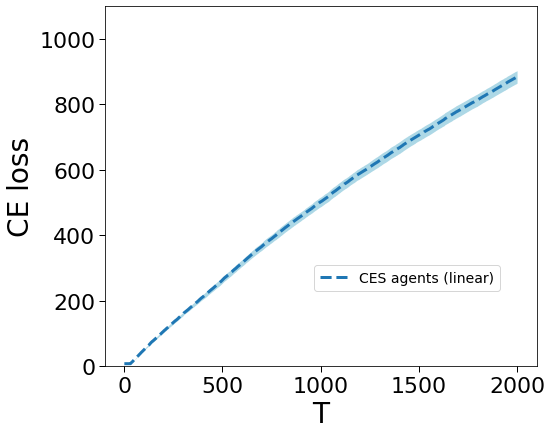

In [11]:
local_T = 2000

local_L_CE_list_mean = L_CE_list_mean

local_L_CE_list_std = L_CE_list_std

local_num_runs = 2

local_tickers=np.linspace(1,local_T,local_T)


plt.figure(figsize=(6,5))

plot_objectives(local_L_CE_list_mean, local_L_CE_list_std/np.sqrt(local_num_runs), facecolor='#add8e6', label='CES agents (sublinear)', 
                linestyle='--', linecolor='C0', tickers=local_tickers, log_scale=False)

plt.tick_params(length=6, width=1, top=False,right=False,labelsize=22)
plt.legend(loc='upper center', bbox_to_anchor=(0.7, 0.3), fontsize=14, ncol=1)
plt.xlabel("T", fontsize=28)
plt.ylabel("CE loss", fontsize=28)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.ylim((0,1100))